## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

['../camera_cal/calibration1.jpg', '../camera_cal/calibration10.jpg', '../camera_cal/calibration11.jpg', '../camera_cal/calibration12.jpg', '../camera_cal/calibration13.jpg', '../camera_cal/calibration14.jpg', '../camera_cal/calibration15.jpg', '../camera_cal/calibration16.jpg', '../camera_cal/calibration17.jpg', '../camera_cal/calibration18.jpg', '../camera_cal/calibration19.jpg', '../camera_cal/calibration2.jpg', '../camera_cal/calibration20.jpg', '../camera_cal/calibration3.jpg', '../camera_cal/calibration4.jpg', '../camera_cal/calibration5.jpg', '../camera_cal/calibration6.jpg', '../camera_cal/calibration7.jpg', '../camera_cal/calibration8.jpg', '../camera_cal/calibration9.jpg']


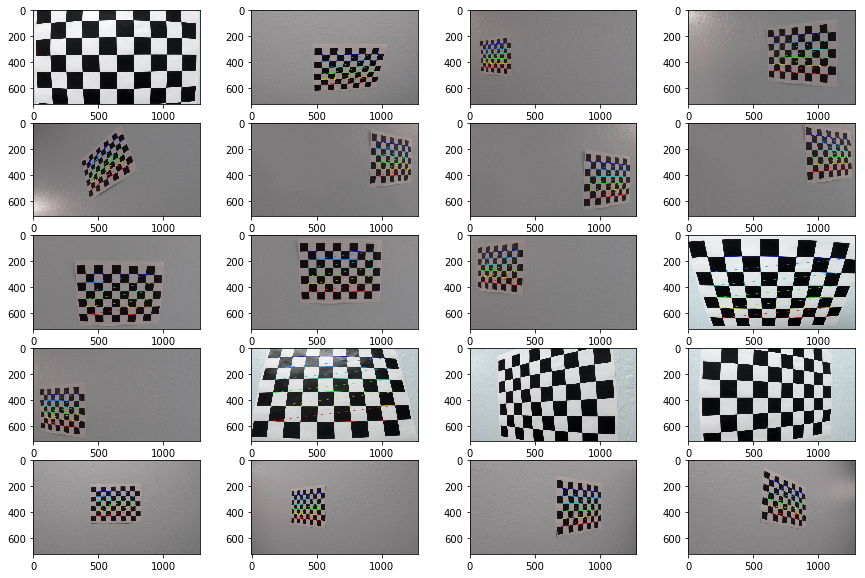

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from os import listdir

%matplotlib inline 

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
print(images)
#set imgs size
fig = plt.figure(figsize=(15, 10))


#loop all imgs
for num, fname in enumerate(images):
    img = cv2.imread(fname) #read in img
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #grayscale
    ret, corners = cv2.findChessboardCorners(gray_img, (9, 6), None) #find chessboard corners
    #if corners found, get objpoints, imgpoints
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (9, 6), corners, ret) #draw chessboard corners 
    #show all imgs
    fig.add_subplot(5, 4, (num+1))
    plt.imshow(img)   

global objpoints
global imgpoints
plt.show()


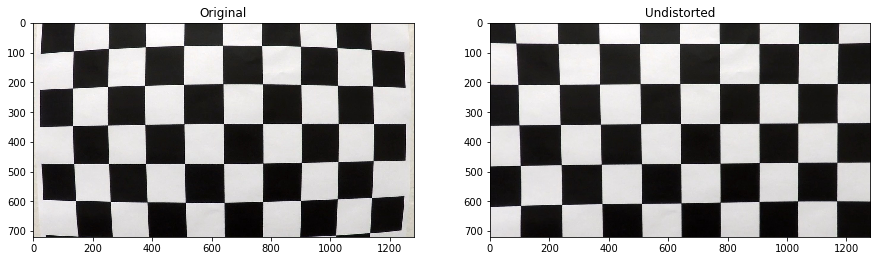

In [2]:
#creat undistort function 

imgs = glob.glob('../test_images/*.jpg')
the_gray = cv2.cvtColor(cv2.imread(imgs[0]), cv2.COLOR_BGR2GRAY)

_, _mtx, _dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, the_gray.shape[::-1], None, None)


def undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(img, _mtx, _dist, None, _mtx)
    return undist



#see chessboard test result 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 10))

chess_img = plt.imread(images[0])
chess_undist= undistort(chess_img, objpoints, imgpoints)
ax1.imshow(chess_img)
ax1.set_title('Original')
ax2.imshow(chess_undist)
ax2.set_title('Undistorted')



# example of a distortion-corrected image

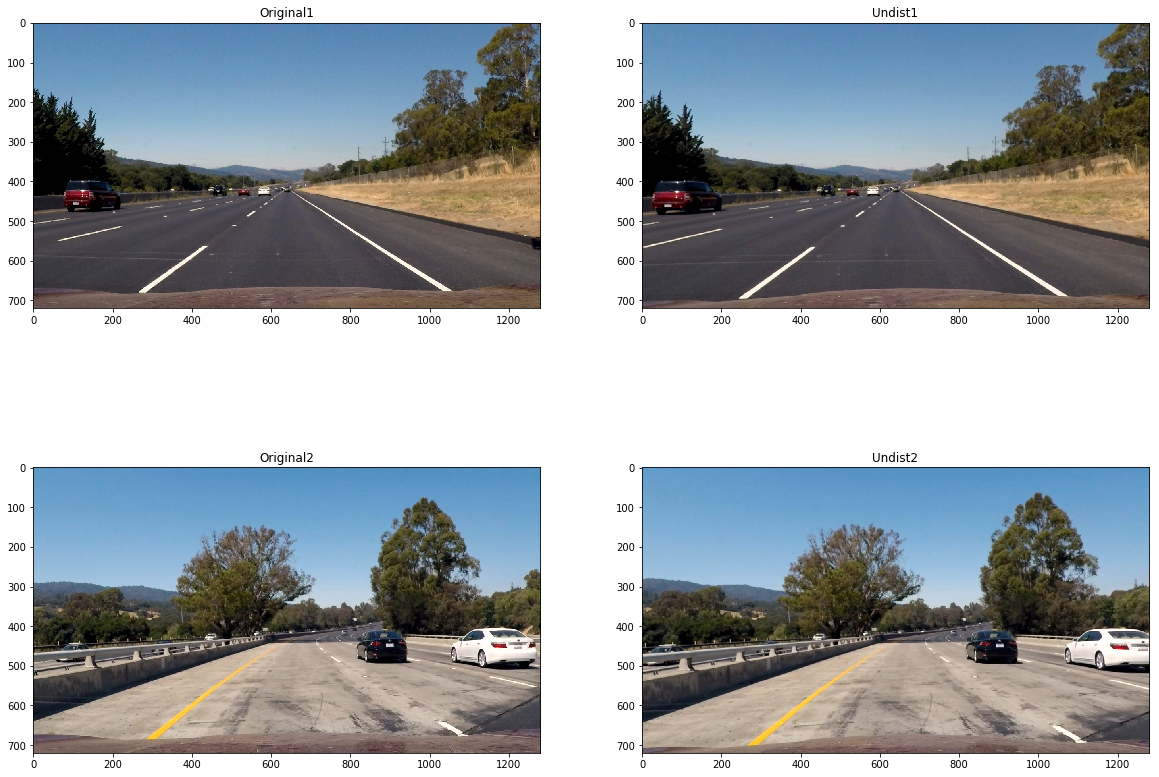

In [3]:
plt.figure(figsize=(20, 15))
#read in road_test_imgs
test_road_imgs = glob.glob('../test_images/*.jpg')
read_test_imgs = []
for img in test_road_imgs:
    read_test_imgs.append(plt.imread(img))

#Examples shown below
test_img1 = read_test_imgs[1]
undist1= undistort(test_img1, objpoints, imgpoints)

test_img2 = read_test_imgs[2]
undist2= undistort(test_img2, objpoints, imgpoints)

test_img3 = read_test_imgs[3]
undist3 = undistort(test_img3, objpoints, imgpoints)
 
plt.subplot(2, 2, 1)
plt.title('Original1')
plt.imshow(test_img1)

plt.subplot(2, 2, 2)
plt.title('Undist1')
plt.imshow(undist1)

plt.subplot(2, 2, 3)
plt.title('Original2')
plt.imshow(test_img2)

plt.subplot(2, 2, 4)
plt.title('Undist2')
plt.imshow(undist2)



# # Perspective Transform

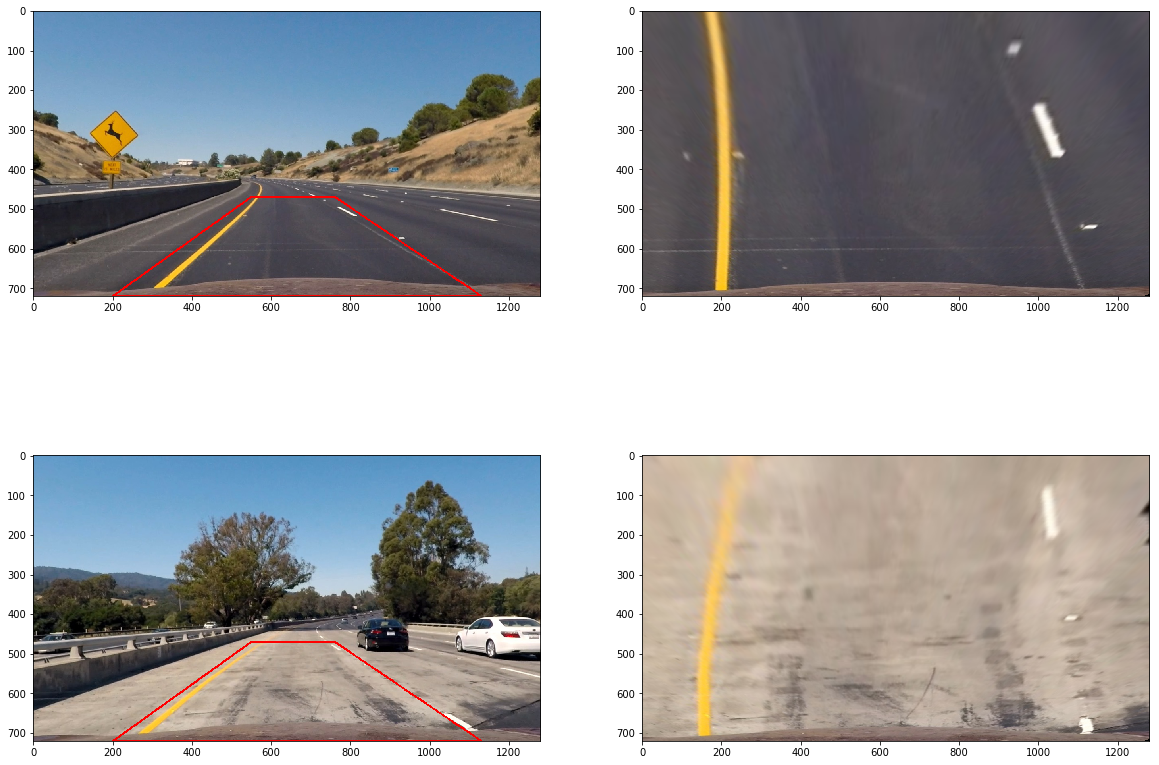

In [29]:
# create a warped function and return a warped_img 
def bird_eye_view(undist_img, dst, src):
    img_size = undist_img.shape[1::-1]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_img = cv2.warpPerspective(undist_img, M, img_size)
    return warped_img, M, Minv

#creat a mask_area function and return the specific area targeted
def mask_area(undist_img):
    #make copy of img
    copy_undist= undist_img.copy()
    
    #use previous un-disotrted img
    #get undist w and h
    undist_shape = undist_img.shape[1::-1]
    
    #left_top and right_top has same y, same for the left_bottom and right_bottom 
    top_y = 470
    bottom_y = undist_shape[1] #720
    
    #get every corner points also get seperated x and y
    left_down = (200, bottom_y)
    left_down_x, left_down_y = left_down
    
    left_top = (550, top_y)
    left_top_x, left_top_y = left_top 
    
    right_top = (undist_shape[0]-520, top_y)
    right_top_x, right_top_y = right_top
    
    right_down = (undist_shape[0]-150, bottom_y)
    right_down_x, right_down_y = right_down
    
    #draw target area
    color = [255, 0, 0]
    cv2.line(copy_undist, left_down, left_top, color, 4)
    cv2.line(copy_undist, left_down, right_down, color, 4)
    cv2.line(copy_undist, left_top, right_top, color, 4)
    cv2.line(copy_undist, right_top, right_down , color, 4)
    
    #src points
    src = np.float32([[left_down_x, left_down_y],  #left_down 
                      [left_top_x, left_top_y],  #left_top
                      [right_top_x, right_top_y],  #right_top
                      [right_down_x, right_down_y]])#right_down
    
    #dst points
    dst = np.float32([[100, undist_shape[1]], #left_down
                      [100, 0], #left_top
                      [1100, 0], #right_top
                      [1100, undist_shape[1]]]) #right_down
    return copy_undist, src, dst 

copy_undist2, src, dst = mask_area(undist2)
copy_undist3, _, _ = mask_area(undist3)
undist_warped2, M, Minv = bird_eye_view(undist2, dst, src)
undist_warped3, _, _= bird_eye_view(undist3, dst, src)

global src
global dst
 
#Example shown below 
plt.figure(figsize =(20, 15))
plt.subplot(2, 2, 1)
plt.imshow(copy_undist3)

plt.subplot(2, 2, 2)
plt.imshow(undist_warped3)

plt.subplot(2, 2, 3)
plt.imshow(copy_undist2)

plt.subplot(2, 2, 4)
plt.imshow(undist_warped2)


# Color and Gradient Threshold 

In [5]:


# L channel from LUV with lower and upper thresholds around 225 & 255
def luv_binary(img, thresh):
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    #get only s here
    l = luv[:,:,0]
    color_binary = np.zeros_like(l)
    color_binary[(l >= thresh[0]) & (l <= thresh[1])]=1
    return color_binary
    
# b channel from Lab which does a great job with the yellow lines
# (you can play around with thresholds around 155 & 200)

    
# create a function -- threshold_xbinary
def threshold_xbinary(img, orient, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #default orient=='x' 
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])]= 1
    return sxbinary

def b_binary(img, thresh):
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    b = img[:,:,2]
    bbinary = np.zeros_like(b)
    bbinary[(b >= thresh[0]) & (b <= thresh[1])] =1 
    return bbinary 

def hls_binary(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #get only s here
    s = hls[:,:,2]
    color_binary = np.zeros_like(s)
    color_binary[(s >= thresh[0]) & (s <= thresh[1])]=1
    return color_binary
    
    
def mag_binary(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    magnitude_xy = np.sqrt(sobelx**2 + sobely**2)
    scaled_xy= np.uint8(255*magnitude_xy/np.max(magnitude_xy))
    magnitude_binary = np.zeros_like(magnitude_xy)
    magnitude_binary[(scaled_xy >= thresh[0]) & (scaled_xy <= thresh[1])] =1
    return magnitude_binary 


def dir_binary(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arc = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(arc)
    dir_binary[(arc >= thresh[0]) & (arc <= thresh[1])] = 1
    return dir_binary 


def sobel_combined(image):
    # Apply combined sobel filter
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img_g_mag = mag_binary(image,3,(20,150))
    img_d_mag = dir_binary(image,3,(.6,1.1))
    img_abs_x = threshold_xbinary(image,'x',5,(50,200))
    img_abs_y = threshold_xbinary(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined


def combined_v1(image):
    # Apply combined sobel filter
    image = cv2.GaussianBlur(image, (5, 5), 0)
    luv = luv_binary(image, thresh=(225, 255))
    bbinary = b_binary(image, thresh=(155, 200))
    
    combined_binary = np.zeros_like(image)
    combined_binary[(luv==1) | (bbinary==1)]=1
    return combined_binary



def combined_binary(img, threshold_xbinary, sbinary):
    color_binary = np.dstack((np.zeros_like(threshold_xbinary), threshold_xbinary, sbinary))*255
    combined_binary = np.zeros_like(threshold_xbinary)
    combined_binary[(threshold_xbinary==1) | (sbinary==1)]=1
    return combined_binary


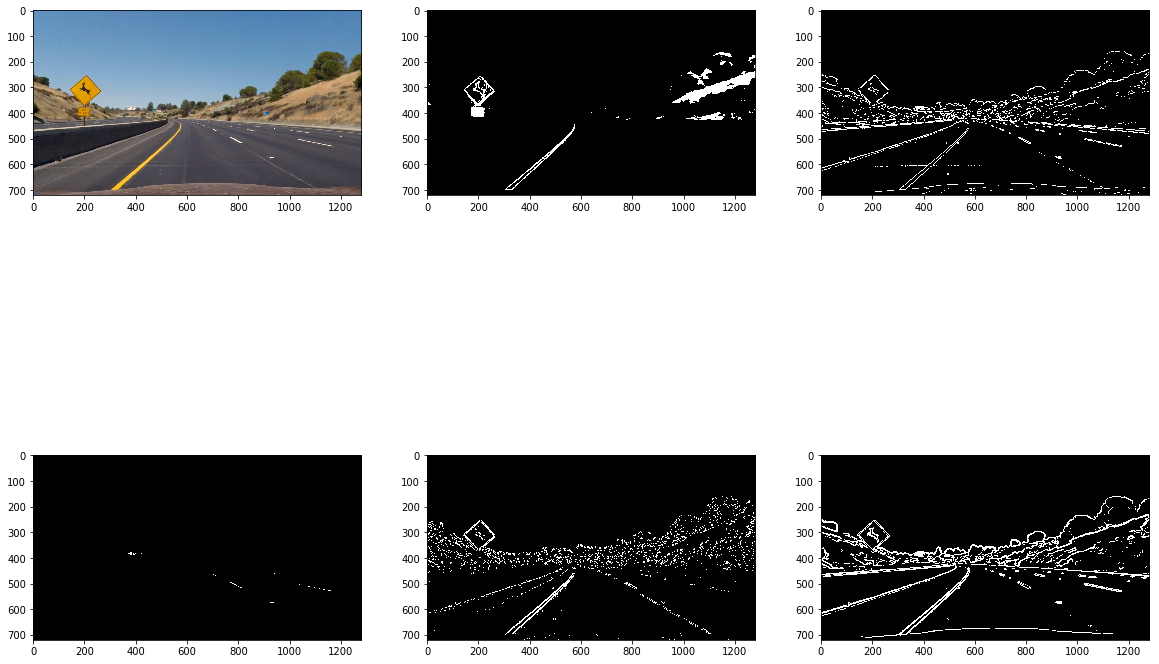

In [6]:
luv = luv_binary(undist3, thresh=(225, 255))

hls = hls_binary(undist3, thresh=(100, 255))

bbinary = b_binary(undist3, thresh=(155, 200))


sybinary = threshold_xbinary(undist3, orient ='y', sobel_kernel =3, thresh = (30, 200))
dirbinary = dir_binary(undist3, sobel_kernel =3, thresh=(0.9, np.pi/2))
mag = mag_binary(undist3, sobel_kernel = 15, thresh = (50, 200))
sobel_comb = sobel_combined(undist3)

fig = plt.figure(figsize =(20, 15))
#1
ax1 = fig.add_subplot(2, 3, 1)
ax1.imshow(undist3)
#2
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(bbinary, cmap='gray')
#3
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(sybinary, cmap='gray')
#4
ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(luv, cmap='gray')
#5
ax5 = fig.add_subplot(2, 3, 5)
ax5.imshow(sobel_comb, cmap='gray')
#6
ax6 = fig.add_subplot(2, 3, 6)
ax6.imshow(mag, cmap='gray')

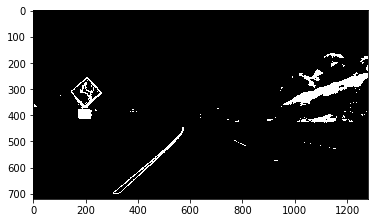

In [7]:
#binary_combo_example
combined1 = combined_binary(undist3, hls, sobel_comb)
combined2 = combined_binary(undist3, luv, bbinary)

plt.imshow(combined1, cmap = 'gray')
plt.imshow(combined2, cmap = 'gray')



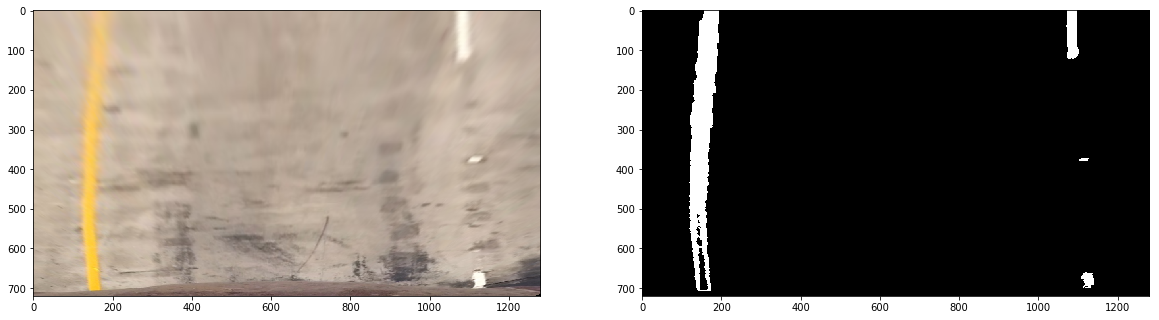

In [8]:
#apply combination to bird eye view
def binary_warped(undist_img):
    warped_img, _, _ = bird_eye_view(undist_img, dst, src)
    hls = hls_binary(warped_img, thresh=(100, 255))
    sobel_comb = sobel_combined(warped_img)
    binary_warped_img = combined_binary(warped_img, hls, sobel_comb)
    return binary_warped_img


#apply combination to bird eye view
def binary_warped(undist_img):
    warped_img, _, _ = bird_eye_view(undist_img, dst, src)
    
    luv = luv_binary(warped_img, thresh=(225, 255))
    bbinary = b_binary(warped_img, thresh=(155, 200))

    
    binary_warped_img = combined_binary(warped_img, luv, bbinary)
    return binary_warped_img


binary_warped2 = binary_warped(undist2)
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize =(20, 15))
ax1.imshow(undist_warped2)
ax2.imshow(binary_warped2, cmap='gray')

# Lane Line Detection

640


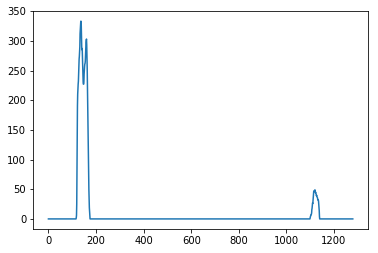

In [9]:
#find midpoint of two lane lines
histogram = np.sum(binary_warped2[binary_warped2.shape[0]//2:,:], axis = 0)
midpoint = np.int(histogram.shape[0]//2)
print(midpoint)
plt.plot(histogram)

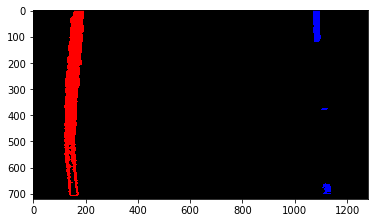

In [10]:
def lane_finding(warped_img):
    histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis = 0)
    midpoint = np.int(histogram.shape[0]//2)
    left_xbase = np.argmax(histogram[:midpoint])
    right_xbase = np.argmax(histogram[midpoint:]) +midpoint
    out_img = np.dstack((warped_img, warped_img, warped_img))*255

    nwindows = 9
    window_height = np.int(warped_img.shape[0]//nwindows)
    
    nonzero = warped_img.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]

    left_xcurrent = left_xbase
    right_xcurrent = right_xbase
    
    margin = 90
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_ylow = warped_img.shape[0]-(window+1)*window_height
        win_yhigh = warped_img.shape[0]-window*window_height
        win_xleft_low = left_xcurrent - margin
        win_xleft_high = left_xcurrent + margin
        win_xright_low = right_xcurrent - margin
        win_xright_high = right_xcurrent + margin
        
        #cv2.rectangle(out_img, (win_xleft_low, win_ylow), (win_xleft_high, win_yhigh), (0, 255, 0), 2)
        #cv2.rectangle(out_img, (win_xright_low, win_ylow), (win_xright_high, win_yhigh), (0, 255, 0), 2)
        
        good_left_inds = ((nonzeroy >= win_ylow) & (nonzeroy < win_yhigh) & (nonzerox >= win_xleft_low)
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_ylow) & (nonzeroy < win_yhigh) & (nonzerox >= win_xright_low) 
                           & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            left_xcurrent = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            right_xcurrent = np.int(np.mean(nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #extract the inds    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #fit left/right to the second polynomial
    if len(leftx) == 0:
        left_fit = []
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) == []:
        right_fit = []
    else:
        right_fit = np.polyfit(righty, rightx, 2)
        
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds

out_img, left_fit, right_fit, left_lane_inds, right_lane_inds= lane_finding(binary_warped2)

#visualize color fit line 
plt.imshow(out_img)

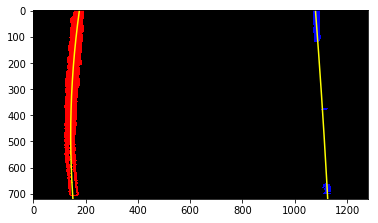

In [11]:
#draw yellow line 
ploty = np.linspace(0, binary_warped2.shape[0]-1, binary_warped2.shape[0]) 
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
plt.plot(left_fitx, ploty, color = 'yellow')
plt.plot(right_fitx, ploty, color = 'yellow')
plt.imshow(out_img)

In [12]:
def next_frame_finding(next_warped_img, left_fit, right_fit):
    #get nonzero
    nonzero = next_warped_img.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    
    margin = 100
    #create a img to draw 
   
    out_img = np.dstack((next_warped_img, next_warped_img, next_warped_img))*255
    #window_img = np.zeros_like(out_img)
    
    left_lane_inds = ((nonzerox > (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]-margin)) & 
                      (nonzerox < (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy +left_fit[2] +margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                      (nonzerox < (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] +margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx)==0:
        continue_left_fit = []
    else:
        continue_left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) == 0:
        continue_right_fit = []
    else:
        continue_right_fit = np.polyfit(righty, rightx, 2)
    return continue_left_fit, continue_right_fit, left_lane_inds, right_lane_inds

In [13]:



def curvature(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # A conversion of xm_per_pix = 3.7/700 assumes that the lane is only 700 pixels wide in the birds eye view images,
    # but in your example warped images the lane appears to be quite a bit wider than 700 pixels,
    # so you should replace the 700 with the actual width of the lane.

    # You should make a similar adjustment for ym_per_pix by replace the 30 with the 
    # length of road that is visible in front of the car in the birds eye view images.
    # You can do your best to estimate this by assuming that each long white dash is about 3 meters long

    print(binary_warped.shape[0])
    
    ym_per_pix = 20 / 230  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 920 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curve = ((1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**1.5)/np.abs(2*left_fit_cr[0])
    right_curve = ((1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**1.5)/np.abs(2*right_fit_cr[0])
    
    #car position in the middle of img
    car_position = binary_warped.shape[1]/2
    #calculate left and right bottom, center curvature is half of the sum
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[1]*y_eval + right_fit[2]
    center_position = (left_lane_bottom + right_lane_bottom) /2.
    center_locate = (car_position-center_position)*xm_per_pix
    return center_locate, left_curve, right_curve

#example
center_location, left_curve, right_curve= curvature(binary_warped2, left_fit, right_fit, left_lane_inds, right_lane_inds)
print(center_location, left_curve, right_curve)

720
0.138628841693 6466.67141796 56757.2050555


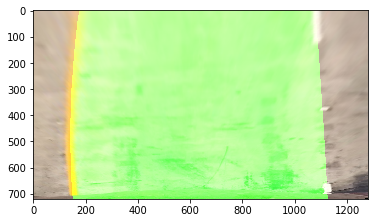

In [14]:
def path_visualize(undist_img, binary_warped, left_fit, right_fit):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    ploty = np.linspace (0, binary_warped.shape[0]-1, binary_warped.shape[0])
    #parabolas
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx =right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line_window, right_line_window))
    
    cv2.fillPoly(window_img, np.int_([line_pts]), (0, 255, 0))
    result = cv2.addWeighted(undist_img, 1 , window_img, 0.7, 0) 
    return result
next_left_fit, next_right_fit, next_left_inds, next_right_inds = next_frame_finding(undist_warped2, left_fit, right_fit)
res = path_visualize(undist_warped2, binary_warped2, next_left_fit, next_right_fit)
plt.imshow(res)

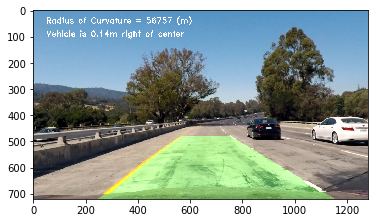

In [15]:
#draw and warp back to original image
def draw_back_original(binary_warped, undist, left_fitx, right_fitx, to_center, left_curve, right_curve):
    #create a blank img
    warped_zero = np.zeros_like(binary_warped).astype(np.uint8)
    #create a color img
    color_out = np.dstack((warped_zero, warped_zero, warped_zero))
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_out, np.int_([pts]), (0, 255, 0))
    
    #warped back to original undist img
    newwarp = cv2.warpPerspective(color_out, Minv, (undist.shape[1], undist.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #get direction to left or right
    if to_center < 0:
        position = 'left'
        curvature = left_curve
    else:
        position = 'right'
        curvature = right_curve
    #visualize in warped back img 
    cv2.putText(result, 'Radius of Curvature = {:.0f} (m)'.format(curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Vehicle is {:.2f}m {} of center'.format(to_center, position), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    return result

#example
result = draw_back_original(binary_warped2, undist2, left_fitx, right_fitx, center_location, left_curve, right_curve)
plt.imshow(result)

In [16]:
class Lane():
    def __init__(self):
        self.last_left = None
        self.last_right = None
        self.left_fit = None
        self.right_fit = None
        self.counter = 0
        
def check_slope(left_fit, right_fit):
    if len(left_fit)==0 or len(right_fit)== 0:
        status = False
    else:
        left_slope1 = 2*left_fit[0]*720 + left_fit[1]
        right_slope1 = 2*right_fit[0]*720 + right_fit[1]
        diff1 = np.abs(left_slope1 - right_slope1)
        
        left_slope2 = 2*left_fit[0]*360 + left_fit[1]
        right_slope2 = 2*right_fit[0]*360 + right_fit[1]
        diff2 = np.abs(left_slope2 - right_slope2)
        
        if diff1 <= 0.55 and diff2 <= 0.55:
            status = True
        else:
            status = False
        
    return status
        

In [17]:
lane = Lane()

def process_img(img):
    undist_img = undistort(img, objpoints, imgpoints)
    binary_warped_img = binary_warped(undist_img) 
    
    if lane.counter == 0:
        out_img, lane.left_fit, lane.right_fit, left_lane_inds, right_lane_inds = lane_finding(binary_warped_img)
    else:
        lane.left_fit, lane.right_fit, left_lane_inds, right_lane_inds = next_frame_finding(binary_warped_img, lane.left_fit, lane.right_fit)
    
    print(lane.left_fit)
    print(lane.last_left)
    print(lane.right_fit)

    
    status = check_slope(lane.left_fit, lane.right_fit)
    if status == True: 
        lane.last_left, lane.last_right = lane.left_fit, lane.right_fit
        lane.counter += 1
    else:
        lane.left_fit, lane.right_fit = lane.last_left, lane.last_right
        
    print(lane.left_fit)
    print(lane.last_left)
    print(lane.right_fit)
    
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0]) 
    left_fitx = lane.left_fit[0]*ploty**2 + lane.left_fit[1]*ploty + lane.left_fit[2]
    right_fitx = lane.right_fit[0]*ploty**2 + lane.right_fit[1]*ploty + lane.right_fit[2]
     
    center_location, left_curve, right_curve = curvature(binary_warped_img, lane.left_fit, lane.right_fit, left_lane_inds, right_lane_inds)
    result = draw_back_original(binary_warped_img, undist_img,left_fitx, right_fitx, center_location, left_curve, right_curve)       
    return result 

[  3.13890029e-05  -9.25374046e-03   1.11187591e+02]
None
[  1.63723977e-05   1.13467202e-01   9.85267029e+02]
[  3.13890029e-05  -9.25374046e-03   1.11187591e+02]
[  3.13890029e-05  -9.25374046e-03   1.11187591e+02]
[  1.63723977e-05   1.13467202e-01   9.85267029e+02]
720


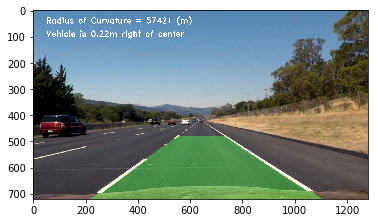

In [18]:
res = process_img(read_test_imgs[1])
plt.imshow(res)

In [19]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML



In [30]:
output = 'road.mp4'

from moviepy.editor import ImageSequenceClip
clip1 = VideoFileClip('../project_video.mp4')
new_frames = []


    
# %time new_frames = [process_img(fr) for fr in clip1.iter_frames()]
print('processing')
new_clip = clip1.fl_image(process_img)

print('images done processing')
    
    
# new_clip = ImageSequenceClip(new_frames, fps=cli/p1.fps)
%time new_clip.write_videofile(output, audio=False)
    

HTML("""
<video width="960" height="540" controls>
  <source src='{0}'>
</video>
""".format(output))

processing
[  7.30440202e-06  -2.38577586e-02   2.10485643e+02]
[  1.69865615e-04  -3.95689171e-01   3.72409989e+02]
[ -1.39359858e-04   4.89846030e-01   8.92969888e+02]
[  7.30440202e-06  -2.38577586e-02   2.10485643e+02]
[  7.30440202e-06  -2.38577586e-02   2.10485643e+02]
[ -1.39359858e-04   4.89846030e-01   8.92969888e+02]
720
images done processing
[MoviePy] >>>> Building video road.mp4
[MoviePy] Writing video road.mp4



  0%|          | 1/1261 [00:00<02:35,  8.11it/s]

[ -1.46682461e-04   1.21526007e-01   1.78476368e+02]
[  7.30440202e-06  -2.38577586e-02   2.10485643e+02]
[ -1.39359858e-04   4.89846030e-01   8.92969888e+02]
[ -1.46682461e-04   1.21526007e-01   1.78476368e+02]
[ -1.46682461e-04   1.21526007e-01   1.78476368e+02]
[ -1.39359858e-04   4.89846030e-01   8.92969888e+02]
720



  0%|          | 2/1261 [00:00<02:42,  7.73it/s]

[ -1.67488367e-04   1.37550964e-01   1.77431245e+02]
[ -1.46682461e-04   1.21526007e-01   1.78476368e+02]
[ -1.43488965e-04   4.99169060e-01   8.86864655e+02]
[ -1.67488367e-04   1.37550964e-01   1.77431245e+02]
[ -1.67488367e-04   1.37550964e-01   1.77431245e+02]
[ -1.43488965e-04   4.99169060e-01   8.86864655e+02]
720


[ -1.76355310e-04   1.45829243e-01   1.76919537e+02]
[ -1.67488367e-04   1.37550964e-01   1.77431245e+02]
[ -1.37704616e-04   5.01612272e-01   8.82591552e+02]
[ -1.76355310e-04   1.45829243e-01   1.76919537e+02]
[ -1.76355310e-04   1.45829243e-01   1.76919537e+02]
[ -1.37704616e-04   5.01612272e-01   8.82591552e+02]
720



  0%|          | 4/1261 [00:00<02:54,  7.20it/s]

[ -1.83980025e-04   1.53445758e-01   1.76301825e+02]
[ -1.76355310e-04   1.45829243e-01   1.76919537e+02]
[ -1.35770726e-04   5.07754800e-01   8.78070124e+02]
[ -1.83980025e-04   1.53445758e-01   1.76301825e+02]
[ -1.83980025e-04   1.53445758e-01   1.76301825e+02]
[ -1.35770726e-04   5.07754800e-01   8.78070124e+02]
720



  0%|          | 5/1261 [00:00<02:58,  7.03it/s]

[ -2.05435276e-04   1.68417294e-01   1.74542684e+02]
[ -1.83980025e-04   1.53445758e-01   1.76301825e+02]
[ -1.33822411e-04   5.07134190e-01   8.77753620e+02]
[ -2.05435276e-04   1.68417294e-01   1.74542684e+02]
[ -2.05435276e-04   1.68417294e-01   1.74542684e+02]
[ -1.33822411e-04   5.07134190e-01   8.77753620e+02]
720



  0%|          | 6/1261 [00:00<03:00,  6.93it/s]

[ -2.08342085e-04   1.76269826e-01   1.73124738e+02]
[ -2.05435276e-04   1.68417294e-01   1.74542684e+02]
[ -1.54421785e-04   5.31689968e-01   8.69437203e+02]
[ -2.08342085e-04   1.76269826e-01   1.73124738e+02]
[ -2.08342085e-04   1.76269826e-01   1.73124738e+02]
[ -1.54421785e-04   5.31689968e-01   8.69437203e+02]
720


[ -2.07927513e-04   1.83356353e-01   1.69655112e+02]
[ -2.08342085e-04   1.76269826e-01   1.73124738e+02]
[ -1.86684265e-04   5.58241026e-01   8.66709537e+02]
[ -2.07927513e-04   1.83356353e-01   1.69655112e+02]
[ -2.07927513e-04   1.83356353e-01   1.69655112e+02]
[ -1.86684265e-04   5.58241026e-01   8.66709537e+02]
720



  1%|          | 8/1261 [00:01<03:05,  6.77it/s]

[ -2.07052014e-04   1.87705740e-01   1.69404943e+02]
[ -2.07927513e-04   1.83356353e-01   1.69655112e+02]
[  1.03129893e-05   4.35287001e-01   8.79828376e+02]
[ -2.07927513e-04   1.83356353e-01   1.69655112e+02]
[ -2.07927513e-04   1.83356353e-01   1.69655112e+02]
[ -1.86684265e-04   5.58241026e-01   8.66709537e+02]
720


[ -1.96542602e-04   1.83911829e-01   1.66746647e+02]
[ -2.07927513e-04   1.83356353e-01   1.69655112e+02]
[  2.73818142e-05   4.05370176e-01   8.89706656e+02]
[ -1.96542602e-04   1.83911829e-01   1.66746647e+02]
[ -1.96542602e-04   1.83911829e-01   1.66746647e+02]
[  2.73818142e-05   4.05370176e-01   8.89706656e+02]
720



  1%|          | 10/1261 [00:01<03:30,  5.93it/s]

[ -1.97273657e-04   1.88441511e-01   1.63617284e+02]
[ -1.96542602e-04   1.83911829e-01   1.66746647e+02]
[ -1.35529363e-04   5.37829800e-01   8.63537796e+02]
[ -1.97273657e-04   1.88441511e-01   1.63617284e+02]
[ -1.97273657e-04   1.88441511e-01   1.63617284e+02]
[ -1.35529363e-04   5.37829800e-01   8.63537796e+02]
720
[ -2.05631677e-04   1.99785163e-01   1.60526643e+02]
[ -1.97273657e-04   1.88441511e-01   1.63617284e+02]
[ -1.24649889e-04   5.37774788e-01   8.58228309e+02]
[ -2.05631677e-04   1.99785163e-01   1.60526643e+02]
[ -2.05631677e-04   1.99785163e-01   1.60526643e+02]
[ -1.24649889e-04   5.37774788e-01   8.58228309e+02]
720



  1%|          | 13/1261 [00:02<03:48,  5.46it/s]

[ -1.88991904e-04   1.95576980e-01   1.53185706e+02]
[ -2.05631677e-04   1.99785163e-01   1.60526643e+02]
[ -1.12295562e-04   5.09247750e-01   8.74567155e+02]
[ -1.88991904e-04   1.95576980e-01   1.53185706e+02]
[ -1.88991904e-04   1.95576980e-01   1.53185706e+02]
[ -1.12295562e-04   5.09247750e-01   8.74567155e+02]
720
[ -1.88451537e-04   1.99465978e-01   1.51252820e+02]
[ -1.88991904e-04   1.95576980e-01   1.53185706e+02]
[ -1.61733648e-04   5.38181107e-01   8.68039931e+02]
[ -1.88451537e-04   1.99465978e-01   1.51252820e+02]
[ -1.88451537e-04   1.99465978e-01   1.51252820e+02]
[ -1.61733648e-04   5.38181107e-01   8.68039931e+02]
720



  1%|          | 15/1261 [00:02<03:25,  6.05it/s]

[ -1.92086762e-04   2.06634067e-01   1.48658571e+02]
[ -1.88451537e-04   1.99465978e-01   1.51252820e+02]
[ -1.54773203e-04   5.39670786e-01   8.64309417e+02]
[ -1.92086762e-04   2.06634067e-01   1.48658571e+02]
[ -1.92086762e-04   2.06634067e-01   1.48658571e+02]
[ -1.54773203e-04   5.39670786e-01   8.64309417e+02]
720
[ -1.83623404e-04   1.99906328e-01   1.51219192e+02]
[ -1.92086762e-04   2.06634067e-01   1.48658571e+02]
[ -1.43476419e-04   5.50348977e-01   8.49472047e+02]
[ -1.83623404e-04   1.99906328e-01   1.51219192e+02]
[ -1.83623404e-04   1.99906328e-01   1.51219192e+02]
[ -1.43476419e-04   5.50348977e-01   8.49472047e+02]
720



  1%|▏         | 17/1261 [00:02<03:01,  6.85it/s]

[ -1.75997444e-04   1.93836013e-01   1.52841299e+02]
[ -1.83623404e-04   1.99906328e-01   1.51219192e+02]
[ -1.41147968e-04   5.57957574e-01   8.37737953e+02]
[ -1.75997444e-04   1.93836013e-01   1.52841299e+02]
[ -1.75997444e-04   1.93836013e-01   1.52841299e+02]
[ -1.41147968e-04   5.57957574e-01   8.37737953e+02]
720
[ -1.81789335e-04   1.94565058e-01   1.51836283e+02]
[ -1.75997444e-04   1.93836013e-01   1.52841299e+02]
[ -1.44242820e-04   5.62477806e-01   8.34082825e+02]
[ -1.81789335e-04   1.94565058e-01   1.51836283e+02]
[ -1.81789335e-04   1.94565058e-01   1.51836283e+02]
[ -1.44242820e-04   5.62477806e-01   8.34082825e+02]
720



  2%|▏         | 19/1261 [00:02<02:49,  7.34it/s]

[ -1.71710129e-04   1.87727583e-01   1.52217710e+02]
[ -1.81789335e-04   1.94565058e-01   1.51836283e+02]
[ -1.28066742e-04   5.54479393e-01   8.30209353e+02]
[ -1.71710129e-04   1.87727583e-01   1.52217710e+02]
[ -1.71710129e-04   1.87727583e-01   1.52217710e+02]
[ -1.28066742e-04   5.54479393e-01   8.30209353e+02]
720
[ -1.50332221e-04   1.75646411e-01   1.49897729e+02]
[ -1.71710129e-04   1.87727583e-01   1.52217710e+02]
[ -9.44083483e-05   5.16515242e-01   8.42043139e+02]
[ -1.50332221e-04   1.75646411e-01   1.49897729e+02]
[ -1.50332221e-04   1.75646411e-01   1.49897729e+02]
[ -9.44083483e-05   5.16515242e-01   8.42043139e+02]
720



  2%|▏         | 21/1261 [00:03<02:41,  7.70it/s]

[ -1.27885876e-04   1.61975290e-01   1.48189521e+02]
[ -1.50332221e-04   1.75646411e-01   1.49897729e+02]
[ -6.85023591e-05   4.86649946e-01   8.51203258e+02]
[ -1.27885876e-04   1.61975290e-01   1.48189521e+02]
[ -1.27885876e-04   1.61975290e-01   1.48189521e+02]
[ -6.85023591e-05   4.86649946e-01   8.51203258e+02]
720
[ -1.03118294e-04   1.45791140e-01   1.46744749e+02]
[ -1.27885876e-04   1.61975290e-01   1.48189521e+02]
[  1.36901536e-04   3.30918238e-01   8.83687513e+02]
[ -1.03118294e-04   1.45791140e-01   1.46744749e+02]
[ -1.03118294e-04   1.45791140e-01   1.46744749e+02]
[  1.36901536e-04   3.30918238e-01   8.83687513e+02]
720



  2%|▏         | 23/1261 [00:03<02:40,  7.71it/s]

[ -7.48861218e-05   1.26682896e-01   1.45079708e+02]
[ -1.03118294e-04   1.45791140e-01   1.46744749e+02]
[  1.26209336e-04   3.11589745e-01   8.96846094e+02]
[ -7.48861218e-05   1.26682896e-01   1.45079708e+02]
[ -7.48861218e-05   1.26682896e-01   1.45079708e+02]
[  1.26209336e-04   3.11589745e-01   8.96846094e+02]
720
[ -6.08566021e-05   1.12736688e-01   1.44338494e+02]
[ -7.48861218e-05   1.26682896e-01   1.45079708e+02]
[  1.15625428e-04   2.94232277e-01   9.08320920e+02]
[ -6.08566021e-05   1.12736688e-01   1.44338494e+02]
[ -6.08566021e-05   1.12736688e-01   1.44338494e+02]
[  1.15625428e-04   2.94232277e-01   9.08320920e+02]
720



  2%|▏         | 25/1261 [00:03<02:37,  7.84it/s]

[ -6.66181846e-05   1.09421711e-01   1.47368901e+02]
[ -6.08566021e-05   1.12736688e-01   1.44338494e+02]
[ -1.00690535e-04   4.88686426e-01   8.63953303e+02]
[ -6.66181846e-05   1.09421711e-01   1.47368901e+02]
[ -6.66181846e-05   1.09421711e-01   1.47368901e+02]
[ -1.00690535e-04   4.88686426e-01   8.63953303e+02]
720
[ -7.81249928e-05   1.11077028e-01   1.48863769e+02]
[ -6.66181846e-05   1.09421711e-01   1.47368901e+02]
[ -1.02737784e-04   4.93192047e-01   8.60321498e+02]
[ -7.81249928e-05   1.11077028e-01   1.48863769e+02]
[ -7.81249928e-05   1.11077028e-01   1.48863769e+02]
[ -1.02737784e-04   4.93192047e-01   8.60321498e+02]
720



  2%|▏         | 26/1261 [00:03<02:37,  7.86it/s]

[ -7.30343197e-05   1.06241997e-01   1.46412198e+02]
[ -7.81249928e-05   1.11077028e-01   1.48863769e+02]
[ -1.85072285e-04   5.21921798e-01   8.69127449e+02]
[ -7.30343197e-05   1.06241997e-01   1.46412198e+02]
[ -7.30343197e-05   1.06241997e-01   1.46412198e+02]
[ -1.85072285e-04   5.21921798e-01   8.69127449e+02]
720
[ -7.67749228e-05   1.03769634e-01   1.46965726e+02]



  2%|▏         | 28/1261 [00:04<02:54,  7.07it/s]

[ -7.30343197e-05   1.06241997e-01   1.46412198e+02]
[ -1.68449764e-04   5.14386468e-01   8.71426363e+02]
[ -7.67749228e-05   1.03769634e-01   1.46965726e+02]
[ -7.67749228e-05   1.03769634e-01   1.46965726e+02]
[ -1.68449764e-04   5.14386468e-01   8.71426363e+02]
720
[ -7.49835409e-05   1.00723952e-01   1.44520198e+02]
[ -7.67749228e-05   1.03769634e-01   1.46965726e+02]
[ -1.58714874e-04   4.97989778e-01   8.83253586e+02]
[ -7.49835409e-05   1.00723952e-01   1.44520198e+02]
[ -7.49835409e-05   1.00723952e-01   1.44520198e+02]
[ -1.58714874e-04   4.97989778e-01   8.83253586e+02]
720



  2%|▏         | 30/1261 [00:04<02:48,  7.29it/s]

[ -9.47345771e-05   1.08954835e-01   1.46599770e+02]
[ -7.49835409e-05   1.00723952e-01   1.44520198e+02]
[ -1.52050993e-04   5.03106177e-01   8.77824113e+02]
[ -9.47345771e-05   1.08954835e-01   1.46599770e+02]
[ -9.47345771e-05   1.08954835e-01   1.46599770e+02]
[ -1.52050993e-04   5.03106177e-01   8.77824113e+02]
720
[ -1.36195715e-04   1.25225619e-01   1.50008556e+02]
[ -9.47345771e-05   1.08954835e-01   1.46599770e+02]
[ -1.61991244e-04   5.20735421e-01   8.68795666e+02]
[ -1.36195715e-04   1.25225619e-01   1.50008556e+02]
[ -1.36195715e-04   1.25225619e-01   1.50008556e+02]
[ -1.61991244e-04   5.20735421e-01   8.68795666e+02]
720



  3%|▎         | 32/1261 [00:04<02:42,  7.58it/s]

[ -1.61744808e-04   1.38372449e-01   1.52924056e+02]
[ -1.36195715e-04   1.25225619e-01   1.50008556e+02]
[ -1.73827121e-04   5.43330194e-01   8.59481700e+02]
[ -1.61744808e-04   1.38372449e-01   1.52924056e+02]
[ -1.61744808e-04   1.38372449e-01   1.52924056e+02]
[ -1.73827121e-04   5.43330194e-01   8.59481700e+02]
720
[ -1.81893630e-04   1.48080749e-01   1.56611993e+02]
[ -1.61744808e-04   1.38372449e-01   1.52924056e+02]
[ -1.89033209e-04   5.69762607e-01   8.46078249e+02]
[ -1.81893630e-04   1.48080749e-01   1.56611993e+02]
[ -1.81893630e-04   1.48080749e-01   1.56611993e+02]
[ -1.89033209e-04   5.69762607e-01   8.46078249e+02]
720



  3%|▎         | 34/1261 [00:04<02:37,  7.81it/s]

[ -1.81166802e-04   1.49149462e-01   1.54538313e+02]
[ -1.81893630e-04   1.48080749e-01   1.56611993e+02]
[ -1.84778701e-04   5.66159587e-01   8.51941522e+02]
[ -1.81166802e-04   1.49149462e-01   1.54538313e+02]
[ -1.81166802e-04   1.49149462e-01   1.54538313e+02]
[ -1.84778701e-04   5.66159587e-01   8.51941522e+02]
720
[ -1.84484090e-04   1.50473326e-01   1.57203197e+02]
[ -1.81166802e-04   1.49149462e-01   1.54538313e+02]
[ -1.55282646e-05   4.52226759e-01   8.67303602e+02]
[ -1.84484090e-04   1.50473326e-01   1.57203197e+02]
[ -1.84484090e-04   1.50473326e-01   1.57203197e+02]
[ -1.55282646e-05   4.52226759e-01   8.67303602e+02]
720



  3%|▎         | 36/1261 [00:05<02:38,  7.75it/s]

[ -1.80185446e-04   1.47385284e-01   1.59341259e+02]
[ -1.84484090e-04   1.50473326e-01   1.57203197e+02]
[ -1.09201012e-04   5.23903993e-01   8.53243258e+02]
[ -1.80185446e-04   1.47385284e-01   1.59341259e+02]
[ -1.80185446e-04   1.47385284e-01   1.59341259e+02]
[ -1.09201012e-04   5.23903993e-01   8.53243258e+02]
720
[ -1.94658401e-04   1.60953897e-01   1.59641037e+02]
[ -1.80185446e-04   1.47385284e-01   1.59341259e+02]
[ -1.22218693e-04   5.42743481e-01   8.43957403e+02]
[ -1.94658401e-04   1.60953897e-01   1.59641037e+02]
[ -1.94658401e-04   1.60953897e-01   1.59641037e+02]
[ -1.22218693e-04   5.42743481e-01   8.43957403e+02]
720



  3%|▎         | 38/1261 [00:05<02:35,  7.86it/s]

[ -1.92403045e-04   1.60309235e-01   1.60796552e+02]
[ -1.94658401e-04   1.60953897e-01   1.59641037e+02]
[ -1.23168416e-04   5.40655192e-01   8.41952291e+02]
[ -1.92403045e-04   1.60309235e-01   1.60796552e+02]
[ -1.92403045e-04   1.60309235e-01   1.60796552e+02]
[ -1.23168416e-04   5.40655192e-01   8.41952291e+02]
720
[ -2.04017218e-04   1.69738274e-01   1.61620400e+02]
[ -1.92403045e-04   1.60309235e-01   1.60796552e+02]
[ -1.77334442e-04   5.70485335e-01   8.36956980e+02]
[ -2.04017218e-04   1.69738274e-01   1.61620400e+02]
[ -2.04017218e-04   1.69738274e-01   1.61620400e+02]
[ -1.77334442e-04   5.70485335e-01   8.36956980e+02]
720



  3%|▎         | 40/1261 [00:05<02:36,  7.81it/s]

[ -2.14360500e-04   1.78116318e-01   1.62103315e+02]
[ -2.04017218e-04   1.69738274e-01   1.61620400e+02]
[ -1.68173103e-04   5.71210567e-01   8.30373946e+02]
[ -2.14360500e-04   1.78116318e-01   1.62103315e+02]
[ -2.14360500e-04   1.78116318e-01   1.62103315e+02]
[ -1.68173103e-04   5.71210567e-01   8.30373946e+02]
720
[ -2.18616371e-04   1.86276617e-01   1.58881065e+02]
[ -2.14360500e-04   1.78116318e-01   1.62103315e+02]
[ -1.56299619e-04   5.59406190e-01   8.34052929e+02]
[ -2.18616371e-04   1.86276617e-01   1.58881065e+02]
[ -2.18616371e-04   1.86276617e-01   1.58881065e+02]
[ -1.56299619e-04   5.59406190e-01   8.34052929e+02]
720



  3%|▎         | 42/1261 [00:05<02:36,  7.81it/s]

[ -2.21826024e-04   1.94095720e-01   1.56885232e+02]
[ -2.18616371e-04   1.86276617e-01   1.58881065e+02]
[ -1.51204116e-04   5.57528142e-01   8.33554597e+02]
[ -2.21826024e-04   1.94095720e-01   1.56885232e+02]
[ -2.21826024e-04   1.94095720e-01   1.56885232e+02]
[ -1.51204116e-04   5.57528142e-01   8.33554597e+02]
720
[ -2.26852771e-04   2.02089672e-01   1.55166992e+02]
[ -2.21826024e-04   1.94095720e-01   1.56885232e+02]
[ -1.47151261e-04   5.52516359e-01   8.36252793e+02]
[ -2.26852771e-04   2.02089672e-01   1.55166992e+02]
[ -2.26852771e-04   2.02089672e-01   1.55166992e+02]
[ -1.47151261e-04   5.52516359e-01   8.36252793e+02]
720



  3%|▎         | 44/1261 [00:06<02:46,  7.32it/s]

[ -2.57579833e-04   2.27088589e-01   1.50109753e+02]
[ -2.26852771e-04   2.02089672e-01   1.55166992e+02]
[ -1.68757008e-04   5.65681417e-01   8.38895741e+02]
[ -2.57579833e-04   2.27088589e-01   1.50109753e+02]
[ -2.57579833e-04   2.27088589e-01   1.50109753e+02]
[ -1.68757008e-04   5.65681417e-01   8.38895741e+02]
720
[ -2.53606595e-04   2.28545005e-01   1.46961298e+02]
[ -2.57579833e-04   2.27088589e-01   1.50109753e+02]
[ -1.82957922e-04   5.69789907e-01   8.44039862e+02]
[ -2.53606595e-04   2.28545005e-01   1.46961298e+02]
[ -2.53606595e-04   2.28545005e-01   1.46961298e+02]
[ -1.82957922e-04   5.69789907e-01   8.44039862e+02]
720



  4%|▎         | 46/1261 [00:06<02:47,  7.27it/s]

[ -2.57007299e-04   2.37397230e-01   1.43305531e+02]
[ -2.53606595e-04   2.28545005e-01   1.46961298e+02]
[ -1.88178845e-04   5.72342398e-01   8.47244416e+02]
[ -2.57007299e-04   2.37397230e-01   1.43305531e+02]
[ -2.57007299e-04   2.37397230e-01   1.43305531e+02]
[ -1.88178845e-04   5.72342398e-01   8.47244416e+02]
720
[ -2.50471677e-04   2.35566265e-01   1.41834177e+02]
[ -2.57007299e-04   2.37397230e-01   1.43305531e+02]
[  7.62669428e-06   4.40991632e-01   8.67022490e+02]
[ -2.57007299e-04   2.37397230e-01   1.43305531e+02]
[ -2.57007299e-04   2.37397230e-01   1.43305531e+02]
[ -1.88178845e-04   5.72342398e-01   8.47244416e+02]
720



  4%|▎         | 47/1261 [00:06<03:05,  6.54it/s]

[ -2.50176432e-04   2.40209732e-01   1.38294502e+02]
[ -2.57007299e-04   2.37397230e-01   1.43305531e+02]
[  1.00067553e-05   4.23310627e-01   8.74148726e+02]
[ -2.57007299e-04   2.37397230e-01   1.43305531e+02]
[ -2.57007299e-04   2.37397230e-01   1.43305531e+02]
[ -1.88178845e-04   5.72342398e-01   8.47244416e+02]
720
[ -2.42894764e-04   2.37632555e-01   1.38038169e+02]
[ -2.57007299e-04   2.37397230e-01   1.43305531e+02]
[ -1.38967245e-04   5.50239713e-01   8.45626939e+02]
[ -2.42894764e-04   2.37632555e-01   1.38038169e+02]
[ -2.42894764e-04   2.37632555e-01   1.38038169e+02]
[ -1.38967245e-04   5.50239713e-01   8.45626939e+02]
720



  4%|▍         | 50/1261 [00:07<03:04,  6.55it/s]

[ -2.36747107e-04   2.41396701e-01   1.32559299e+02]
[ -2.42894764e-04   2.37632555e-01   1.38038169e+02]
[ -1.38910127e-04   5.40931885e-01   8.52569314e+02]
[ -2.36747107e-04   2.41396701e-01   1.32559299e+02]
[ -2.36747107e-04   2.41396701e-01   1.32559299e+02]
[ -1.38910127e-04   5.40931885e-01   8.52569314e+02]
720
[ -2.27834105e-04   2.38995035e-01   1.31413534e+02]
[ -2.36747107e-04   2.41396701e-01   1.32559299e+02]
[ -1.38127468e-04   5.44773301e-01   8.49034236e+02]
[ -2.27834105e-04   2.38995035e-01   1.31413534e+02]
[ -2.27834105e-04   2.38995035e-01   1.31413534e+02]
[ -1.38127468e-04   5.44773301e-01   8.49034236e+02]
720



  4%|▍         | 51/1261 [00:07<03:08,  6.44it/s]

[ -2.20845724e-04   2.38483230e-01   1.29407808e+02]
[ -2.27834105e-04   2.38995035e-01   1.31413534e+02]
[ -1.88448611e-04   5.66929064e-01   8.48155163e+02]
[ -2.20845724e-04   2.38483230e-01   1.29407808e+02]
[ -2.20845724e-04   2.38483230e-01   1.29407808e+02]
[ -1.88448611e-04   5.66929064e-01   8.48155163e+02]
720
[ -2.11127197e-04   2.32988002e-01   1.30447337e+02]
[ -2.20845724e-04   2.38483230e-01   1.29407808e+02]
[ -1.92879134e-04   5.80389596e-01   8.39100094e+02]
[ -2.11127197e-04   2.32988002e-01   1.30447337e+02]
[ -2.11127197e-04   2.32988002e-01   1.30447337e+02]
[ -1.92879134e-04   5.80389596e-01   8.39100094e+02]
720



  4%|▍         | 54/1261 [00:07<02:59,  6.74it/s]

[ -1.98089797e-04   2.24917346e-01   1.30918148e+02]
[ -2.11127197e-04   2.32988002e-01   1.30447337e+02]
[ -1.72171623e-04   5.69775213e-01   8.36092370e+02]
[ -1.98089797e-04   2.24917346e-01   1.30918148e+02]
[ -1.98089797e-04   2.24917346e-01   1.30918148e+02]
[ -1.72171623e-04   5.69775213e-01   8.36092370e+02]
720
[ -1.84307383e-04   2.15488565e-01   1.31286084e+02]
[ -1.98089797e-04   2.24917346e-01   1.30918148e+02]
[ -1.66535924e-04   5.71505505e-01   8.31873643e+02]
[ -1.84307383e-04   2.15488565e-01   1.31286084e+02]
[ -1.84307383e-04   2.15488565e-01   1.31286084e+02]
[ -1.66535924e-04   5.71505505e-01   8.31873643e+02]
720



  4%|▍         | 55/1261 [00:07<02:59,  6.74it/s]

[ -1.88472960e-04   2.18769182e-01   1.28449335e+02]
[ -1.84307383e-04   2.15488565e-01   1.31286084e+02]
[ -1.75637231e-04   5.76930361e-01   8.33073950e+02]
[ -1.88472960e-04   2.18769182e-01   1.28449335e+02]
[ -1.88472960e-04   2.18769182e-01   1.28449335e+02]
[ -1.75637231e-04   5.76930361e-01   8.33073950e+02]
720
[ -1.65440065e-04   2.02081894e-01   1.28759478e+02]
[ -1.88472960e-04   2.18769182e-01   1.28449335e+02]
[ -1.96085044e-04   5.91857760e-01   8.32819208e+02]
[ -1.65440065e-04   2.02081894e-01   1.28759478e+02]
[ -1.65440065e-04   2.02081894e-01   1.28759478e+02]
[ -1.96085044e-04   5.91857760e-01   8.32819208e+02]
720



  5%|▍         | 58/1261 [00:08<02:59,  6.71it/s]

[ -1.49996685e-04   1.89704433e-01   1.30311222e+02]
[ -1.65440065e-04   2.02081894e-01   1.28759478e+02]
[ -2.16075492e-04   6.15130793e-01   8.26994290e+02]
[ -1.49996685e-04   1.89704433e-01   1.30311222e+02]
[ -1.49996685e-04   1.89704433e-01   1.30311222e+02]
[ -2.16075492e-04   6.15130793e-01   8.26994290e+02]
720
[ -1.29286299e-04   1.72990561e-01   1.31434963e+02]
[ -1.49996685e-04   1.89704433e-01   1.30311222e+02]
[ -2.15730767e-04   6.14594715e-01   8.26150674e+02]
[ -1.29286299e-04   1.72990561e-01   1.31434963e+02]
[ -1.29286299e-04   1.72990561e-01   1.31434963e+02]
[ -2.15730767e-04   6.14594715e-01   8.26150674e+02]
720



  5%|▍         | 60/1261 [00:08<02:59,  6.69it/s]

[ -1.03178460e-04   1.44980919e-01   1.39672035e+02]
[ -1.29286299e-04   1.72990561e-01   1.31434963e+02]
[  1.00707267e-06   4.73600228e-01   8.39286351e+02]
[ -1.03178460e-04   1.44980919e-01   1.39672035e+02]
[ -1.03178460e-04   1.44980919e-01   1.39672035e+02]
[  1.00707267e-06   4.73600228e-01   8.39286351e+02]
720
[ -8.89533010e-05   1.27421944e-01   1.45158912e+02]
[ -1.03178460e-04   1.44980919e-01   1.39672035e+02]
[ -1.46826170e-04   5.91619284e-01   8.08538471e+02]
[ -8.89533010e-05   1.27421944e-01   1.45158912e+02]
[ -8.89533010e-05   1.27421944e-01   1.45158912e+02]
[ -1.46826170e-04   5.91619284e-01   8.08538471e+02]
720



  5%|▍         | 62/1261 [00:09<03:00,  6.65it/s]

[ -8.35293634e-05   1.16279392e-01   1.48494815e+02]
[ -8.89533010e-05   1.27421944e-01   1.45158912e+02]
[ -1.32518077e-04   5.84106459e-01   8.05703233e+02]
[ -8.35293634e-05   1.16279392e-01   1.48494815e+02]
[ -8.35293634e-05   1.16279392e-01   1.48494815e+02]
[ -1.32518077e-04   5.84106459e-01   8.05703233e+02]
720
[ -8.72099607e-05   1.12350919e-01   1.51586006e+02]
[ -8.35293634e-05   1.16279392e-01   1.48494815e+02]
[ -1.30079686e-04   5.85892659e-01   7.99672346e+02]
[ -8.72099607e-05   1.12350919e-01   1.51586006e+02]
[ -8.72099607e-05   1.12350919e-01   1.51586006e+02]
[ -1.30079686e-04   5.85892659e-01   7.99672346e+02]
720



  5%|▍         | 63/1261 [00:09<03:14,  6.15it/s]

[ -8.17280953e-05   1.05260921e-01   1.51273505e+02]
[ -8.72099607e-05   1.12350919e-01   1.51586006e+02]
[ -1.72618373e-04   5.93519443e-01   8.05220313e+02]
[ -8.17280953e-05   1.05260921e-01   1.51273505e+02]
[ -8.17280953e-05   1.05260921e-01   1.51273505e+02]
[ -1.72618373e-04   5.93519443e-01   8.05220313e+02]
720
[ -9.43784426e-05   1.06802744e-01   1.53701541e+02]
[ -8.17280953e-05   1.05260921e-01   1.51273505e+02]
[ -1.68487447e-04   5.94945824e-01   8.01507753e+02]
[ -9.43784426e-05   1.06802744e-01   1.53701541e+02]
[ -9.43784426e-05   1.06802744e-01   1.53701541e+02]
[ -1.68487447e-04   5.94945824e-01   8.01507753e+02]
720



  5%|▌         | 66/1261 [00:09<03:07,  6.38it/s]

[ -1.02855146e-04   1.09153593e-01   1.52241072e+02]
[ -9.43784426e-05   1.06802744e-01   1.53701541e+02]
[ -1.48189394e-04   5.69726006e-01   8.09612958e+02]
[ -1.02855146e-04   1.09153593e-01   1.52241072e+02]
[ -1.02855146e-04   1.09153593e-01   1.52241072e+02]
[ -1.48189394e-04   5.69726006e-01   8.09612958e+02]
720
[ -1.19508815e-04   1.16301441e-01   1.53553138e+02]
[ -1.02855146e-04   1.09153593e-01   1.52241072e+02]
[ -1.46057458e-04   5.69927909e-01   8.06585215e+02]
[ -1.19508815e-04   1.16301441e-01   1.53553138e+02]
[ -1.19508815e-04   1.16301441e-01   1.53553138e+02]
[ -1.46057458e-04   5.69927909e-01   8.06585215e+02]
720



  5%|▌         | 68/1261 [00:09<03:03,  6.49it/s]

[ -1.23864055e-04   1.18359958e-01   1.52387856e+02]
[ -1.19508815e-04   1.16301441e-01   1.53553138e+02]
[ -1.38831929e-04   5.58074796e-01   8.09387904e+02]
[ -1.23864055e-04   1.18359958e-01   1.52387856e+02]
[ -1.23864055e-04   1.18359958e-01   1.52387856e+02]
[ -1.38831929e-04   5.58074796e-01   8.09387904e+02]
720
[ -1.66749569e-04   1.42920350e-01   1.48137253e+02]
[ -1.23864055e-04   1.18359958e-01   1.52387856e+02]
[ -1.49968954e-04   5.61115975e-01   8.11812267e+02]
[ -1.66749569e-04   1.42920350e-01   1.48137253e+02]
[ -1.66749569e-04   1.42920350e-01   1.48137253e+02]
[ -1.49968954e-04   5.61115975e-01   8.11812267e+02]
720



  6%|▌         | 70/1261 [00:10<02:55,  6.78it/s]

[ -1.93695726e-04   1.60240596e-01   1.47692950e+02]
[ -1.66749569e-04   1.42920350e-01   1.48137253e+02]
[ -1.26969832e-04   5.46898087e-01   8.08686219e+02]
[ -1.93695726e-04   1.60240596e-01   1.47692950e+02]
[ -1.93695726e-04   1.60240596e-01   1.47692950e+02]
[ -1.26969832e-04   5.46898087e-01   8.08686219e+02]
720
[ -2.00284266e-04   1.67591667e-01   1.43156774e+02]
[ -1.93695726e-04   1.60240596e-01   1.47692950e+02]
[ -1.57129720e-04   5.64721291e-01   8.10970309e+02]
[ -2.00284266e-04   1.67591667e-01   1.43156774e+02]
[ -2.00284266e-04   1.67591667e-01   1.43156774e+02]
[ -1.57129720e-04   5.64721291e-01   8.10970309e+02]
720



  6%|▌         | 71/1261 [00:10<02:59,  6.63it/s]

[ -2.09439219e-04   1.73936097e-01   1.42818533e+02]
[ -2.00284266e-04   1.67591667e-01   1.43156774e+02]
[  1.47516311e-04   3.51915906e-01   8.43995958e+02]
[ -2.00284266e-04   1.67591667e-01   1.43156774e+02]
[ -2.00284266e-04   1.67591667e-01   1.43156774e+02]
[ -1.57129720e-04   5.64721291e-01   8.10970309e+02]
720
[ -2.10829193e-04   1.78636857e-01   1.39228741e+02]
[ -2.00284266e-04   1.67591667e-01   1.43156774e+02]
[ -3.59852494e-05   4.77515204e-01   8.24606510e+02]
[ -2.00284266e-04   1.67591667e-01   1.43156774e+02]
[ -2.00284266e-04   1.67591667e-01   1.43156774e+02]
[ -1.57129720e-04   5.64721291e-01   8.10970309e+02]
720



  6%|▌         | 73/1261 [00:10<03:17,  6.03it/s]

[ -1.93314943e-04   1.70815326e-01   1.37409607e+02]
[ -2.00284266e-04   1.67591667e-01   1.43156774e+02]
[ -5.59749675e-05   4.88119450e-01   8.23374600e+02]
[ -1.93314943e-04   1.70815326e-01   1.37409607e+02]
[ -1.93314943e-04   1.70815326e-01   1.37409607e+02]
[ -5.59749675e-05   4.88119450e-01   8.23374600e+02]
720
[ -1.76861493e-04   1.62100751e-01   1.37005680e+02]
[ -1.93314943e-04   1.70815326e-01   1.37409607e+02]
[ -6.06707564e-05   4.83865181e-01   8.23071921e+02]
[ -1.76861493e-04   1.62100751e-01   1.37005680e+02]
[ -1.76861493e-04   1.62100751e-01   1.37005680e+02]
[ -6.06707564e-05   4.83865181e-01   8.23071921e+02]
720



  6%|▌         | 76/1261 [00:11<03:06,  6.35it/s]

[ -1.57763675e-04   1.54025931e-01   1.33241899e+02]
[ -1.76861493e-04   1.62100751e-01   1.37005680e+02]
[ -5.77241235e-05   4.68674670e-01   8.30826889e+02]
[ -1.57763675e-04   1.54025931e-01   1.33241899e+02]
[ -1.57763675e-04   1.54025931e-01   1.33241899e+02]
[ -5.77241235e-05   4.68674670e-01   8.30826889e+02]
720
[ -1.36798994e-04   1.40109846e-01   1.34952342e+02]
[ -1.57763675e-04   1.54025931e-01   1.33241899e+02]
[ -1.49110864e-04   5.14717422e-01   8.26885961e+02]
[ -1.36798994e-04   1.40109846e-01   1.34952342e+02]
[ -1.36798994e-04   1.40109846e-01   1.34952342e+02]
[ -1.49110864e-04   5.14717422e-01   8.26885961e+02]
720



  6%|▌         | 78/1261 [00:11<03:00,  6.55it/s]

[ -9.95137597e-05   1.20222594e-01   1.30157160e+02]
[ -1.36798994e-04   1.40109846e-01   1.34952342e+02]
[ -1.36837282e-04   4.91114825e-01   8.41305025e+02]
[ -9.95137597e-05   1.20222594e-01   1.30157160e+02]
[ -9.95137597e-05   1.20222594e-01   1.30157160e+02]
[ -1.36837282e-04   4.91114825e-01   8.41305025e+02]
720
[ -7.07267234e-05   1.00428831e-01   1.30336081e+02]
[ -9.95137597e-05   1.20222594e-01   1.30157160e+02]
[ -1.24637846e-04   4.77413508e-01   8.46930170e+02]
[ -7.07267234e-05   1.00428831e-01   1.30336081e+02]
[ -7.07267234e-05   1.00428831e-01   1.30336081e+02]
[ -1.24637846e-04   4.77413508e-01   8.46930170e+02]
720



  6%|▋         | 80/1261 [00:11<02:59,  6.58it/s]

[ -4.39687439e-05   7.91971598e-02   1.30501045e+02]
[ -7.07267234e-05   1.00428831e-01   1.30336081e+02]
[ -1.18755182e-04   4.67304836e-01   8.51714494e+02]
[ -4.39687439e-05   7.91971598e-02   1.30501045e+02]
[ -4.39687439e-05   7.91971598e-02   1.30501045e+02]
[ -1.18755182e-04   4.67304836e-01   8.51714494e+02]
720
[ -5.92295356e-05   8.52775176e-02   1.28913546e+02]
[ -4.39687439e-05   7.91971598e-02   1.30501045e+02]
[ -1.27817612e-04   4.72181430e-01   8.50876941e+02]
[ -5.92295356e-05   8.52775176e-02   1.28913546e+02]
[ -5.92295356e-05   8.52775176e-02   1.28913546e+02]
[ -1.27817612e-04   4.72181430e-01   8.50876941e+02]
720



  7%|▋         | 82/1261 [00:12<02:55,  6.71it/s]

[ -4.26490240e-05   6.52014282e-02   1.33297200e+02]
[ -5.92295356e-05   8.52775176e-02   1.28913546e+02]
[ -1.66301556e-04   5.09255289e-01   8.41213364e+02]
[ -4.26490240e-05   6.52014282e-02   1.33297200e+02]
[ -4.26490240e-05   6.52014282e-02   1.33297200e+02]
[ -1.66301556e-04   5.09255289e-01   8.41213364e+02]
720
[ -3.66418687e-05   5.59683109e-02   1.33181294e+02]
[ -4.26490240e-05   6.52014282e-02   1.33297200e+02]
[ -1.59859412e-04   5.00949026e-01   8.44096245e+02]
[ -3.66418687e-05   5.59683109e-02   1.33181294e+02]
[ -3.66418687e-05   5.59683109e-02   1.33181294e+02]
[ -1.59859412e-04   5.00949026e-01   8.44096245e+02]
720



  7%|▋         | 84/1261 [00:12<02:57,  6.63it/s]

[ -3.81325348e-05   5.16470552e-02   1.33561065e+02]
[ -3.66418687e-05   5.59683109e-02   1.33181294e+02]
[ -1.82006768e-04   5.23758111e-01   8.40345925e+02]
[ -3.81325348e-05   5.16470552e-02   1.33561065e+02]
[ -3.81325348e-05   5.16470552e-02   1.33561065e+02]
[ -1.82006768e-04   5.23758111e-01   8.40345925e+02]
720
[ -3.16223581e-05   4.80418121e-02   1.28086262e+02]
[ -3.81325348e-05   5.16470552e-02   1.33561065e+02]
[  3.27381971e-05   3.62828822e-01   8.76228580e+02]
[ -3.16223581e-05   4.80418121e-02   1.28086262e+02]
[ -3.16223581e-05   4.80418121e-02   1.28086262e+02]
[  3.27381971e-05   3.62828822e-01   8.76228580e+02]
720



  7%|▋         | 86/1261 [00:12<02:52,  6.80it/s]

[ -3.80649508e-05   4.57059661e-02   1.30242426e+02]
[ -3.16223581e-05   4.80418121e-02   1.28086262e+02]
[  1.97832073e-05   3.66510684e-01   8.76798335e+02]
[ -3.80649508e-05   4.57059661e-02   1.30242426e+02]
[ -3.80649508e-05   4.57059661e-02   1.30242426e+02]
[  1.97832073e-05   3.66510684e-01   8.76798335e+02]
720
[ -5.53149734e-05   5.13301334e-02   1.32101548e+02]
[ -3.80649508e-05   4.57059661e-02   1.30242426e+02]
[ -1.03467666e-04   4.66695008e-01   8.56587226e+02]
[ -5.53149734e-05   5.13301334e-02   1.32101548e+02]
[ -5.53149734e-05   5.13301334e-02   1.32101548e+02]
[ -1.03467666e-04   4.66695008e-01   8.56587226e+02]
720



  7%|▋         | 88/1261 [00:13<02:53,  6.77it/s]

[ -7.87535272e-05   5.32369607e-02   1.41941745e+02]
[ -5.53149734e-05   5.13301334e-02   1.32101548e+02]
[ -1.29654847e-04   5.04310738e-01   8.37986649e+02]
[ -7.87535272e-05   5.32369607e-02   1.41941745e+02]
[ -7.87535272e-05   5.32369607e-02   1.41941745e+02]
[ -1.29654847e-04   5.04310738e-01   8.37986649e+02]
720
[ -9.25129698e-05   5.37219413e-02   1.48604294e+02]
[ -7.87535272e-05   5.32369607e-02   1.41941745e+02]
[ -1.91031248e-04   5.38863581e-01   8.28601376e+02]
[ -9.25129698e-05   5.37219413e-02   1.48604294e+02]
[ -9.25129698e-05   5.37219413e-02   1.48604294e+02]
[ -1.91031248e-04   5.38863581e-01   8.28601376e+02]
720



  7%|▋         | 90/1261 [00:13<02:47,  6.98it/s]

[ -1.05678114e-04   5.54307379e-02   1.53742950e+02]
[ -9.25129698e-05   5.37219413e-02   1.48604294e+02]
[ -1.80221672e-04   5.38742975e-01   8.23910058e+02]
[ -1.05678114e-04   5.54307379e-02   1.53742950e+02]
[ -1.05678114e-04   5.54307379e-02   1.53742950e+02]
[ -1.80221672e-04   5.38742975e-01   8.23910058e+02]
720
[ -1.24658317e-04   6.38225178e-02   1.59873080e+02]
[ -1.05678114e-04   5.54307379e-02   1.53742950e+02]
[ -1.80250368e-04   5.53564506e-01   8.12182165e+02]
[ -1.24658317e-04   6.38225178e-02   1.59873080e+02]
[ -1.24658317e-04   6.38225178e-02   1.59873080e+02]
[ -1.80250368e-04   5.53564506e-01   8.12182165e+02]
720



  7%|▋         | 92/1261 [00:13<02:52,  6.77it/s]

[ -1.30307331e-04   7.11959455e-02   1.57261340e+02]
[ -1.24658317e-04   6.38225178e-02   1.59873080e+02]
[ -1.66933323e-04   5.35647458e-01   8.20925717e+02]
[ -1.30307331e-04   7.11959455e-02   1.57261340e+02]
[ -1.30307331e-04   7.11959455e-02   1.57261340e+02]
[ -1.66933323e-04   5.35647458e-01   8.20925717e+02]
720
[ -1.33383281e-04   7.63719752e-02   1.56267281e+02]
[ -1.30307331e-04   7.11959455e-02   1.57261340e+02]
[ -1.57744452e-04   5.26623381e-01   8.23785967e+02]
[ -1.33383281e-04   7.63719752e-02   1.56267281e+02]
[ -1.33383281e-04   7.63719752e-02   1.56267281e+02]
[ -1.57744452e-04   5.26623381e-01   8.23785967e+02]
720



  7%|▋         | 94/1261 [00:13<02:47,  6.97it/s]

[ -1.68660499e-04   9.55206956e-02   1.57969469e+02]
[ -1.33383281e-04   7.63719752e-02   1.56267281e+02]
[ -1.51342031e-04   5.26326135e-01   8.19749402e+02]
[ -1.68660499e-04   9.55206956e-02   1.57969469e+02]
[ -1.68660499e-04   9.55206956e-02   1.57969469e+02]
[ -1.51342031e-04   5.26326135e-01   8.19749402e+02]
720
[ -1.84122890e-04   1.08887964e-01   1.57625113e+02]
[ -1.68660499e-04   9.55206956e-02   1.57969469e+02]
[ -1.23466975e-04   5.03954960e-01   8.21877951e+02]
[ -1.84122890e-04   1.08887964e-01   1.57625113e+02]
[ -1.84122890e-04   1.08887964e-01   1.57625113e+02]
[ -1.23466975e-04   5.03954960e-01   8.21877951e+02]
720



  8%|▊         | 96/1261 [00:14<02:51,  6.80it/s]

[ -1.78449093e-04   1.07779535e-01   1.55671304e+02]
[ -1.84122890e-04   1.08887964e-01   1.57625113e+02]
[ -1.06501676e-04   4.79428159e-01   8.29647131e+02]
[ -1.78449093e-04   1.07779535e-01   1.55671304e+02]
[ -1.78449093e-04   1.07779535e-01   1.55671304e+02]
[ -1.06501676e-04   4.79428159e-01   8.29647131e+02]
720
[ -1.91578373e-04   1.18738538e-01   1.54176459e+02]
[ -1.78449093e-04   1.07779535e-01   1.55671304e+02]
[  1.86116779e-04   2.82218994e-01   8.62020865e+02]
[ -1.78449093e-04   1.07779535e-01   1.55671304e+02]
[ -1.78449093e-04   1.07779535e-01   1.55671304e+02]
[ -1.06501676e-04   4.79428159e-01   8.29647131e+02]
720



  8%|▊         | 98/1261 [00:14<02:46,  6.98it/s]

[ -1.91371469e-04   1.23140503e-01   1.53414767e+02]
[ -1.78449093e-04   1.07779535e-01   1.55671304e+02]
[  1.00925088e-05   4.02501095e-01   8.42260784e+02]
[ -1.78449093e-04   1.07779535e-01   1.55671304e+02]
[ -1.78449093e-04   1.07779535e-01   1.55671304e+02]
[ -1.06501676e-04   4.79428159e-01   8.29647131e+02]
720
[ -1.74195775e-04   1.13417632e-01   1.52782185e+02]
[ -1.78449093e-04   1.07779535e-01   1.55671304e+02]
[ -8.77798293e-05   4.66957359e-01   8.35546964e+02]
[ -1.74195775e-04   1.13417632e-01   1.52782185e+02]
[ -1.74195775e-04   1.13417632e-01   1.52782185e+02]
[ -8.77798293e-05   4.66957359e-01   8.35546964e+02]
720



  8%|▊         | 100/1261 [00:14<02:49,  6.84it/s]

[ -1.77784423e-04   1.18412297e-01   1.54078099e+02]
[ -1.74195775e-04   1.13417632e-01   1.52782185e+02]
[ -9.60348606e-05   4.76820897e-01   8.29981048e+02]
[ -1.77784423e-04   1.18412297e-01   1.54078099e+02]
[ -1.77784423e-04   1.18412297e-01   1.54078099e+02]
[ -9.60348606e-05   4.76820897e-01   8.29981048e+02]
720
[ -1.68862451e-04   1.16352828e-01   1.52716319e+02]
[ -1.77784423e-04   1.18412297e-01   1.54078099e+02]
[ -1.02233869e-04   4.70545176e-01   8.35578698e+02]
[ -1.68862451e-04   1.16352828e-01   1.52716319e+02]
[ -1.68862451e-04   1.16352828e-01   1.52716319e+02]
[ -1.02233869e-04   4.70545176e-01   8.35578698e+02]
720



  8%|▊         | 102/1261 [00:15<02:47,  6.93it/s]

[ -1.66424944e-04   1.16992912e-01   1.53679333e+02]
[ -1.68862451e-04   1.16352828e-01   1.52716319e+02]
[ -2.13584819e-04   5.26901567e-01   8.32947893e+02]
[ -1.66424944e-04   1.16992912e-01   1.53679333e+02]
[ -1.66424944e-04   1.16992912e-01   1.53679333e+02]
[ -2.13584819e-04   5.26901567e-01   8.32947893e+02]
720
[ -1.51657714e-04   1.06432657e-01   1.56966806e+02]
[ -1.66424944e-04   1.16992912e-01   1.53679333e+02]
[ -2.05731714e-04   5.27561266e-01   8.29802556e+02]
[ -1.51657714e-04   1.06432657e-01   1.56966806e+02]
[ -1.51657714e-04   1.06432657e-01   1.56966806e+02]
[ -2.05731714e-04   5.27561266e-01   8.29802556e+02]
720



  8%|▊         | 104/1261 [00:15<02:52,  6.73it/s]

[ -1.40331777e-04   9.92543257e-02   1.58284222e+02]
[ -1.51657714e-04   1.06432657e-01   1.56966806e+02]
[ -1.94074121e-04   5.21262228e-01   8.33344351e+02]
[ -1.40331777e-04   9.92543257e-02   1.58284222e+02]
[ -1.40331777e-04   9.92543257e-02   1.58284222e+02]
[ -1.94074121e-04   5.21262228e-01   8.33344351e+02]
720
[ -1.28623695e-04   9.28015611e-02   1.60159457e+02]
[ -1.40331777e-04   9.92543257e-02   1.58284222e+02]
[ -1.85420953e-04   5.18697392e-01   8.34147216e+02]
[ -1.28623695e-04   9.28015611e-02   1.60159457e+02]
[ -1.28623695e-04   9.28015611e-02   1.60159457e+02]
[ -1.85420953e-04   5.18697392e-01   8.34147216e+02]
720



  8%|▊         | 106/1261 [00:15<02:44,  7.01it/s]

[ -1.18743424e-04   9.03458005e-02   1.56709206e+02]
[ -1.28623695e-04   9.28015611e-02   1.60159457e+02]
[ -1.75517835e-04   5.03150518e-01   8.45958456e+02]
[ -1.18743424e-04   9.03458005e-02   1.56709206e+02]
[ -1.18743424e-04   9.03458005e-02   1.56709206e+02]
[ -1.75517835e-04   5.03150518e-01   8.45958456e+02]
720
[ -1.39303489e-04   1.03934200e-01   1.54395389e+02]
[ -1.18743424e-04   9.03458005e-02   1.56709206e+02]
[ -1.93764405e-04   5.16318132e-01   8.49380931e+02]
[ -1.39303489e-04   1.03934200e-01   1.54395389e+02]
[ -1.39303489e-04   1.03934200e-01   1.54395389e+02]
[ -1.93764405e-04   5.16318132e-01   8.49380931e+02]
720



  9%|▊         | 108/1261 [00:15<02:52,  6.68it/s]

[ -1.37675099e-04   1.02737014e-01   1.53961241e+02]
[ -1.39303489e-04   1.03934200e-01   1.54395389e+02]
[ -2.06533268e-04   5.24663496e-01   8.54608684e+02]
[ -1.37675099e-04   1.02737014e-01   1.53961241e+02]
[ -1.37675099e-04   1.02737014e-01   1.53961241e+02]
[ -2.06533268e-04   5.24663496e-01   8.54608684e+02]
720
[ -1.47397054e-04   1.06477287e-01   1.58656527e+02]
[ -1.37675099e-04   1.02737014e-01   1.53961241e+02]
[ -2.18470365e-04   5.48529173e-01   8.45261522e+02]
[ -1.47397054e-04   1.06477287e-01   1.58656527e+02]
[ -1.47397054e-04   1.06477287e-01   1.58656527e+02]
[ -2.18470365e-04   5.48529173e-01   8.45261522e+02]
720



  9%|▊         | 110/1261 [00:16<02:47,  6.87it/s]

[ -1.51039009e-04   1.08252990e-01   1.59410495e+02]
[ -1.47397054e-04   1.06477287e-01   1.58656527e+02]
[ -5.54046717e-05   4.43043926e-01   8.61424633e+02]
[ -1.51039009e-04   1.08252990e-01   1.59410495e+02]
[ -1.51039009e-04   1.08252990e-01   1.59410495e+02]
[ -5.54046717e-05   4.43043926e-01   8.61424633e+02]
720
[ -1.50000300e-04   1.08014475e-01   1.59773900e+02]
[ -1.51039009e-04   1.08252990e-01   1.59410495e+02]
[ -7.09460415e-05   4.48066929e-01   8.62945337e+02]
[ -1.50000300e-04   1.08014475e-01   1.59773900e+02]
[ -1.50000300e-04   1.08014475e-01   1.59773900e+02]
[ -7.09460415e-05   4.48066929e-01   8.62945337e+02]
720



  9%|▉         | 111/1261 [00:16<02:52,  6.67it/s]

[ -1.60004665e-04   1.14237727e-01   1.61005957e+02]
[ -1.50000300e-04   1.08014475e-01   1.59773900e+02]
[ -9.51245986e-05   4.67581510e-01   8.58006479e+02]
[ -1.60004665e-04   1.14237727e-01   1.61005957e+02]
[ -1.60004665e-04   1.14237727e-01   1.61005957e+02]
[ -9.51245986e-05   4.67581510e-01   8.58006479e+02]
720
[ -1.56681915e-04   1.16060766e-01   1.56982291e+02]
[ -1.60004665e-04   1.14237727e-01   1.61005957e+02]
[ -9.17766837e-05   4.51675291e-01   8.70089837e+02]
[ -1.56681915e-04   1.16060766e-01   1.56982291e+02]
[ -1.56681915e-04   1.16060766e-01   1.56982291e+02]
[ -9.17766837e-05   4.51675291e-01   8.70089837e+02]
720



  9%|▉         | 114/1261 [00:16<02:48,  6.82it/s]

[ -1.58403408e-04   1.15162233e-01   1.61449934e+02]
[ -1.56681915e-04   1.16060766e-01   1.56982291e+02]
[ -9.69367002e-05   4.65982196e-01   8.61132064e+02]
[ -1.58403408e-04   1.15162233e-01   1.61449934e+02]
[ -1.58403408e-04   1.15162233e-01   1.61449934e+02]
[ -9.69367002e-05   4.65982196e-01   8.61132064e+02]
720
[ -1.61946398e-04   1.18844463e-01   1.62563935e+02]
[ -1.58403408e-04   1.15162233e-01   1.61449934e+02]
[ -1.14518719e-04   4.71233050e-01   8.62074604e+02]
[ -1.61946398e-04   1.18844463e-01   1.62563935e+02]
[ -1.61946398e-04   1.18844463e-01   1.62563935e+02]
[ -1.14518719e-04   4.71233050e-01   8.62074604e+02]
720



  9%|▉         | 115/1261 [00:17<02:53,  6.62it/s]

[ -1.68426346e-04   1.20859587e-01   1.66495307e+02]
[ -1.61946398e-04   1.18844463e-01   1.62563935e+02]
[ -1.09667277e-04   4.74994233e-01   8.56293299e+02]
[ -1.68426346e-04   1.20859587e-01   1.66495307e+02]
[ -1.68426346e-04   1.20859587e-01   1.66495307e+02]
[ -1.09667277e-04   4.74994233e-01   8.56293299e+02]
720
[ -1.70070882e-04   1.24700362e-01   1.66652841e+02]
[ -1.68426346e-04   1.20859587e-01   1.66495307e+02]
[ -1.11538753e-04   4.75526065e-01   8.54417323e+02]
[ -1.70070882e-04   1.24700362e-01   1.66652841e+02]
[ -1.70070882e-04   1.24700362e-01   1.66652841e+02]
[ -1.11538753e-04   4.75526065e-01   8.54417323e+02]
720



  9%|▉         | 118/1261 [00:17<02:55,  6.52it/s]

[ -1.63420675e-04   1.22738283e-01   1.66272755e+02]
[ -1.70070882e-04   1.24700362e-01   1.66652841e+02]
[ -1.05111092e-04   4.67413406e-01   8.57556346e+02]
[ -1.63420675e-04   1.22738283e-01   1.66272755e+02]
[ -1.63420675e-04   1.22738283e-01   1.66272755e+02]
[ -1.05111092e-04   4.67413406e-01   8.57556346e+02]
720
[ -1.86771307e-04   1.36741276e-01   1.65689135e+02]
[ -1.63420675e-04   1.22738283e-01   1.66272755e+02]
[ -1.17647396e-04   4.75557249e-01   8.57116067e+02]
[ -1.86771307e-04   1.36741276e-01   1.65689135e+02]
[ -1.86771307e-04   1.36741276e-01   1.65689135e+02]
[ -1.17647396e-04   4.75557249e-01   8.57116067e+02]
720



  9%|▉         | 119/1261 [00:17<02:57,  6.44it/s]

[ -1.97159839e-04   1.47769640e-01   1.64123009e+02]
[ -1.86771307e-04   1.36741276e-01   1.65689135e+02]
[ -1.55375271e-04   5.06906858e-01   8.53382500e+02]
[ -1.97159839e-04   1.47769640e-01   1.64123009e+02]
[ -1.97159839e-04   1.47769640e-01   1.64123009e+02]
[ -1.55375271e-04   5.06906858e-01   8.53382500e+02]
720
[ -2.05707512e-04   1.54001792e-01   1.66732128e+02]
[ -1.97159839e-04   1.47769640e-01   1.64123009e+02]
[ -1.91901279e-04   5.49482505e-01   8.41216002e+02]
[ -2.05707512e-04   1.54001792e-01   1.66732128e+02]
[ -2.05707512e-04   1.54001792e-01   1.66732128e+02]
[ -1.91901279e-04   5.49482505e-01   8.41216002e+02]
720



 10%|▉         | 121/1261 [00:18<03:10,  5.99it/s]

[ -1.93503698e-04   1.48592221e-01   1.66610068e+02]
[ -2.05707512e-04   1.54001792e-01   1.66732128e+02]
[ -2.07346103e-04   5.60156554e-01   8.43409497e+02]
[ -1.93503698e-04   1.48592221e-01   1.66610068e+02]
[ -1.93503698e-04   1.48592221e-01   1.66610068e+02]
[ -2.07346103e-04   5.60156554e-01   8.43409497e+02]
720
[ -2.01879220e-04   1.57583685e-01   1.66158925e+02]
[ -1.93503698e-04   1.48592221e-01   1.66610068e+02]
[ -4.14913418e-05   4.48250022e-01   8.60801101e+02]
[ -2.01879220e-04   1.57583685e-01   1.66158925e+02]
[ -2.01879220e-04   1.57583685e-01   1.66158925e+02]
[ -4.14913418e-05   4.48250022e-01   8.60801101e+02]
720



 10%|▉         | 123/1261 [00:18<03:06,  6.11it/s]

[ -2.09084181e-04   1.62691330e-01   1.68287253e+02]
[ -2.01879220e-04   1.57583685e-01   1.66158925e+02]
[ -1.82392460e-04   5.68608871e-01   8.32348765e+02]
[ -2.09084181e-04   1.62691330e-01   1.68287253e+02]
[ -2.09084181e-04   1.62691330e-01   1.68287253e+02]
[ -1.82392460e-04   5.68608871e-01   8.32348765e+02]
720
[ -2.12624440e-04   1.68124720e-01   1.67587932e+02]
[ -2.09084181e-04   1.62691330e-01   1.68287253e+02]
[ -1.82152029e-04   5.71694943e-01   8.30727672e+02]
[ -2.12624440e-04   1.68124720e-01   1.67587932e+02]
[ -2.12624440e-04   1.68124720e-01   1.67587932e+02]
[ -1.82152029e-04   5.71694943e-01   8.30727672e+02]
720



 10%|▉         | 126/1261 [00:18<02:54,  6.52it/s]

[ -2.16957046e-04   1.73831946e-01   1.67607731e+02]
[ -2.12624440e-04   1.68124720e-01   1.67587932e+02]
[ -1.77801047e-04   5.72382374e-01   8.28645965e+02]
[ -2.16957046e-04   1.73831946e-01   1.67607731e+02]
[ -2.16957046e-04   1.73831946e-01   1.67607731e+02]
[ -1.77801047e-04   5.72382374e-01   8.28645965e+02]
720
[ -2.06820736e-04   1.74043586e-01   1.63263623e+02]
[ -2.16957046e-04   1.73831946e-01   1.67607731e+02]
[ -2.42787041e-04   5.90441683e-01   8.38055386e+02]
[ -2.06820736e-04   1.74043586e-01   1.63263623e+02]
[ -2.06820736e-04   1.74043586e-01   1.63263623e+02]
[ -2.42787041e-04   5.90441683e-01   8.38055386e+02]
720



 10%|█         | 127/1261 [00:18<02:55,  6.45it/s]

[ -2.05095106e-04   1.75547504e-01   1.63654582e+02]
[ -2.06820736e-04   1.74043586e-01   1.63263623e+02]
[ -2.36762027e-04   5.97441546e-01   8.33641575e+02]
[ -2.05095106e-04   1.75547504e-01   1.63654582e+02]
[ -2.05095106e-04   1.75547504e-01   1.63654582e+02]
[ -2.36762027e-04   5.97441546e-01   8.33641575e+02]
720
[ -2.07918712e-04   1.82823234e-01   1.60725314e+02]
[ -2.05095106e-04   1.75547504e-01   1.63654582e+02]
[ -2.20389042e-04   5.84055070e-01   8.38908268e+02]
[ -2.07918712e-04   1.82823234e-01   1.60725314e+02]
[ -2.07918712e-04   1.82823234e-01   1.60725314e+02]
[ -2.20389042e-04   5.84055070e-01   8.38908268e+02]



 10%|█         | 129/1261 [00:19<02:57,  6.37it/s]

720
[ -2.15630978e-04   1.89935842e-01   1.62856843e+02]
[ -2.07918712e-04   1.82823234e-01   1.60725314e+02]
[ -2.14452376e-04   5.98096249e-01   8.26412029e+02]
[ -2.15630978e-04   1.89935842e-01   1.62856843e+02]
[ -2.15630978e-04   1.89935842e-01   1.62856843e+02]
[ -2.14452376e-04   5.98096249e-01   8.26412029e+02]
720



 10%|█         | 130/1261 [00:19<02:54,  6.50it/s]

[ -2.39451702e-04   2.06542198e-01   1.59211974e+02]
[ -2.15630978e-04   1.89935842e-01   1.62856843e+02]
[ -2.01403117e-04   5.85316161e-01   8.29831466e+02]
[ -2.39451702e-04   2.06542198e-01   1.59211974e+02]
[ -2.39451702e-04   2.06542198e-01   1.59211974e+02]
[ -2.01403117e-04   5.85316161e-01   8.29831466e+02]
720
[ -2.37255471e-04   2.06255104e-01   1.59549877e+02]
[ -2.39451702e-04   2.06542198e-01   1.59211974e+02]
[ -2.18381960e-04   6.05423215e-01   8.25322620e+02]
[ -2.37255471e-04   2.06255104e-01   1.59549877e+02]
[ -2.37255471e-04   2.06255104e-01   1.59549877e+02]
[ -2.18381960e-04   6.05423215e-01   8.25322620e+02]



 10%|█         | 131/1261 [00:19<04:01,  4.69it/s]

720



 11%|█         | 133/1261 [00:20<03:15,  5.78it/s]

[ -2.14733562e-04   1.91079502e-01   1.63739325e+02]
[ -2.37255471e-04   2.06255104e-01   1.59549877e+02]
[ -2.15227815e-04   6.11024201e-01   8.20541657e+02]
[ -2.14733562e-04   1.91079502e-01   1.63739325e+02]
[ -2.14733562e-04   1.91079502e-01   1.63739325e+02]
[ -2.15227815e-04   6.11024201e-01   8.20541657e+02]
720
[ -2.01868477e-04   1.84284416e-01   1.64012612e+02]
[ -2.14733562e-04   1.91079502e-01   1.63739325e+02]
[ -2.06476869e-04   6.02641433e-01   8.25666549e+02]
[ -2.01868477e-04   1.84284416e-01   1.64012612e+02]
[ -2.01868477e-04   1.84284416e-01   1.64012612e+02]
[ -2.06476869e-04   6.02641433e-01   8.25666549e+02]
720



 11%|█         | 135/1261 [00:20<02:50,  6.61it/s]

[ -1.85437894e-04   1.74605684e-01   1.66004652e+02]
[ -2.01868477e-04   1.84284416e-01   1.64012612e+02]
[ -1.17442943e-04   5.47689084e-01   8.32822118e+02]
[ -1.85437894e-04   1.74605684e-01   1.66004652e+02]
[ -1.85437894e-04   1.74605684e-01   1.66004652e+02]
[ -1.17442943e-04   5.47689084e-01   8.32822118e+02]
720
[ -1.67902555e-04   1.63166702e-01   1.67521741e+02]
[ -1.85437894e-04   1.74605684e-01   1.66004652e+02]
[ -1.55395041e-04   5.73291910e-01   8.30906377e+02]
[ -1.67902555e-04   1.63166702e-01   1.67521741e+02]
[ -1.67902555e-04   1.63166702e-01   1.67521741e+02]
[ -1.55395041e-04   5.73291910e-01   8.30906377e+02]
720



 11%|█         | 137/1261 [00:20<02:45,  6.81it/s]

[ -1.53006719e-04   1.55806770e-01   1.67325103e+02]
[ -1.67902555e-04   1.63166702e-01   1.67521741e+02]
[ -1.43393112e-04   5.60051646e-01   8.36890088e+02]
[ -1.53006719e-04   1.55806770e-01   1.67325103e+02]
[ -1.53006719e-04   1.55806770e-01   1.67325103e+02]
[ -1.43393112e-04   5.60051646e-01   8.36890088e+02]
720
[ -1.44344571e-04   1.50841204e-01   1.66562152e+02]
[ -1.53006719e-04   1.55806770e-01   1.67325103e+02]
[ -1.38548680e-04   5.45588260e-01   8.44223450e+02]
[ -1.44344571e-04   1.50841204e-01   1.66562152e+02]
[ -1.44344571e-04   1.50841204e-01   1.66562152e+02]
[ -1.38548680e-04   5.45588260e-01   8.44223450e+02]
720



 11%|█         | 139/1261 [00:20<02:32,  7.34it/s]

[ -1.29909905e-04   1.40878472e-01   1.65383961e+02]
[ -1.44344571e-04   1.50841204e-01   1.66562152e+02]
[ -1.32590749e-04   5.31721232e-01   8.53421992e+02]
[ -1.29909905e-04   1.40878472e-01   1.65383961e+02]
[ -1.29909905e-04   1.40878472e-01   1.65383961e+02]
[ -1.32590749e-04   5.31721232e-01   8.53421992e+02]
720
[ -1.19359832e-04   1.31754755e-01   1.65819340e+02]
[ -1.29909905e-04   1.40878472e-01   1.65383961e+02]
[ -1.55639711e-04   5.38116135e-01   8.55366758e+02]
[ -1.19359832e-04   1.31754755e-01   1.65819340e+02]
[ -1.19359832e-04   1.31754755e-01   1.65819340e+02]
[ -1.55639711e-04   5.38116135e-01   8.55366758e+02]
720



 11%|█         | 141/1261 [00:21<02:58,  6.27it/s]

[ -1.09347346e-04   1.26787593e-01   1.62439566e+02]
[ -1.19359832e-04   1.31754755e-01   1.65819340e+02]
[ -1.50206360e-04   5.24385706e-01   8.64526171e+02]
[ -1.09347346e-04   1.26787593e-01   1.62439566e+02]
[ -1.09347346e-04   1.26787593e-01   1.62439566e+02]
[ -1.50206360e-04   5.24385706e-01   8.64526171e+02]
720
[ -1.05168907e-04   1.20951115e-01   1.63923881e+02]
[ -1.09347346e-04   1.26787593e-01   1.62439566e+02]
[ -1.32264621e-04   5.16474966e-01   8.62704719e+02]
[ -1.05168907e-04   1.20951115e-01   1.63923881e+02]
[ -1.05168907e-04   1.20951115e-01   1.63923881e+02]
[ -1.32264621e-04   5.16474966e-01   8.62704719e+02]
720



 11%|█▏        | 143/1261 [00:21<02:59,  6.25it/s]

[ -1.05232672e-04   1.18818149e-01   1.64364728e+02]
[ -1.05168907e-04   1.20951115e-01   1.63923881e+02]
[ -1.23844508e-04   5.10030330e-01   8.62611462e+02]
[ -1.05232672e-04   1.18818149e-01   1.64364728e+02]
[ -1.05232672e-04   1.18818149e-01   1.64364728e+02]
[ -1.23844508e-04   5.10030330e-01   8.62611462e+02]
720
[ -1.51771163e-04   1.43423453e-01   1.64605147e+02]
[ -1.05232672e-04   1.18818149e-01   1.64364728e+02]
[ -1.38831858e-04   5.31866305e-01   8.51658889e+02]
[ -1.51771163e-04   1.43423453e-01   1.64605147e+02]
[ -1.51771163e-04   1.43423453e-01   1.64605147e+02]
[ -1.38831858e-04   5.31866305e-01   8.51658889e+02]
720



 11%|█▏        | 145/1261 [00:21<02:51,  6.52it/s]

[ -1.60069357e-04   1.47347308e-01   1.64038854e+02]
[ -1.51771163e-04   1.43423453e-01   1.64605147e+02]
[ -1.84852037e-04   5.68435444e-01   8.44867315e+02]
[ -1.60069357e-04   1.47347308e-01   1.64038854e+02]
[ -1.60069357e-04   1.47347308e-01   1.64038854e+02]
[ -1.84852037e-04   5.68435444e-01   8.44867315e+02]
720
[ -1.68538040e-04   1.53456866e-01   1.62388055e+02]
[ -1.60069357e-04   1.47347308e-01   1.64038854e+02]
[ -1.81387773e-04   5.67296399e-01   8.45719329e+02]
[ -1.68538040e-04   1.53456866e-01   1.62388055e+02]
[ -1.68538040e-04   1.53456866e-01   1.62388055e+02]
[ -1.81387773e-04   5.67296399e-01   8.45719329e+02]
720



 12%|█▏        | 147/1261 [00:22<02:45,  6.74it/s]

[ -1.70773902e-04   1.53271145e-01   1.64406198e+02]
[ -1.68538040e-04   1.53456866e-01   1.62388055e+02]
[ -2.03418165e-04   5.94454260e-01   8.36977260e+02]
[ -1.70773902e-04   1.53271145e-01   1.64406198e+02]
[ -1.70773902e-04   1.53271145e-01   1.64406198e+02]
[ -2.03418165e-04   5.94454260e-01   8.36977260e+02]
720
[ -1.67537778e-04   1.51103814e-01   1.64295246e+02]
[ -1.70773902e-04   1.53271145e-01   1.64406198e+02]
[ -2.69946154e-05   4.69972008e-01   8.59863864e+02]
[ -1.67537778e-04   1.51103814e-01   1.64295246e+02]
[ -1.67537778e-04   1.51103814e-01   1.64295246e+02]
[ -2.69946154e-05   4.69972008e-01   8.59863864e+02]
720



 12%|█▏        | 148/1261 [00:22<03:04,  6.05it/s]

[ -1.63543183e-04   1.42538517e-01   1.72384839e+02]
[ -1.67537778e-04   1.51103814e-01   1.64295246e+02]
[ -7.07001359e-05   5.16057612e-01   8.40085471e+02]
[ -1.63543183e-04   1.42538517e-01   1.72384839e+02]
[ -1.63543183e-04   1.42538517e-01   1.72384839e+02]
[ -7.07001359e-05   5.16057612e-01   8.40085471e+02]
720
[ -1.52918404e-04   1.34834651e-01   1.73714114e+02]
[ -1.63543183e-04   1.42538517e-01   1.72384839e+02]
[ -6.51443516e-05   5.08323900e-01   8.41488556e+02]
[ -1.52918404e-04   1.34834651e-01   1.73714114e+02]
[ -1.52918404e-04   1.34834651e-01   1.73714114e+02]
[ -6.51443516e-05   5.08323900e-01   8.41488556e+02]
720



 12%|█▏        | 151/1261 [00:22<02:53,  6.41it/s]

[ -1.43689531e-04   1.31810798e-01   1.71576877e+02]
[ -1.52918404e-04   1.34834651e-01   1.73714114e+02]
[ -5.97702970e-05   4.89046581e-01   8.50309145e+02]
[ -1.43689531e-04   1.31810798e-01   1.71576877e+02]
[ -1.43689531e-04   1.31810798e-01   1.71576877e+02]
[ -5.97702970e-05   4.89046581e-01   8.50309145e+02]
720
[ -1.23314949e-04   1.20029407e-01   1.70687081e+02]
[ -1.43689531e-04   1.31810798e-01   1.71576877e+02]
[ -9.04106912e-05   4.93728902e-01   8.53972620e+02]
[ -1.23314949e-04   1.20029407e-01   1.70687081e+02]
[ -1.23314949e-04   1.20029407e-01   1.70687081e+02]
[ -9.04106912e-05   4.93728902e-01   8.53972620e+02]
720



 12%|█▏        | 153/1261 [00:23<02:59,  6.18it/s]

[ -1.11888186e-04   1.12932126e-01   1.68726352e+02]
[ -1.23314949e-04   1.20029407e-01   1.70687081e+02]
[ -8.57545230e-05   4.81619989e-01   8.58935013e+02]
[ -1.11888186e-04   1.12932126e-01   1.68726352e+02]
[ -1.11888186e-04   1.12932126e-01   1.68726352e+02]
[ -8.57545230e-05   4.81619989e-01   8.58935013e+02]
720
[ -1.05582475e-04   1.06588942e-01   1.71159589e+02]
[ -1.11888186e-04   1.12932126e-01   1.68726352e+02]
[ -8.26874007e-05   4.83298049e-01   8.52898392e+02]
[ -1.05582475e-04   1.06588942e-01   1.71159589e+02]
[ -1.05582475e-04   1.06588942e-01   1.71159589e+02]
[ -8.26874007e-05   4.83298049e-01   8.52898392e+02]
720



 12%|█▏        | 155/1261 [00:23<02:50,  6.48it/s]

[ -8.88925695e-05   9.80275373e-02   1.67392504e+02]
[ -1.05582475e-04   1.06588942e-01   1.71159589e+02]
[ -7.72953395e-05   4.66805510e-01   8.63528190e+02]
[ -8.88925695e-05   9.80275373e-02   1.67392504e+02]
[ -8.88925695e-05   9.80275373e-02   1.67392504e+02]
[ -7.72953395e-05   4.66805510e-01   8.63528190e+02]
720
[ -1.00121764e-04   1.04432097e-01   1.63614573e+02]
[ -8.88925695e-05   9.80275373e-02   1.67392504e+02]
[ -7.51482876e-05   4.58744889e-01   8.68383689e+02]
[ -1.00121764e-04   1.04432097e-01   1.63614573e+02]
[ -1.00121764e-04   1.04432097e-01   1.63614573e+02]
[ -7.51482876e-05   4.58744889e-01   8.68383689e+02]
720



 12%|█▏        | 156/1261 [00:23<03:55,  4.69it/s]

[ -1.00243304e-04   1.03491810e-01   1.62677261e+02]
[ -1.00121764e-04   1.04432097e-01   1.63614573e+02]
[ -9.41742160e-05   4.71394942e-01   8.65982745e+02]
[ -1.00243304e-04   1.03491810e-01   1.62677261e+02]
[ -1.00243304e-04   1.03491810e-01   1.62677261e+02]
[ -9.41742160e-05   4.71394942e-01   8.65982745e+02]
720



 12%|█▏        | 157/1261 [00:24<03:57,  4.64it/s]

[ -1.08968732e-04   1.11303605e-01   1.59593581e+02]
[ -1.00243304e-04   1.03491810e-01   1.62677261e+02]
[ -1.17641873e-04   4.89998281e-01   8.62313755e+02]
[ -1.08968732e-04   1.11303605e-01   1.59593581e+02]
[ -1.08968732e-04   1.11303605e-01   1.59593581e+02]
[ -1.17641873e-04   4.89998281e-01   8.62313755e+02]
720
[ -1.24401205e-04   1.14218089e-01   1.62934230e+02]
[ -1.08968732e-04   1.11303605e-01   1.59593581e+02]
[ -2.00329626e-04   5.74362981e-01   8.38073867e+02]
[ -1.24401205e-04   1.14218089e-01   1.62934230e+02]
[ -1.24401205e-04   1.14218089e-01   1.62934230e+02]
[ -2.00329626e-04   5.74362981e-01   8.38073867e+02]



 13%|█▎        | 159/1261 [00:24<03:38,  5.05it/s]

720
[ -1.31685789e-04   1.19453893e-01   1.58989703e+02]
[ -1.24401205e-04   1.14218089e-01   1.62934230e+02]
[ -1.26037461e-04   5.21063027e-01   8.48098045e+02]
[ -1.31685789e-04   1.19453893e-01   1.58989703e+02]
[ -1.31685789e-04   1.19453893e-01   1.58989703e+02]
[ -1.26037461e-04   5.21063027e-01   8.48098045e+02]
720



 13%|█▎        | 161/1261 [00:24<03:07,  5.88it/s]

[ -1.44583499e-04   1.26214249e-01   1.58342559e+02]
[ -1.31685789e-04   1.19453893e-01   1.58989703e+02]
[ -1.70975801e-04   5.64961783e-01   8.34292831e+02]
[ -1.44583499e-04   1.26214249e-01   1.58342559e+02]
[ -1.44583499e-04   1.26214249e-01   1.58342559e+02]
[ -1.70975801e-04   5.64961783e-01   8.34292831e+02]
720
[ -1.56564298e-04   1.40094133e-01   1.52144789e+02]
[ -1.44583499e-04   1.26214249e-01   1.58342559e+02]
[ -1.49655078e-04   5.42548516e-01   8.43330620e+02]
[ -1.56564298e-04   1.40094133e-01   1.52144789e+02]
[ -1.56564298e-04   1.40094133e-01   1.52144789e+02]
[ -1.49655078e-04   5.42548516e-01   8.43330620e+02]
720



 13%|█▎        | 162/1261 [00:24<03:00,  6.10it/s]

[ -1.55858898e-04   1.41803749e-01   1.49323012e+02]
[ -1.56564298e-04   1.40094133e-01   1.52144789e+02]
[ -1.41333497e-04   5.36299109e-01   8.44506578e+02]
[ -1.55858898e-04   1.41803749e-01   1.49323012e+02]
[ -1.55858898e-04   1.41803749e-01   1.49323012e+02]
[ -1.41333497e-04   5.36299109e-01   8.44506578e+02]
720
[ -1.49040605e-04   1.40522330e-01   1.45998633e+02]
[ -1.55858898e-04   1.41803749e-01   1.49323012e+02]
[ -1.31954777e-04   5.23605517e-01   8.50566689e+02]
[ -1.49040605e-04   1.40522330e-01   1.45998633e+02]
[ -1.49040605e-04   1.40522330e-01   1.45998633e+02]
[ -1.31954777e-04   5.23605517e-01   8.50566689e+02]
720



 13%|█▎        | 165/1261 [00:25<02:58,  6.15it/s]

[ -1.55452807e-04   1.45044685e-01   1.46636223e+02]
[ -1.49040605e-04   1.40522330e-01   1.45998633e+02]
[ -1.22561824e-04   5.26350640e-01   8.42670064e+02]
[ -1.55452807e-04   1.45044685e-01   1.46636223e+02]
[ -1.55452807e-04   1.45044685e-01   1.46636223e+02]
[ -1.22561824e-04   5.26350640e-01   8.42670064e+02]
720
[ -1.58797713e-04   1.45196431e-01   1.49307775e+02]
[ -1.55452807e-04   1.45044685e-01   1.46636223e+02]
[ -1.20460449e-04   5.33204271e-01   8.32104916e+02]
[ -1.58797713e-04   1.45196431e-01   1.49307775e+02]
[ -1.58797713e-04   1.45196431e-01   1.49307775e+02]
[ -1.20460449e-04   5.33204271e-01   8.32104916e+02]
720



 13%|█▎        | 167/1261 [00:25<02:48,  6.49it/s]

[ -1.48290064e-04   1.41642640e-01   1.46526165e+02]
[ -1.58797713e-04   1.45196431e-01   1.49307775e+02]
[ -1.07569946e-04   5.19977872e-01   8.34560306e+02]
[ -1.48290064e-04   1.41642640e-01   1.46526165e+02]
[ -1.48290064e-04   1.41642640e-01   1.46526165e+02]
[ -1.07569946e-04   5.19977872e-01   8.34560306e+02]
720
[ -1.76782593e-04   1.56425948e-01   1.47054043e+02]
[ -1.48290064e-04   1.41642640e-01   1.46526165e+02]
[ -1.06723452e-04   5.26482751e-01   8.27385520e+02]
[ -1.76782593e-04   1.56425948e-01   1.47054043e+02]
[ -1.76782593e-04   1.56425948e-01   1.47054043e+02]
[ -1.06723452e-04   5.26482751e-01   8.27385520e+02]
720



 13%|█▎        | 169/1261 [00:25<02:50,  6.41it/s]

[ -1.66829222e-04   1.56318412e-01   1.41404165e+02]
[ -1.76782593e-04   1.56425948e-01   1.47054043e+02]
[ -9.67204937e-05   5.03251323e-01   8.40275037e+02]
[ -1.66829222e-04   1.56318412e-01   1.41404165e+02]
[ -1.66829222e-04   1.56318412e-01   1.41404165e+02]
[ -9.67204937e-05   5.03251323e-01   8.40275037e+02]
720
[ -1.65202589e-04   1.59360766e-01   1.37284925e+02]
[ -1.66829222e-04   1.56318412e-01   1.41404165e+02]
[ -7.98246699e-05   4.82348788e-01   8.47048341e+02]
[ -1.65202589e-04   1.59360766e-01   1.37284925e+02]
[ -1.65202589e-04   1.59360766e-01   1.37284925e+02]
[ -7.98246699e-05   4.82348788e-01   8.47048341e+02]
720



 14%|█▎        | 171/1261 [00:26<02:44,  6.63it/s]

[ -1.58978601e-04   1.59013618e-01   1.31946197e+02]
[ -1.65202589e-04   1.59360766e-01   1.37284925e+02]
[ -7.20329864e-05   4.62052308e-01   8.56592588e+02]
[ -1.58978601e-04   1.59013618e-01   1.31946197e+02]
[ -1.58978601e-04   1.59013618e-01   1.31946197e+02]
[ -7.20329864e-05   4.62052308e-01   8.56592588e+02]
720
[ -1.62830155e-04   1.64164332e-01   1.28737834e+02]
[ -1.58978601e-04   1.59013618e-01   1.31946197e+02]
[ -7.86793291e-05   4.62573743e-01   8.57664734e+02]
[ -1.62830155e-04   1.64164332e-01   1.28737834e+02]
[ -1.62830155e-04   1.64164332e-01   1.28737834e+02]
[ -7.86793291e-05   4.62573743e-01   8.57664734e+02]
720



 14%|█▎        | 173/1261 [00:26<02:42,  6.69it/s]

[ -1.61068042e-04   1.63341620e-01   1.27347878e+02]
[ -1.62830155e-04   1.64164332e-01   1.28737834e+02]
[  5.78500919e-05   3.64270172e-01   8.72839150e+02]
[ -1.61068042e-04   1.63341620e-01   1.27347878e+02]
[ -1.61068042e-04   1.63341620e-01   1.27347878e+02]
[  5.78500919e-05   3.64270172e-01   8.72839150e+02]
720
[ -1.59508995e-04   1.60316882e-01   1.28176846e+02]
[ -1.61068042e-04   1.63341620e-01   1.27347878e+02]
[ -1.03647999e-04   4.94948441e-01   8.43877936e+02]
[ -1.59508995e-04   1.60316882e-01   1.28176846e+02]
[ -1.59508995e-04   1.60316882e-01   1.28176846e+02]
[ -1.03647999e-04   4.94948441e-01   8.43877936e+02]
720



 14%|█▍        | 175/1261 [00:26<02:37,  6.89it/s]

[ -1.42227763e-04   1.43929080e-01   1.33034858e+02]
[ -1.59508995e-04   1.60316882e-01   1.28176846e+02]
[ -1.21876872e-04   5.21623672e-01   8.29257122e+02]
[ -1.42227763e-04   1.43929080e-01   1.33034858e+02]
[ -1.42227763e-04   1.43929080e-01   1.33034858e+02]
[ -1.21876872e-04   5.21623672e-01   8.29257122e+02]
720
[ -1.19557520e-04   1.24662133e-01   1.36775215e+02]
[ -1.42227763e-04   1.43929080e-01   1.33034858e+02]
[ -1.33943865e-04   5.32011139e-01   8.23940217e+02]
[ -1.19557520e-04   1.24662133e-01   1.36775215e+02]
[ -1.19557520e-04   1.24662133e-01   1.36775215e+02]
[ -1.33943865e-04   5.32011139e-01   8.23940217e+02]
720



 14%|█▍        | 177/1261 [00:27<02:46,  6.50it/s]

[ -1.07704208e-04   1.14117812e-01   1.38073187e+02]
[ -1.19557520e-04   1.24662133e-01   1.36775215e+02]
[ -2.30569271e-04   5.85256400e-01   8.18961272e+02]
[ -1.07704208e-04   1.14117812e-01   1.38073187e+02]
[ -1.07704208e-04   1.14117812e-01   1.38073187e+02]
[ -2.30569271e-04   5.85256400e-01   8.18961272e+02]
720
[ -9.15688132e-05   1.08359252e-01   1.33204563e+02]
[ -1.07704208e-04   1.14117812e-01   1.38073187e+02]
[ -2.05579614e-04   5.56398940e-01   8.31893757e+02]
[ -9.15688132e-05   1.08359252e-01   1.33204563e+02]
[ -9.15688132e-05   1.08359252e-01   1.33204563e+02]
[ -2.05579614e-04   5.56398940e-01   8.31893757e+02]
720



 14%|█▍        | 179/1261 [00:27<02:44,  6.58it/s]

[ -7.21680491e-05   9.35321795e-02   1.34240369e+02]
[ -9.15688132e-05   1.08359252e-01   1.33204563e+02]
[ -1.91517209e-04   5.45935078e-01   8.37744163e+02]
[ -7.21680491e-05   9.35321795e-02   1.34240369e+02]
[ -7.21680491e-05   9.35321795e-02   1.34240369e+02]
[ -1.91517209e-04   5.45935078e-01   8.37744163e+02]
720
[ -5.62718545e-05   7.98134305e-02   1.36379600e+02]
[ -7.21680491e-05   9.35321795e-02   1.34240369e+02]
[ -1.81685453e-04   5.39775184e-01   8.41860551e+02]
[ -5.62718545e-05   7.98134305e-02   1.36379600e+02]
[ -5.62718545e-05   7.98134305e-02   1.36379600e+02]
[ -1.81685453e-04   5.39775184e-01   8.41860551e+02]
720



 14%|█▍        | 181/1261 [00:27<02:46,  6.48it/s]

[ -7.27686664e-05   8.37029365e-02   1.36503627e+02]
[ -5.62718545e-05   7.98134305e-02   1.36379600e+02]
[ -1.80977791e-04   5.33561721e-01   8.50206821e+02]
[ -7.27686664e-05   8.37029365e-02   1.36503627e+02]
[ -7.27686664e-05   8.37029365e-02   1.36503627e+02]
[ -1.80977791e-04   5.33561721e-01   8.50206821e+02]
720
[ -8.84853413e-05   8.48339038e-02   1.41908236e+02]
[ -7.27686664e-05   8.37029365e-02   1.36503627e+02]
[ -2.26334972e-04   5.81017156e-01   8.39109086e+02]
[ -8.84853413e-05   8.48339038e-02   1.41908236e+02]
[ -8.84853413e-05   8.48339038e-02   1.41908236e+02]
[ -2.26334972e-04   5.81017156e-01   8.39109086e+02]
720



 15%|█▍        | 183/1261 [00:28<02:44,  6.54it/s]

[ -9.64885630e-05   8.61831216e-02   1.40960826e+02]
[ -8.84853413e-05   8.48339038e-02   1.41908236e+02]
[ -2.56786706e-04   6.02292310e-01   8.41704005e+02]
[ -9.64885630e-05   8.61831216e-02   1.40960826e+02]
[ -9.64885630e-05   8.61831216e-02   1.40960826e+02]
[ -2.56786706e-04   6.02292310e-01   8.41704005e+02]
720
[ -1.14287211e-04   9.01843843e-02   1.45381266e+02]
[ -9.64885630e-05   8.61831216e-02   1.40960826e+02]
[ -3.02938481e-04   6.60408423e-01   8.24520144e+02]
[ -1.14287211e-04   9.01843843e-02   1.45381266e+02]
[ -1.14287211e-04   9.01843843e-02   1.45381266e+02]
[ -3.02938481e-04   6.60408423e-01   8.24520144e+02]
720



 15%|█▍        | 185/1261 [00:28<02:43,  6.57it/s]

[ -1.37532454e-04   9.94550964e-02   1.48682025e+02]
[ -1.14287211e-04   9.01843843e-02   1.45381266e+02]
[ -1.75758560e-04   5.87364145e-01   8.28865296e+02]
[ -1.37532454e-04   9.94550964e-02   1.48682025e+02]
[ -1.37532454e-04   9.94550964e-02   1.48682025e+02]
[ -1.75758560e-04   5.87364145e-01   8.28865296e+02]
720
[ -1.68595334e-04   1.15879568e-01   1.50538841e+02]
[ -1.37532454e-04   9.94550964e-02   1.48682025e+02]
[ -2.10137199e-04   6.20504134e-01   8.17801663e+02]
[ -1.68595334e-04   1.15879568e-01   1.50538841e+02]
[ -1.68595334e-04   1.15879568e-01   1.50538841e+02]
[ -2.10137199e-04   6.20504134e-01   8.17801663e+02]
720



 15%|█▍        | 187/1261 [00:28<02:36,  6.86it/s]

[ -2.17425824e-04   1.45142906e-01   1.55138039e+02]
[ -1.68595334e-04   1.15879568e-01   1.50538841e+02]
[ -2.59295267e-04   6.86776484e-01   7.89787506e+02]
[ -2.17425824e-04   1.45142906e-01   1.55138039e+02]
[ -2.17425824e-04   1.45142906e-01   1.55138039e+02]
[ -2.59295267e-04   6.86776484e-01   7.89787506e+02]
720
[ -2.34811751e-04   1.58492191e-01   1.54562698e+02]
[ -2.17425824e-04   1.45142906e-01   1.55138039e+02]
[ -2.51869007e-04   6.84726792e-01   7.88251540e+02]
[ -2.34811751e-04   1.58492191e-01   1.54562698e+02]
[ -2.34811751e-04   1.58492191e-01   1.54562698e+02]
[ -2.51869007e-04   6.84726792e-01   7.88251540e+02]
720



 15%|█▍        | 189/1261 [00:28<02:38,  6.76it/s]

[ -2.58190233e-04   1.78451600e-01   1.54934964e+02]
[ -2.34811751e-04   1.58492191e-01   1.54562698e+02]
[ -2.96154882e-04   7.17298332e-01   7.78809044e+02]
[ -2.58190233e-04   1.78451600e-01   1.54934964e+02]
[ -2.58190233e-04   1.78451600e-01   1.54934964e+02]
[ -2.96154882e-04   7.17298332e-01   7.78809044e+02]
720
[ -2.61096548e-04   1.85453359e-01   1.54289777e+02]
[ -2.58190233e-04   1.78451600e-01   1.54934964e+02]
[ -2.83531637e-04   7.06617345e-01   7.81035087e+02]
[ -2.61096548e-04   1.85453359e-01   1.54289777e+02]
[ -2.61096548e-04   1.85453359e-01   1.54289777e+02]
[ -2.83531637e-04   7.06617345e-01   7.81035087e+02]
720



 15%|█▌        | 191/1261 [00:29<02:36,  6.83it/s]

[ -2.54821696e-04   1.88099531e-01   1.54286677e+02]
[ -2.61096548e-04   1.85453359e-01   1.54289777e+02]
[ -2.55234395e-04   6.90351296e-01   7.81688638e+02]
[ -2.54821696e-04   1.88099531e-01   1.54286677e+02]
[ -2.54821696e-04   1.88099531e-01   1.54286677e+02]
[ -2.55234395e-04   6.90351296e-01   7.81688638e+02]
720
[ -2.47918086e-04   1.88140899e-01   1.56551780e+02]
[ -2.54821696e-04   1.88099531e-01   1.54286677e+02]
[ -2.43823750e-04   6.88129909e-01   7.77256911e+02]
[ -2.47918086e-04   1.88140899e-01   1.56551780e+02]
[ -2.47918086e-04   1.88140899e-01   1.56551780e+02]
[ -2.43823750e-04   6.88129909e-01   7.77256911e+02]
720



 15%|█▌        | 193/1261 [00:29<02:40,  6.64it/s]

[ -2.57726879e-04   1.99847828e-01   1.53464225e+02]
[ -2.47918086e-04   1.88140899e-01   1.56551780e+02]
[ -2.31218608e-04   6.72447298e-01   7.84203103e+02]
[ -2.57726879e-04   1.99847828e-01   1.53464225e+02]
[ -2.57726879e-04   1.99847828e-01   1.53464225e+02]
[ -2.31218608e-04   6.72447298e-01   7.84203103e+02]
720
[ -2.49909318e-04   2.00242818e-01   1.55159659e+02]
[ -2.57726879e-04   1.99847828e-01   1.53464225e+02]
[ -2.22093836e-04   6.72959031e-01   7.80016687e+02]
[ -2.49909318e-04   2.00242818e-01   1.55159659e+02]
[ -2.49909318e-04   2.00242818e-01   1.55159659e+02]
[ -2.22093836e-04   6.72959031e-01   7.80016687e+02]
720



 15%|█▌        | 195/1261 [00:29<02:44,  6.47it/s]

[ -2.34042686e-04   1.94698159e-01   1.55092417e+02]
[ -2.49909318e-04   2.00242818e-01   1.55159659e+02]
[ -2.14273696e-04   6.60721137e-01   7.84433501e+02]
[ -2.34042686e-04   1.94698159e-01   1.55092417e+02]
[ -2.34042686e-04   1.94698159e-01   1.55092417e+02]
[ -2.14273696e-04   6.60721137e-01   7.84433501e+02]
720
[ -2.19918390e-04   1.86470044e-01   1.55745353e+02]
[ -2.34042686e-04   1.94698159e-01   1.55092417e+02]
[ -2.08041239e-04   6.54694530e-01   7.86552300e+02]
[ -2.19918390e-04   1.86470044e-01   1.55745353e+02]
[ -2.19918390e-04   1.86470044e-01   1.55745353e+02]
[ -2.08041239e-04   6.54694530e-01   7.86552300e+02]
720



 16%|█▌        | 197/1261 [00:30<02:45,  6.41it/s]

[ -1.92922096e-04   1.76877137e-01   1.47339203e+02]
[ -2.19918390e-04   1.86470044e-01   1.55745353e+02]
[ -8.02568061e-05   5.32321453e-01   8.25302414e+02]
[ -1.92922096e-04   1.76877137e-01   1.47339203e+02]
[ -1.92922096e-04   1.76877137e-01   1.47339203e+02]
[ -8.02568061e-05   5.32321453e-01   8.25302414e+02]
720
[ -1.84045912e-04   1.77169109e-01   1.38675898e+02]
[ -1.92922096e-04   1.76877137e-01   1.47339203e+02]
[ -8.83262165e-05   5.12846358e-01   8.43665963e+02]
[ -1.84045912e-04   1.77169109e-01   1.38675898e+02]
[ -1.84045912e-04   1.77169109e-01   1.38675898e+02]
[ -8.83262165e-05   5.12846358e-01   8.43665963e+02]
720



 16%|█▌        | 199/1261 [00:30<02:42,  6.52it/s]

[ -1.69778039e-04   1.73902039e-01   1.30308106e+02]
[ -1.84045912e-04   1.77169109e-01   1.38675898e+02]
[ -7.42041463e-05   4.74183549e-01   8.65152080e+02]
[ -1.69778039e-04   1.73902039e-01   1.30308106e+02]
[ -1.69778039e-04   1.73902039e-01   1.30308106e+02]
[ -7.42041463e-05   4.74183549e-01   8.65152080e+02]
720
[ -1.60750078e-04   1.74911526e-01   1.21567395e+02]
[ -1.69778039e-04   1.73902039e-01   1.30308106e+02]
[ -9.81186488e-05   4.78025557e-01   8.75216912e+02]
[ -1.60750078e-04   1.74911526e-01   1.21567395e+02]
[ -1.60750078e-04   1.74911526e-01   1.21567395e+02]
[ -9.81186488e-05   4.78025557e-01   8.75216912e+02]
720



 16%|█▌        | 201/1261 [00:30<02:40,  6.60it/s]

[ -1.58346703e-04   1.72098462e-01   1.21580005e+02]
[ -1.60750078e-04   1.74911526e-01   1.21567395e+02]
[ -1.09634723e-04   4.93124621e-01   8.67856536e+02]
[ -1.58346703e-04   1.72098462e-01   1.21580005e+02]
[ -1.58346703e-04   1.72098462e-01   1.21580005e+02]
[ -1.09634723e-04   4.93124621e-01   8.67856536e+02]
720
[ -1.53013885e-04   1.70424513e-01   1.17747285e+02]
[ -1.58346703e-04   1.72098462e-01   1.21580005e+02]
[ -1.24360554e-04   4.93227979e-01   8.70875366e+02]
[ -1.53013885e-04   1.70424513e-01   1.17747285e+02]
[ -1.53013885e-04   1.70424513e-01   1.17747285e+02]
[ -1.24360554e-04   4.93227979e-01   8.70875366e+02]
720



 16%|█▌        | 202/1261 [00:31<02:40,  6.62it/s]

[ -1.50397513e-04   1.62684336e-01   1.21220165e+02]
[ -1.53013885e-04   1.70424513e-01   1.17747285e+02]
[ -1.28411735e-04   5.09957795e-01   8.58322029e+02]
[ -1.50397513e-04   1.62684336e-01   1.21220165e+02]
[ -1.50397513e-04   1.62684336e-01   1.21220165e+02]
[ -1.28411735e-04   5.09957795e-01   8.58322029e+02]
720



 16%|█▌        | 204/1261 [00:31<02:59,  5.89it/s]

[ -1.47398022e-04   1.55622469e-01   1.24082109e+02]
[ -1.50397513e-04   1.62684336e-01   1.21220165e+02]
[ -1.22072028e-04   5.12231953e-01   8.51091789e+02]
[ -1.47398022e-04   1.55622469e-01   1.24082109e+02]
[ -1.47398022e-04   1.55622469e-01   1.24082109e+02]
[ -1.22072028e-04   5.12231953e-01   8.51091789e+02]
720
[ -1.63497543e-04   1.61529430e-01   1.22980641e+02]
[ -1.47398022e-04   1.55622469e-01   1.24082109e+02]
[ -1.16788967e-04   5.08002545e-01   8.50737178e+02]
[ -1.63497543e-04   1.61529430e-01   1.22980641e+02]
[ -1.63497543e-04   1.61529430e-01   1.22980641e+02]
[ -1.16788967e-04   5.08002545e-01   8.50737178e+02]
720



 16%|█▋        | 206/1261 [00:31<02:33,  6.85it/s]

[ -1.60467143e-04   1.53981997e-01   1.28318051e+02]
[ -1.63497543e-04   1.61529430e-01   1.22980641e+02]
[ -1.51855658e-04   5.44066465e-01   8.38065973e+02]
[ -1.60467143e-04   1.53981997e-01   1.28318051e+02]
[ -1.60467143e-04   1.53981997e-01   1.28318051e+02]
[ -1.51855658e-04   5.44066465e-01   8.38065973e+02]
720
[ -1.53752046e-04   1.47066621e-01   1.31300171e+02]
[ -1.60467143e-04   1.53981997e-01   1.28318051e+02]
[ -1.87699777e-04   5.78140349e-01   8.30400654e+02]
[ -1.53752046e-04   1.47066621e-01   1.31300171e+02]
[ -1.53752046e-04   1.47066621e-01   1.31300171e+02]
[ -1.87699777e-04   5.78140349e-01   8.30400654e+02]
720



 16%|█▋        | 208/1261 [00:31<02:30,  6.99it/s]

[ -1.53048911e-04   1.39746922e-01   1.39679039e+02]
[ -1.53752046e-04   1.47066621e-01   1.31300171e+02]
[ -2.18381173e-04   6.25804424e-01   8.09499708e+02]
[ -1.53048911e-04   1.39746922e-01   1.39679039e+02]
[ -1.53048911e-04   1.39746922e-01   1.39679039e+02]
[ -2.18381173e-04   6.25804424e-01   8.09499708e+02]
720
[ -1.53289466e-04   1.37065938e-01   1.43329131e+02]
[ -1.53048911e-04   1.39746922e-01   1.39679039e+02]
[ -1.19579079e-04   5.70320281e-01   8.11681621e+02]
[ -1.53289466e-04   1.37065938e-01   1.43329131e+02]
[ -1.53289466e-04   1.37065938e-01   1.43329131e+02]
[ -1.19579079e-04   5.70320281e-01   8.11681621e+02]
720



 17%|█▋        | 210/1261 [00:32<02:18,  7.60it/s]

[ -1.49317581e-04   1.38746702e-01   1.40441689e+02]
[ -1.53289466e-04   1.37065938e-01   1.43329131e+02]
[ -1.40455774e-04   5.77827663e-01   8.16355898e+02]
[ -1.49317581e-04   1.38746702e-01   1.40441689e+02]
[ -1.49317581e-04   1.38746702e-01   1.40441689e+02]
[ -1.40455774e-04   5.77827663e-01   8.16355898e+02]
720
[ -1.52721560e-04   1.44848232e-01   1.36679501e+02]
[ -1.49317581e-04   1.38746702e-01   1.40441689e+02]
[ -1.53457311e-04   5.77120138e-01   8.21179271e+02]
[ -1.52721560e-04   1.44848232e-01   1.36679501e+02]
[ -1.52721560e-04   1.44848232e-01   1.36679501e+02]
[ -1.53457311e-04   5.77120138e-01   8.21179271e+02]
720



 17%|█▋        | 212/1261 [00:32<02:17,  7.61it/s]

[ -1.48736924e-04   1.45778060e-01   1.31909481e+02]
[ -1.52721560e-04   1.44848232e-01   1.36679501e+02]
[ -1.40363087e-04   5.49137421e-01   8.36974163e+02]
[ -1.48736924e-04   1.45778060e-01   1.31909481e+02]
[ -1.48736924e-04   1.45778060e-01   1.31909481e+02]
[ -1.40363087e-04   5.49137421e-01   8.36974163e+02]
720
[ -1.55989640e-04   1.49667796e-01   1.32717786e+02]
[ -1.48736924e-04   1.45778060e-01   1.31909481e+02]
[ -1.39813505e-04   5.52806046e-01   8.32465458e+02]
[ -1.55989640e-04   1.49667796e-01   1.32717786e+02]
[ -1.55989640e-04   1.49667796e-01   1.32717786e+02]
[ -1.39813505e-04   5.52806046e-01   8.32465458e+02]
720



 17%|█▋        | 214/1261 [00:32<02:10,  8.03it/s]

[ -1.62820195e-04   1.54309346e-01   1.31502644e+02]
[ -1.55989640e-04   1.49667796e-01   1.32717786e+02]
[ -1.64177116e-04   5.61733781e-01   8.31925680e+02]
[ -1.62820195e-04   1.54309346e-01   1.31502644e+02]
[ -1.62820195e-04   1.54309346e-01   1.31502644e+02]
[ -1.64177116e-04   5.61733781e-01   8.31925680e+02]
720
[ -1.77608448e-04   1.63830462e-01   1.30842961e+02]
[ -1.62820195e-04   1.54309346e-01   1.31502644e+02]
[ -1.67448944e-04   5.70325743e-01   8.25273005e+02]
[ -1.77608448e-04   1.63830462e-01   1.30842961e+02]
[ -1.77608448e-04   1.63830462e-01   1.30842961e+02]
[ -1.67448944e-04   5.70325743e-01   8.25273005e+02]
720



 17%|█▋        | 216/1261 [00:32<02:10,  7.98it/s]

[ -1.87803461e-04   1.72468351e-01   1.28592837e+02]
[ -1.77608448e-04   1.63830462e-01   1.30842961e+02]
[ -1.54731082e-04   5.62779970e-01   8.21531234e+02]
[ -1.87803461e-04   1.72468351e-01   1.28592837e+02]
[ -1.87803461e-04   1.72468351e-01   1.28592837e+02]
[ -1.54731082e-04   5.62779970e-01   8.21531234e+02]
720
[ -1.99487596e-04   1.81928850e-01   1.25599118e+02]
[ -1.87803461e-04   1.72468351e-01   1.28592837e+02]
[ -1.47880984e-04   5.58761783e-01   8.19050350e+02]
[ -1.99487596e-04   1.81928850e-01   1.25599118e+02]
[ -1.99487596e-04   1.81928850e-01   1.25599118e+02]
[ -1.47880984e-04   5.58761783e-01   8.19050350e+02]
720



 17%|█▋        | 218/1261 [00:33<02:05,  8.31it/s]

[ -2.26087380e-04   1.99042224e-01   1.23139527e+02]
[ -1.99487596e-04   1.81928850e-01   1.25599118e+02]
[ -1.46490724e-04   5.60541321e-01   8.14180547e+02]
[ -2.26087380e-04   1.99042224e-01   1.23139527e+02]
[ -2.26087380e-04   1.99042224e-01   1.23139527e+02]
[ -1.46490724e-04   5.60541321e-01   8.14180547e+02]
720
[ -2.28775687e-04   2.07571367e-01   1.16975492e+02]
[ -2.26087380e-04   1.99042224e-01   1.23139527e+02]
[ -1.88479615e-04   5.83242376e-01   8.16093652e+02]
[ -2.28775687e-04   2.07571367e-01   1.16975492e+02]
[ -2.28775687e-04   2.07571367e-01   1.16975492e+02]
[ -1.88479615e-04   5.83242376e-01   8.16093652e+02]
720



 17%|█▋        | 220/1261 [00:33<02:10,  7.99it/s]

[ -2.23258604e-04   2.02730811e-01   1.19946536e+02]
[ -2.28775687e-04   2.07571367e-01   1.16975492e+02]
[ -2.22481415e-04   6.28974072e-01   7.97813310e+02]
[ -2.23258604e-04   2.02730811e-01   1.19946536e+02]
[ -2.23258604e-04   2.02730811e-01   1.19946536e+02]
[ -2.22481415e-04   6.28974072e-01   7.97813310e+02]
720
[ -2.04450431e-04   1.96671608e-01   1.14708090e+02]
[ -2.23258604e-04   2.02730811e-01   1.19946536e+02]
[ -2.44753939e-04   6.41915647e-01   8.00055046e+02]
[ -2.04450431e-04   1.96671608e-01   1.14708090e+02]
[ -2.04450431e-04   1.96671608e-01   1.14708090e+02]
[ -2.44753939e-04   6.41915647e-01   8.00055046e+02]
720



 18%|█▊        | 222/1261 [00:33<02:07,  8.13it/s]

[ -1.94934716e-04   1.95335170e-01   1.12878374e+02]
[ -2.04450431e-04   1.96671608e-01   1.14708090e+02]
[ -2.31248473e-04   6.34936922e-01   7.98832950e+02]
[ -1.94934716e-04   1.95335170e-01   1.12878374e+02]
[ -1.94934716e-04   1.95335170e-01   1.12878374e+02]
[ -2.31248473e-04   6.34936922e-01   7.98832950e+02]
720
[ -1.86747276e-04   1.92010760e-01   1.12309210e+02]
[ -1.94934716e-04   1.95335170e-01   1.12878374e+02]
[ -1.40698362e-04   5.65800906e-01   8.09405933e+02]
[ -1.86747276e-04   1.92010760e-01   1.12309210e+02]
[ -1.86747276e-04   1.92010760e-01   1.12309210e+02]
[ -1.40698362e-04   5.65800906e-01   8.09405933e+02]
720



 18%|█▊        | 224/1261 [00:33<02:09,  8.01it/s]

[ -1.67227714e-04   1.80519215e-01   1.11885102e+02]
[ -1.86747276e-04   1.92010760e-01   1.12309210e+02]
[ -1.05108532e-04   5.30379582e-01   8.17121945e+02]
[ -1.67227714e-04   1.80519215e-01   1.11885102e+02]
[ -1.67227714e-04   1.80519215e-01   1.11885102e+02]
[ -1.05108532e-04   5.30379582e-01   8.17121945e+02]
720
[ -1.70618601e-04   1.80026951e-01   1.15989354e+02]
[ -1.67227714e-04   1.80519215e-01   1.11885102e+02]
[ -9.46528875e-05   5.32109153e-01   8.06815445e+02]
[ -1.70618601e-04   1.80026951e-01   1.15989354e+02]
[ -1.70618601e-04   1.80026951e-01   1.15989354e+02]
[ -9.46528875e-05   5.32109153e-01   8.06815445e+02]
720



 18%|█▊        | 225/1261 [00:34<02:09,  7.99it/s]

[ -1.70062615e-04   1.81955510e-01   1.13019888e+02]
[ -1.70618601e-04   1.80026951e-01   1.15989354e+02]
[ -4.54356921e-05   4.95367060e-01   8.13222171e+02]
[ -1.70062615e-04   1.81955510e-01   1.13019888e+02]
[ -1.70062615e-04   1.81955510e-01   1.13019888e+02]
[ -4.54356921e-05   4.95367060e-01   8.13222171e+02]
720
[ -1.64272510e-04   1.73658577e-01   1.16341744e+02]
[ -1.70062615e-04   1.81955510e-01   1.13019888e+02]
[ -4.95896773e-05   4.98083703e-01   8.06277409e+02]
[ -1.64272510e-04   1.73658577e-01   1.16341744e+02]
[ -1.64272510e-04   1.73658577e-01   1.16341744e+02]
[ -4.95896773e-05   4.98083703e-01   8.06277409e+02]



 18%|█▊        | 226/1261 [00:34<02:41,  6.40it/s]

720
[ -1.55772535e-04   1.69963214e-01   1.13949525e+02]
[ -1.64272510e-04   1.73658577e-01   1.16341744e+02]
[ -4.72613461e-05   4.82139325e-01   8.11532625e+02]
[ -1.55772535e-04   1.69963214e-01   1.13949525e+02]
[ -1.55772535e-04   1.69963214e-01   1.13949525e+02]
[ -4.72613461e-05   4.82139325e-01   8.11532625e+02]
720



 18%|█▊        | 229/1261 [00:34<02:25,  7.08it/s]

[ -1.45790964e-04   1.64912393e-01   1.11109640e+02]
[ -1.55772535e-04   1.69963214e-01   1.13949525e+02]
[ -4.40662261e-05   4.66924250e-01   8.17015471e+02]
[ -1.45790964e-04   1.64912393e-01   1.11109640e+02]
[ -1.45790964e-04   1.64912393e-01   1.11109640e+02]
[ -4.40662261e-05   4.66924250e-01   8.17015471e+02]
720
[ -1.66347950e-04   1.73487750e-01   1.09435857e+02]
[ -1.45790964e-04   1.64912393e-01   1.11109640e+02]
[ -3.48604520e-05   4.49328721e-01   8.20218964e+02]
[ -1.66347950e-04   1.73487750e-01   1.09435857e+02]
[ -1.66347950e-04   1.73487750e-01   1.09435857e+02]
[ -3.48604520e-05   4.49328721e-01   8.20218964e+02]
720



 18%|█▊        | 230/1261 [00:34<02:20,  7.33it/s]

[ -1.55461851e-04   1.68223383e-01   1.04997315e+02]
[ -1.66347950e-04   1.73487750e-01   1.09435857e+02]
[ -5.04547293e-05   4.46840136e-01   8.26751044e+02]
[ -1.55461851e-04   1.68223383e-01   1.04997315e+02]
[ -1.55461851e-04   1.68223383e-01   1.04997315e+02]
[ -5.04547293e-05   4.46840136e-01   8.26751044e+02]
720
[ -1.51508878e-04   1.64295506e-01   1.05399264e+02]
[ -1.55461851e-04   1.68223383e-01   1.04997315e+02]
[ -9.08782352e-05   4.79460604e-01   8.19103451e+02]
[ -1.51508878e-04   1.64295506e-01   1.05399264e+02]
[ -1.51508878e-04   1.64295506e-01   1.05399264e+02]
[ -9.08782352e-05   4.79460604e-01   8.19103451e+02]
720



 18%|█▊        | 233/1261 [00:35<02:26,  7.02it/s]

[ -1.35308002e-04   1.55116314e-01   1.01192253e+02]
[ -1.51508878e-04   1.64295506e-01   1.05399264e+02]
[ -1.29340687e-04   5.02020767e-01   8.19425178e+02]
[ -1.35308002e-04   1.55116314e-01   1.01192253e+02]
[ -1.35308002e-04   1.55116314e-01   1.01192253e+02]
[ -1.29340687e-04   5.02020767e-01   8.19425178e+02]
720
[ -1.28332996e-04   1.48305071e-01   1.00696937e+02]
[ -1.35308002e-04   1.55116314e-01   1.01192253e+02]
[ -1.72125431e-05   4.27659961e-01   8.29386297e+02]
[ -1.28332996e-04   1.48305071e-01   1.00696937e+02]
[ -1.28332996e-04   1.48305071e-01   1.00696937e+02]
[ -1.72125431e-05   4.27659961e-01   8.29386297e+02]
720



 19%|█▊        | 235/1261 [00:35<02:14,  7.65it/s]

[ -1.26268895e-04   1.45080646e-01   9.97944944e+01]
[ -1.28332996e-04   1.48305071e-01   1.00696937e+02]
[ -4.30038786e-05   4.42328450e-01   8.25600826e+02]
[ -1.26268895e-04   1.45080646e-01   9.97944944e+01]
[ -1.26268895e-04   1.45080646e-01   9.97944944e+01]
[ -4.30038786e-05   4.42328450e-01   8.25600826e+02]
720
[ -1.17663645e-04   1.35335013e-01   9.99992143e+01]
[ -1.26268895e-04   1.45080646e-01   9.97944944e+01]
[ -1.17967070e-04   5.06335299e-01   8.11472159e+02]
[ -1.17663645e-04   1.35335013e-01   9.99992143e+01]
[ -1.17663645e-04   1.35335013e-01   9.99992143e+01]
[ -1.17967070e-04   5.06335299e-01   8.11472159e+02]
720



 19%|█▉        | 237/1261 [00:35<02:12,  7.72it/s]

[ -1.24216414e-04   1.33563007e-01   1.04710807e+02]
[ -1.17663645e-04   1.35335013e-01   9.99992143e+01]
[ -1.24550784e-04   5.28241846e-01   7.96466963e+02]
[ -1.24216414e-04   1.33563007e-01   1.04710807e+02]
[ -1.24216414e-04   1.33563007e-01   1.04710807e+02]
[ -1.24550784e-04   5.28241846e-01   7.96466963e+02]
720
[ -1.15139414e-04   1.24531031e-01   1.04941058e+02]
[ -1.24216414e-04   1.33563007e-01   1.04710807e+02]
[ -1.93897458e-04   5.58932958e-01   7.95851839e+02]
[ -1.15139414e-04   1.24531031e-01   1.04941058e+02]
[ -1.15139414e-04   1.24531031e-01   1.04941058e+02]
[ -1.93897458e-04   5.58932958e-01   7.95851839e+02]
720



 19%|█▉        | 239/1261 [00:35<02:07,  8.05it/s]

[ -1.14581042e-04   1.20998534e-01   1.06615832e+02]
[ -1.15139414e-04   1.24531031e-01   1.04941058e+02]
[ -1.78278861e-04   5.57379443e-01   7.91596910e+02]
[ -1.14581042e-04   1.20998534e-01   1.06615832e+02]
[ -1.14581042e-04   1.20998534e-01   1.06615832e+02]
[ -1.78278861e-04   5.57379443e-01   7.91596910e+02]
720
[ -1.07663825e-04   1.10744614e-01   1.09417955e+02]
[ -1.14581042e-04   1.20998534e-01   1.06615832e+02]
[ -1.76545390e-04   5.59389329e-01   7.88129240e+02]
[ -1.07663825e-04   1.10744614e-01   1.09417955e+02]
[ -1.07663825e-04   1.10744614e-01   1.09417955e+02]
[ -1.76545390e-04   5.59389329e-01   7.88129240e+02]
720



 19%|█▉        | 241/1261 [00:36<02:08,  7.96it/s]

[ -9.75985791e-05   1.02630933e-01   1.09215059e+02]
[ -1.07663825e-04   1.10744614e-01   1.09417955e+02]
[ -1.64918600e-04   5.48880581e-01   7.91822565e+02]
[ -9.75985791e-05   1.02630933e-01   1.09215059e+02]
[ -9.75985791e-05   1.02630933e-01   1.09215059e+02]
[ -1.64918600e-04   5.48880581e-01   7.91822565e+02]
720
[ -1.32658389e-04   1.22584734e-01   1.06992247e+02]
[ -9.75985791e-05   1.02630933e-01   1.09215059e+02]
[ -1.54388226e-04   5.36901177e-01   7.93945466e+02]
[ -1.32658389e-04   1.22584734e-01   1.06992247e+02]
[ -1.32658389e-04   1.22584734e-01   1.06992247e+02]
[ -1.54388226e-04   5.36901177e-01   7.93945466e+02]
720



 19%|█▉        | 243/1261 [00:36<02:02,  8.28it/s]

[ -1.28520906e-04   1.20328862e-01   1.02814588e+02]
[ -1.32658389e-04   1.22584734e-01   1.06992247e+02]
[ -1.50922780e-04   5.24565373e-01   8.04107170e+02]
[ -1.28520906e-04   1.20328862e-01   1.02814588e+02]
[ -1.28520906e-04   1.20328862e-01   1.02814588e+02]
[ -1.50922780e-04   5.24565373e-01   8.04107170e+02]
720
[ -1.37887679e-04   1.19711311e-01   1.07900736e+02]
[ -1.28520906e-04   1.20328862e-01   1.02814588e+02]
[ -1.79076774e-04   5.59350829e-01   7.91564733e+02]
[ -1.37887679e-04   1.19711311e-01   1.07900736e+02]
[ -1.37887679e-04   1.19711311e-01   1.07900736e+02]
[ -1.79076774e-04   5.59350829e-01   7.91564733e+02]
720



 19%|█▉        | 245/1261 [00:36<02:06,  8.06it/s]

[ -1.33226158e-04   1.15442800e-01   1.07016313e+02]
[ -1.37887679e-04   1.19711311e-01   1.07900736e+02]
[ -2.18930904e-04   5.88737153e-01   7.88748726e+02]
[ -1.33226158e-04   1.15442800e-01   1.07016313e+02]
[ -1.33226158e-04   1.15442800e-01   1.07016313e+02]
[ -2.18930904e-04   5.88737153e-01   7.88748726e+02]
720
[ -1.36221112e-04   1.10984609e-01   1.10632367e+02]
[ -1.33226158e-04   1.15442800e-01   1.07016313e+02]
[ -8.18863600e-05   5.10709434e-01   7.93603926e+02]
[ -1.36221112e-04   1.10984609e-01   1.10632367e+02]
[ -1.36221112e-04   1.10984609e-01   1.10632367e+02]
[ -8.18863600e-05   5.10709434e-01   7.93603926e+02]
720



 20%|█▉        | 247/1261 [00:36<02:03,  8.23it/s]

[ -1.50559670e-04   1.17495005e-01   1.11540319e+02]
[ -1.36221112e-04   1.10984609e-01   1.10632367e+02]
[ -1.61395225e-04   5.72508962e-01   7.78935014e+02]
[ -1.50559670e-04   1.17495005e-01   1.11540319e+02]
[ -1.50559670e-04   1.17495005e-01   1.11540319e+02]
[ -1.61395225e-04   5.72508962e-01   7.78935014e+02]
720
[ -1.46329892e-04   1.14120295e-01   1.10428500e+02]
[ -1.50559670e-04   1.17495005e-01   1.11540319e+02]
[ -1.63505381e-04   5.71325226e-01   7.79838133e+02]
[ -1.46329892e-04   1.14120295e-01   1.10428500e+02]
[ -1.46329892e-04   1.14120295e-01   1.10428500e+02]
[ -1.63505381e-04   5.71325226e-01   7.79838133e+02]
720



 20%|█▉        | 249/1261 [00:37<02:05,  8.05it/s]

[ -1.63896912e-04   1.23849087e-01   1.13412502e+02]
[ -1.46329892e-04   1.14120295e-01   1.10428500e+02]
[ -1.61408036e-04   5.79967327e-01   7.70292951e+02]
[ -1.63896912e-04   1.23849087e-01   1.13412502e+02]
[ -1.63896912e-04   1.23849087e-01   1.13412502e+02]
[ -1.61408036e-04   5.79967327e-01   7.70292951e+02]
720
[ -1.59435015e-04   1.23900876e-01   1.10113562e+02]
[ -1.63896912e-04   1.23849087e-01   1.13412502e+02]
[ -1.95403398e-04   5.80024315e-01   7.79673384e+02]
[ -1.59435015e-04   1.23900876e-01   1.10113562e+02]
[ -1.59435015e-04   1.23900876e-01   1.10113562e+02]
[ -1.95403398e-04   5.80024315e-01   7.79673384e+02]
720



 20%|█▉        | 251/1261 [00:37<02:03,  8.19it/s]

[ -1.58541917e-04   1.21052375e-01   1.12054533e+02]
[ -1.59435015e-04   1.23900876e-01   1.10113562e+02]
[ -1.84286409e-04   5.75023243e-01   7.78137726e+02]
[ -1.58541917e-04   1.21052375e-01   1.12054533e+02]
[ -1.58541917e-04   1.21052375e-01   1.12054533e+02]
[ -1.84286409e-04   5.75023243e-01   7.78137726e+02]
720
[ -1.47362094e-04   1.15536734e-01   1.10299920e+02]
[ -1.58541917e-04   1.21052375e-01   1.12054533e+02]
[ -1.70446270e-04   5.55829085e-01   7.86031005e+02]
[ -1.47362094e-04   1.15536734e-01   1.10299920e+02]
[ -1.47362094e-04   1.15536734e-01   1.10299920e+02]
[ -1.70446270e-04   5.55829085e-01   7.86031005e+02]
720



 20%|██        | 253/1261 [00:37<02:05,  8.05it/s]

[ -1.37818423e-04   1.10780494e-01   1.09679818e+02]
[ -1.47362094e-04   1.15536734e-01   1.10299920e+02]
[ -1.64401162e-04   5.45278674e-01   7.90633581e+02]
[ -1.37818423e-04   1.10780494e-01   1.09679818e+02]
[ -1.37818423e-04   1.10780494e-01   1.09679818e+02]
[ -1.64401162e-04   5.45278674e-01   7.90633581e+02]
720
[ -1.61395497e-04   1.21831919e-01   1.09838809e+02]
[ -1.37818423e-04   1.10780494e-01   1.09679818e+02]
[ -1.58893845e-04   5.39171315e-01   7.91270883e+02]
[ -1.61395497e-04   1.21831919e-01   1.09838809e+02]
[ -1.61395497e-04   1.21831919e-01   1.09838809e+02]
[ -1.58893845e-04   5.39171315e-01   7.91270883e+02]
720



 20%|██        | 255/1261 [00:37<02:06,  7.96it/s]

[ -1.56659694e-04   1.21357697e-01   1.07511040e+02]
[ -1.61395497e-04   1.21831919e-01   1.09838809e+02]
[ -1.56888313e-04   5.27441958e-01   7.99910865e+02]
[ -1.56659694e-04   1.21357697e-01   1.07511040e+02]
[ -1.56659694e-04   1.21357697e-01   1.07511040e+02]
[ -1.56888313e-04   5.27441958e-01   7.99910865e+02]
720
[ -1.57349994e-04   1.15989873e-01   1.13379194e+02]
[ -1.56659694e-04   1.21357697e-01   1.07511040e+02]
[ -1.72896267e-04   5.47079850e-01   7.93269316e+02]
[ -1.57349994e-04   1.15989873e-01   1.13379194e+02]
[ -1.57349994e-04   1.15989873e-01   1.13379194e+02]
[ -1.72896267e-04   5.47079850e-01   7.93269316e+02]
720



 20%|██        | 257/1261 [00:38<02:10,  7.68it/s]

[ -1.52920750e-04   1.09739958e-01   1.15217623e+02]
[ -1.57349994e-04   1.15989873e-01   1.13379194e+02]
[ -2.07310529e-04   5.74353025e-01   7.90711470e+02]
[ -1.52920750e-04   1.09739958e-01   1.15217623e+02]
[ -1.52920750e-04   1.09739958e-01   1.15217623e+02]
[ -2.07310529e-04   5.74353025e-01   7.90711470e+02]
720
[ -1.58513552e-04   1.08681062e-01   1.19251793e+02]
[ -1.52920750e-04   1.09739958e-01   1.15217623e+02]
[ -5.63122241e-05   4.82145073e-01   8.02809703e+02]
[ -1.58513552e-04   1.08681062e-01   1.19251793e+02]
[ -1.58513552e-04   1.08681062e-01   1.19251793e+02]
[ -5.63122241e-05   4.82145073e-01   8.02809703e+02]
720



 21%|██        | 259/1261 [00:38<02:06,  7.94it/s]

[ -1.50847375e-04   9.91507769e-02   1.23863807e+02]
[ -1.58513552e-04   1.08681062e-01   1.19251793e+02]
[ -1.16544940e-04   5.23022065e-01   7.94298802e+02]
[ -1.50847375e-04   9.91507769e-02   1.23863807e+02]
[ -1.50847375e-04   9.91507769e-02   1.23863807e+02]
[ -1.16544940e-04   5.23022065e-01   7.94298802e+02]
720
[ -1.51386661e-04   9.99480888e-02   1.23877834e+02]
[ -1.50847375e-04   9.91507769e-02   1.23863807e+02]
[ -1.14366852e-04   5.12169193e-01   8.00975159e+02]
[ -1.51386661e-04   9.99480888e-02   1.23877834e+02]
[ -1.51386661e-04   9.99480888e-02   1.23877834e+02]
[ -1.14366852e-04   5.12169193e-01   8.00975159e+02]
720



 21%|██        | 261/1261 [00:38<02:11,  7.61it/s]

[ -1.48741992e-04   9.62826495e-02   1.28469702e+02]
[ -1.51386661e-04   9.99480888e-02   1.23877834e+02]
[ -1.18039579e-04   5.15543586e-01   7.98046473e+02]
[ -1.48741992e-04   9.62826495e-02   1.28469702e+02]
[ -1.48741992e-04   9.62826495e-02   1.28469702e+02]
[ -1.18039579e-04   5.15543586e-01   7.98046473e+02]
720
[ -1.37471785e-04   9.32911260e-02   1.25457392e+02]
[ -1.48741992e-04   9.62826495e-02   1.28469702e+02]
[ -1.01891111e-04   4.86823598e-01   8.13059699e+02]
[ -1.37471785e-04   9.32911260e-02   1.25457392e+02]
[ -1.37471785e-04   9.32911260e-02   1.25457392e+02]
[ -1.01891111e-04   4.86823598e-01   8.13059699e+02]
720



 21%|██        | 262/1261 [00:38<02:08,  7.80it/s]

[ -1.31679442e-04   8.68322152e-02   1.29259419e+02]
[ -1.37471785e-04   9.32911260e-02   1.25457392e+02]
[ -1.54227374e-04   5.10036832e-01   8.13690827e+02]
[ -1.31679442e-04   8.68322152e-02   1.29259419e+02]
[ -1.31679442e-04   8.68322152e-02   1.29259419e+02]
[ -1.54227374e-04   5.10036832e-01   8.13690827e+02]
720
[ -1.10958582e-04   7.09537823e-02   1.31973431e+02]
[ -1.31679442e-04   8.68322152e-02   1.29259419e+02]
[ -1.41885559e-04   4.94189096e-01   8.19922856e+02]
[ -1.10958582e-04   7.09537823e-02   1.31973431e+02]
[ -1.10958582e-04   7.09537823e-02   1.31973431e+02]
[ -1.41885559e-04   4.94189096e-01   8.19922856e+02]
720



 21%|██        | 265/1261 [00:39<02:42,  6.12it/s]

[ -1.02060696e-04   6.24298465e-02   1.33078578e+02]
[ -1.10958582e-04   7.09537823e-02   1.31973431e+02]
[ -1.40770687e-04   4.87830650e-01   8.24836478e+02]
[ -1.02060696e-04   6.24298465e-02   1.33078578e+02]
[ -1.02060696e-04   6.24298465e-02   1.33078578e+02]
[ -1.40770687e-04   4.87830650e-01   8.24836478e+02]
720
[ -1.21048040e-04   7.09179016e-02   1.32955113e+02]
[ -1.02060696e-04   6.24298465e-02   1.33078578e+02]
[ -1.26538568e-04   4.72164894e-01   8.29750405e+02]
[ -1.21048040e-04   7.09179016e-02   1.32955113e+02]
[ -1.21048040e-04   7.09179016e-02   1.32955113e+02]
[ -1.26538568e-04   4.72164894e-01   8.29750405e+02]
720



 21%|██        | 267/1261 [00:39<02:44,  6.06it/s]

[ -1.31687721e-04   8.09956996e-02   1.27872564e+02]
[ -1.21048040e-04   7.09179016e-02   1.32955113e+02]
[ -1.38353753e-04   4.71085131e-01   8.38907999e+02]
[ -1.31687721e-04   8.09956996e-02   1.27872564e+02]
[ -1.31687721e-04   8.09956996e-02   1.27872564e+02]
[ -1.38353753e-04   4.71085131e-01   8.38907999e+02]
720
[ -1.35759415e-04   7.81057572e-02   1.32712723e+02]
[ -1.31687721e-04   8.09956996e-02   1.27872564e+02]
[ -1.34630439e-04   4.72790202e-01   8.36813646e+02]
[ -1.35759415e-04   7.81057572e-02   1.32712723e+02]
[ -1.35759415e-04   7.81057572e-02   1.32712723e+02]
[ -1.34630439e-04   4.72790202e-01   8.36813646e+02]
720



 21%|██▏       | 269/1261 [00:40<02:41,  6.13it/s]

[ -1.45095578e-04   8.43836087e-02   1.31462319e+02]
[ -1.35759415e-04   7.81057572e-02   1.32712723e+02]
[ -1.71038582e-04   4.99447424e-01   8.35969275e+02]
[ -1.45095578e-04   8.43836087e-02   1.31462319e+02]
[ -1.45095578e-04   8.43836087e-02   1.31462319e+02]
[ -1.71038582e-04   4.99447424e-01   8.35969275e+02]
720
[ -1.35560642e-04   7.68742324e-02   1.30459683e+02]
[ -1.45095578e-04   8.43836087e-02   1.31462319e+02]
[ -2.13865682e-04   5.32312139e-01   8.36232043e+02]
[ -1.35560642e-04   7.68742324e-02   1.30459683e+02]
[ -1.35560642e-04   7.68742324e-02   1.30459683e+02]
[ -2.13865682e-04   5.32312139e-01   8.36232043e+02]
720



 21%|██▏       | 271/1261 [00:40<02:34,  6.41it/s]

[ -1.32899771e-04   7.13980198e-02   1.32997972e+02]
[ -1.35560642e-04   7.68742324e-02   1.30459683e+02]
[ -2.38685302e-04   5.59986648e-01   8.28294532e+02]
[ -1.32899771e-04   7.13980198e-02   1.32997972e+02]
[ -1.32899771e-04   7.13980198e-02   1.32997972e+02]
[ -2.38685302e-04   5.59986648e-01   8.28294532e+02]
720
[ -1.35048129e-04   6.88170835e-02   1.37637576e+02]
[ -1.32899771e-04   7.13980198e-02   1.32997972e+02]
[ -1.47151678e-04   4.96596748e-01   8.36143945e+02]
[ -1.35048129e-04   6.88170835e-02   1.37637576e+02]
[ -1.35048129e-04   6.88170835e-02   1.37637576e+02]
[ -1.47151678e-04   4.96596748e-01   8.36143945e+02]
720



 22%|██▏       | 273/1261 [00:40<02:32,  6.48it/s]

[ -1.42360705e-04   6.85451912e-02   1.44903354e+02]
[ -1.35048129e-04   6.88170835e-02   1.37637576e+02]
[ -1.44302728e-04   5.10919239e-01   8.24406412e+02]
[ -1.42360705e-04   6.85451912e-02   1.44903354e+02]
[ -1.42360705e-04   6.85451912e-02   1.44903354e+02]
[ -1.44302728e-04   5.10919239e-01   8.24406412e+02]
720
[ -1.44688955e-04   7.13936215e-02   1.45876233e+02]
[ -1.42360705e-04   6.85451912e-02   1.44903354e+02]
[ -1.42236250e-04   5.05048448e-01   8.25906105e+02]
[ -1.44688955e-04   7.13936215e-02   1.45876233e+02]
[ -1.44688955e-04   7.13936215e-02   1.45876233e+02]
[ -1.42236250e-04   5.05048448e-01   8.25906105e+02]
720



 22%|██▏       | 275/1261 [00:41<02:26,  6.72it/s]

[ -1.42623817e-04   6.54303727e-02   1.52761728e+02]
[ -1.44688955e-04   7.13936215e-02   1.45876233e+02]
[ -1.10622449e-04   4.96089456e-01   8.19681780e+02]
[ -1.42623817e-04   6.54303727e-02   1.52761728e+02]
[ -1.42623817e-04   6.54303727e-02   1.52761728e+02]
[ -1.10622449e-04   4.96089456e-01   8.19681780e+02]
720
[ -1.26795015e-04   5.65633364e-02   1.53332682e+02]
[ -1.42623817e-04   6.54303727e-02   1.52761728e+02]
[ -9.84342352e-05   4.76188645e-01   8.28058727e+02]
[ -1.26795015e-04   5.65633364e-02   1.53332682e+02]
[ -1.26795015e-04   5.65633364e-02   1.53332682e+02]
[ -9.84342352e-05   4.76188645e-01   8.28058727e+02]
720



 22%|██▏       | 277/1261 [00:41<02:26,  6.74it/s]

[ -1.12359832e-04   5.05973025e-02   1.51829080e+02]
[ -1.26795015e-04   5.65633364e-02   1.53332682e+02]
[ -9.38685590e-05   4.61314697e-01   8.38464934e+02]
[ -1.12359832e-04   5.05973025e-02   1.51829080e+02]
[ -1.12359832e-04   5.05973025e-02   1.51829080e+02]
[ -9.38685590e-05   4.61314697e-01   8.38464934e+02]
720
[ -1.34286376e-04   6.25019750e-02   1.51057367e+02]
[ -1.12359832e-04   5.05973025e-02   1.51829080e+02]
[ -8.46843394e-05   4.46893662e-01   8.43373301e+02]
[ -1.34286376e-04   6.25019750e-02   1.51057367e+02]
[ -1.34286376e-04   6.25019750e-02   1.51057367e+02]
[ -8.46843394e-05   4.46893662e-01   8.43373301e+02]
720



 22%|██▏       | 279/1261 [00:41<02:22,  6.87it/s]

[ -1.31055568e-04   6.43486698e-02   1.48846250e+02]
[ -1.34286376e-04   6.25019750e-02   1.51057367e+02]
[ -8.21288947e-05   4.33052647e-01   8.52317634e+02]
[ -1.31055568e-04   6.43486698e-02   1.48846250e+02]
[ -1.31055568e-04   6.43486698e-02   1.48846250e+02]
[ -8.21288947e-05   4.33052647e-01   8.52317634e+02]
720
[ -1.39543572e-04   6.66582893e-02   1.53824236e+02]
[ -1.31055568e-04   6.43486698e-02   1.48846250e+02]
[ -9.33847561e-05   4.44753863e-01   8.47363108e+02]
[ -1.39543572e-04   6.66582893e-02   1.53824236e+02]
[ -1.39543572e-04   6.66582893e-02   1.53824236e+02]
[ -9.33847561e-05   4.44753863e-01   8.47363108e+02]
720



 22%|██▏       | 280/1261 [00:41<02:32,  6.43it/s]

[ -1.35451083e-04   6.24617303e-02   1.56116469e+02]
[ -1.39543572e-04   6.66582893e-02   1.53824236e+02]
[ -1.49129442e-04   4.90501467e-01   8.40592898e+02]
[ -1.35451083e-04   6.24617303e-02   1.56116469e+02]
[ -1.35451083e-04   6.24617303e-02   1.56116469e+02]
[ -1.49129442e-04   4.90501467e-01   8.40592898e+02]
720



 22%|██▏       | 281/1261 [00:42<03:18,  4.94it/s]

[ -1.31978516e-04   5.95790874e-02   1.58195079e+02]
[ -1.35451083e-04   6.24617303e-02   1.56116469e+02]
[ -6.30578319e-05   4.30306040e-01   8.52548384e+02]
[ -1.31978516e-04   5.95790874e-02   1.58195079e+02]
[ -1.31978516e-04   5.95790874e-02   1.58195079e+02]
[ -6.30578319e-05   4.30306040e-01   8.52548384e+02]
720
[ -1.18675836e-04   4.53462521e-02   1.64917078e+02]
[ -1.31978516e-04   5.95790874e-02   1.58195079e+02]
[ -1.24307813e-04   4.83893033e-01   8.39642676e+02]
[ -1.18675836e-04   4.53462521e-02   1.64917078e+02]
[ -1.18675836e-04   4.53462521e-02   1.64917078e+02]
[ -1.24307813e-04   4.83893033e-01   8.39642676e+02]
720



 23%|██▎       | 284/1261 [00:42<02:41,  6.04it/s]

[ -1.20505891e-04   5.15357265e-02   1.62406589e+02]
[ -1.18675836e-04   4.53462521e-02   1.64917078e+02]
[ -1.15706933e-04   4.68790593e-01   8.49189247e+02]
[ -1.20505891e-04   5.15357265e-02   1.62406589e+02]
[ -1.20505891e-04   5.15357265e-02   1.62406589e+02]
[ -1.15706933e-04   4.68790593e-01   8.49189247e+02]
720
[ -1.17550262e-04   4.75493206e-02   1.66748190e+02]
[ -1.20505891e-04   5.15357265e-02   1.62406589e+02]
[ -1.11201510e-04   4.67070968e-01   8.50231631e+02]
[ -1.17550262e-04   4.75493206e-02   1.66748190e+02]
[ -1.17550262e-04   4.75493206e-02   1.66748190e+02]
[ -1.11201510e-04   4.67070968e-01   8.50231631e+02]
720



 23%|██▎       | 285/1261 [00:42<02:44,  5.93it/s]

[ -1.18611222e-04   5.22252997e-02   1.65480143e+02]
[ -1.17550262e-04   4.75493206e-02   1.66748190e+02]
[ -1.07193211e-04   4.51708885e-01   8.60035346e+02]
[ -1.18611222e-04   5.22252997e-02   1.65480143e+02]
[ -1.18611222e-04   5.22252997e-02   1.65480143e+02]
[ -1.07193211e-04   4.51708885e-01   8.60035346e+02]
720
[ -1.00241878e-04   3.98824574e-02   1.65757424e+02]
[ -1.18611222e-04   5.22252997e-02   1.65480143e+02]
[ -1.13343138e-04   4.45372608e-01   8.69517228e+02]
[ -1.00241878e-04   3.98824574e-02   1.65757424e+02]
[ -1.00241878e-04   3.98824574e-02   1.65757424e+02]
[ -1.13343138e-04   4.45372608e-01   8.69517228e+02]
720



 23%|██▎       | 287/1261 [00:43<02:40,  6.08it/s]

[ -9.21575436e-05   3.25842373e-02   1.69052500e+02]
[ -1.00241878e-04   3.98824574e-02   1.65757424e+02]
[ -1.01216171e-04   4.33307754e-01   8.72833909e+02]
[ -9.21575436e-05   3.25842373e-02   1.69052500e+02]
[ -9.21575436e-05   3.25842373e-02   1.69052500e+02]
[ -1.01216171e-04   4.33307754e-01   8.72833909e+02]
720



 23%|██▎       | 288/1261 [00:43<03:07,  5.19it/s]

[ -8.10113917e-05   2.55413535e-02   1.69151203e+02]
[ -9.21575436e-05   3.25842373e-02   1.69052500e+02]
[ -9.56259618e-05   4.21761211e-01   8.81576426e+02]
[ -8.10113917e-05   2.55413535e-02   1.69151203e+02]
[ -8.10113917e-05   2.55413535e-02   1.69151203e+02]
[ -9.56259618e-05   4.21761211e-01   8.81576426e+02]
720
[ -1.08169036e-04   3.49933289e-02   1.75995553e+02]
[ -8.10113917e-05   2.55413535e-02   1.69151203e+02]
[ -9.10425934e-05   4.26575483e-01   8.74841476e+02]
[ -1.08169036e-04   3.49933289e-02   1.75995553e+02]
[ -1.08169036e-04   3.49933289e-02   1.75995553e+02]
[ -9.10425934e-05   4.26575483e-01   8.74841476e+02]
720



 23%|██▎       | 291/1261 [00:43<02:34,  6.28it/s]

[ -1.02167048e-04   2.98366891e-02   1.76874418e+02]
[ -1.08169036e-04   3.49933289e-02   1.75995553e+02]
[ -9.58696129e-05   4.24508008e-01   8.79870694e+02]
[ -1.02167048e-04   2.98366891e-02   1.76874418e+02]
[ -1.02167048e-04   2.98366891e-02   1.76874418e+02]
[ -9.58696129e-05   4.24508008e-01   8.79870694e+02]
720
[ -1.02665297e-04   2.28666403e-02   1.84614660e+02]
[ -1.02167048e-04   2.98366891e-02   1.76874418e+02]
[ -8.73445540e-05   4.25967178e-01   8.74180076e+02]
[ -1.02665297e-04   2.28666403e-02   1.84614660e+02]
[ -1.02665297e-04   2.28666403e-02   1.84614660e+02]
[ -8.73445540e-05   4.25967178e-01   8.74180076e+02]
720



 23%|██▎       | 292/1261 [00:43<02:39,  6.09it/s]

[ -9.42706274e-05   1.56899332e-02   1.88374228e+02]
[ -1.02665297e-04   2.28666403e-02   1.84614660e+02]
[ -9.71795962e-05   4.36083984e-01   8.71103559e+02]
[ -9.42706274e-05   1.56899332e-02   1.88374228e+02]
[ -9.42706274e-05   1.56899332e-02   1.88374228e+02]
[ -9.71795962e-05   4.36083984e-01   8.71103559e+02]
720



 23%|██▎       | 293/1261 [00:44<03:01,  5.32it/s]

[ -8.62520829e-05   1.21646707e-02   1.88157784e+02]
[ -9.42706274e-05   1.56899332e-02   1.88374228e+02]
[ -1.07295757e-05   3.80198622e-01   8.82694562e+02]
[ -8.62520829e-05   1.21646707e-02   1.88157784e+02]
[ -8.62520829e-05   1.21646707e-02   1.88157784e+02]
[ -1.07295757e-05   3.80198622e-01   8.82694562e+02]
720
[ -8.59196366e-05   1.07118661e-02   1.91232352e+02]
[ -8.62520829e-05   1.21646707e-02   1.88157784e+02]
[ -8.35945133e-05   4.37647245e-01   8.69720214e+02]
[ -8.59196366e-05   1.07118661e-02   1.91232352e+02]
[ -8.59196366e-05   1.07118661e-02   1.91232352e+02]
[ -8.35945133e-05   4.37647245e-01   8.69720214e+02]
720



 23%|██▎       | 296/1261 [00:44<02:30,  6.42it/s]

[ -8.43337851e-05   1.22489027e-02   1.90021103e+02]
[ -8.59196366e-05   1.07118661e-02   1.91232352e+02]
[ -8.21668969e-05   4.32485449e-01   8.73330230e+02]
[ -8.43337851e-05   1.22489027e-02   1.90021103e+02]
[ -8.43337851e-05   1.22489027e-02   1.90021103e+02]
[ -8.21668969e-05   4.32485449e-01   8.73330230e+02]
720
[ -7.49369087e-05   5.06005696e-03   1.92895956e+02]
[ -8.43337851e-05   1.22489027e-02   1.90021103e+02]
[ -8.88773350e-05   4.41871990e-01   8.69053343e+02]
[ -7.49369087e-05   5.06005696e-03   1.92895956e+02]
[ -7.49369087e-05   5.06005696e-03   1.92895956e+02]
[ -8.88773350e-05   4.41871990e-01   8.69053343e+02]
720



 24%|██▎       | 298/1261 [00:44<02:24,  6.67it/s]

[ -6.75665908e-05   1.89283655e-03   1.91368324e+02]
[ -7.49369087e-05   5.06005696e-03   1.92895956e+02]
[ -8.50697014e-05   4.31890925e-01   8.73119258e+02]
[ -6.75665908e-05   1.89283655e-03   1.91368324e+02]
[ -6.75665908e-05   1.89283655e-03   1.91368324e+02]
[ -8.50697014e-05   4.31890925e-01   8.73119258e+02]
720
[ -5.67026317e-05  -2.81103686e-03   1.89768649e+02]
[ -6.75665908e-05   1.89283655e-03   1.91368324e+02]
[ -1.11075096e-04   4.43278480e-01   8.74400154e+02]
[ -5.67026317e-05  -2.81103686e-03   1.89768649e+02]
[ -5.67026317e-05  -2.81103686e-03   1.89768649e+02]
[ -1.11075096e-04   4.43278480e-01   8.74400154e+02]
720



 24%|██▍       | 300/1261 [00:45<02:23,  6.69it/s]

[ -5.90441967e-05   2.11742784e-03   1.87545451e+02]
[ -5.67026317e-05  -2.81103686e-03   1.89768649e+02]
[ -1.07014489e-04   4.38678595e-01   8.75867468e+02]
[ -5.90441967e-05   2.11742784e-03   1.87545451e+02]
[ -5.90441967e-05   2.11742784e-03   1.87545451e+02]
[ -1.07014489e-04   4.38678595e-01   8.75867468e+02]
720
[ -5.30947171e-05   2.11293858e-03   1.83938917e+02]
[ -5.90441967e-05   2.11742784e-03   1.87545451e+02]
[ -9.43164016e-05   4.25747876e-01   8.82134319e+02]
[ -5.30947171e-05   2.11293858e-03   1.83938917e+02]
[ -5.30947171e-05   2.11293858e-03   1.83938917e+02]
[ -9.43164016e-05   4.25747876e-01   8.82134319e+02]
720



 24%|██▍       | 301/1261 [00:45<02:26,  6.54it/s]

[ -7.72421365e-05   1.42127355e-02   1.83550590e+02]
[ -5.30947171e-05   2.11293858e-03   1.83938917e+02]
[ -8.42610742e-05   4.22349886e-01   8.79651902e+02]
[ -7.72421365e-05   1.42127355e-02   1.83550590e+02]
[ -7.72421365e-05   1.42127355e-02   1.83550590e+02]
[ -8.42610742e-05   4.22349886e-01   8.79651902e+02]
720
[ -7.54533775e-05   1.77773008e-02   1.77954848e+02]
[ -7.72421365e-05   1.42127355e-02   1.83550590e+02]
[ -8.39813746e-05   4.11736150e-01   8.88846925e+02]
[ -7.54533775e-05   1.77773008e-02   1.77954848e+02]
[ -7.54533775e-05   1.77773008e-02   1.77954848e+02]
[ -8.39813746e-05   4.11736150e-01   8.88846925e+02]
720



 24%|██▍       | 304/1261 [00:45<02:20,  6.83it/s]

[ -8.79388498e-05   2.74767093e-02   1.76054894e+02]
[ -7.54533775e-05   1.77773008e-02   1.77954848e+02]
[ -9.93387177e-05   4.29809504e-01   8.83481725e+02]
[ -8.79388498e-05   2.74767093e-02   1.76054894e+02]
[ -8.79388498e-05   2.74767093e-02   1.76054894e+02]
[ -9.93387177e-05   4.29809504e-01   8.83481725e+02]
720
[ -1.01454629e-04   3.61185885e-02   1.75516945e+02]
[ -8.79388498e-05   2.74767093e-02   1.76054894e+02]
[ -1.15950760e-04   4.46036601e-01   8.79107676e+02]
[ -1.01454629e-04   3.61185885e-02   1.75516945e+02]
[ -1.01454629e-04   3.61185885e-02   1.75516945e+02]
[ -1.15950760e-04   4.46036601e-01   8.79107676e+02]
720



 24%|██▍       | 306/1261 [00:46<02:26,  6.53it/s]

[ -8.63430237e-05   2.91518253e-02   1.73163257e+02]
[ -1.01454629e-04   3.61185885e-02   1.75516945e+02]
[ -4.59902133e-05   4.03757754e-01   8.89064463e+02]
[ -8.63430237e-05   2.91518253e-02   1.73163257e+02]
[ -8.63430237e-05   2.91518253e-02   1.73163257e+02]
[ -4.59902133e-05   4.03757754e-01   8.89064463e+02]
720
[ -7.00779396e-05   9.63003899e-03   1.82524035e+02]
[ -8.63430237e-05   2.91518253e-02   1.73163257e+02]
[ -7.45125897e-05   4.35512723e-01   8.74040507e+02]
[ -7.00779396e-05   9.63003899e-03   1.82524035e+02]
[ -7.00779396e-05   9.63003899e-03   1.82524035e+02]
[ -7.45125897e-05   4.35512723e-01   8.74040507e+02]
720



 24%|██▍       | 308/1261 [00:46<02:19,  6.85it/s]

[ -6.45234458e-05   9.92464403e-03   1.79610134e+02]
[ -7.00779396e-05   9.63003899e-03   1.82524035e+02]
[ -6.05626822e-05   4.17849627e-01   8.84010831e+02]
[ -6.45234458e-05   9.92464403e-03   1.79610134e+02]
[ -6.45234458e-05   9.92464403e-03   1.79610134e+02]
[ -6.05626822e-05   4.17849627e-01   8.84010831e+02]
720
[ -5.31726546e-05  -1.15016502e-02   1.93534082e+02]
[ -6.45234458e-05   9.92464403e-03   1.79610134e+02]
[ -5.60866980e-05   4.30547858e-01   8.71508575e+02]
[ -5.31726546e-05  -1.15016502e-02   1.93534082e+02]
[ -5.31726546e-05  -1.15016502e-02   1.93534082e+02]
[ -5.60866980e-05   4.30547858e-01   8.71508575e+02]
720



 25%|██▍       | 310/1261 [00:46<02:21,  6.74it/s]

[ -3.82237449e-05  -2.21412845e-02   1.95697470e+02]
[ -5.31726546e-05  -1.15016502e-02   1.93534082e+02]
[ -4.88961927e-05   4.15301030e-01   8.77910732e+02]
[ -3.82237449e-05  -2.21412845e-02   1.95697470e+02]
[ -3.82237449e-05  -2.21412845e-02   1.95697470e+02]
[ -4.88961927e-05   4.15301030e-01   8.77910732e+02]
720
[ -3.34907102e-05  -2.97519045e-02   2.00410084e+02]
[ -3.82237449e-05  -2.21412845e-02   1.95697470e+02]
[ -5.51860853e-05   4.17834794e-01   8.76633544e+02]
[ -3.34907102e-05  -2.97519045e-02   2.00410084e+02]
[ -3.34907102e-05  -2.97519045e-02   2.00410084e+02]
[ -5.51860853e-05   4.17834794e-01   8.76633544e+02]
720



 25%|██▍       | 312/1261 [00:46<02:17,  6.88it/s]

[ -2.58308707e-05  -3.97340919e-02   2.06899257e+02]
[ -3.34907102e-05  -2.97519045e-02   2.00410084e+02]
[ -4.92348476e-05   4.14215896e-01   8.72329634e+02]
[ -2.58308707e-05  -3.97340919e-02   2.06899257e+02]
[ -2.58308707e-05  -3.97340919e-02   2.06899257e+02]
[ -4.92348476e-05   4.14215896e-01   8.72329634e+02]
720
[ -2.25880072e-05  -4.28267692e-02   2.08218724e+02]
[ -2.58308707e-05  -3.97340919e-02   2.06899257e+02]
[ -4.30895468e-05   4.04659079e-01   8.75393135e+02]
[ -2.25880072e-05  -4.28267692e-02   2.08218724e+02]
[ -2.25880072e-05  -4.28267692e-02   2.08218724e+02]
[ -4.30895468e-05   4.04659079e-01   8.75393135e+02]
720



 25%|██▍       | 314/1261 [00:47<02:20,  6.74it/s]

[ -3.93175976e-05  -4.51701855e-02   2.18323945e+02]
[ -2.25880072e-05  -4.28267692e-02   2.08218724e+02]
[ -4.59575865e-05   4.16346936e-01   8.64620339e+02]
[ -3.93175976e-05  -4.51701855e-02   2.18323945e+02]
[ -3.93175976e-05  -4.51701855e-02   2.18323945e+02]
[ -4.59575865e-05   4.16346936e-01   8.64620339e+02]
720
[ -3.87985538e-05  -4.28680080e-02   2.16733189e+02]
[ -3.93175976e-05  -4.51701855e-02   2.18323945e+02]
[ -3.81152041e-05   3.98656086e-01   8.73083277e+02]
[ -3.87985538e-05  -4.28680080e-02   2.16733189e+02]
[ -3.87985538e-05  -4.28680080e-02   2.16733189e+02]
[ -3.81152041e-05   3.98656086e-01   8.73083277e+02]
720



 25%|██▌       | 316/1261 [00:47<02:16,  6.92it/s]

[ -3.06906112e-05  -5.11921219e-02   2.19087948e+02]
[ -3.87985538e-05  -4.28680080e-02   2.16733189e+02]
[ -1.75207187e-05   3.74736582e-01   8.79587561e+02]
[ -3.06906112e-05  -5.11921219e-02   2.19087948e+02]
[ -3.06906112e-05  -5.11921219e-02   2.19087948e+02]
[ -1.75207187e-05   3.74736582e-01   8.79587561e+02]
720
[ -3.30444193e-05  -4.91171961e-02   2.17956357e+02]
[ -3.06906112e-05  -5.11921219e-02   2.19087948e+02]
[ -2.05256515e-05   3.66131565e-01   8.87103846e+02]
[ -3.30444193e-05  -4.91171961e-02   2.17956357e+02]
[ -3.30444193e-05  -4.91171961e-02   2.17956357e+02]
[ -2.05256515e-05   3.66131565e-01   8.87103846e+02]
720



 25%|██▌       | 318/1261 [00:47<02:22,  6.63it/s]

[ -3.73265893e-05  -4.40554695e-02   2.16388720e+02]
[ -3.30444193e-05  -4.91171961e-02   2.17956357e+02]
[  1.83453601e-04   2.22020151e-01   9.15924098e+02]
[ -3.30444193e-05  -4.91171961e-02   2.17956357e+02]
[ -3.30444193e-05  -4.91171961e-02   2.17956357e+02]
[ -2.05256515e-05   3.66131565e-01   8.87103846e+02]
720
[ -2.21891407e-05  -6.47393052e-02   2.26806895e+02]
[ -3.30444193e-05  -4.91171961e-02   2.17956357e+02]
[  4.29130704e-05   3.34660853e-01   8.88368871e+02]
[ -2.21891407e-05  -6.47393052e-02   2.26806895e+02]
[ -2.21891407e-05  -6.47393052e-02   2.26806895e+02]
[  4.29130704e-05   3.34660853e-01   8.88368871e+02]
720



 25%|██▌       | 320/1261 [00:48<02:17,  6.87it/s]

[ -2.24798294e-05  -6.38634303e-02   2.26152283e+02]
[ -2.21891407e-05  -6.47393052e-02   2.26806895e+02]
[  3.47092763e-05   3.24869159e-01   8.95731989e+02]
[ -2.24798294e-05  -6.38634303e-02   2.26152283e+02]
[ -2.24798294e-05  -6.38634303e-02   2.26152283e+02]
[  3.47092763e-05   3.24869159e-01   8.95731989e+02]
720
[ -2.07698705e-05  -6.83566110e-02   2.31137376e+02]
[ -2.24798294e-05  -6.38634303e-02   2.26152283e+02]
[  2.86122075e-05   3.32101416e-01   8.90748656e+02]
[ -2.07698705e-05  -6.83566110e-02   2.31137376e+02]
[ -2.07698705e-05  -6.83566110e-02   2.31137376e+02]
[  2.86122075e-05   3.32101416e-01   8.90748656e+02]
720



 26%|██▌       | 322/1261 [00:48<02:20,  6.68it/s]

[ -6.56340425e-06  -7.47969847e-02   2.30139169e+02]
[ -2.07698705e-05  -6.83566110e-02   2.31137376e+02]
[  2.30427957e-05   3.21510978e-01   8.98992518e+02]
[ -6.56340425e-06  -7.47969847e-02   2.30139169e+02]
[ -6.56340425e-06  -7.47969847e-02   2.30139169e+02]
[  2.30427957e-05   3.21510978e-01   8.98992518e+02]
720
[  1.07406107e-06  -7.93350571e-02   2.30450628e+02]
[ -6.56340425e-06  -7.47969847e-02   2.30139169e+02]
[ -4.10119590e-05   3.51507733e-01   8.99549781e+02]
[  1.07406107e-06  -7.93350571e-02   2.30450628e+02]
[  1.07406107e-06  -7.93350571e-02   2.30450628e+02]
[ -4.10119590e-05   3.51507733e-01   8.99549781e+02]
720



 26%|██▌       | 324/1261 [00:48<02:15,  6.90it/s]

[  1.90567925e-05  -9.22635454e-02   2.33120416e+02]
[  1.07406107e-06  -7.93350571e-02   2.30450628e+02]
[ -3.57998429e-05   3.46388053e-01   9.00610079e+02]
[  1.90567925e-05  -9.22635454e-02   2.33120416e+02]
[  1.90567925e-05  -9.22635454e-02   2.33120416e+02]
[ -3.57998429e-05   3.46388053e-01   9.00610079e+02]
720
[  2.11117520e-05  -8.72900360e-02   2.26744580e+02]
[  1.90567925e-05  -9.22635454e-02   2.33120416e+02]
[ -3.00906460e-05   3.28878861e-01   9.13364896e+02]
[  2.11117520e-05  -8.72900360e-02   2.26744580e+02]
[  2.11117520e-05  -8.72900360e-02   2.26744580e+02]
[ -3.00906460e-05   3.28878861e-01   9.13364896e+02]
720



 26%|██▌       | 326/1261 [00:49<02:19,  6.70it/s]

[  1.04689036e-05  -8.76207924e-02   2.30115685e+02]
[  2.11117520e-05  -8.72900360e-02   2.26744580e+02]
[ -2.80261256e-05   3.30824121e-01   9.10597817e+02]
[  1.04689036e-05  -8.76207924e-02   2.30115685e+02]
[  1.04689036e-05  -8.76207924e-02   2.30115685e+02]
[ -2.80261256e-05   3.30824121e-01   9.10597817e+02]
720
[  1.57536469e-05  -9.48085465e-02   2.31550715e+02]
[  1.04689036e-05  -8.76207924e-02   2.30115685e+02]
[ -2.71804277e-05   3.27851481e-01   9.12476410e+02]
[  1.57536469e-05  -9.48085465e-02   2.31550715e+02]
[  1.57536469e-05  -9.48085465e-02   2.31550715e+02]
[ -2.71804277e-05   3.27851481e-01   9.12476410e+02]
720



 26%|██▌       | 328/1261 [00:49<02:17,  6.81it/s]

[  1.33937736e-05  -9.10894852e-02   2.27702988e+02]
[  1.57536469e-05  -9.48085465e-02   2.31550715e+02]
[ -4.68963546e-05   3.37555940e-01   9.16891597e+02]
[  1.33937736e-05  -9.10894852e-02   2.27702988e+02]
[  1.33937736e-05  -9.10894852e-02   2.27702988e+02]
[ -4.68963546e-05   3.37555940e-01   9.16891597e+02]
720
[  1.64059779e-05  -9.49075092e-02   2.27699593e+02]
[  1.33937736e-05  -9.10894852e-02   2.27702988e+02]
[ -6.43038268e-05   3.52518236e-01   9.15109926e+02]
[  1.64059779e-05  -9.49075092e-02   2.27699593e+02]
[  1.64059779e-05  -9.49075092e-02   2.27699593e+02]
[ -6.43038268e-05   3.52518236e-01   9.15109926e+02]
720



 26%|██▌       | 330/1261 [00:49<02:19,  6.69it/s]

[  1.30347485e-05  -8.58650203e-02   2.19718380e+02]
[  1.64059779e-05  -9.49075092e-02   2.27699593e+02]
[  1.35251889e-05   3.00970576e-01   9.32709975e+02]
[  1.30347485e-05  -8.58650203e-02   2.19718380e+02]
[  1.30347485e-05  -8.58650203e-02   2.19718380e+02]
[  1.35251889e-05   3.00970576e-01   9.32709975e+02]
720
[  2.57463644e-05  -1.03418272e-01   2.27688611e+02]
[  1.30347485e-05  -8.58650203e-02   2.19718380e+02]
[ -2.28420352e-05   3.34086219e-01   9.20922537e+02]
[  2.57463644e-05  -1.03418272e-01   2.27688611e+02]
[  2.57463644e-05  -1.03418272e-01   2.27688611e+02]
[ -2.28420352e-05   3.34086219e-01   9.20922537e+02]
720



 26%|██▋       | 332/1261 [00:49<02:14,  6.91it/s]

[  2.96309475e-05  -1.14652213e-01   2.33558054e+02]
[  2.57463644e-05  -1.03418272e-01   2.27688611e+02]
[ -3.53410412e-05   3.51873768e-01   9.13577482e+02]
[  2.96309475e-05  -1.14652213e-01   2.33558054e+02]
[  2.96309475e-05  -1.14652213e-01   2.33558054e+02]
[ -3.53410412e-05   3.51873768e-01   9.13577482e+02]
720
[  2.40847200e-05  -1.21222367e-01   2.43137034e+02]
[  2.96309475e-05  -1.14652213e-01   2.33558054e+02]
[ -3.52994004e-05   3.67701161e-01   8.98560013e+02]
[  2.40847200e-05  -1.21222367e-01   2.43137034e+02]
[  2.40847200e-05  -1.21222367e-01   2.43137034e+02]
[ -3.52994004e-05   3.67701161e-01   8.98560013e+02]
720



 26%|██▋       | 334/1261 [00:50<02:17,  6.73it/s]

[  2.10834359e-05  -1.24805532e-01   2.46813948e+02]
[  2.40847200e-05  -1.21222367e-01   2.43137034e+02]
[ -3.46673003e-05   3.67210090e-01   8.94735054e+02]
[  2.10834359e-05  -1.24805532e-01   2.46813948e+02]
[  2.10834359e-05  -1.24805532e-01   2.46813948e+02]
[ -3.46673003e-05   3.67210090e-01   8.94735054e+02]
720
[  2.07395092e-05  -1.21115737e-01   2.45252173e+02]
[  2.10834359e-05  -1.24805532e-01   2.46813948e+02]
[ -5.88545278e-05   3.76079551e-01   8.96237349e+02]
[  2.07395092e-05  -1.21115737e-01   2.45252173e+02]
[  2.07395092e-05  -1.21115737e-01   2.45252173e+02]
[ -5.88545278e-05   3.76079551e-01   8.96237349e+02]
720



 27%|██▋       | 336/1261 [00:50<02:13,  6.94it/s]

[  2.87836494e-05  -1.25929660e-01   2.46101126e+02]
[  2.07395092e-05  -1.21115737e-01   2.45252173e+02]
[ -5.20607226e-05   3.73809891e-01   8.96612822e+02]
[  2.87836494e-05  -1.25929660e-01   2.46101126e+02]
[  2.87836494e-05  -1.25929660e-01   2.46101126e+02]
[ -5.20607226e-05   3.73809891e-01   8.96612822e+02]
720
[  3.43181049e-05  -1.17227994e-01   2.36410740e+02]
[  2.87836494e-05  -1.25929660e-01   2.46101126e+02]
[ -4.63521075e-05   3.51348774e-01   9.13994431e+02]
[  3.43181049e-05  -1.17227994e-01   2.36410740e+02]
[  3.43181049e-05  -1.17227994e-01   2.36410740e+02]
[ -4.63521075e-05   3.51348774e-01   9.13994431e+02]
720



 27%|██▋       | 338/1261 [00:50<02:15,  6.81it/s]

[  7.77739103e-06  -1.02681095e-01   2.35429897e+02]
[  3.43181049e-05  -1.17227994e-01   2.36410740e+02]
[ -4.40231110e-05   3.49405972e-01   9.15500600e+02]
[  7.77739103e-06  -1.02681095e-01   2.35429897e+02]
[  7.77739103e-06  -1.02681095e-01   2.35429897e+02]
[ -4.40231110e-05   3.49405972e-01   9.15500600e+02]
720
[ -8.49430340e-06  -8.90115562e-02   2.32896226e+02]
[  7.77739103e-06  -1.02681095e-01   2.35429897e+02]
[ -3.92268024e-05   3.42410812e-01   9.18511578e+02]
[ -8.49430340e-06  -8.90115562e-02   2.32896226e+02]
[ -8.49430340e-06  -8.90115562e-02   2.32896226e+02]
[ -3.92268024e-05   3.42410812e-01   9.18511578e+02]
720



 27%|██▋       | 340/1261 [00:51<02:14,  6.84it/s]

[ -1.35319983e-05  -8.59804389e-02   2.33544073e+02]
[ -8.49430340e-06  -8.90115562e-02   2.32896226e+02]
[ -2.72917018e-05   3.34131746e-01   9.18529962e+02]
[ -1.35319983e-05  -8.59804389e-02   2.33544073e+02]
[ -1.35319983e-05  -8.59804389e-02   2.33544073e+02]
[ -2.72917018e-05   3.34131746e-01   9.18529962e+02]
720
[ -2.24012639e-05  -8.52012520e-02   2.38670584e+02]
[ -1.35319983e-05  -8.59804389e-02   2.33544073e+02]
[ -3.36108501e-05   3.47939661e-01   9.10102667e+02]
[ -2.24012639e-05  -8.52012520e-02   2.38670584e+02]
[ -2.24012639e-05  -8.52012520e-02   2.38670584e+02]
[ -3.36108501e-05   3.47939661e-01   9.10102667e+02]
720



 27%|██▋       | 342/1261 [00:51<02:15,  6.76it/s]

[ -2.60998083e-05  -8.13553625e-02   2.38753412e+02]
[ -2.24012639e-05  -8.52012520e-02   2.38670584e+02]
[ -5.06639898e-05   3.62757828e-01   9.08280179e+02]
[ -2.60998083e-05  -8.13553625e-02   2.38753412e+02]
[ -2.60998083e-05  -8.13553625e-02   2.38753412e+02]
[ -5.06639898e-05   3.62757828e-01   9.08280179e+02]
720
[ -1.35371318e-05  -9.86476478e-02   2.48603756e+02]
[ -2.60998083e-05  -8.13553625e-02   2.38753412e+02]
[  2.54793236e-05   3.33092280e-01   9.02464053e+02]
[ -1.35371318e-05  -9.86476478e-02   2.48603756e+02]
[ -1.35371318e-05  -9.86476478e-02   2.48603756e+02]
[  2.54793236e-05   3.33092280e-01   9.02464053e+02]
720



 27%|██▋       | 344/1261 [00:51<02:10,  7.00it/s]

[ -1.48063235e-05  -9.01597821e-02   2.42909503e+02]
[ -1.35371318e-05  -9.86476478e-02   2.48603756e+02]
[  3.67522827e-05   3.17230104e-01   9.09128944e+02]
[ -1.48063235e-05  -9.01597821e-02   2.42909503e+02]
[ -1.48063235e-05  -9.01597821e-02   2.42909503e+02]
[  3.67522827e-05   3.17230104e-01   9.09128944e+02]
720
[ -8.24735999e-07  -9.30888722e-02   2.39058729e+02]
[ -1.48063235e-05  -9.01597821e-02   2.42909503e+02]
[  3.89542087e-05   3.06538719e-01   9.14800769e+02]
[ -8.24735999e-07  -9.30888722e-02   2.39058729e+02]
[ -8.24735999e-07  -9.30888722e-02   2.39058729e+02]
[  3.89542087e-05   3.06538719e-01   9.14800769e+02]
720



 27%|██▋       | 346/1261 [00:51<02:15,  6.76it/s]

[  1.48188651e-05  -1.00486745e-01   2.38424217e+02]
[ -8.24735999e-07  -9.30888722e-02   2.39058729e+02]
[  3.46539020e-05   2.98657812e-01   9.18852721e+02]
[  1.48188651e-05  -1.00486745e-01   2.38424217e+02]
[  1.48188651e-05  -1.00486745e-01   2.38424217e+02]
[  3.46539020e-05   2.98657812e-01   9.18852721e+02]
720
[  3.05766299e-05  -1.05326401e-01   2.34778346e+02]
[  1.48188651e-05  -1.00486745e-01   2.38424217e+02]
[ -1.09803715e-05   3.12258801e-01   9.24541358e+02]
[  3.05766299e-05  -1.05326401e-01   2.34778346e+02]
[  3.05766299e-05  -1.05326401e-01   2.34778346e+02]
[ -1.09803715e-05   3.12258801e-01   9.24541358e+02]
720



 28%|██▊       | 348/1261 [00:52<02:15,  6.75it/s]

[  4.06391883e-05  -1.15955654e-01   2.39532212e+02]
[  3.05766299e-05  -1.05326401e-01   2.34778346e+02]
[ -1.56448431e-05   3.21139673e-01   9.18957280e+02]
[  4.06391883e-05  -1.15955654e-01   2.39532212e+02]
[  4.06391883e-05  -1.15955654e-01   2.39532212e+02]
[ -1.56448431e-05   3.21139673e-01   9.18957280e+02]
720
[  5.00845265e-05  -1.16208071e-01   2.35104785e+02]
[  4.06391883e-05  -1.15955654e-01   2.39532212e+02]
[ -1.30657474e-05   3.09727186e-01   9.27645038e+02]
[  5.00845265e-05  -1.16208071e-01   2.35104785e+02]
[  5.00845265e-05  -1.16208071e-01   2.35104785e+02]
[ -1.30657474e-05   3.09727186e-01   9.27645038e+02]
720



 28%|██▊       | 350/1261 [00:52<02:17,  6.64it/s]

[  4.39466390e-05  -1.21952966e-01   2.40034948e+02]
[  5.00845265e-05  -1.16208071e-01   2.35104785e+02]
[ -1.11039791e-05   3.14747640e-01   9.22702818e+02]
[  4.39466390e-05  -1.21952966e-01   2.40034948e+02]
[  4.39466390e-05  -1.21952966e-01   2.40034948e+02]
[ -1.11039791e-05   3.14747640e-01   9.22702818e+02]
720
[  4.19948745e-05  -1.17843175e-01   2.36216526e+02]
[  4.39466390e-05  -1.21952966e-01   2.40034948e+02]
[ -2.11763774e-05   3.14115914e-01   9.28726632e+02]
[  4.19948745e-05  -1.17843175e-01   2.36216526e+02]
[  4.19948745e-05  -1.17843175e-01   2.36216526e+02]
[ -2.11763774e-05   3.14115914e-01   9.28726632e+02]
720



 28%|██▊       | 352/1261 [00:52<02:12,  6.88it/s]

[  4.45520195e-05  -1.23812745e-01   2.38338802e+02]
[  4.19948745e-05  -1.17843175e-01   2.36216526e+02]
[ -1.56009257e-05   3.10324410e-01   9.28722899e+02]
[  4.45520195e-05  -1.23812745e-01   2.38338802e+02]
[  4.45520195e-05  -1.23812745e-01   2.38338802e+02]
[ -1.56009257e-05   3.10324410e-01   9.28722899e+02]
720
[  3.68251121e-05  -1.18783662e-01   2.37504936e+02]
[  4.45520195e-05  -1.23812745e-01   2.38338802e+02]
[ -2.15524731e-05   3.14912922e-01   9.28041127e+02]
[  3.68251121e-05  -1.18783662e-01   2.37504936e+02]
[  3.68251121e-05  -1.18783662e-01   2.37504936e+02]
[ -2.15524731e-05   3.14912922e-01   9.28041127e+02]
720



 28%|██▊       | 354/1261 [00:53<02:15,  6.68it/s]

[  2.44637444e-05  -1.08411708e-01   2.32655627e+02]
[  3.68251121e-05  -1.18783662e-01   2.37504936e+02]
[ -4.29377550e-05   3.26707803e-01   9.32243679e+02]
[  2.44637444e-05  -1.08411708e-01   2.32655627e+02]
[  2.44637444e-05  -1.08411708e-01   2.32655627e+02]
[ -4.29377550e-05   3.26707803e-01   9.32243679e+02]
720
[  1.04474000e-05  -1.03963675e-01   2.34904110e+02]
[  2.44637444e-05  -1.08411708e-01   2.32655627e+02]
[  2.34641094e-04   1.39071241e-01   9.60217550e+02]
[  2.44637444e-05  -1.08411708e-01   2.32655627e+02]
[  2.44637444e-05  -1.08411708e-01   2.32655627e+02]
[ -4.29377550e-05   3.26707803e-01   9.32243679e+02]
720



 28%|██▊       | 356/1261 [00:53<02:12,  6.82it/s]

[ -6.21170595e-06  -9.29186428e-02   2.32592636e+02]
[  2.44637444e-05  -1.08411708e-01   2.32655627e+02]
[  5.70067236e-05   2.72180300e-01   9.37511454e+02]
[ -6.21170595e-06  -9.29186428e-02   2.32592636e+02]
[ -6.21170595e-06  -9.29186428e-02   2.32592636e+02]
[  5.70067236e-05   2.72180300e-01   9.37511454e+02]
720
[ -1.84374533e-05  -8.57455066e-02   2.32939453e+02]
[ -6.21170595e-06  -9.29186428e-02   2.32592636e+02]
[  4.67482455e-05   2.73577394e-01   9.37091798e+02]
[ -1.84374533e-05  -8.57455066e-02   2.32939453e+02]
[ -1.84374533e-05  -8.57455066e-02   2.32939453e+02]
[  4.67482455e-05   2.73577394e-01   9.37091798e+02]
720



 28%|██▊       | 358/1261 [00:53<02:14,  6.72it/s]

[ -3.79647519e-05  -7.45474378e-02   2.36226043e+02]
[ -1.84374533e-05  -8.57455066e-02   2.32939453e+02]
[  3.65228181e-05   2.84512745e-01   9.29156892e+02]
[ -3.79647519e-05  -7.45474378e-02   2.36226043e+02]
[ -3.79647519e-05  -7.45474378e-02   2.36226043e+02]
[  3.65228181e-05   2.84512745e-01   9.29156892e+02]
720
[ -5.41432302e-05  -5.64592933e-02   2.31587948e+02]
[ -3.79647519e-05  -7.45474378e-02   2.36226043e+02]
[ -4.21763498e-05   3.17898261e-01   9.31431352e+02]
[ -5.41432302e-05  -5.64592933e-02   2.31587948e+02]
[ -5.41432302e-05  -5.64592933e-02   2.31587948e+02]
[ -4.21763498e-05   3.17898261e-01   9.31431352e+02]
720



 29%|██▊       | 360/1261 [00:54<02:10,  6.90it/s]

[ -6.47658309e-05  -4.85339082e-02   2.34549544e+02]
[ -5.41432302e-05  -5.64592933e-02   2.31587948e+02]
[ -3.20078290e-05   3.20619757e-01   9.25164701e+02]
[ -6.47658309e-05  -4.85339082e-02   2.34549544e+02]
[ -6.47658309e-05  -4.85339082e-02   2.34549544e+02]
[ -3.20078290e-05   3.20619757e-01   9.25164701e+02]
720
[ -6.88841465e-05  -3.82788352e-02   2.30151475e+02]
[ -6.47658309e-05  -4.85339082e-02   2.34549544e+02]
[ -3.00957829e-05   3.14745473e-01   9.29984707e+02]
[ -6.88841465e-05  -3.82788352e-02   2.30151475e+02]
[ -6.88841465e-05  -3.82788352e-02   2.30151475e+02]
[ -3.00957829e-05   3.14745473e-01   9.29984707e+02]
720



 29%|██▊       | 362/1261 [00:54<02:13,  6.74it/s]

[ -7.46407274e-05  -3.23285501e-02   2.29258509e+02]
[ -6.88841465e-05  -3.82788352e-02   2.30151475e+02]
[ -3.33599039e-05   3.16212327e-01   9.30724948e+02]
[ -7.46407274e-05  -3.23285501e-02   2.29258509e+02]
[ -7.46407274e-05  -3.23285501e-02   2.29258509e+02]
[ -3.33599039e-05   3.16212327e-01   9.30724948e+02]
720
[ -7.59705659e-05  -3.13173246e-02   2.31138896e+02]
[ -7.46407274e-05  -3.23285501e-02   2.29258509e+02]
[ -3.96664880e-05   3.25457296e-01   9.24813698e+02]
[ -7.59705659e-05  -3.13173246e-02   2.31138896e+02]
[ -7.59705659e-05  -3.13173246e-02   2.31138896e+02]
[ -3.96664880e-05   3.25457296e-01   9.24813698e+02]
720



 29%|██▉       | 364/1261 [00:54<02:09,  6.90it/s]

[ -6.44726227e-05  -3.33388944e-02   2.30100881e+02]
[ -7.59705659e-05  -3.13173246e-02   2.31138896e+02]
[ -4.03498353e-05   3.23556038e-01   9.27798273e+02]
[ -6.44726227e-05  -3.33388944e-02   2.30100881e+02]
[ -6.44726227e-05  -3.33388944e-02   2.30100881e+02]
[ -4.03498353e-05   3.23556038e-01   9.27798273e+02]
720
[ -3.74568753e-05  -5.83866528e-02   2.39757988e+02]
[ -6.44726227e-05  -3.33388944e-02   2.30100881e+02]
[ -5.96790272e-05   3.56066228e-01   9.12464267e+02]
[ -3.74568753e-05  -5.83866528e-02   2.39757988e+02]
[ -3.74568753e-05  -5.83866528e-02   2.39757988e+02]
[ -5.96790272e-05   3.56066228e-01   9.12464267e+02]
720



 29%|██▉       | 366/1261 [00:54<02:10,  6.86it/s]

[ -1.28787788e-05  -7.02841280e-02   2.38122947e+02]
[ -3.74568753e-05  -5.83866528e-02   2.39757988e+02]
[  9.41774875e-05   2.48529969e-01   9.33852019e+02]
[ -1.28787788e-05  -7.02841280e-02   2.38122947e+02]
[ -1.28787788e-05  -7.02841280e-02   2.38122947e+02]
[  9.41774875e-05   2.48529969e-01   9.33852019e+02]
720
[  2.02320874e-05  -9.35024886e-02   2.41168314e+02]
[ -1.28787788e-05  -7.02841280e-02   2.38122947e+02]
[ -2.81524346e-06   3.24908862e-01   9.19562110e+02]
[  2.02320874e-05  -9.35024886e-02   2.41168314e+02]
[  2.02320874e-05  -9.35024886e-02   2.41168314e+02]
[ -2.81524346e-06   3.24908862e-01   9.19562110e+02]
720



 29%|██▉       | 368/1261 [00:55<02:09,  6.87it/s]

[  5.55022412e-05  -1.16886125e-01   2.41593515e+02]
[  2.02320874e-05  -9.35024886e-02   2.41168314e+02]
[ -2.33611515e-08   3.13993000e-01   9.24317799e+02]
[  5.55022412e-05  -1.16886125e-01   2.41593515e+02]
[  5.55022412e-05  -1.16886125e-01   2.41593515e+02]
[ -2.33611515e-08   3.13993000e-01   9.24317799e+02]
720
[  7.82094023e-05  -1.28199909e-01   2.38642005e+02]
[  5.55022412e-05  -1.16886125e-01   2.41593515e+02]
[ -1.78512856e-06   3.08389074e-01   9.29099448e+02]
[  7.82094023e-05  -1.28199909e-01   2.38642005e+02]
[  7.82094023e-05  -1.28199909e-01   2.38642005e+02]
[ -1.78512856e-06   3.08389074e-01   9.29099448e+02]
720



 29%|██▉       | 370/1261 [00:55<02:12,  6.72it/s]

[  1.01024888e-04  -1.53335812e-01   2.46552238e+02]
[  7.82094023e-05  -1.28199909e-01   2.38642005e+02]
[ -6.03354726e-07   3.14199791e-01   9.21052610e+02]
[  1.01024888e-04  -1.53335812e-01   2.46552238e+02]
[  1.01024888e-04  -1.53335812e-01   2.46552238e+02]
[ -6.03354726e-07   3.14199791e-01   9.21052610e+02]
720
[  1.13991098e-04  -1.61856755e-01   2.44101292e+02]
[  1.01024888e-04  -1.53335812e-01   2.46552238e+02]
[ -2.49237186e-05   3.19337455e-01   9.26110777e+02]
[  1.13991098e-04  -1.61856755e-01   2.44101292e+02]
[  1.13991098e-04  -1.61856755e-01   2.44101292e+02]
[ -2.49237186e-05   3.19337455e-01   9.26110777e+02]
720



 30%|██▉       | 372/1261 [00:55<02:09,  6.87it/s]

[  1.38630412e-04  -1.86382068e-01   2.47906706e+02]
[  1.13991098e-04  -1.61856755e-01   2.44101292e+02]
[ -2.34847311e-05   3.20987841e-01   9.24474759e+02]
[  1.38630412e-04  -1.86382068e-01   2.47906706e+02]
[  1.38630412e-04  -1.86382068e-01   2.47906706e+02]
[ -2.34847311e-05   3.20987841e-01   9.24474759e+02]
720
[  1.44477365e-04  -1.88642541e-01   2.43789232e+02]
[  1.38630412e-04  -1.86382068e-01   2.47906706e+02]
[ -1.75499568e-05   3.10086725e-01   9.29542298e+02]
[  1.44477365e-04  -1.88642541e-01   2.43789232e+02]
[  1.44477365e-04  -1.88642541e-01   2.43789232e+02]
[ -1.75499568e-05   3.10086725e-01   9.29542298e+02]
720



 30%|██▉       | 374/1261 [00:56<02:15,  6.54it/s]

[  1.50083136e-04  -1.97147293e-01   2.43714901e+02]
[  1.44477365e-04  -1.88642541e-01   2.43789232e+02]
[ -1.61163650e-05   3.06348175e-01   9.31650505e+02]
[  1.50083136e-04  -1.97147293e-01   2.43714901e+02]
[  1.50083136e-04  -1.97147293e-01   2.43714901e+02]
[ -1.61163650e-05   3.06348175e-01   9.31650505e+02]
720
[  1.21638463e-04  -1.91955624e-01   2.47021853e+02]
[  1.50083136e-04  -1.97147293e-01   2.43714901e+02]
[ -1.35721984e-05   3.09112585e-01   9.25418094e+02]
[  1.21638463e-04  -1.91955624e-01   2.47021853e+02]
[  1.21638463e-04  -1.91955624e-01   2.47021853e+02]
[ -1.35721984e-05   3.09112585e-01   9.25418094e+02]
720



 30%|██▉       | 376/1261 [00:56<02:09,  6.81it/s]

[  1.02245506e-04  -1.87209082e-01   2.49351191e+02]
[  1.21638463e-04  -1.91955624e-01   2.47021853e+02]
[ -5.38239458e-06   3.05569944e-01   9.22947140e+02]
[  1.02245506e-04  -1.87209082e-01   2.49351191e+02]
[  1.02245506e-04  -1.87209082e-01   2.49351191e+02]
[ -5.38239458e-06   3.05569944e-01   9.22947140e+02]
720
[  1.02127814e-04  -2.05535920e-01   2.61154155e+02]
[  1.02245506e-04  -1.87209082e-01   2.49351191e+02]
[ -2.45587924e-05   3.35084595e-01   9.08411386e+02]
[  1.02127814e-04  -2.05535920e-01   2.61154155e+02]
[  1.02127814e-04  -2.05535920e-01   2.61154155e+02]
[ -2.45587924e-05   3.35084595e-01   9.08411386e+02]
720



 30%|██▉       | 378/1261 [00:56<02:10,  6.76it/s]

[  8.32315935e-05  -1.95678224e-01   2.60190347e+02]
[  1.02127814e-04  -2.05535920e-01   2.61154155e+02]
[  3.76891766e-05   3.07399560e-01   9.11891958e+02]
[  8.32315935e-05  -1.95678224e-01   2.60190347e+02]
[  8.32315935e-05  -1.95678224e-01   2.60190347e+02]
[  3.76891766e-05   3.07399560e-01   9.11891958e+02]
720
[  6.66474485e-05  -1.89557088e-01   2.62408805e+02]
[  8.32315935e-05  -1.95678224e-01   2.60190347e+02]
[  3.96956244e-05   3.05525486e-01   9.10380006e+02]
[  6.66474485e-05  -1.89557088e-01   2.62408805e+02]
[  6.66474485e-05  -1.89557088e-01   2.62408805e+02]
[  3.96956244e-05   3.05525486e-01   9.10380006e+02]
720



 30%|███       | 380/1261 [00:56<02:08,  6.83it/s]

[  4.85434543e-05  -1.74427594e-01   2.58536448e+02]
[  6.66474485e-05  -1.89557088e-01   2.62408805e+02]
[  3.87411042e-05   2.96473222e-01   9.17054806e+02]
[  4.85434543e-05  -1.74427594e-01   2.58536448e+02]
[  4.85434543e-05  -1.74427594e-01   2.58536448e+02]
[  3.87411042e-05   2.96473222e-01   9.17054806e+02]
720
[  3.71144058e-05  -1.63663441e-01   2.55798817e+02]
[  4.85434543e-05  -1.74427594e-01   2.58536448e+02]
[  3.88301521e-05   2.89528414e-01   9.22633136e+02]
[  3.71144058e-05  -1.63663441e-01   2.55798817e+02]
[  3.71144058e-05  -1.63663441e-01   2.55798817e+02]
[  3.88301521e-05   2.89528414e-01   9.22633136e+02]
720



 30%|███       | 382/1261 [00:57<02:11,  6.68it/s]

[  1.25056664e-05  -1.38973422e-01   2.49903896e+02]
[  3.71144058e-05  -1.63663441e-01   2.55798817e+02]
[  3.43025446e-05   2.84507831e-01   9.27255701e+02]
[  1.25056664e-05  -1.38973422e-01   2.49903896e+02]
[  1.25056664e-05  -1.38973422e-01   2.49903896e+02]
[  3.43025446e-05   2.84507831e-01   9.27255701e+02]
720
[ -8.89283269e-06  -1.20840072e-01   2.46454248e+02]
[  1.25056664e-05  -1.38973422e-01   2.49903896e+02]
[  5.61851107e-06   2.90612448e-01   9.29146535e+02]
[ -8.89283269e-06  -1.20840072e-01   2.46454248e+02]
[ -8.89283269e-06  -1.20840072e-01   2.46454248e+02]
[  5.61851107e-06   2.90612448e-01   9.29146535e+02]
720



 30%|███       | 384/1261 [00:57<02:07,  6.85it/s]

[ -1.94469677e-05  -1.15242528e-01   2.48851114e+02]
[ -8.89283269e-06  -1.20840072e-01   2.46454248e+02]
[  4.96332631e-06   2.95498121e-01   9.25215186e+02]
[ -1.94469677e-05  -1.15242528e-01   2.48851114e+02]
[ -1.94469677e-05  -1.15242528e-01   2.48851114e+02]
[  4.96332631e-06   2.95498121e-01   9.25215186e+02]
720
[ -2.83093703e-05  -1.05766061e-01   2.47509074e+02]
[ -1.94469677e-05  -1.15242528e-01   2.48851114e+02]
[  5.21333049e-06   2.95259552e-01   9.24671127e+02]
[ -2.83093703e-05  -1.05766061e-01   2.47509074e+02]
[ -2.83093703e-05  -1.05766061e-01   2.47509074e+02]
[  5.21333049e-06   2.95259552e-01   9.24671127e+02]
720



 31%|███       | 386/1261 [00:57<02:11,  6.65it/s]

[ -3.55832041e-05  -9.44927612e-02   2.44372809e+02]
[ -2.83093703e-05  -1.05766061e-01   2.47509074e+02]
[  2.81779718e-07   2.98125664e-01   9.25472162e+02]
[ -3.55832041e-05  -9.44927612e-02   2.44372809e+02]
[ -3.55832041e-05  -9.44927612e-02   2.44372809e+02]
[  2.81779718e-07   2.98125664e-01   9.25472162e+02]
720
[ -6.41825088e-05  -7.11642591e-02   2.38267875e+02]
[ -3.55832041e-05  -9.44927612e-02   2.44372809e+02]
[ -4.06370353e-06   2.97758295e-01   9.27660938e+02]
[ -6.41825088e-05  -7.11642591e-02   2.38267875e+02]
[ -6.41825088e-05  -7.11642591e-02   2.38267875e+02]
[ -4.06370353e-06   2.97758295e-01   9.27660938e+02]
720



 31%|███       | 388/1261 [00:58<02:08,  6.82it/s]

[ -6.82442264e-05  -5.74901988e-02   2.30753624e+02]
[ -6.41825088e-05  -7.11642591e-02   2.38267875e+02]
[  1.41670680e-05   2.74503290e-01   9.36970695e+02]
[ -6.82442264e-05  -5.74901988e-02   2.30753624e+02]
[ -6.82442264e-05  -5.74901988e-02   2.30753624e+02]
[  1.41670680e-05   2.74503290e-01   9.36970695e+02]
720
[ -6.12771399e-05  -6.03916498e-02   2.32224796e+02]
[ -6.82442264e-05  -5.74901988e-02   2.30753624e+02]
[ -1.38999927e-05   3.04513628e-01   9.28339324e+02]
[ -6.12771399e-05  -6.03916498e-02   2.32224796e+02]
[ -6.12771399e-05  -6.03916498e-02   2.32224796e+02]
[ -1.38999927e-05   3.04513628e-01   9.28339324e+02]
720



 31%|███       | 390/1261 [00:58<02:09,  6.75it/s]

[ -4.85728976e-05  -6.23996876e-02   2.28360960e+02]
[ -6.12771399e-05  -6.03916498e-02   2.32224796e+02]
[ -2.02121079e-05   3.05893084e-01   9.30945020e+02]
[ -4.85728976e-05  -6.23996876e-02   2.28360960e+02]
[ -4.85728976e-05  -6.23996876e-02   2.28360960e+02]
[ -2.02121079e-05   3.05893084e-01   9.30945020e+02]
720
[ -3.72091172e-05  -6.30190860e-02   2.24032068e+02]
[ -4.85728976e-05  -6.23996876e-02   2.28360960e+02]
[  1.75806484e-04   1.67697665e-01   9.55135353e+02]
[ -3.72091172e-05  -6.30190860e-02   2.24032068e+02]
[ -3.72091172e-05  -6.30190860e-02   2.24032068e+02]
[  1.75806484e-04   1.67697665e-01   9.55135353e+02]
720



 31%|███       | 392/1261 [00:58<02:06,  6.85it/s]

[ -2.66218054e-05  -6.73001926e-02   2.23138433e+02]
[ -3.72091172e-05  -6.30190860e-02   2.24032068e+02]
[  3.44372125e-05   2.75154481e-01   9.33987482e+02]
[ -2.66218054e-05  -6.73001926e-02   2.23138433e+02]
[ -2.66218054e-05  -6.73001926e-02   2.23138433e+02]
[  3.44372125e-05   2.75154481e-01   9.33987482e+02]
720
[ -1.47919606e-05  -6.88449659e-02   2.19103731e+02]
[ -2.66218054e-05  -6.73001926e-02   2.23138433e+02]
[  3.19033805e-05   2.72447224e-01   9.35135949e+02]
[ -1.47919606e-05  -6.88449659e-02   2.19103731e+02]
[ -1.47919606e-05  -6.88449659e-02   2.19103731e+02]
[  3.19033805e-05   2.72447224e-01   9.35135949e+02]
720



 31%|███       | 394/1261 [00:59<02:09,  6.69it/s]

[  5.04285885e-06  -8.52060417e-02   2.24225960e+02]
[ -1.47919606e-05  -6.88449659e-02   2.19103731e+02]
[  2.92321103e-05   2.82463603e-01   9.25562308e+02]
[  5.04285885e-06  -8.52060417e-02   2.24225960e+02]
[  5.04285885e-06  -8.52060417e-02   2.24225960e+02]
[  2.92321103e-05   2.82463603e-01   9.25562308e+02]
720
[  2.13779585e-05  -9.13915809e-02   2.20457782e+02]
[  5.04285885e-06  -8.52060417e-02   2.24225960e+02]
[ -1.76747866e-05   2.98490369e-01   9.27998540e+02]
[  2.13779585e-05  -9.13915809e-02   2.20457782e+02]
[  2.13779585e-05  -9.13915809e-02   2.20457782e+02]
[ -1.76747866e-05   2.98490369e-01   9.27998540e+02]
720



 31%|███▏      | 396/1261 [00:59<02:09,  6.69it/s]

[  2.91958709e-05  -9.69089943e-02   2.20724146e+02]
[  2.13779585e-05  -9.13915809e-02   2.20457782e+02]
[ -1.62679923e-05   3.03005907e-01   9.23658227e+02]
[  2.91958709e-05  -9.69089943e-02   2.20724146e+02]
[  2.91958709e-05  -9.69089943e-02   2.20724146e+02]
[ -1.62679923e-05   3.03005907e-01   9.23658227e+02]
720
[  2.94952977e-05  -9.59355569e-02   2.18759974e+02]
[  2.91958709e-05  -9.69089943e-02   2.20724146e+02]
[ -2.09286749e-05   3.06604654e-01   9.21872511e+02]
[  2.94952977e-05  -9.59355569e-02   2.18759974e+02]
[  2.94952977e-05  -9.59355569e-02   2.18759974e+02]
[ -2.09286749e-05   3.06604654e-01   9.21872511e+02]
720



 32%|███▏      | 398/1261 [00:59<02:09,  6.67it/s]

[  2.74291069e-05  -9.13588960e-02   2.14840181e+02]
[  2.94952977e-05  -9.59355569e-02   2.18759974e+02]
[ -1.89882833e-05   3.03393322e-01   9.25029884e+02]
[  2.74291069e-05  -9.13588960e-02   2.14840181e+02]
[  2.74291069e-05  -9.13588960e-02   2.14840181e+02]
[ -1.89882833e-05   3.03393322e-01   9.25029884e+02]
720
[ -2.01075952e-06  -7.61682756e-02   2.13128176e+02]
[  2.74291069e-05  -9.13588960e-02   2.14840181e+02]
[ -2.28034814e-05   3.08942528e-01   9.22690455e+02]
[ -2.01075952e-06  -7.61682756e-02   2.13128176e+02]
[ -2.01075952e-06  -7.61682756e-02   2.13128176e+02]
[ -2.28034814e-05   3.08942528e-01   9.22690455e+02]
720



 32%|███▏      | 400/1261 [00:59<02:06,  6.81it/s]

[ -3.08080523e-05  -5.36543718e-02   2.07616819e+02]
[ -2.01075952e-06  -7.61682756e-02   2.13128176e+02]
[ -2.17569939e-06   2.88313332e-01   9.27961567e+02]
[ -3.08080523e-05  -5.36543718e-02   2.07616819e+02]
[ -3.08080523e-05  -5.36543718e-02   2.07616819e+02]
[ -2.17569939e-06   2.88313332e-01   9.27961567e+02]
720
[ -4.34938623e-05  -4.54619770e-02   2.06912592e+02]
[ -3.08080523e-05  -5.36543718e-02   2.07616819e+02]
[ -1.36271659e-05   3.02297801e-01   9.23365507e+02]
[ -4.34938623e-05  -4.54619770e-02   2.06912592e+02]
[ -4.34938623e-05  -4.54619770e-02   2.06912592e+02]
[ -1.36271659e-05   3.02297801e-01   9.23365507e+02]
720



 32%|███▏      | 402/1261 [01:00<02:07,  6.72it/s]

[ -5.84963620e-05  -3.13429490e-02   2.02358310e+02]
[ -4.34938623e-05  -4.54619770e-02   2.06912592e+02]
[ -1.59981123e-05   3.02562496e-01   9.25117135e+02]
[ -5.84963620e-05  -3.13429490e-02   2.02358310e+02]
[ -5.84963620e-05  -3.13429490e-02   2.02358310e+02]
[ -1.59981123e-05   3.02562496e-01   9.25117135e+02]
720
[ -5.78225702e-05  -3.10699979e-02   2.01413894e+02]
[ -5.84963620e-05  -3.13429490e-02   2.02358310e+02]
[  1.92984602e-04   1.59864234e-01   9.48185649e+02]
[ -5.84963620e-05  -3.13429490e-02   2.02358310e+02]
[ -5.84963620e-05  -3.13429490e-02   2.02358310e+02]
[ -1.59981123e-05   3.02562496e-01   9.25117135e+02]
720



 32%|███▏      | 404/1261 [01:00<02:05,  6.85it/s]

[ -6.06813291e-05  -2.83084746e-02   2.02010060e+02]
[ -5.84963620e-05  -3.13429490e-02   2.02358310e+02]
[  1.86979491e-04   1.55309208e-01   9.46090633e+02]
[ -6.06813291e-05  -2.83084746e-02   2.02010060e+02]
[ -6.06813291e-05  -2.83084746e-02   2.02010060e+02]
[  1.86979491e-04   1.55309208e-01   9.46090633e+02]
720
[ -5.28350149e-05  -2.89483180e-02   1.97781484e+02]
[ -6.06813291e-05  -2.83084746e-02   2.02010060e+02]
[  6.44427965e-05   2.47549234e-01   9.30951448e+02]
[ -5.28350149e-05  -2.89483180e-02   1.97781484e+02]
[ -5.28350149e-05  -2.89483180e-02   1.97781484e+02]
[  6.44427965e-05   2.47549234e-01   9.30951448e+02]
720



 32%|███▏      | 406/1261 [01:00<02:08,  6.66it/s]

[ -4.66752281e-05  -3.51895338e-02   2.00481011e+02]
[ -5.28350149e-05  -2.89483180e-02   1.97781484e+02]
[  5.87857493e-05   2.53301577e-01   9.25196313e+02]
[ -4.66752281e-05  -3.51895338e-02   2.00481011e+02]
[ -4.66752281e-05  -3.51895338e-02   2.00481011e+02]
[  5.87857493e-05   2.53301577e-01   9.25196313e+02]
720
[ -3.52931513e-05  -3.67216334e-02   1.95894906e+02]
[ -4.66752281e-05  -3.51895338e-02   2.00481011e+02]
[  1.12076466e-05   2.68183421e-01   9.28413293e+02]
[ -3.52931513e-05  -3.67216334e-02   1.95894906e+02]
[ -3.52931513e-05  -3.67216334e-02   1.95894906e+02]
[  1.12076466e-05   2.68183421e-01   9.28413293e+02]
720



 32%|███▏      | 408/1261 [01:01<02:07,  6.67it/s]

[ -5.92853010e-06  -5.70713245e-02   1.96554400e+02]
[ -3.52931513e-05  -3.67216334e-02   1.95894906e+02]
[  1.28851961e-05   2.66841192e-01   9.28508184e+02]
[ -5.92853010e-06  -5.70713245e-02   1.96554400e+02]
[ -5.92853010e-06  -5.70713245e-02   1.96554400e+02]
[  1.28851961e-05   2.66841192e-01   9.28508184e+02]
720
[  1.17162918e-05  -6.91094119e-02   1.97099209e+02]
[ -5.92853010e-06  -5.70713245e-02   1.96554400e+02]
[  1.14011756e-05   2.66269304e-01   9.27090095e+02]
[  1.17162918e-05  -6.91094119e-02   1.97099209e+02]
[  1.17162918e-05  -6.91094119e-02   1.97099209e+02]
[  1.14011756e-05   2.66269304e-01   9.27090095e+02]
720



 33%|███▎      | 410/1261 [01:01<02:09,  6.58it/s]

[  2.55986260e-05  -7.93796571e-02   1.97216153e+02]
[  1.17162918e-05  -6.91094119e-02   1.97099209e+02]
[  2.20660167e-05   2.57616721e-01   9.27672091e+02]
[  2.55986260e-05  -7.93796571e-02   1.97216153e+02]
[  2.55986260e-05  -7.93796571e-02   1.97216153e+02]
[  2.20660167e-05   2.57616721e-01   9.27672091e+02]
720
[  1.79876033e-05  -8.23853853e-02   2.00283630e+02]
[  2.55986260e-05  -7.93796571e-02   1.97216153e+02]
[  1.79880232e-05   2.65095893e-01   9.22151237e+02]
[  1.79876033e-05  -8.23853853e-02   2.00283630e+02]
[  1.79876033e-05  -8.23853853e-02   2.00283630e+02]
[  1.79880232e-05   2.65095893e-01   9.22151237e+02]
720



 33%|███▎      | 412/1261 [01:01<02:04,  6.84it/s]

[  2.69122579e-05  -9.02042403e-02   1.99537487e+02]
[  1.79876033e-05  -8.23853853e-02   2.00283630e+02]
[  1.41211066e-05   2.64907771e-01   9.23106629e+02]
[  2.69122579e-05  -9.02042403e-02   1.99537487e+02]
[  2.69122579e-05  -9.02042403e-02   1.99537487e+02]
[  1.41211066e-05   2.64907771e-01   9.23106629e+02]
720
[  2.95144762e-05  -9.44432257e-02   2.00108988e+02]
[  2.69122579e-05  -9.02042403e-02   1.99537487e+02]
[  1.40784316e-05   2.66086906e-01   9.21430545e+02]
[  2.95144762e-05  -9.44432257e-02   2.00108988e+02]
[  2.95144762e-05  -9.44432257e-02   2.00108988e+02]
[  1.40784316e-05   2.66086906e-01   9.21430545e+02]
720



 33%|███▎      | 413/1261 [01:01<02:08,  6.62it/s]

[  3.17158177e-05  -9.77954397e-02   1.99833573e+02]
[  2.95144762e-05  -9.44432257e-02   2.00108988e+02]
[ -2.32193635e-05   2.96998427e-01   9.15612748e+02]
[  3.17158177e-05  -9.77954397e-02   1.99833573e+02]
[  3.17158177e-05  -9.77954397e-02   1.99833573e+02]
[ -2.32193635e-05   2.96998427e-01   9.15612748e+02]
720
[  2.41186609e-05  -9.48543878e-02   1.99934670e+02]
[  3.17158177e-05  -9.77954397e-02   1.99833573e+02]
[  1.12353936e-04   2.02076019e-01   9.30768044e+02]
[  2.41186609e-05  -9.48543878e-02   1.99934670e+02]
[  2.41186609e-05  -9.48543878e-02   1.99934670e+02]
[  1.12353936e-04   2.02076019e-01   9.30768044e+02]
720



 33%|███▎      | 416/1261 [01:02<02:03,  6.82it/s]

[  1.63234480e-05  -1.02190088e-01   2.07317907e+02]
[  2.41186609e-05  -9.48543878e-02   1.99934670e+02]
[  1.08370682e-05   2.89059889e-01   9.07351764e+02]
[  1.63234480e-05  -1.02190088e-01   2.07317907e+02]
[  1.63234480e-05  -1.02190088e-01   2.07317907e+02]
[  1.08370682e-05   2.89059889e-01   9.07351764e+02]
720
[  1.46936918e-05  -9.53478351e-02   2.00068481e+02]
[  1.63234480e-05  -1.02190088e-01   2.07317907e+02]
[  1.99444192e-05   2.71315911e-01   9.16286716e+02]
[  1.46936918e-05  -9.53478351e-02   2.00068481e+02]
[  1.46936918e-05  -9.53478351e-02   2.00068481e+02]
[  1.99444192e-05   2.71315911e-01   9.16286716e+02]
720



 33%|███▎      | 418/1261 [01:02<02:07,  6.62it/s]

[  4.29196430e-06  -9.47558184e-02   2.03294440e+02]
[  1.46936918e-05  -9.53478351e-02   2.00068481e+02]
[  1.27693644e-05   2.81770727e-01   9.09879491e+02]
[  4.29196430e-06  -9.47558184e-02   2.03294440e+02]
[  4.29196430e-06  -9.47558184e-02   2.03294440e+02]
[  1.27693644e-05   2.81770727e-01   9.09879491e+02]
720
[ -5.56588935e-06  -8.51459853e-02   1.99707179e+02]
[  4.29196430e-06  -9.47558184e-02   2.03294440e+02]
[ -7.83222400e-06   2.86031294e-01   9.12104269e+02]
[ -5.56588935e-06  -8.51459853e-02   1.99707179e+02]
[ -5.56588935e-06  -8.51459853e-02   1.99707179e+02]
[ -7.83222400e-06   2.86031294e-01   9.12104269e+02]
720



 33%|███▎      | 420/1261 [01:02<02:05,  6.72it/s]

[ -9.15011646e-06  -7.92932342e-02   1.96842168e+02]
[ -5.56588935e-06  -8.51459853e-02   1.99707179e+02]
[  6.78374307e-06   2.75757706e-01   9.14489466e+02]
[ -9.15011646e-06  -7.92932342e-02   1.96842168e+02]
[ -9.15011646e-06  -7.92932342e-02   1.96842168e+02]
[  6.78374307e-06   2.75757706e-01   9.14489466e+02]
720
[ -1.28474313e-05  -8.13770906e-02   2.01353132e+02]
[ -9.15011646e-06  -7.92932342e-02   1.96842168e+02]
[  3.15921759e-06   2.83074843e-01   9.08391855e+02]
[ -1.28474313e-05  -8.13770906e-02   2.01353132e+02]
[ -1.28474313e-05  -8.13770906e-02   2.01353132e+02]
[  3.15921759e-06   2.83074843e-01   9.08391855e+02]
720



 33%|███▎      | 422/1261 [01:03<02:06,  6.61it/s]

[ -8.94963142e-06  -8.20825110e-02   2.00379551e+02]
[ -1.28474313e-05  -8.13770906e-02   2.01353132e+02]
[  6.80689143e-06   2.77690107e-01   9.09442369e+02]
[ -8.94963142e-06  -8.20825110e-02   2.00379551e+02]
[ -8.94963142e-06  -8.20825110e-02   2.00379551e+02]
[  6.80689143e-06   2.77690107e-01   9.09442369e+02]
720
[ -4.00585551e-05  -6.80632759e-02   2.03236276e+02]
[ -8.94963142e-06  -8.20825110e-02   2.00379551e+02]
[  5.97755847e-06   2.86803002e-01   9.00943186e+02]
[ -4.00585551e-05  -6.80632759e-02   2.03236276e+02]
[ -4.00585551e-05  -6.80632759e-02   2.03236276e+02]
[  5.97755847e-06   2.86803002e-01   9.00943186e+02]
720



 34%|███▎      | 424/1261 [01:03<02:06,  6.64it/s]

[ -4.09702557e-05  -6.34769197e-02   1.98146003e+02]
[ -4.00585551e-05  -6.80632759e-02   2.03236276e+02]
[  1.57080682e-05   2.70695673e-01   9.06938459e+02]
[ -4.09702557e-05  -6.34769197e-02   1.98146003e+02]
[ -4.09702557e-05  -6.34769197e-02   1.98146003e+02]
[  1.57080682e-05   2.70695673e-01   9.06938459e+02]
720
[ -4.82494866e-05  -5.54437553e-02   1.94596466e+02]
[ -4.09702557e-05  -6.34769197e-02   1.98146003e+02]
[  4.00025833e-05   2.46740929e-01   9.10929045e+02]
[ -4.82494866e-05  -5.54437553e-02   1.94596466e+02]
[ -4.82494866e-05  -5.54437553e-02   1.94596466e+02]
[  4.00025833e-05   2.46740929e-01   9.10929045e+02]
720



 34%|███▍      | 426/1261 [01:03<02:06,  6.59it/s]

[ -5.26393913e-05  -5.03418366e-02   1.92702937e+02]
[ -4.82494866e-05  -5.54437553e-02   1.94596466e+02]
[  2.09037609e-05   2.62809911e-01   9.07005498e+02]
[ -5.26393913e-05  -5.03418366e-02   1.92702937e+02]
[ -5.26393913e-05  -5.03418366e-02   1.92702937e+02]
[  2.09037609e-05   2.62809911e-01   9.07005498e+02]
720
[ -4.75938191e-05  -4.51552423e-02   1.84471526e+02]
[ -5.26393913e-05  -5.03418366e-02   1.92702937e+02]
[  1.71500174e-04   1.50262031e-01   9.32133188e+02]
[ -4.75938191e-05  -4.51552423e-02   1.84471526e+02]
[ -4.75938191e-05  -4.51552423e-02   1.84471526e+02]
[  1.71500174e-04   1.50262031e-01   9.32133188e+02]
720



 34%|███▍      | 428/1261 [01:04<02:04,  6.70it/s]

[ -4.31525075e-05  -4.96334707e-02   1.86262012e+02]
[ -4.75938191e-05  -4.51552423e-02   1.84471526e+02]
[  1.51349238e-04   1.57512093e-01   9.29560067e+02]
[ -4.31525075e-05  -4.96334707e-02   1.86262012e+02]
[ -4.31525075e-05  -4.96334707e-02   1.86262012e+02]
[  1.51349238e-04   1.57512093e-01   9.29560067e+02]
720
[ -4.12322853e-05  -4.96019062e-02   1.84685510e+02]
[ -4.31525075e-05  -4.96334707e-02   1.86262012e+02]
[  3.28815619e-05   2.54990876e-01   9.08556750e+02]
[ -4.12322853e-05  -4.96019062e-02   1.84685510e+02]
[ -4.12322853e-05  -4.96019062e-02   1.84685510e+02]
[  3.28815619e-05   2.54990876e-01   9.08556750e+02]
720



 34%|███▍      | 430/1261 [01:04<02:06,  6.54it/s]

[ -3.62392970e-05  -5.50193068e-02   1.86430213e+02]
[ -4.12322853e-05  -4.96019062e-02   1.84685510e+02]
[  3.23825488e-05   2.56932868e-01   9.04097095e+02]
[ -3.62392970e-05  -5.50193068e-02   1.86430213e+02]
[ -3.62392970e-05  -5.50193068e-02   1.86430213e+02]
[  3.23825488e-05   2.56932868e-01   9.04097095e+02]
720
[ -2.36648295e-05  -6.19469033e-02   1.85335527e+02]
[ -3.62392970e-05  -5.50193068e-02   1.86430213e+02]
[ -6.28728849e-06   2.71782910e-01   9.03711960e+02]
[ -2.36648295e-05  -6.19469033e-02   1.85335527e+02]
[ -2.36648295e-05  -6.19469033e-02   1.85335527e+02]
[ -6.28728849e-06   2.71782910e-01   9.03711960e+02]
720



 34%|███▍      | 432/1261 [01:04<02:04,  6.67it/s]

[ -7.81124851e-06  -6.76828482e-02   1.80085509e+02]
[ -2.36648295e-05  -6.19469033e-02   1.85335527e+02]
[ -2.25511551e-06   2.63268433e-01   9.09908160e+02]
[ -7.81124851e-06  -6.76828482e-02   1.80085509e+02]
[ -7.81124851e-06  -6.76828482e-02   1.80085509e+02]
[ -2.25511551e-06   2.63268433e-01   9.09908160e+02]
720
[ -7.32480843e-06  -6.70075019e-02   1.79493808e+02]
[ -7.81124851e-06  -6.76828482e-02   1.80085509e+02]
[ -4.03117813e-06   2.66687214e-01   9.07884048e+02]
[ -7.32480843e-06  -6.70075019e-02   1.79493808e+02]
[ -7.32480843e-06  -6.70075019e-02   1.79493808e+02]
[ -4.03117813e-06   2.66687214e-01   9.07884048e+02]
720



 34%|███▍      | 434/1261 [01:05<02:07,  6.50it/s]

[ -4.87095351e-06  -6.01709449e-02   1.71022880e+02]
[ -7.32480843e-06  -6.70075019e-02   1.79493808e+02]
[  3.93734282e-07   2.53149816e-01   9.17073264e+02]
[ -4.87095351e-06  -6.01709449e-02   1.71022880e+02]
[ -4.87095351e-06  -6.01709449e-02   1.71022880e+02]
[  3.93734282e-07   2.53149816e-01   9.17073264e+02]
720
[ -9.84207933e-06  -6.50975886e-02   1.74235148e+02]
[ -4.87095351e-06  -6.01709449e-02   1.71022880e+02]
[ -4.58618240e-06   2.62431279e-01   9.12302928e+02]
[ -9.84207933e-06  -6.50975886e-02   1.74235148e+02]
[ -9.84207933e-06  -6.50975886e-02   1.74235148e+02]
[ -4.58618240e-06   2.62431279e-01   9.12302928e+02]
720



 35%|███▍      | 436/1261 [01:05<02:03,  6.70it/s]

[ -1.41096369e-05  -6.26499268e-02   1.73501695e+02]
[ -9.84207933e-06  -6.50975886e-02   1.74235148e+02]
[ -1.91121474e-05   2.73412760e-01   9.10928144e+02]
[ -1.41096369e-05  -6.26499268e-02   1.73501695e+02]
[ -1.41096369e-05  -6.26499268e-02   1.73501695e+02]
[ -1.91121474e-05   2.73412760e-01   9.10928144e+02]
720
[ -1.31739007e-05  -6.90353844e-02   1.76881436e+02]
[ -1.41096369e-05  -6.26499268e-02   1.73501695e+02]
[ -6.68020439e-06   2.66565607e-01   9.09199312e+02]
[ -1.31739007e-05  -6.90353844e-02   1.76881436e+02]
[ -1.31739007e-05  -6.90353844e-02   1.76881436e+02]
[ -6.68020439e-06   2.66565607e-01   9.09199312e+02]
720



 35%|███▍      | 437/1261 [01:05<02:02,  6.71it/s]

[ -1.11646453e-05  -7.78837150e-02   1.83828636e+02]
[ -1.31739007e-05  -6.90353844e-02   1.76881436e+02]
[  1.94816425e-04   1.52026396e-01   9.18673032e+02]
[ -1.11646453e-05  -7.78837150e-02   1.83828636e+02]
[ -1.11646453e-05  -7.78837150e-02   1.83828636e+02]
[  1.94816425e-04   1.52026396e-01   9.18673032e+02]
720
[ -8.76675792e-06  -7.64464639e-02   1.78987756e+02]
[ -1.11646453e-05  -7.78837150e-02   1.83828636e+02]
[  1.35741378e-04   1.68969377e-01   9.23118489e+02]
[ -8.76675792e-06  -7.64464639e-02   1.78987756e+02]
[ -8.76675792e-06  -7.64464639e-02   1.78987756e+02]
[  1.35741378e-04   1.68969377e-01   9.23118489e+02]
720



 35%|███▍      | 440/1261 [01:05<02:01,  6.77it/s]

[ -1.61950067e-05  -7.74447941e-02   1.85068002e+02]
[ -8.76675792e-06  -7.64464639e-02   1.78987756e+02]
[  1.24725515e-05   2.78008519e-01   8.95352364e+02]
[ -1.61950067e-05  -7.74447941e-02   1.85068002e+02]
[ -1.61950067e-05  -7.74447941e-02   1.85068002e+02]
[  1.24725515e-05   2.78008519e-01   8.95352364e+02]
720
[  1.63061450e-06  -1.00185344e-01   1.94388467e+02]
[ -1.61950067e-05  -7.74447941e-02   1.85068002e+02]
[  1.12256365e-05   2.85194070e-01   8.87835259e+02]
[  1.63061450e-06  -1.00185344e-01   1.94388467e+02]
[  1.63061450e-06  -1.00185344e-01   1.94388467e+02]
[  1.12256365e-05   2.85194070e-01   8.87835259e+02]
720



 35%|███▌      | 442/1261 [01:06<02:03,  6.61it/s]

[  2.60913537e-05  -1.14856031e-01   1.92834833e+02]
[  1.63061450e-06  -1.00185344e-01   1.94388467e+02]
[  4.57747291e-06   2.82621485e-01   8.92227005e+02]
[  2.60913537e-05  -1.14856031e-01   1.92834833e+02]
[  2.60913537e-05  -1.14856031e-01   1.92834833e+02]
[  4.57747291e-06   2.82621485e-01   8.92227005e+02]
720
[  3.23217188e-05  -1.19673468e-01   1.92559799e+02]
[  2.60913537e-05  -1.14856031e-01   1.92834833e+02]
[ -3.39836871e-05   2.98812776e-01   8.92370572e+02]
[  3.23217188e-05  -1.19673468e-01   1.92559799e+02]
[  3.23217188e-05  -1.19673468e-01   1.92559799e+02]
[ -3.39836871e-05   2.98812776e-01   8.92370572e+02]
720



 35%|███▌      | 444/1261 [01:06<02:00,  6.79it/s]

[  3.90844933e-05  -1.12000882e-01   1.79728412e+02]
[  3.23217188e-05  -1.19673468e-01   1.92559799e+02]
[ -3.01803802e-05   2.79409724e-01   9.07024485e+02]
[  3.90844933e-05  -1.12000882e-01   1.79728412e+02]
[  3.90844933e-05  -1.12000882e-01   1.79728412e+02]
[ -3.01803802e-05   2.79409724e-01   9.07024485e+02]
720
[  5.26915422e-05  -1.25761188e-01   1.82209110e+02]
[  3.90844933e-05  -1.12000882e-01   1.79728412e+02]
[ -2.65627914e-05   2.80532801e-01   9.04772189e+02]
[  5.26915422e-05  -1.25761188e-01   1.82209110e+02]
[  5.26915422e-05  -1.25761188e-01   1.82209110e+02]
[ -2.65627914e-05   2.80532801e-01   9.04772189e+02]
720



 35%|███▌      | 445/1261 [01:06<02:01,  6.72it/s]

[  6.56008534e-05  -1.35613119e-01   1.80116344e+02]
[  5.26915422e-05  -1.25761188e-01   1.82209110e+02]
[ -2.37616633e-05   2.75668483e-01   9.07782381e+02]
[  6.56008534e-05  -1.35613119e-01   1.80116344e+02]
[  6.56008534e-05  -1.35613119e-01   1.80116344e+02]
[ -2.37616633e-05   2.75668483e-01   9.07782381e+02]
720
[  4.70684206e-05  -1.30721957e-01   1.81962719e+02]
[  6.56008534e-05  -1.35613119e-01   1.80116344e+02]
[ -1.39505644e-05   2.73109343e-01   9.04880412e+02]
[  4.70684206e-05  -1.30721957e-01   1.81962719e+02]
[  4.70684206e-05  -1.30721957e-01   1.81962719e+02]
[ -1.39505644e-05   2.73109343e-01   9.04880412e+02]
720



 36%|███▌      | 448/1261 [01:07<02:00,  6.77it/s]

[  5.56317906e-05  -1.48715905e-01   1.90926875e+02]
[  4.70684206e-05  -1.30721957e-01   1.81962719e+02]
[ -2.54380259e-05   2.92192810e-01   8.94789438e+02]
[  5.56317906e-05  -1.48715905e-01   1.90926875e+02]
[  5.56317906e-05  -1.48715905e-01   1.90926875e+02]
[ -2.54380259e-05   2.92192810e-01   8.94789438e+02]
720
[  6.48286267e-05  -1.58489023e-01   1.91238559e+02]
[  5.56317906e-05  -1.48715905e-01   1.90926875e+02]
[ -1.01547751e-05   2.76302269e-01   8.99498822e+02]
[  6.48286267e-05  -1.58489023e-01   1.91238559e+02]
[  6.48286267e-05  -1.58489023e-01   1.91238559e+02]
[ -1.01547751e-05   2.76302269e-01   8.99498822e+02]
720



 36%|███▌      | 450/1261 [01:07<02:02,  6.62it/s]

[  6.26837561e-05  -1.65773011e-01   1.96628427e+02]
[  6.48286267e-05  -1.58489023e-01   1.91238559e+02]
[  1.32107909e-04   2.02254696e-01   9.05767663e+02]
[  6.26837561e-05  -1.65773011e-01   1.96628427e+02]
[  6.26837561e-05  -1.65773011e-01   1.96628427e+02]
[  1.32107909e-04   2.02254696e-01   9.05767663e+02]
720
[  5.23278774e-05  -1.60951823e-01   1.95601200e+02]
[  6.26837561e-05  -1.65773011e-01   1.96628427e+02]
[  1.24206151e-04   1.93269131e-01   9.10508748e+02]
[  5.23278774e-05  -1.60951823e-01   1.95601200e+02]
[  5.23278774e-05  -1.60951823e-01   1.95601200e+02]
[  1.24206151e-04   1.93269131e-01   9.10508748e+02]
720



 36%|███▌      | 452/1261 [01:07<01:58,  6.82it/s]

[  3.62921032e-05  -1.54046188e-01   1.96732893e+02]
[  5.23278774e-05  -1.60951823e-01   1.95601200e+02]
[  9.46444881e-06   2.83244534e-01   8.92985968e+02]
[  3.62921032e-05  -1.54046188e-01   1.96732893e+02]
[  3.62921032e-05  -1.54046188e-01   1.96732893e+02]
[  9.46444881e-06   2.83244534e-01   8.92985968e+02]
720
[  3.75896769e-05  -1.55536647e-01   1.97066604e+02]
[  3.62921032e-05  -1.54046188e-01   1.96732893e+02]
[  1.08941365e-05   2.77591500e-01   8.94956026e+02]
[  3.75896769e-05  -1.55536647e-01   1.97066604e+02]
[  3.75896769e-05  -1.55536647e-01   1.97066604e+02]
[  1.08941365e-05   2.77591500e-01   8.94956026e+02]
720



 36%|███▌      | 454/1261 [01:08<02:00,  6.68it/s]

[  3.53540428e-05  -1.54011517e-01   1.95031027e+02]
[  3.75896769e-05  -1.55536647e-01   1.97066604e+02]
[  6.39599365e-06   2.72491501e-01   9.00268034e+02]
[  3.53540428e-05  -1.54011517e-01   1.95031027e+02]
[  3.53540428e-05  -1.54011517e-01   1.95031027e+02]
[  6.39599365e-06   2.72491501e-01   9.00268034e+02]
720
[  2.97180780e-05  -1.59340733e-01   2.04178274e+02]
[  3.53540428e-05  -1.54011517e-01   1.95031027e+02]
[ -3.08520328e-05   2.98308422e-01   8.93428658e+02]
[  2.97180780e-05  -1.59340733e-01   2.04178274e+02]
[  2.97180780e-05  -1.59340733e-01   2.04178274e+02]
[ -3.08520328e-05   2.98308422e-01   8.93428658e+02]
720



 36%|███▌      | 456/1261 [01:08<01:58,  6.79it/s]

[  2.52336123e-05  -1.58018953e-01   2.05944644e+02]
[  2.97180780e-05  -1.59340733e-01   2.04178274e+02]
[ -2.63870263e-05   2.93710015e-01   8.95423159e+02]
[  2.52336123e-05  -1.58018953e-01   2.05944644e+02]
[  2.52336123e-05  -1.58018953e-01   2.05944644e+02]
[ -2.63870263e-05   2.93710015e-01   8.95423159e+02]
720
[  2.15267861e-05  -1.56345995e-01   2.07081386e+02]
[  2.52336123e-05  -1.58018953e-01   2.05944644e+02]
[ -2.21240664e-05   2.89788697e-01   8.97381753e+02]
[  2.15267861e-05  -1.56345995e-01   2.07081386e+02]
[  2.15267861e-05  -1.56345995e-01   2.07081386e+02]
[ -2.21240664e-05   2.89788697e-01   8.97381753e+02]
720



 36%|███▋      | 458/1261 [01:08<01:59,  6.72it/s]

[  2.21293791e-05  -1.55034477e-01   2.08835566e+02]
[  2.15267861e-05  -1.56345995e-01   2.07081386e+02]
[ -2.24877207e-05   2.90776986e-01   8.96902782e+02]
[  2.21293791e-05  -1.55034477e-01   2.08835566e+02]
[  2.21293791e-05  -1.55034477e-01   2.08835566e+02]
[ -2.24877207e-05   2.90776986e-01   8.96902782e+02]
720
[  2.68384129e-06  -1.42837544e-01   2.08200781e+02]
[  2.21293791e-05  -1.55034477e-01   2.08835566e+02]
[ -2.04895984e-05   2.86453007e-01   9.00386683e+02]
[  2.68384129e-06  -1.42837544e-01   2.08200781e+02]
[  2.68384129e-06  -1.42837544e-01   2.08200781e+02]
[ -2.04895984e-05   2.86453007e-01   9.00386683e+02]
720



 36%|███▋      | 460/1261 [01:08<01:55,  6.93it/s]

[  9.50635979e-06  -1.58044183e-01   2.18447159e+02]
[  2.68384129e-06  -1.42837544e-01   2.08200781e+02]
[ -1.96882209e-05   2.93323713e-01   8.93689218e+02]
[  9.50635979e-06  -1.58044183e-01   2.18447159e+02]
[  9.50635979e-06  -1.58044183e-01   2.18447159e+02]
[ -1.96882209e-05   2.93323713e-01   8.93689218e+02]
720
[  1.58594390e-05  -1.62289811e-01   2.17792754e+02]
[  9.50635979e-06  -1.58044183e-01   2.18447159e+02]
[ -1.83775116e-05   2.86954659e-01   8.97511092e+02]
[  1.58594390e-05  -1.62289811e-01   2.17792754e+02]
[  1.58594390e-05  -1.62289811e-01   2.17792754e+02]
[ -1.83775116e-05   2.86954659e-01   8.97511092e+02]
720



 37%|███▋      | 462/1261 [01:09<02:00,  6.64it/s]

[  2.57902516e-05  -1.68258769e-01   2.18724110e+02]
[  1.58594390e-05  -1.62289811e-01   2.17792754e+02]
[  7.83340559e-05   2.26227524e-01   9.07856061e+02]
[  2.57902516e-05  -1.68258769e-01   2.18724110e+02]
[  2.57902516e-05  -1.68258769e-01   2.18724110e+02]
[  7.83340559e-05   2.26227524e-01   9.07856061e+02]
720
[  2.52705545e-05  -1.63679747e-01   2.14374661e+02]
[  2.57902516e-05  -1.68258769e-01   2.18724110e+02]
[  9.10398152e-05   2.03190529e-01   9.18197974e+02]
[  2.52705545e-05  -1.63679747e-01   2.14374661e+02]
[  2.52705545e-05  -1.63679747e-01   2.14374661e+02]
[  9.10398152e-05   2.03190529e-01   9.18197974e+02]
720



 37%|███▋      | 464/1261 [01:09<01:59,  6.69it/s]

[  8.46418964e-06  -1.44352386e-01   2.07555192e+02]
[  2.52705545e-05  -1.63679747e-01   2.14374661e+02]
[  5.33765682e-06   2.63401569e-01   9.12656034e+02]
[  8.46418964e-06  -1.44352386e-01   2.07555192e+02]
[  8.46418964e-06  -1.44352386e-01   2.07555192e+02]
[  5.33765682e-06   2.63401569e-01   9.12656034e+02]
720
[  4.49932265e-06  -1.51466940e-01   2.16459607e+02]
[  8.46418964e-06  -1.44352386e-01   2.07555192e+02]
[  1.04923521e-05   2.66643769e-01   9.05149769e+02]
[  4.49932265e-06  -1.51466940e-01   2.16459607e+02]
[  4.49932265e-06  -1.51466940e-01   2.16459607e+02]
[  1.04923521e-05   2.66643769e-01   9.05149769e+02]
720



 37%|███▋      | 466/1261 [01:09<02:00,  6.58it/s]

[ -1.21435041e-05  -1.37168640e-01   2.14435219e+02]
[  4.49932265e-06  -1.51466940e-01   2.16459607e+02]
[  1.30571142e-05   2.62693085e-01   9.06144291e+02]
[ -1.21435041e-05  -1.37168640e-01   2.14435219e+02]
[ -1.21435041e-05  -1.37168640e-01   2.14435219e+02]
[  1.30571142e-05   2.62693085e-01   9.06144291e+02]
720
[ -2.21831514e-05  -1.34551862e-01   2.18884440e+02]
[ -1.21435041e-05  -1.37168640e-01   2.14435219e+02]
[ -5.13413026e-06   2.77998941e-01   9.00018189e+02]
[ -2.21831514e-05  -1.34551862e-01   2.18884440e+02]
[ -2.21831514e-05  -1.34551862e-01   2.18884440e+02]
[ -5.13413026e-06   2.77998941e-01   9.00018189e+02]
720



 37%|███▋      | 468/1261 [01:10<01:58,  6.70it/s]

[ -2.83055166e-05  -1.25388114e-01   2.15763754e+02]
[ -2.21831514e-05  -1.34551862e-01   2.18884440e+02]
[ -2.00675957e-06   2.72076597e-01   9.02092462e+02]
[ -2.83055166e-05  -1.25388114e-01   2.15763754e+02]
[ -2.83055166e-05  -1.25388114e-01   2.15763754e+02]
[ -2.00675957e-06   2.72076597e-01   9.02092462e+02]
720
[ -2.52074204e-05  -1.23197901e-01   2.15281010e+02]
[ -2.83055166e-05  -1.25388114e-01   2.15763754e+02]
[ -1.09947100e-06   2.70809804e-01   9.02275100e+02]
[ -2.52074204e-05  -1.23197901e-01   2.15281010e+02]
[ -2.52074204e-05  -1.23197901e-01   2.15281010e+02]
[ -1.09947100e-06   2.70809804e-01   9.02275100e+02]
720



 37%|███▋      | 470/1261 [01:10<01:58,  6.67it/s]

[ -2.09330112e-05  -1.22733741e-01   2.15400202e+02]
[ -2.52074204e-05  -1.23197901e-01   2.15281010e+02]
[  1.19858865e-06   2.69369514e-01   9.01296215e+02]
[ -2.09330112e-05  -1.22733741e-01   2.15400202e+02]
[ -2.09330112e-05  -1.22733741e-01   2.15400202e+02]
[  1.19858865e-06   2.69369514e-01   9.01296215e+02]
720
[ -6.07161667e-05  -8.58287407e-02   2.03251506e+02]
[ -2.09330112e-05  -1.22733741e-01   2.15400202e+02]
[  9.97500843e-06   2.50474822e-01   9.11351415e+02]
[ -6.07161667e-05  -8.58287407e-02   2.03251506e+02]
[ -6.07161667e-05  -8.58287407e-02   2.03251506e+02]
[  9.97500843e-06   2.50474822e-01   9.11351415e+02]
720



 37%|███▋      | 472/1261 [01:10<01:56,  6.80it/s]

[ -7.57495971e-05  -7.54913228e-02   2.05139633e+02]
[ -6.07161667e-05  -8.58287407e-02   2.03251506e+02]
[  2.28046275e-05   2.47961847e-01   9.05635456e+02]
[ -7.57495971e-05  -7.54913228e-02   2.05139633e+02]
[ -7.57495971e-05  -7.54913228e-02   2.05139633e+02]
[  2.28046275e-05   2.47961847e-01   9.05635456e+02]
720
[ -8.11937478e-05  -6.53137654e-02   2.00956168e+02]
[ -7.57495971e-05  -7.54913228e-02   2.05139633e+02]
[  2.92832231e-05   2.36808481e-01   9.09641032e+02]
[ -8.11937478e-05  -6.53137654e-02   2.00956168e+02]
[ -8.11937478e-05  -6.53137654e-02   2.00956168e+02]
[  2.92832231e-05   2.36808481e-01   9.09641032e+02]
720



 38%|███▊      | 473/1261 [01:10<01:56,  6.76it/s]

[ -7.93287230e-05  -6.04813099e-02   1.99359389e+02]
[ -8.11937478e-05  -6.53137654e-02   2.00956168e+02]
[  1.44267913e-04   1.63688372e-01   9.21411579e+02]
[ -7.93287230e-05  -6.04813099e-02   1.99359389e+02]
[ -7.93287230e-05  -6.04813099e-02   1.99359389e+02]
[  1.44267913e-04   1.63688372e-01   9.21411579e+02]
720
[ -6.62068152e-05  -6.98704741e-02   2.02661322e+02]
[ -7.93287230e-05  -6.04813099e-02   1.99359389e+02]
[  1.47651468e-04   1.54049249e-01   9.21698853e+02]
[ -6.62068152e-05  -6.98704741e-02   2.02661322e+02]
[ -6.62068152e-05  -6.98704741e-02   2.02661322e+02]
[  1.47651468e-04   1.54049249e-01   9.21698853e+02]
720



 38%|███▊      | 476/1261 [01:11<01:56,  6.73it/s]

[ -6.27106250e-05  -6.08742450e-02   1.94101533e+02]
[ -6.62068152e-05  -6.98704741e-02   2.02661322e+02]
[  8.26480074e-05   1.91446773e-01   9.23084230e+02]
[ -6.27106250e-05  -6.08742450e-02   1.94101533e+02]
[ -6.27106250e-05  -6.08742450e-02   1.94101533e+02]
[  8.26480074e-05   1.91446773e-01   9.23084230e+02]
720
[ -4.61368369e-05  -7.01435821e-02   1.95884184e+02]
[ -6.27106250e-05  -6.08742450e-02   1.94101533e+02]
[  7.47549426e-05   1.95108492e-01   9.21949787e+02]
[ -4.61368369e-05  -7.01435821e-02   1.95884184e+02]
[ -4.61368369e-05  -7.01435821e-02   1.95884184e+02]
[  7.47549426e-05   1.95108492e-01   9.21949787e+02]
720



 38%|███▊      | 478/1261 [01:11<01:57,  6.67it/s]

[ -3.33674792e-05  -7.19803063e-02   1.91104300e+02]
[ -4.61368369e-05  -7.01435821e-02   1.95884184e+02]
[  6.98077976e-05   1.86891154e-01   9.30372437e+02]
[ -3.33674792e-05  -7.19803063e-02   1.91104300e+02]
[ -3.33674792e-05  -7.19803063e-02   1.91104300e+02]
[  6.98077976e-05   1.86891154e-01   9.30372437e+02]
720
[ -1.19185793e-05  -8.20665059e-02   1.89997172e+02]
[ -3.33674792e-05  -7.19803063e-02   1.91104300e+02]
[  2.84943535e-05   2.03723839e-01   9.33636341e+02]
[ -1.19185793e-05  -8.20665059e-02   1.89997172e+02]
[ -1.19185793e-05  -8.20665059e-02   1.89997172e+02]
[  2.84943535e-05   2.03723839e-01   9.33636341e+02]
720



 38%|███▊      | 480/1261 [01:11<01:56,  6.72it/s]

[  5.78074874e-06  -9.08190365e-02   1.88974219e+02]
[ -1.19185793e-05  -8.20665059e-02   1.89997172e+02]
[  2.38351447e-05   2.02678265e-01   9.36582195e+02]
[  5.78074874e-06  -9.08190365e-02   1.88974219e+02]
[  5.78074874e-06  -9.08190365e-02   1.88974219e+02]
[  2.38351447e-05   2.02678265e-01   9.36582195e+02]
720
[  1.64785754e-05  -9.21809077e-02   1.84259239e+02]
[  5.78074874e-06  -9.08190365e-02   1.88974219e+02]
[  2.39720453e-05   1.96599570e-01   9.43897465e+02]
[  1.64785754e-05  -9.21809077e-02   1.84259239e+02]
[  1.64785754e-05  -9.21809077e-02   1.84259239e+02]
[  2.39720453e-05   1.96599570e-01   9.43897465e+02]
720



 38%|███▊      | 482/1261 [01:12<01:57,  6.62it/s]

[  1.69100215e-05  -1.01464053e-01   1.89803516e+02]
[  1.64785754e-05  -9.21809077e-02   1.84259239e+02]
[  2.13124229e-05   2.02553244e-01   9.40736243e+02]
[  1.69100215e-05  -1.01464053e-01   1.89803516e+02]
[  1.69100215e-05  -1.01464053e-01   1.89803516e+02]
[  2.13124229e-05   2.02553244e-01   9.40736243e+02]
720
[  2.00995501e-05  -1.00766449e-01   1.84182214e+02]
[  1.69100215e-05  -1.01464053e-01   1.89803516e+02]
[  1.56852816e-05   1.99011094e-01   9.47580990e+02]
[  2.00995501e-05  -1.00766449e-01   1.84182214e+02]
[  2.00995501e-05  -1.00766449e-01   1.84182214e+02]
[  1.56852816e-05   1.99011094e-01   9.47580990e+02]
720



 38%|███▊      | 484/1261 [01:12<01:54,  6.78it/s]

[  2.89880697e-05  -1.06079749e-01   1.82196050e+02]
[  2.00995501e-05  -1.00766449e-01   1.84182214e+02]
[ -2.46250217e-06   2.11412846e-01   9.48778395e+02]
[  2.89880697e-05  -1.06079749e-01   1.82196050e+02]
[  2.89880697e-05  -1.06079749e-01   1.82196050e+02]
[ -2.46250217e-06   2.11412846e-01   9.48778395e+02]
720
[  2.90887972e-05  -1.14830865e-01   1.88256047e+02]
[  2.89880697e-05  -1.06079749e-01   1.82196050e+02]
[ -3.59646886e-05   2.47793839e-01   9.39163373e+02]
[  2.90887972e-05  -1.14830865e-01   1.88256047e+02]
[  2.90887972e-05  -1.14830865e-01   1.88256047e+02]
[ -3.59646886e-05   2.47793839e-01   9.39163373e+02]
720



 39%|███▊      | 486/1261 [01:12<01:58,  6.57it/s]

[  3.18766311e-05  -1.20450522e-01   1.89262700e+02]
[  2.90887972e-05  -1.14830865e-01   1.88256047e+02]
[  5.09977761e-06   2.23390377e-01   9.43367131e+02]
[  3.18766311e-05  -1.20450522e-01   1.89262700e+02]
[  3.18766311e-05  -1.20450522e-01   1.89262700e+02]
[  5.09977761e-06   2.23390377e-01   9.43367131e+02]
720
[  3.53620631e-05  -1.32189662e-01   1.97187557e+02]
[  3.18766311e-05  -1.20450522e-01   1.89262700e+02]
[  1.35600554e-05   2.28623309e-01   9.36078876e+02]
[  3.53620631e-05  -1.32189662e-01   1.97187557e+02]
[  3.53620631e-05  -1.32189662e-01   1.97187557e+02]
[  1.35600554e-05   2.28623309e-01   9.36078876e+02]
720



 39%|███▊      | 488/1261 [01:13<01:52,  6.88it/s]

[  3.06604265e-05  -1.32828074e-01   2.00003379e+02]
[  3.53620631e-05  -1.32189662e-01   1.97187557e+02]
[  4.75637178e-06   2.41473341e-01   9.32882103e+02]
[  3.06604265e-05  -1.32828074e-01   2.00003379e+02]
[  3.06604265e-05  -1.32828074e-01   2.00003379e+02]
[  4.75637178e-06   2.41473341e-01   9.32882103e+02]
720
[  1.99526580e-05  -1.34382994e-01   2.06808167e+02]
[  3.06604265e-05  -1.32828074e-01   2.00003379e+02]
[  5.70531243e-06   2.46567141e-01   9.26646558e+02]
[  1.99526580e-05  -1.34382994e-01   2.06808167e+02]
[  1.99526580e-05  -1.34382994e-01   2.06808167e+02]
[  5.70531243e-06   2.46567141e-01   9.26646558e+02]
720



 39%|███▉      | 490/1261 [01:13<01:55,  6.69it/s]

[  8.37603280e-06  -1.30706815e-01   2.10743654e+02]
[  1.99526580e-05  -1.34382994e-01   2.06808167e+02]
[  1.06634751e-06   2.53455477e-01   9.21924266e+02]
[  8.37603280e-06  -1.30706815e-01   2.10743654e+02]
[  8.37603280e-06  -1.30706815e-01   2.10743654e+02]
[  1.06634751e-06   2.53455477e-01   9.21924266e+02]
720
[  1.16138828e-05  -1.32287997e-01   2.10970738e+02]
[  8.37603280e-06  -1.30706815e-01   2.10743654e+02]
[  1.50352596e-06   2.51394230e-01   9.23336808e+02]
[  1.16138828e-05  -1.32287997e-01   2.10970738e+02]
[  1.16138828e-05  -1.32287997e-01   2.10970738e+02]
[  1.50352596e-06   2.51394230e-01   9.23336808e+02]
720



 39%|███▉      | 492/1261 [01:13<01:53,  6.78it/s]

[  2.52512739e-06  -1.25131732e-01   2.11542021e+02]
[  1.16138828e-05  -1.32287997e-01   2.10970738e+02]
[  2.02906825e-06   2.53087447e-01   9.21342968e+02]
[  2.52512739e-06  -1.25131732e-01   2.11542021e+02]
[  2.52512739e-06  -1.25131732e-01   2.11542021e+02]
[  2.02906825e-06   2.53087447e-01   9.21342968e+02]
720
[  2.45359954e-06  -1.17628310e-01   2.05926237e+02]
[  2.52512739e-06  -1.25131732e-01   2.11542021e+02]
[ -1.09546595e-06   2.46966676e-01   9.27902139e+02]
[  2.45359954e-06  -1.17628310e-01   2.05926237e+02]
[  2.45359954e-06  -1.17628310e-01   2.05926237e+02]
[ -1.09546595e-06   2.46966676e-01   9.27902139e+02]
720



 39%|███▉      | 494/1261 [01:14<01:57,  6.54it/s]

[ -1.00465003e-05  -1.12135427e-01   2.05619844e+02]
[  2.45359954e-06  -1.17628310e-01   2.05926237e+02]
[  2.07468706e-06   2.45988744e-01   9.27480992e+02]
[ -1.00465003e-05  -1.12135427e-01   2.05619844e+02]
[ -1.00465003e-05  -1.12135427e-01   2.05619844e+02]
[  2.07468706e-06   2.45988744e-01   9.27480992e+02]
720
[ -6.40218094e-06  -1.07003232e-01   1.99534202e+02]
[ -1.00465003e-05  -1.12135427e-01   2.05619844e+02]
[  1.12294278e-05   2.29731134e-01   9.35812369e+02]
[ -6.40218094e-06  -1.07003232e-01   1.99534202e+02]
[ -6.40218094e-06  -1.07003232e-01   1.99534202e+02]
[  1.12294278e-05   2.29731134e-01   9.35812369e+02]
720



 39%|███▉      | 496/1261 [01:14<01:53,  6.73it/s]

[ -4.87321608e-06  -1.04502212e-01   1.96564787e+02]
[ -6.40218094e-06  -1.07003232e-01   1.99534202e+02]
[  1.18196458e-05   2.25908151e-01   9.38975725e+02]
[ -4.87321608e-06  -1.04502212e-01   1.96564787e+02]
[ -4.87321608e-06  -1.04502212e-01   1.96564787e+02]
[  1.18196458e-05   2.25908151e-01   9.38975725e+02]
720
[  3.89272370e-06  -1.11415719e-01   1.98363321e+02]
[ -4.87321608e-06  -1.04502212e-01   1.96564787e+02]
[ -1.68353659e-05   2.52348772e-01   9.32231038e+02]
[  3.89272370e-06  -1.11415719e-01   1.98363321e+02]
[  3.89272370e-06  -1.11415719e-01   1.98363321e+02]
[ -1.68353659e-05   2.52348772e-01   9.32231038e+02]
720



 39%|███▉      | 498/1261 [01:14<01:54,  6.69it/s]

[  4.06879337e-06  -1.11171146e-01   1.97989221e+02]
[  3.89272370e-06  -1.11415719e-01   1.98363321e+02]
[ -4.65279496e-05   2.75583882e-01   9.28057521e+02]
[  4.06879337e-06  -1.11171146e-01   1.97989221e+02]
[  4.06879337e-06  -1.11171146e-01   1.97989221e+02]
[ -4.65279496e-05   2.75583882e-01   9.28057521e+02]
720
[  4.35228274e-06  -1.15124632e-01   2.01550077e+02]
[  4.06879337e-06  -1.11171146e-01   1.97989221e+02]
[ -3.76581380e-05   2.80848270e-01   9.21605666e+02]
[  4.35228274e-06  -1.15124632e-01   2.01550077e+02]
[  4.35228274e-06  -1.15124632e-01   2.01550077e+02]
[ -3.76581380e-05   2.80848270e-01   9.21605666e+02]
720



 40%|███▉      | 500/1261 [01:14<01:52,  6.75it/s]

[ -8.85736970e-07  -1.06626565e-01   1.96329037e+02]
[  4.35228274e-06  -1.15124632e-01   2.01550077e+02]
[ -3.24627951e-05   2.75457687e-01   9.25521846e+02]
[ -8.85736970e-07  -1.06626565e-01   1.96329037e+02]
[ -8.85736970e-07  -1.06626565e-01   1.96329037e+02]
[ -3.24627951e-05   2.75457687e-01   9.25521846e+02]
720
[ -3.10830428e-07  -9.86463851e-02   1.88865250e+02]
[ -8.85736970e-07  -1.06626565e-01   1.96329037e+02]
[ -2.51091504e-05   2.64674591e-01   9.33172791e+02]
[ -3.10830428e-07  -9.86463851e-02   1.88865250e+02]
[ -3.10830428e-07  -9.86463851e-02   1.88865250e+02]
[ -2.51091504e-05   2.64674591e-01   9.33172791e+02]
720



 40%|███▉      | 502/1261 [01:15<01:56,  6.53it/s]

[  4.97053231e-06  -9.56776937e-02   1.84309258e+02]
[ -3.10830428e-07  -9.86463851e-02   1.88865250e+02]
[ -1.72770401e-05   2.54413364e-01   9.40139508e+02]
[  4.97053231e-06  -9.56776937e-02   1.84309258e+02]
[  4.97053231e-06  -9.56776937e-02   1.84309258e+02]
[ -1.72770401e-05   2.54413364e-01   9.40139508e+02]
720
[  1.78057775e-05  -9.61787709e-02   1.78815934e+02]
[  4.97053231e-06  -9.56776937e-02   1.84309258e+02]
[ -2.03282726e-05   2.48176905e-01   9.49515657e+02]
[  1.78057775e-05  -9.61787709e-02   1.78815934e+02]
[  1.78057775e-05  -9.61787709e-02   1.78815934e+02]
[ -2.03282726e-05   2.48176905e-01   9.49515657e+02]
720



 40%|███▉      | 504/1261 [01:15<01:52,  6.76it/s]

[  2.38940450e-05  -1.07833420e-01   1.87243648e+02]
[  1.78057775e-05  -9.61787709e-02   1.78815934e+02]
[ -1.13863633e-05   2.53945178e-01   9.41920018e+02]
[  2.38940450e-05  -1.07833420e-01   1.87243648e+02]
[  2.38940450e-05  -1.07833420e-01   1.87243648e+02]
[ -1.13863633e-05   2.53945178e-01   9.41920018e+02]
720
[  2.98904657e-05  -1.12736763e-01   1.88033847e+02]
[  2.38940450e-05  -1.07833420e-01   1.87243648e+02]
[ -6.20184693e-06   2.47982012e-01   9.44140353e+02]
[  2.98904657e-05  -1.12736763e-01   1.88033847e+02]
[  2.98904657e-05  -1.12736763e-01   1.88033847e+02]
[ -6.20184693e-06   2.47982012e-01   9.44140353e+02]
720



 40%|████      | 506/1261 [01:15<01:56,  6.49it/s]

[  1.42590605e-05  -1.04355557e-01   1.87361090e+02]
[  2.98904657e-05  -1.12736763e-01   1.88033847e+02]
[ -7.88186469e-06   2.50819137e-01   9.43645470e+02]
[  1.42590605e-05  -1.04355557e-01   1.87361090e+02]
[  1.42590605e-05  -1.04355557e-01   1.87361090e+02]
[ -7.88186469e-06   2.50819137e-01   9.43645470e+02]
720
[  8.40107115e-06  -1.02318653e-01   1.88159021e+02]
[  1.42590605e-05  -1.04355557e-01   1.87361090e+02]
[ -7.65876366e-06   2.52425171e-01   9.41793222e+02]
[  8.40107115e-06  -1.02318653e-01   1.88159021e+02]
[  8.40107115e-06  -1.02318653e-01   1.88159021e+02]
[ -7.65876366e-06   2.52425171e-01   9.41793222e+02]
720



 40%|████      | 508/1261 [01:16<01:52,  6.70it/s]

[ -1.36815309e-06  -9.15328498e-02   1.83291061e+02]
[  8.40107115e-06  -1.02318653e-01   1.88159021e+02]
[ -2.92856144e-05   2.68468142e-01   9.41829969e+02]
[ -1.36815309e-06  -9.15328498e-02   1.83291061e+02]
[ -1.36815309e-06  -9.15328498e-02   1.83291061e+02]
[ -2.92856144e-05   2.68468142e-01   9.41829969e+02]
720
[  2.42744540e-06  -9.58488427e-02   1.85244314e+02]
[ -1.36815309e-06  -9.15328498e-02   1.83291061e+02]
[ -3.71706961e-05   2.81831339e-01   9.35125381e+02]
[  2.42744540e-06  -9.58488427e-02   1.85244314e+02]
[  2.42744540e-06  -9.58488427e-02   1.85244314e+02]
[ -3.71706961e-05   2.81831339e-01   9.35125381e+02]
720



 40%|████      | 510/1261 [01:16<01:54,  6.59it/s]

[ -2.56858738e-06  -8.89801090e-02   1.80565466e+02]
[  2.42744540e-06  -9.58488427e-02   1.85244314e+02]
[  2.37172361e-04   1.17871999e-01   9.59048718e+02]
[  2.42744540e-06  -9.58488427e-02   1.85244314e+02]
[  2.42744540e-06  -9.58488427e-02   1.85244314e+02]
[ -3.71706961e-05   2.81831339e-01   9.35125381e+02]
720
[ -1.36795297e-05  -7.98722094e-02   1.79991711e+02]
[  2.42744540e-06  -9.58488427e-02   1.85244314e+02]
[  2.14383056e-04   1.19347327e-01   9.57466006e+02]
[ -1.36795297e-05  -7.98722094e-02   1.79991711e+02]
[ -1.36795297e-05  -7.98722094e-02   1.79991711e+02]
[  2.14383056e-04   1.19347327e-01   9.57466006e+02]
720



 41%|████      | 512/1261 [01:16<01:50,  6.75it/s]

[ -2.30590945e-05  -7.22076225e-02   1.78833176e+02]
[ -1.36795297e-05  -7.98722094e-02   1.79991711e+02]
[  2.13789865e-04   1.02129264e-01   9.60692287e+02]
[ -2.30590945e-05  -7.22076225e-02   1.78833176e+02]
[ -2.30590945e-05  -7.22076225e-02   1.78833176e+02]
[  2.13789865e-04   1.02129264e-01   9.60692287e+02]
720
[ -2.33788609e-05  -7.18726659e-02   1.80058534e+02]
[ -2.30590945e-05  -7.22076225e-02   1.78833176e+02]
[  7.53568402e-05   2.18837911e-01   9.33477004e+02]
[ -2.33788609e-05  -7.18726659e-02   1.80058534e+02]
[ -2.33788609e-05  -7.18726659e-02   1.80058534e+02]
[  7.53568402e-05   2.18837911e-01   9.33477004e+02]
720



 41%|████      | 514/1261 [01:17<01:53,  6.58it/s]

[ -1.89015999e-05  -8.12427304e-02   1.86947780e+02]
[ -2.33788609e-05  -7.18726659e-02   1.80058534e+02]
[ -1.34517396e-06   2.60036934e-01   9.22521552e+02]
[ -1.89015999e-05  -8.12427304e-02   1.86947780e+02]
[ -1.89015999e-05  -8.12427304e-02   1.86947780e+02]
[ -1.34517396e-06   2.60036934e-01   9.22521552e+02]
720
[ -4.19868754e-06  -8.37566901e-02   1.83242394e+02]
[ -1.89015999e-05  -8.12427304e-02   1.86947780e+02]
[ -6.51333542e-06   2.59234501e-01   9.24574363e+02]
[ -4.19868754e-06  -8.37566901e-02   1.83242394e+02]
[ -4.19868754e-06  -8.37566901e-02   1.83242394e+02]
[ -6.51333542e-06   2.59234501e-01   9.24574363e+02]
720



 41%|████      | 516/1261 [01:17<01:51,  6.69it/s]

[  8.27668105e-06  -9.37151559e-02   1.85841233e+02]
[ -4.19868754e-06  -8.37566901e-02   1.83242394e+02]
[ -5.99650723e-06   2.62172491e-01   9.22255741e+02]
[  8.27668105e-06  -9.37151559e-02   1.85841233e+02]
[  8.27668105e-06  -9.37151559e-02   1.85841233e+02]
[ -5.99650723e-06   2.62172491e-01   9.22255741e+02]
720
[  1.49535948e-05  -9.09200410e-02   1.80995328e+02]
[  8.27668105e-06  -9.37151559e-02   1.85841233e+02]
[ -5.47198054e-06   2.54760496e-01   9.27567963e+02]
[  1.49535948e-05  -9.09200410e-02   1.80995328e+02]
[  1.49535948e-05  -9.09200410e-02   1.80995328e+02]
[ -5.47198054e-06   2.54760496e-01   9.27567963e+02]
720



 41%|████      | 518/1261 [01:17<01:53,  6.54it/s]

[  2.38234234e-05  -9.32731536e-02   1.78178705e+02]
[  1.49535948e-05  -9.09200410e-02   1.80995328e+02]
[ -7.10056348e-06   2.50861238e-01   9.32029791e+02]
[  2.38234234e-05  -9.32731536e-02   1.78178705e+02]
[  2.38234234e-05  -9.32731536e-02   1.78178705e+02]
[ -7.10056348e-06   2.50861238e-01   9.32029791e+02]
720
[ -7.52042415e-06  -7.61979118e-02   1.77953090e+02]
[  2.38234234e-05  -9.32731536e-02   1.78178705e+02]
[ -1.66479812e-05   2.57148921e-01   9.30468637e+02]
[ -7.52042415e-06  -7.61979118e-02   1.77953090e+02]
[ -7.52042415e-06  -7.61979118e-02   1.77953090e+02]
[ -1.66479812e-05   2.57148921e-01   9.30468637e+02]
720



 41%|████      | 520/1261 [01:18<01:51,  6.67it/s]

[ -6.68690350e-06  -7.40391676e-02   1.75458222e+02]
[ -7.52042415e-06  -7.61979118e-02   1.77953090e+02]
[ -4.83892805e-05   2.76040475e-01   9.34139514e+02]
[ -6.68690350e-06  -7.40391676e-02   1.75458222e+02]
[ -6.68690350e-06  -7.40391676e-02   1.75458222e+02]
[ -4.83892805e-05   2.76040475e-01   9.34139514e+02]
720
[ -7.49491537e-06  -8.02558851e-02   1.82005898e+02]
[ -6.68690350e-06  -7.40391676e-02   1.75458222e+02]
[ -7.24177695e-05   3.04795650e-01   9.24999416e+02]
[ -7.49491537e-06  -8.02558851e-02   1.82005898e+02]
[ -7.49491537e-06  -8.02558851e-02   1.82005898e+02]
[ -7.24177695e-05   3.04795650e-01   9.24999416e+02]
720



 41%|████▏     | 522/1261 [01:18<01:52,  6.57it/s]

[  6.86194767e-06  -9.27920821e-02   1.84967439e+02]
[ -7.49491537e-06  -8.02558851e-02   1.82005898e+02]
[  5.20018576e-05   2.33716196e-01   9.35172368e+02]
[  6.86194767e-06  -9.27920821e-02   1.84967439e+02]
[  6.86194767e-06  -9.27920821e-02   1.84967439e+02]
[  5.20018576e-05   2.33716196e-01   9.35172368e+02]
720
[  1.53570424e-05  -1.01353527e-01   1.87733031e+02]
[  6.86194767e-06  -9.27920821e-02   1.84967439e+02]
[  3.67998495e-05   2.41996261e-01   9.35497199e+02]
[  1.53570424e-05  -1.01353527e-01   1.87733031e+02]
[  1.53570424e-05  -1.01353527e-01   1.87733031e+02]
[  3.67998495e-05   2.41996261e-01   9.35497199e+02]
720



 42%|████▏     | 524/1261 [01:18<01:48,  6.76it/s]

[  4.98688907e-06  -9.65030841e-02   1.90074998e+02]
[  1.53570424e-05  -1.01353527e-01   1.87733031e+02]
[  3.21662814e-05   2.39988692e-01   9.35074958e+02]
[  4.98688907e-06  -9.65030841e-02   1.90074998e+02]
[  4.98688907e-06  -9.65030841e-02   1.90074998e+02]
[  3.21662814e-05   2.39988692e-01   9.35074958e+02]
720
[  6.67192905e-06  -1.07306535e-01   1.96328698e+02]
[  4.98688907e-06  -9.65030841e-02   1.90074998e+02]
[  1.97089938e-05   2.49792135e-01   9.30304194e+02]
[  6.67192905e-06  -1.07306535e-01   1.96328698e+02]
[  6.67192905e-06  -1.07306535e-01   1.96328698e+02]
[  1.97089938e-05   2.49792135e-01   9.30304194e+02]
720



 42%|████▏     | 526/1261 [01:18<01:51,  6.62it/s]

[ -1.10529620e-05  -9.86366320e-02   1.99069563e+02]
[  6.67192905e-06  -1.07306535e-01   1.96328698e+02]
[  1.30259962e-05   2.54318528e-01   9.26101603e+02]
[ -1.10529620e-05  -9.86366320e-02   1.99069563e+02]
[ -1.10529620e-05  -9.86366320e-02   1.99069563e+02]
[  1.30259962e-05   2.54318528e-01   9.26101603e+02]
720
[ -5.94112053e-06  -9.45214538e-02   1.91401015e+02]
[ -1.10529620e-05  -9.86366320e-02   1.99069563e+02]
[  2.56808452e-06   2.43925557e-01   9.37249634e+02]
[ -5.94112053e-06  -9.45214538e-02   1.91401015e+02]
[ -5.94112053e-06  -9.45214538e-02   1.91401015e+02]
[  2.56808452e-06   2.43925557e-01   9.37249634e+02]
720



 42%|████▏     | 528/1261 [01:19<01:48,  6.77it/s]

[  2.16301607e-05  -1.16107133e-01   1.92906001e+02]
[ -5.94112053e-06  -9.45214538e-02   1.91401015e+02]
[ -5.67595824e-06   2.44393702e-01   9.40357416e+02]
[  2.16301607e-05  -1.16107133e-01   1.92906001e+02]
[  2.16301607e-05  -1.16107133e-01   1.92906001e+02]
[ -5.67595824e-06   2.44393702e-01   9.40357416e+02]
720
[  1.74018822e-05  -1.05267137e-01   1.85282442e+02]
[  2.16301607e-05  -1.16107133e-01   1.92906001e+02]
[ -1.00534715e-06   2.29171246e-01   9.49969116e+02]
[  1.74018822e-05  -1.05267137e-01   1.85282442e+02]
[  1.74018822e-05  -1.05267137e-01   1.85282442e+02]
[ -1.00534715e-06   2.29171246e-01   9.49969116e+02]
720



 42%|████▏     | 530/1261 [01:19<01:50,  6.60it/s]

[  2.92161797e-06  -9.77765364e-02   1.87295289e+02]
[  1.74018822e-05  -1.05267137e-01   1.85282442e+02]
[  2.11794418e-06   2.31652510e-01   9.45844634e+02]
[  2.92161797e-06  -9.77765364e-02   1.87295289e+02]
[  2.92161797e-06  -9.77765364e-02   1.87295289e+02]
[  2.11794418e-06   2.31652510e-01   9.45844634e+02]
720
[ -3.84234328e-05  -7.94581635e-02   1.94386015e+02]
[  2.92161797e-06  -9.77765364e-02   1.87295289e+02]
[ -1.06837706e-05   2.52871657e-01   9.32914117e+02]
[ -3.84234328e-05  -7.94581635e-02   1.94386015e+02]
[ -3.84234328e-05  -7.94581635e-02   1.94386015e+02]
[ -1.06837706e-05   2.52871657e-01   9.32914117e+02]
720



 42%|████▏     | 532/1261 [01:19<01:48,  6.71it/s]

[ -4.78193079e-05  -7.80950335e-02   1.99699513e+02]
[ -3.84234328e-05  -7.94581635e-02   1.94386015e+02]
[ -4.99754291e-05   2.91674601e-01   9.21933530e+02]
[ -4.78193079e-05  -7.80950335e-02   1.99699513e+02]
[ -4.78193079e-05  -7.80950335e-02   1.99699513e+02]
[ -4.99754291e-05   2.91674601e-01   9.21933530e+02]
720
[ -4.38939463e-05  -9.01861110e-02   2.10524046e+02]
[ -4.78193079e-05  -7.80950335e-02   1.99699513e+02]
[ -8.03160121e-05   3.36098661e-01   9.02189305e+02]
[ -4.38939463e-05  -9.01861110e-02   2.10524046e+02]
[ -4.38939463e-05  -9.01861110e-02   2.10524046e+02]
[ -8.03160121e-05   3.36098661e-01   9.02189305e+02]
720



 42%|████▏     | 534/1261 [01:20<01:49,  6.65it/s]

[  7.38380979e-06  -1.33546239e-01   2.19172966e+02]
[ -4.38939463e-05  -9.01861110e-02   2.10524046e+02]
[  1.33861947e-05   2.81941949e-01   9.08923028e+02]
[  7.38380979e-06  -1.33546239e-01   2.19172966e+02]
[  7.38380979e-06  -1.33546239e-01   2.19172966e+02]
[  1.33861947e-05   2.81941949e-01   9.08923028e+02]
720
[  1.41471177e-05  -1.37415691e-01   2.19918505e+02]
[  7.38380979e-06  -1.33546239e-01   2.19172966e+02]
[  1.43196492e-05   2.81290302e-01   9.09677123e+02]
[  1.41471177e-05  -1.37415691e-01   2.19918505e+02]
[  1.41471177e-05  -1.37415691e-01   2.19918505e+02]
[  1.43196492e-05   2.81290302e-01   9.09677123e+02]
720



 43%|████▎     | 536/1261 [01:20<01:47,  6.76it/s]

[  3.43378269e-06  -1.18648361e-01   2.12138180e+02]
[  1.41471177e-05  -1.37415691e-01   2.19918505e+02]
[  1.51892921e-05   2.70543085e-01   9.17526394e+02]
[  3.43378269e-06  -1.18648361e-01   2.12138180e+02]
[  3.43378269e-06  -1.18648361e-01   2.12138180e+02]
[  1.51892921e-05   2.70543085e-01   9.17526394e+02]
720
[ -1.38156471e-05  -9.32328273e-02   2.02169195e+02]
[  3.43378269e-06  -1.18648361e-01   2.12138180e+02]
[  1.63654276e-05   2.54861682e-01   9.29780715e+02]
[ -1.38156471e-05  -9.32328273e-02   2.02169195e+02]
[ -1.38156471e-05  -9.32328273e-02   2.02169195e+02]
[  1.63654276e-05   2.54861682e-01   9.29780715e+02]
720



 43%|████▎     | 538/1261 [01:20<01:47,  6.73it/s]

[ -1.59685749e-05  -8.92050733e-02   2.01883035e+02]
[ -1.38156471e-05  -9.32328273e-02   2.02169195e+02]
[  1.29570350e-05   2.54335162e-01   9.30288809e+02]
[ -1.59685749e-05  -8.92050733e-02   2.01883035e+02]
[ -1.59685749e-05  -8.92050733e-02   2.01883035e+02]
[  1.29570350e-05   2.54335162e-01   9.30288809e+02]
720
[ -2.48312144e-05  -7.27587482e-02   1.93823864e+02]
[ -1.59685749e-05  -8.92050733e-02   2.01883035e+02]
[ -4.26276275e-06   2.51564716e-01   9.38615197e+02]
[ -2.48312144e-05  -7.27587482e-02   1.93823864e+02]
[ -2.48312144e-05  -7.27587482e-02   1.93823864e+02]
[ -4.26276275e-06   2.51564716e-01   9.38615197e+02]
720



 43%|████▎     | 540/1261 [01:21<01:46,  6.76it/s]

[ -2.50923207e-05  -7.40852549e-02   1.96657703e+02]
[ -2.48312144e-05  -7.27587482e-02   1.93823864e+02]
[  1.07402749e-06   2.53202443e-01   9.34625499e+02]
[ -2.50923207e-05  -7.40852549e-02   1.96657703e+02]
[ -2.50923207e-05  -7.40852549e-02   1.96657703e+02]
[  1.07402749e-06   2.53202443e-01   9.34625499e+02]
720
[ -7.73895491e-06  -8.92981800e-02   1.98654499e+02]
[ -2.50923207e-05  -7.40852549e-02   1.96657703e+02]
[  1.92868472e-06   2.48806267e-01   9.36513905e+02]
[ -7.73895491e-06  -8.92981800e-02   1.98654499e+02]
[ -7.73895491e-06  -8.92981800e-02   1.98654499e+02]
[  1.92868472e-06   2.48806267e-01   9.36513905e+02]
720



 43%|████▎     | 541/1261 [01:21<01:46,  6.79it/s]

[  1.14141847e-05  -1.11107074e-01   2.06125439e+02]
[ -7.73895491e-06  -8.92981800e-02   1.98654499e+02]
[  1.24419079e-06   2.54447811e-01   9.32013676e+02]
[  1.14141847e-05  -1.11107074e-01   2.06125439e+02]
[  1.14141847e-05  -1.11107074e-01   2.06125439e+02]
[  1.24419079e-06   2.54447811e-01   9.32013676e+02]
720
[ -2.56713474e-05  -8.76389654e-02   2.05522998e+02]
[  1.14141847e-05  -1.11107074e-01   2.06125439e+02]
[ -1.25045886e-06   2.58058089e-01   9.27854938e+02]
[ -2.56713474e-05  -8.76389654e-02   2.05522998e+02]
[ -2.56713474e-05  -8.76389654e-02   2.05522998e+02]
[ -1.25045886e-06   2.58058089e-01   9.27854938e+02]
720



 43%|████▎     | 544/1261 [01:21<01:53,  6.30it/s]

[ -3.06190918e-05  -8.22113067e-02   2.03596701e+02]
[ -2.56713474e-05  -8.76389654e-02   2.05522998e+02]
[  3.71315734e-05   2.18571589e-01   9.36993501e+02]
[ -3.06190918e-05  -8.22113067e-02   2.03596701e+02]
[ -3.06190918e-05  -8.22113067e-02   2.03596701e+02]
[  3.71315734e-05   2.18571589e-01   9.36993501e+02]
720
[ -5.47306540e-05  -6.62192951e-02   2.04108978e+02]
[ -3.06190918e-05  -8.22113067e-02   2.03596701e+02]
[  4.37978182e-05   2.13518058e-01   9.34264247e+02]
[ -5.47306540e-05  -6.62192951e-02   2.04108978e+02]
[ -5.47306540e-05  -6.62192951e-02   2.04108978e+02]
[  4.37978182e-05   2.13518058e-01   9.34264247e+02]
720



 43%|████▎     | 546/1261 [01:21<01:47,  6.67it/s]

[ -6.51192599e-05  -5.36819646e-02   1.98528464e+02]
[ -5.47306540e-05  -6.62192951e-02   2.04108978e+02]
[  7.37141359e-05   1.93151502e-01   9.39632209e+02]
[ -6.51192599e-05  -5.36819646e-02   1.98528464e+02]
[ -6.51192599e-05  -5.36819646e-02   1.98528464e+02]
[  7.37141359e-05   1.93151502e-01   9.39632209e+02]
720
[ -7.78234877e-05  -3.92054209e-02   1.95397598e+02]
[ -6.51192599e-05  -5.36819646e-02   1.98528464e+02]
[  8.78889253e-05   1.85777911e-01   9.39435355e+02]
[ -7.78234877e-05  -3.92054209e-02   1.95397598e+02]
[ -7.78234877e-05  -3.92054209e-02   1.95397598e+02]
[  8.78889253e-05   1.85777911e-01   9.39435355e+02]
720



 43%|████▎     | 548/1261 [01:22<01:47,  6.64it/s]

[ -5.85542080e-05  -4.98076530e-02   1.94228963e+02]
[ -7.78234877e-05  -3.92054209e-02   1.95397598e+02]
[  1.22821065e-04   1.57877896e-01   9.46393298e+02]
[ -5.85542080e-05  -4.98076530e-02   1.94228963e+02]
[ -5.85542080e-05  -4.98076530e-02   1.94228963e+02]
[  1.22821065e-04   1.57877896e-01   9.46393298e+02]
720
[ -6.25577760e-05  -4.18307303e-02   1.91440812e+02]
[ -5.85542080e-05  -4.98076530e-02   1.94228963e+02]
[  1.26041148e-04   1.45731671e-01   9.50907131e+02]
[ -6.25577760e-05  -4.18307303e-02   1.91440812e+02]
[ -6.25577760e-05  -4.18307303e-02   1.91440812e+02]
[  1.26041148e-04   1.45731671e-01   9.50907131e+02]
720



 44%|████▎     | 550/1261 [01:22<01:45,  6.73it/s]

[ -6.45545484e-05  -3.35833204e-02   1.87722656e+02]
[ -6.25577760e-05  -4.18307303e-02   1.91440812e+02]
[  1.08983062e-04   1.45664115e-01   9.55056516e+02]
[ -6.45545484e-05  -3.35833204e-02   1.87722656e+02]
[ -6.45545484e-05  -3.35833204e-02   1.87722656e+02]
[  1.08983062e-04   1.45664115e-01   9.55056516e+02]
720
[ -2.28500031e-05  -5.42169414e-02   1.80796851e+02]
[ -6.45545484e-05  -3.35833204e-02   1.87722656e+02]
[  1.00799936e-04   1.31114494e-01   9.72000421e+02]
[ -2.28500031e-05  -5.42169414e-02   1.80796851e+02]
[ -2.28500031e-05  -5.42169414e-02   1.80796851e+02]
[  1.00799936e-04   1.31114494e-01   9.72000421e+02]
720



 44%|████▍     | 552/1261 [01:22<01:48,  6.51it/s]

[ -1.98396153e-06  -7.37645473e-02   1.84371670e+02]
[ -2.28500031e-05  -5.42169414e-02   1.80796851e+02]
[  7.80535251e-05   1.40837874e-01   9.73901247e+02]
[ -1.98396153e-06  -7.37645473e-02   1.84371670e+02]
[ -1.98396153e-06  -7.37645473e-02   1.84371670e+02]
[  7.80535251e-05   1.40837874e-01   9.73901247e+02]
720
[  9.33831425e-06  -7.99822720e-02   1.81385883e+02]
[ -1.98396153e-06  -7.37645473e-02   1.84371670e+02]
[  6.34407842e-05   1.42456131e-01   9.80746292e+02]
[  9.33831425e-06  -7.99822720e-02   1.81385883e+02]
[  9.33831425e-06  -7.99822720e-02   1.81385883e+02]
[  6.34407842e-05   1.42456131e-01   9.80746292e+02]
720



 44%|████▍     | 554/1261 [01:23<01:46,  6.62it/s]

[  1.29510367e-05  -8.42632141e-02   1.83384025e+02]
[  9.33831425e-06  -7.99822720e-02   1.81385883e+02]
[  4.38037602e-05   1.57487637e-01   9.79826712e+02]
[  1.29510367e-05  -8.42632141e-02   1.83384025e+02]
[  1.29510367e-05  -8.42632141e-02   1.83384025e+02]
[  4.38037602e-05   1.57487637e-01   9.79826712e+02]
720
[  1.59811960e-07  -7.55091882e-02   1.80268904e+02]
[  1.29510367e-05  -8.42632141e-02   1.83384025e+02]
[  2.14753400e-05   1.73588726e-01   9.79334326e+02]
[  1.59811960e-07  -7.55091882e-02   1.80268904e+02]
[  1.59811960e-07  -7.55091882e-02   1.80268904e+02]
[  2.14753400e-05   1.73588726e-01   9.79334326e+02]
720



 44%|████▍     | 556/1261 [01:23<01:47,  6.59it/s]

[  2.06152032e-05  -9.49524532e-02   1.86176535e+02]
[  1.59811960e-07  -7.55091882e-02   1.80268904e+02]
[  6.53431462e-06   1.91971358e-01   9.73766203e+02]
[  2.06152032e-05  -9.49524532e-02   1.86176535e+02]
[  2.06152032e-05  -9.49524532e-02   1.86176535e+02]
[  6.53431462e-06   1.91971358e-01   9.73766203e+02]
720
[  2.68247418e-05  -1.05390433e-01   1.93435339e+02]
[  2.06152032e-05  -9.49524532e-02   1.86176535e+02]
[ -6.64140187e-06   2.22592041e-01   9.59634774e+02]
[  2.68247418e-05  -1.05390433e-01   1.93435339e+02]
[  2.68247418e-05  -1.05390433e-01   1.93435339e+02]
[ -6.64140187e-06   2.22592041e-01   9.59634774e+02]
720



 44%|████▍     | 558/1261 [01:23<01:45,  6.68it/s]

[  2.89535753e-06  -9.38489574e-02   1.95255997e+02]
[  2.68247418e-05  -1.05390433e-01   1.93435339e+02]
[  8.17659735e-06   2.12013347e-01   9.59262454e+02]
[  2.89535753e-06  -9.38489574e-02   1.95255997e+02]
[  2.89535753e-06  -9.38489574e-02   1.95255997e+02]
[  8.17659735e-06   2.12013347e-01   9.59262454e+02]
720
[ -1.07607447e-05  -8.04630703e-02   1.87911814e+02]
[  2.89535753e-06  -9.38489574e-02   1.95255997e+02]
[  4.29391915e-06   2.12279898e-01   9.63296332e+02]
[ -1.07607447e-05  -8.04630703e-02   1.87911814e+02]
[ -1.07607447e-05  -8.04630703e-02   1.87911814e+02]
[  4.29391915e-06   2.12279898e-01   9.63296332e+02]
720



 44%|████▍     | 559/1261 [01:23<01:45,  6.68it/s]

[ -4.28513293e-06  -6.62300852e-02   1.67705036e+02]
[ -1.07607447e-05  -8.04630703e-02   1.87911814e+02]
[  7.85163420e-06   1.86442626e-01   9.90549715e+02]
[ -4.28513293e-06  -6.62300852e-02   1.67705036e+02]
[ -4.28513293e-06  -6.62300852e-02   1.67705036e+02]
[  7.85163420e-06   1.86442626e-01   9.90549715e+02]
720
[ -9.28632785e-06  -1.90583469e-02   1.28524362e+02]
[ -4.28513293e-06  -6.62300852e-02   1.67705036e+02]
[ -3.31146216e-06   1.54421280e-01   1.03519692e+03]
[ -9.28632785e-06  -1.90583469e-02   1.28524362e+02]
[ -9.28632785e-06  -1.90583469e-02   1.28524362e+02]
[ -3.31146216e-06   1.54421280e-01   1.03519692e+03]
720



 45%|████▍     | 562/1261 [01:24<01:47,  6.49it/s]

[ -2.10882130e-05  -5.55928604e-03   1.16657587e+02]
[ -9.28632785e-06  -1.90583469e-02   1.28524362e+02]
[  4.40178322e-06   1.31638207e-01   1.04833444e+03]
[ -2.10882130e-05  -5.55928604e-03   1.16657587e+02]
[ -2.10882130e-05  -5.55928604e-03   1.16657587e+02]
[  4.40178322e-06   1.31638207e-01   1.04833444e+03]
720
[ -2.05115623e-05   3.22759072e-03   1.05849304e+02]
[ -2.10882130e-05  -5.55928604e-03   1.16657587e+02]
[ -2.16012430e-06   1.25611866e-01   1.06357794e+03]
[ -2.05115623e-05   3.22759072e-03   1.05849304e+02]
[ -2.05115623e-05   3.22759072e-03   1.05849304e+02]
[ -2.16012430e-06   1.25611866e-01   1.06357794e+03]
720



 45%|████▍     | 564/1261 [01:24<01:47,  6.47it/s]

[ -4.21896577e-05  -1.93020250e-02   1.34481793e+02]
[ -2.05115623e-05   3.22759072e-03   1.05849304e+02]
[  1.21156103e-05   1.59586170e-01   1.02306329e+03]
[ -4.21896577e-05  -1.93020250e-02   1.34481793e+02]
[ -4.21896577e-05  -1.93020250e-02   1.34481793e+02]
[  1.21156103e-05   1.59586170e-01   1.02306329e+03]
720
[ -4.68287240e-05  -4.60476375e-02   1.61443314e+02]
[ -4.21896577e-05  -1.93020250e-02   1.34481793e+02]
[  3.02366723e-05   1.85033039e-01   9.87107538e+02]
[ -4.68287240e-05  -4.60476375e-02   1.61443314e+02]
[ -4.68287240e-05  -4.60476375e-02   1.61443314e+02]
[  3.02366723e-05   1.85033039e-01   9.87107538e+02]
720



 45%|████▍     | 566/1261 [01:24<01:45,  6.56it/s]

[ -3.87271042e-05  -6.21267755e-02   1.74845215e+02]
[ -4.68287240e-05  -4.60476375e-02   1.61443314e+02]
[  1.22358761e-04   1.49447905e-01   9.74997947e+02]
[ -3.87271042e-05  -6.21267755e-02   1.74845215e+02]
[ -3.87271042e-05  -6.21267755e-02   1.74845215e+02]
[  1.22358761e-04   1.49447905e-01   9.74997947e+02]
720
[ -1.25010479e-05  -1.07901990e-01   1.99247915e+02]
[ -3.87271042e-05  -6.21267755e-02   1.74845215e+02]
[  1.52650509e-04   1.33784460e-01   9.62900484e+02]
[ -1.25010479e-05  -1.07901990e-01   1.99247915e+02]
[ -1.25010479e-05  -1.07901990e-01   1.99247915e+02]
[  1.52650509e-04   1.33784460e-01   9.62900484e+02]
720



 45%|████▌     | 568/1261 [01:25<01:44,  6.61it/s]

[  5.27372701e-06  -1.25535058e-01   2.07685266e+02]
[ -1.25010479e-05  -1.07901990e-01   1.99247915e+02]
[  2.84999833e-05   2.42034416e-01   9.33618950e+02]
[  5.27372701e-06  -1.25535058e-01   2.07685266e+02]
[  5.27372701e-06  -1.25535058e-01   2.07685266e+02]
[  2.84999833e-05   2.42034416e-01   9.33618950e+02]
720
[  1.97145422e-05  -1.33258064e-01   2.10628302e+02]
[  5.27372701e-06  -1.25535058e-01   2.07685266e+02]
[  2.90631743e-05   2.39867905e-01   9.34332088e+02]
[  1.97145422e-05  -1.33258064e-01   2.10628302e+02]
[  1.97145422e-05  -1.33258064e-01   2.10628302e+02]
[  2.90631743e-05   2.39867905e-01   9.34332088e+02]
720



 45%|████▌     | 570/1261 [01:25<01:43,  6.65it/s]

[  3.35086820e-05  -1.33940803e-01   2.02741605e+02]
[  1.97145422e-05  -1.33258064e-01   2.10628302e+02]
[ -2.98461648e-05   2.54124813e-01   9.46972927e+02]
[  3.35086820e-05  -1.33940803e-01   2.02741605e+02]
[  3.35086820e-05  -1.33940803e-01   2.02741605e+02]
[ -2.98461648e-05   2.54124813e-01   9.46972927e+02]
720
[  1.09276680e-05  -1.06809804e-01   1.94246323e+02]
[  3.35086820e-05  -1.33940803e-01   2.02741605e+02]
[ -9.11579271e-06   2.37644771e-01   9.55979539e+02]
[  1.09276680e-05  -1.06809804e-01   1.94246323e+02]
[  1.09276680e-05  -1.06809804e-01   1.94246323e+02]
[ -9.11579271e-06   2.37644771e-01   9.55979539e+02]
720



 45%|████▌     | 572/1261 [01:25<01:44,  6.58it/s]

[ -4.86312061e-06  -8.03690529e-02   1.79834211e+02]
[  1.09276680e-05  -1.06809804e-01   1.94246323e+02]
[ -1.16512170e-05   2.17279369e-01   9.74274903e+02]
[ -4.86312061e-06  -8.03690529e-02   1.79834211e+02]
[ -4.86312061e-06  -8.03690529e-02   1.79834211e+02]
[ -1.16512170e-05   2.17279369e-01   9.74274903e+02]
720
[ -1.45172093e-05  -7.29895620e-02   1.80840016e+02]
[ -4.86312061e-06  -8.03690529e-02   1.79834211e+02]
[ -4.35913306e-06   2.15654887e-01   9.73362124e+02]
[ -1.45172093e-05  -7.29895620e-02   1.80840016e+02]
[ -1.45172093e-05  -7.29895620e-02   1.80840016e+02]
[ -4.35913306e-06   2.15654887e-01   9.73362124e+02]
720



 46%|████▌     | 574/1261 [01:26<01:44,  6.55it/s]

[ -1.70896801e-05  -6.49318853e-02   1.74327914e+02]
[ -1.45172093e-05  -7.29895620e-02   1.80840016e+02]
[ -6.42709491e-06   2.11153066e-01   9.79950790e+02]
[ -1.70896801e-05  -6.49318853e-02   1.74327914e+02]
[ -1.70896801e-05  -6.49318853e-02   1.74327914e+02]
[ -6.42709491e-06   2.11153066e-01   9.79950790e+02]
720
[ -1.05526750e-05  -7.43585221e-02   1.80511539e+02]
[ -1.70896801e-05  -6.49318853e-02   1.74327914e+02]
[ -1.38865338e-05   2.25226932e-01   9.76966587e+02]
[ -1.05526750e-05  -7.43585221e-02   1.80511539e+02]
[ -1.05526750e-05  -7.43585221e-02   1.80511539e+02]
[ -1.38865338e-05   2.25226932e-01   9.76966587e+02]
720



 46%|████▌     | 576/1261 [01:26<01:44,  6.53it/s]

[  2.07012695e-05  -1.06719838e-01   1.89814398e+02]
[ -1.05526750e-05  -7.43585221e-02   1.80511539e+02]
[ -3.06609806e-05   2.40952567e-01   9.74546339e+02]
[  2.07012695e-05  -1.06719838e-01   1.89814398e+02]
[  2.07012695e-05  -1.06719838e-01   1.89814398e+02]
[ -3.06609806e-05   2.40952567e-01   9.74546339e+02]
720
[  2.94056580e-05  -1.16149786e-01   1.94674917e+02]
[  2.07012695e-05  -1.06719838e-01   1.89814398e+02]
[ -6.63712953e-05   2.81702372e-01   9.63396921e+02]
[  2.94056580e-05  -1.16149786e-01   1.94674917e+02]
[  2.94056580e-05  -1.16149786e-01   1.94674917e+02]
[ -6.63712953e-05   2.81702372e-01   9.63396921e+02]
720



 46%|████▌     | 578/1261 [01:26<01:42,  6.69it/s]

[  5.76376261e-05  -1.48116365e-01   2.04479114e+02]
[  2.94056580e-05  -1.16149786e-01   1.94674917e+02]
[  4.20625979e-05   2.19593399e-01   9.66502533e+02]
[  5.76376261e-05  -1.48116365e-01   2.04479114e+02]
[  5.76376261e-05  -1.48116365e-01   2.04479114e+02]
[  4.20625979e-05   2.19593399e-01   9.66502533e+02]
720
[  5.88254324e-05  -1.51502579e-01   2.08484202e+02]
[  5.76376261e-05  -1.48116365e-01   2.04479114e+02]
[ -8.00734668e-05   3.25569901e-01   9.40572389e+02]
[  5.88254324e-05  -1.51502579e-01   2.08484202e+02]
[  5.88254324e-05  -1.51502579e-01   2.08484202e+02]
[ -8.00734668e-05   3.25569901e-01   9.40572389e+02]
720



 46%|████▌     | 580/1261 [01:27<01:42,  6.64it/s]

[  2.33996467e-05  -1.29344968e-01   2.07862263e+02]
[  5.88254324e-05  -1.51502579e-01   2.08484202e+02]
[ -6.61291556e-05   3.29863279e-01   9.31976369e+02]
[  2.33996467e-05  -1.29344968e-01   2.07862263e+02]
[  2.33996467e-05  -1.29344968e-01   2.07862263e+02]
[ -6.61291556e-05   3.29863279e-01   9.31976369e+02]
720
[  2.37889572e-05  -1.26853263e-01   2.06505805e+02]
[  2.33996467e-05  -1.29344968e-01   2.07862263e+02]
[ -7.18728849e-05   3.30451526e-01   9.34346947e+02]
[  2.37889572e-05  -1.26853263e-01   2.06505805e+02]
[  2.37889572e-05  -1.26853263e-01   2.06505805e+02]
[ -7.18728849e-05   3.30451526e-01   9.34346947e+02]
720



 46%|████▌     | 582/1261 [01:27<01:40,  6.73it/s]

[  2.39568501e-06  -1.05610092e-01   2.01411656e+02]
[  2.37889572e-05  -1.26853263e-01   2.06505805e+02]
[ -9.30615593e-05   3.43115554e-01   9.33820494e+02]
[  2.39568501e-06  -1.05610092e-01   2.01411656e+02]
[  2.39568501e-06  -1.05610092e-01   2.01411656e+02]
[ -9.30615593e-05   3.43115554e-01   9.33820494e+02]
720
[ -1.54900787e-05  -8.60179848e-02   1.94642805e+02]
[  2.39568501e-06  -1.05610092e-01   2.01411656e+02]
[ -8.91438344e-05   3.41853574e-01   9.32748343e+02]
[ -1.54900787e-05  -8.60179848e-02   1.94642805e+02]
[ -1.54900787e-05  -8.60179848e-02   1.94642805e+02]
[ -8.91438344e-05   3.41853574e-01   9.32748343e+02]
720



 46%|████▋     | 584/1261 [01:27<01:40,  6.71it/s]

[ -1.88049265e-05  -8.66997244e-02   1.95261940e+02]
[ -1.54900787e-05  -8.60179848e-02   1.94642805e+02]
[ -7.62086418e-05   3.42197126e-01   9.25881465e+02]
[ -1.88049265e-05  -8.66997244e-02   1.95261940e+02]
[ -1.88049265e-05  -8.66997244e-02   1.95261940e+02]
[ -7.62086418e-05   3.42197126e-01   9.25881465e+02]
720
[ -3.88432230e-05  -7.33780585e-02   1.96856368e+02]
[ -1.88049265e-05  -8.66997244e-02   1.95261940e+02]
[ -7.25241268e-05   3.55785935e-01   9.12444919e+02]
[ -3.88432230e-05  -7.33780585e-02   1.96856368e+02]
[ -3.88432230e-05  -7.33780585e-02   1.96856368e+02]
[ -7.25241268e-05   3.55785935e-01   9.12444919e+02]
720



 46%|████▋     | 586/1261 [01:28<01:40,  6.75it/s]

[  7.48868601e-06  -1.05859415e-01   1.94337653e+02]
[ -3.88432230e-05  -7.33780585e-02   1.96856368e+02]
[ -7.96755071e-05   3.51110847e-01   9.18701474e+02]
[  7.48868601e-06  -1.05859415e-01   1.94337653e+02]
[  7.48868601e-06  -1.05859415e-01   1.94337653e+02]
[ -7.96755071e-05   3.51110847e-01   9.18701474e+02]
720
[  1.45786915e-05  -1.16939049e-01   2.03436018e+02]
[  7.48868601e-06  -1.05859415e-01   1.94337653e+02]
[ -7.53612190e-05   3.64110907e-01   9.08214149e+02]
[  1.45786915e-05  -1.16939049e-01   2.03436018e+02]
[  1.45786915e-05  -1.16939049e-01   2.03436018e+02]
[ -7.53612190e-05   3.64110907e-01   9.08214149e+02]
720



 47%|████▋     | 588/1261 [01:28<01:40,  6.73it/s]

[  1.76237567e-05  -1.11921611e-01   1.96969575e+02]
[  1.45786915e-05  -1.16939049e-01   2.03436018e+02]
[  5.86240492e-06   2.88502005e-01   9.21962354e+02]
[  1.76237567e-05  -1.11921611e-01   1.96969575e+02]
[  1.76237567e-05  -1.11921611e-01   1.96969575e+02]
[  5.86240492e-06   2.88502005e-01   9.21962354e+02]
720
[ -6.20241978e-06  -9.00555062e-02   1.95072599e+02]
[  1.76237567e-05  -1.11921611e-01   1.96969575e+02]
[  5.59841809e-05   2.45351347e-01   9.26236740e+02]
[ -6.20241978e-06  -9.00555062e-02   1.95072599e+02]
[ -6.20241978e-06  -9.00555062e-02   1.95072599e+02]
[  5.59841809e-05   2.45351347e-01   9.26236740e+02]
720



 47%|████▋     | 590/1261 [01:28<01:38,  6.80it/s]

[  3.30059933e-06  -9.37150441e-02   1.92427357e+02]
[ -6.20241978e-06  -9.00555062e-02   1.95072599e+02]
[  2.96533669e-04   9.04101116e-02   9.53025976e+02]
[ -6.20241978e-06  -9.00555062e-02   1.95072599e+02]
[ -6.20241978e-06  -9.00555062e-02   1.95072599e+02]
[  5.59841809e-05   2.45351347e-01   9.26236740e+02]
720
[ -1.45182333e-05  -6.38543536e-02   1.76689411e+02]
[ -6.20241978e-06  -9.00555062e-02   1.95072599e+02]
[  2.45608438e-04   9.70945181e-02   9.65080193e+02]
[ -1.45182333e-05  -6.38543536e-02   1.76689411e+02]
[ -1.45182333e-05  -6.38543536e-02   1.76689411e+02]
[  2.45608438e-04   9.70945181e-02   9.65080193e+02]
720



 47%|████▋     | 592/1261 [01:28<01:40,  6.64it/s]

[ -5.63579399e-05  -2.52437513e-02   1.62542220e+02]
[ -1.45182333e-05  -6.38543536e-02   1.76689411e+02]
[  1.62880122e-04   1.31716066e-01   9.65726961e+02]
[ -5.63579399e-05  -2.52437513e-02   1.62542220e+02]
[ -5.63579399e-05  -2.52437513e-02   1.62542220e+02]
[  1.62880122e-04   1.31716066e-01   9.65726961e+02]
720
[ -7.44251118e-05  -1.24920053e-02   1.60705849e+02]
[ -5.63579399e-05  -2.52437513e-02   1.62542220e+02]
[  8.20501558e-05   1.91270308e-01   9.52083061e+02]
[ -7.44251118e-05  -1.24920053e-02   1.60705849e+02]
[ -7.44251118e-05  -1.24920053e-02   1.60705849e+02]
[  8.20501558e-05   1.91270308e-01   9.52083061e+02]
720



 47%|████▋     | 594/1261 [01:29<01:39,  6.72it/s]

[ -7.44908260e-05  -6.61073160e-03   1.54233819e+02]
[ -7.44251118e-05  -1.24920053e-02   1.60705849e+02]
[  5.84645540e-05   1.96914001e-01   9.52029732e+02]
[ -7.44908260e-05  -6.61073160e-03   1.54233819e+02]
[ -7.44908260e-05  -6.61073160e-03   1.54233819e+02]
[  5.84645540e-05   1.96914001e-01   9.52029732e+02]
720
[ -7.01513505e-05  -8.21371760e-03   1.50770714e+02]
[ -7.44908260e-05  -6.61073160e-03   1.54233819e+02]
[  4.36199541e-05   1.99468287e-01   9.54774088e+02]
[ -7.01513505e-05  -8.21371760e-03   1.50770714e+02]
[ -7.01513505e-05  -8.21371760e-03   1.50770714e+02]
[  4.36199541e-05   1.99468287e-01   9.54774088e+02]
720



 47%|████▋     | 595/1261 [01:29<01:39,  6.66it/s]

[ -6.59756461e-05  -1.26692539e-02   1.52670259e+02]
[ -7.01513505e-05  -8.21371760e-03   1.50770714e+02]
[  5.30613537e-05   1.98054706e-01   9.50154667e+02]
[ -6.59756461e-05  -1.26692539e-02   1.52670259e+02]
[ -6.59756461e-05  -1.26692539e-02   1.52670259e+02]
[  5.30613537e-05   1.98054706e-01   9.50154667e+02]
720
[ -3.16131140e-05  -3.38967697e-02   1.50670771e+02]
[ -6.59756461e-05  -1.26692539e-02   1.52670259e+02]
[  5.23718897e-05   1.87745722e-01   9.59474308e+02]
[ -3.16131140e-05  -3.38967697e-02   1.50670771e+02]
[ -3.16131140e-05  -3.38967697e-02   1.50670771e+02]
[  5.23718897e-05   1.87745722e-01   9.59474308e+02]
720



 47%|████▋     | 598/1261 [01:29<01:39,  6.68it/s]

[ -2.62020508e-05  -3.17385726e-02   1.45704481e+02]
[ -3.16131140e-05  -3.38967697e-02   1.50670771e+02]
[  3.70314888e-05   1.92259028e-01   9.63193766e+02]
[ -2.62020508e-05  -3.17385726e-02   1.45704481e+02]
[ -2.62020508e-05  -3.17385726e-02   1.45704481e+02]
[  3.70314888e-05   1.92259028e-01   9.63193766e+02]
720
[ -1.37456678e-05  -4.14441469e-02   1.44003510e+02]
[ -2.62020508e-05  -3.17385726e-02   1.45704481e+02]
[  1.86404403e-05   2.02642023e-01   9.63387588e+02]
[ -1.37456678e-05  -4.14441469e-02   1.44003510e+02]
[ -1.37456678e-05  -4.14441469e-02   1.44003510e+02]
[  1.86404403e-05   2.02642023e-01   9.63387588e+02]
720



 48%|████▊     | 600/1261 [01:30<01:39,  6.64it/s]

[ -2.64765314e-06  -5.15331917e-02   1.43544055e+02]
[ -1.37456678e-05  -4.14441469e-02   1.44003510e+02]
[ -8.64883601e-07   2.17099960e-01   9.61430897e+02]
[ -2.64765314e-06  -5.15331917e-02   1.43544055e+02]
[ -2.64765314e-06  -5.15331917e-02   1.43544055e+02]
[ -8.64883601e-07   2.17099960e-01   9.61430897e+02]
720
[ -3.27423131e-06  -5.09995836e-02   1.42236155e+02]
[ -2.64765314e-06  -5.15331917e-02   1.43544055e+02]
[  3.11637638e-05   1.84319851e-01   9.66875991e+02]
[ -3.27423131e-06  -5.09995836e-02   1.42236155e+02]
[ -3.27423131e-06  -5.09995836e-02   1.42236155e+02]
[  3.11637638e-05   1.84319851e-01   9.66875991e+02]
720



 48%|████▊     | 602/1261 [01:30<01:37,  6.75it/s]

[  5.91829531e-05  -1.01504456e-01   1.44164732e+02]
[ -3.27423131e-06  -5.09995836e-02   1.42236155e+02]
[ -1.36281012e-04   2.72394366e-01   9.64276764e+02]
[  5.91829531e-05  -1.01504456e-01   1.44164732e+02]
[  5.91829531e-05  -1.01504456e-01   1.44164732e+02]
[ -1.36281012e-04   2.72394366e-01   9.64276764e+02]
720
[  7.11194205e-05  -1.08988111e-01   1.41284727e+02]
[  5.91829531e-05  -1.01504456e-01   1.44164732e+02]
[ -9.61214445e-05   2.58989308e-01   9.71355497e+02]
[  7.11194205e-05  -1.08988111e-01   1.41284727e+02]
[  7.11194205e-05  -1.08988111e-01   1.41284727e+02]
[ -9.61214445e-05   2.58989308e-01   9.71355497e+02]
720



 48%|████▊     | 603/1261 [01:30<01:37,  6.77it/s]

[  5.42365717e-05  -1.05337187e-01   1.42126379e+02]
[  7.11194205e-05  -1.08988111e-01   1.41284727e+02]
[ -2.53059739e-05   2.09729475e-01   9.80014558e+02]
[  5.42365717e-05  -1.05337187e-01   1.42126379e+02]
[  5.42365717e-05  -1.05337187e-01   1.42126379e+02]
[ -2.53059739e-05   2.09729475e-01   9.80014558e+02]
720
[  7.44974117e-05  -1.31965542e-01   1.49647388e+02]
[  5.42365717e-05  -1.05337187e-01   1.42126379e+02]
[ -2.73684724e-05   2.33469671e-01   9.70512057e+02]
[  7.44974117e-05  -1.31965542e-01   1.49647388e+02]
[  7.44974117e-05  -1.31965542e-01   1.49647388e+02]
[ -2.73684724e-05   2.33469671e-01   9.70512057e+02]
720



 48%|████▊     | 606/1261 [01:31<01:40,  6.51it/s]

[  7.47838016e-05  -1.53282494e-01   1.64429788e+02]
[  7.44974117e-05  -1.31965542e-01   1.49647388e+02]
[  3.58922380e-04  -7.87048043e-02   1.02233891e+03]
[  7.47838016e-05  -1.53282494e-01   1.64429788e+02]
[  7.47838016e-05  -1.53282494e-01   1.64429788e+02]
[  3.58922380e-04  -7.87048043e-02   1.02233891e+03]
720
[  4.72398792e-05  -1.51821341e-01   1.75772811e+02]
[  7.47838016e-05  -1.53282494e-01   1.64429788e+02]
[  3.57706936e-04  -9.16423986e-02   1.01663069e+03]
[  4.72398792e-05  -1.51821341e-01   1.75772811e+02]
[  4.72398792e-05  -1.51821341e-01   1.75772811e+02]
[  3.57706936e-04  -9.16423986e-02   1.01663069e+03]
720



 48%|████▊     | 608/1261 [01:31<01:41,  6.45it/s]

[  4.26845258e-05  -1.57872601e-01   1.81786726e+02]
[  4.72398792e-05  -1.51821341e-01   1.75772811e+02]
[  9.45441475e-05   1.68139395e-01   9.45396078e+02]
[  4.26845258e-05  -1.57872601e-01   1.81786726e+02]
[  4.26845258e-05  -1.57872601e-01   1.81786726e+02]
[  9.45441475e-05   1.68139395e-01   9.45396078e+02]
720
[  2.74660575e-05  -1.41109548e-01   1.71410407e+02]
[  4.26845258e-05  -1.57872601e-01   1.81786726e+02]
[  1.07684258e-04   1.48678183e-01   9.51365456e+02]
[  2.74660575e-05  -1.41109548e-01   1.71410407e+02]
[  2.74660575e-05  -1.41109548e-01   1.71410407e+02]
[  1.07684258e-04   1.48678183e-01   9.51365456e+02]
720



 48%|████▊     | 610/1261 [01:31<01:41,  6.43it/s]

[  2.77243385e-06  -1.13264998e-01   1.59806199e+02]
[  2.74660575e-05  -1.41109548e-01   1.71410407e+02]
[  6.88542909e-05   1.65480873e-01   9.51937322e+02]
[  2.77243385e-06  -1.13264998e-01   1.59806199e+02]
[  2.77243385e-06  -1.13264998e-01   1.59806199e+02]
[  6.88542909e-05   1.65480873e-01   9.51937322e+02]
720
[  2.18864785e-05  -1.24141738e-01   1.56918919e+02]
[  2.77243385e-06  -1.13264998e-01   1.59806199e+02]
[  3.91849950e-05   1.76177671e-01   9.54385030e+02]
[  2.18864785e-05  -1.24141738e-01   1.56918919e+02]
[  2.18864785e-05  -1.24141738e-01   1.56918919e+02]
[  3.91849950e-05   1.76177671e-01   9.54385030e+02]
720



 49%|████▊     | 612/1261 [01:32<01:39,  6.52it/s]

[  7.96129368e-05  -1.71686779e-01   1.61054538e+02]
[  2.18864785e-05  -1.24141738e-01   1.56918919e+02]
[ -2.32015908e-05   2.22074499e-01   9.48889065e+02]
[  7.96129368e-05  -1.71686779e-01   1.61054538e+02]
[  7.96129368e-05  -1.71686779e-01   1.61054538e+02]
[ -2.32015908e-05   2.22074499e-01   9.48889065e+02]
720
[  1.55765332e-04  -2.45231515e-01   1.81417460e+02]
[  7.96129368e-05  -1.71686779e-01   1.61054538e+02]
[  2.49472637e-04   2.02238903e-02   9.58270370e+02]
[  1.55765332e-04  -2.45231515e-01   1.81417460e+02]
[  1.55765332e-04  -2.45231515e-01   1.81417460e+02]
[  2.49472637e-04   2.02238903e-02   9.58270370e+02]
720



 49%|████▊     | 614/1261 [01:32<01:39,  6.52it/s]

[  2.05438135e-04  -2.92194260e-01   1.90137940e+02]
[  1.55765332e-04  -2.45231515e-01   1.81417460e+02]
[  2.81638202e-04   7.55870685e-03   9.60888897e+02]
[  2.05438135e-04  -2.92194260e-01   1.90137940e+02]
[  2.05438135e-04  -2.92194260e-01   1.90137940e+02]
[  2.81638202e-04   7.55870685e-03   9.60888897e+02]
720
[  2.59114355e-04  -3.46025958e-01   2.02398959e+02]
[  2.05438135e-04  -2.92194260e-01   1.90137940e+02]
[  3.38292458e-04  -4.56791662e-02   9.66069294e+02]
[  2.59114355e-04  -3.46025958e-01   2.02398959e+02]
[  2.59114355e-04  -3.46025958e-01   2.02398959e+02]
[  3.38292458e-04  -4.56791662e-02   9.66069294e+02]
720



 49%|████▉     | 616/1261 [01:32<01:38,  6.57it/s]

[  2.82780677e-04  -3.69282029e-01   2.04530716e+02]
[  2.59114355e-04  -3.46025958e-01   2.02398959e+02]
[  2.66620058e-04  -1.72496578e-02   9.68898650e+02]
[  2.82780677e-04  -3.69282029e-01   2.04530716e+02]
[  2.82780677e-04  -3.69282029e-01   2.04530716e+02]
[  2.66620058e-04  -1.72496578e-02   9.68898650e+02]
720
[  2.65596785e-04  -3.79177092e-01   2.15826615e+02]
[  2.82780677e-04  -3.69282029e-01   2.04530716e+02]
[  2.18293124e-04   1.49890123e-02   9.61604878e+02]
[  2.65596785e-04  -3.79177092e-01   2.15826615e+02]
[  2.65596785e-04  -3.79177092e-01   2.15826615e+02]
[  2.18293124e-04   1.49890123e-02   9.61604878e+02]
720



 49%|████▉     | 618/1261 [01:32<01:37,  6.60it/s]

[  2.55710006e-04  -3.87903814e-01   2.25370653e+02]
[  2.65596785e-04  -3.79177092e-01   2.15826615e+02]
[  2.13734562e-04   1.29060071e-02   9.60752929e+02]
[  2.55710006e-04  -3.87903814e-01   2.25370653e+02]
[  2.55710006e-04  -3.87903814e-01   2.25370653e+02]
[  2.13734562e-04   1.29060071e-02   9.60752929e+02]
720
[  2.48919609e-04  -3.90543622e-01   2.28322307e+02]
[  2.55710006e-04  -3.87903814e-01   2.25370653e+02]
[  2.23574344e-04   5.57167385e-04   9.66335929e+02]
[  2.48919609e-04  -3.90543622e-01   2.28322307e+02]
[  2.48919609e-04  -3.90543622e-01   2.28322307e+02]
[  2.23574344e-04   5.57167385e-04   9.66335929e+02]
720



 49%|████▉     | 620/1261 [01:33<01:37,  6.58it/s]

[  2.12028985e-04  -3.83788242e-01   2.41423547e+02]
[  2.48919609e-04  -3.90543622e-01   2.28322307e+02]
[  2.23038260e-04   1.13368776e-02   9.56559865e+02]
[  2.12028985e-04  -3.83788242e-01   2.41423547e+02]
[  2.12028985e-04  -3.83788242e-01   2.41423547e+02]
[  2.23038260e-04   1.13368776e-02   9.56559865e+02]
720
[  1.64267885e-04  -3.48603786e-01   2.36017630e+02]
[  2.12028985e-04  -3.83788242e-01   2.41423547e+02]
[  2.04523548e-04   9.11567087e-03   9.64025299e+02]
[  1.64267885e-04  -3.48603786e-01   2.36017630e+02]
[  1.64267885e-04  -3.48603786e-01   2.36017630e+02]
[  2.04523548e-04   9.11567087e-03   9.64025299e+02]
720



 49%|████▉     | 622/1261 [01:33<01:37,  6.58it/s]

[  1.54440497e-04  -3.61307181e-01   2.48017255e+02]
[  1.64267885e-04  -3.48603786e-01   2.36017630e+02]
[  1.69598365e-04   2.05239630e-02   9.65603387e+02]
[  1.54440497e-04  -3.61307181e-01   2.48017255e+02]
[  1.54440497e-04  -3.61307181e-01   2.48017255e+02]
[  1.69598365e-04   2.05239630e-02   9.65603387e+02]
720
[  1.04593126e-04  -3.20281136e-01   2.39346323e+02]
[  1.54440497e-04  -3.61307181e-01   2.48017255e+02]
[  1.10181321e-04   4.04053866e-02   9.76906190e+02]
[  1.04593126e-04  -3.20281136e-01   2.39346323e+02]
[  1.04593126e-04  -3.20281136e-01   2.39346323e+02]
[  1.10181321e-04   4.04053866e-02   9.76906190e+02]
720



 49%|████▉     | 624/1261 [01:33<01:36,  6.58it/s]

[  1.46740501e-04  -3.63199401e-01   2.54218564e+02]
[  1.04593126e-04  -3.20281136e-01   2.39346323e+02]
[  9.84318494e-05   4.41866804e-02   9.84558263e+02]
[  1.46740501e-04  -3.63199401e-01   2.54218564e+02]
[  1.46740501e-04  -3.63199401e-01   2.54218564e+02]
[  9.84318494e-05   4.41866804e-02   9.84558263e+02]
720
[  1.67722926e-04  -3.84010677e-01   2.63261521e+02]
[  1.46740501e-04  -3.63199401e-01   2.54218564e+02]
[  9.42965558e-05   4.00460553e-02   9.90953013e+02]
[  1.67722926e-04  -3.84010677e-01   2.63261521e+02]
[  1.67722926e-04  -3.84010677e-01   2.63261521e+02]
[  9.42965558e-05   4.00460553e-02   9.90953013e+02]
720



 50%|████▉     | 626/1261 [01:34<01:40,  6.34it/s]

[  2.22035571e-04  -4.61347234e-01   3.05249032e+02]
[  1.67722926e-04  -3.84010677e-01   2.63261521e+02]
[  1.04642231e-04   5.23146038e-02   9.76132731e+02]
[  2.22035571e-04  -4.61347234e-01   3.05249032e+02]
[  2.22035571e-04  -4.61347234e-01   3.05249032e+02]
[  1.04642231e-04   5.23146038e-02   9.76132731e+02]
720
[  2.79990149e-04  -5.10942085e-01   3.20878613e+02]
[  2.22035571e-04  -4.61347234e-01   3.05249032e+02]
[  1.00434927e-04   4.82632369e-02   9.82782243e+02]
[  2.79990149e-04  -5.10942085e-01   3.20878613e+02]
[  2.79990149e-04  -5.10942085e-01   3.20878613e+02]
[  1.00434927e-04   4.82632369e-02   9.82782243e+02]
720



 50%|████▉     | 627/1261 [01:34<01:39,  6.35it/s]

[  3.26525521e-04  -5.52375702e-01   3.31526566e+02]
[  2.79990149e-04  -5.10942085e-01   3.20878613e+02]
[  1.22019029e-04   2.48389853e-02   9.91748479e+02]
[  3.26525521e-04  -5.52375702e-01   3.31526566e+02]
[  3.26525521e-04  -5.52375702e-01   3.31526566e+02]
[  1.22019029e-04   2.48389853e-02   9.91748479e+02]
720
[  2.94705549e-04  -5.51921586e-01   3.50341213e+02]
[  3.26525521e-04  -5.52375702e-01   3.31526566e+02]
[  9.17110510e-05   5.84844153e-02   9.81144225e+02]
[  2.94705549e-04  -5.51921586e-01   3.50341213e+02]
[  2.94705549e-04  -5.51921586e-01   3.50341213e+02]
[  9.17110510e-05   5.84844153e-02   9.81144225e+02]
720



 50%|████▉     | 629/1261 [01:34<02:00,  5.24it/s]

[  2.72671035e-04  -5.34467268e-01   3.45733830e+02]
[  2.94705549e-04  -5.51921586e-01   3.50341213e+02]
[  1.41917810e-04   3.59074815e-02   9.92585271e+02]
[  2.72671035e-04  -5.34467268e-01   3.45733830e+02]
[  2.72671035e-04  -5.34467268e-01   3.45733830e+02]
[  1.41917810e-04   3.59074815e-02   9.92585271e+02]
720
[  2.31467537e-04  -4.68228851e-01   3.12544367e+02]
[  2.72671035e-04  -5.34467268e-01   3.45733830e+02]
[  3.17599050e-04  -1.15373580e-01   1.04121218e+03]
[  2.31467537e-04  -4.68228851e-01   3.12544367e+02]
[  2.31467537e-04  -4.68228851e-01   3.12544367e+02]
[  3.17599050e-04  -1.15373580e-01   1.04121218e+03]
720



 50%|█████     | 632/1261 [01:35<01:46,  5.91it/s]

[  1.69672523e-04  -3.98410718e-01   2.83909296e+02]
[  2.31467537e-04  -4.68228851e-01   3.12544367e+02]
[  2.87006047e-04  -1.18027859e-01   1.05866424e+03]
[  1.69672523e-04  -3.98410718e-01   2.83909296e+02]
[  1.69672523e-04  -3.98410718e-01   2.83909296e+02]
[  2.87006047e-04  -1.18027859e-01   1.05866424e+03]
720
[  1.51468392e-04  -3.70794671e-01   2.68222289e+02]
[  1.69672523e-04  -3.98410718e-01   2.83909296e+02]
[  2.61129621e-04  -1.18870423e-01   1.06945046e+03]
[  1.51468392e-04  -3.70794671e-01   2.68222289e+02]
[  1.51468392e-04  -3.70794671e-01   2.68222289e+02]
[  2.61129621e-04  -1.18870423e-01   1.06945046e+03]
720



 50%|█████     | 634/1261 [01:35<01:38,  6.36it/s]

[  1.39856929e-04  -3.63142016e-01   2.65826652e+02]
[  1.51468392e-04  -3.70794671e-01   2.68222289e+02]
[  1.14323176e-04   1.32905539e-02   1.03978271e+03]
[  1.39856929e-04  -3.63142016e-01   2.65826652e+02]
[  1.39856929e-04  -3.63142016e-01   2.65826652e+02]
[  1.14323176e-04   1.32905539e-02   1.03978271e+03]
720
[  1.41923442e-04  -3.79960524e-01   2.79358016e+02]
[  1.39856929e-04  -3.63142016e-01   2.65826652e+02]
[  4.76214194e-05   6.22257274e-02   1.02434983e+03]
[  1.41923442e-04  -3.79960524e-01   2.79358016e+02]
[  1.41923442e-04  -3.79960524e-01   2.79358016e+02]
[  4.76214194e-05   6.22257274e-02   1.02434983e+03]
720



 50%|█████     | 635/1261 [01:35<01:38,  6.35it/s]

[  1.43130451e-04  -4.07579411e-01   3.05030732e+02]
[  1.41923442e-04  -3.79960524e-01   2.79358016e+02]
[  6.26760805e-05   7.83570362e-02   1.00316600e+03]
[  1.43130451e-04  -4.07579411e-01   3.05030732e+02]
[  1.43130451e-04  -4.07579411e-01   3.05030732e+02]
[  6.26760805e-05   7.83570362e-02   1.00316600e+03]
720
[  1.73026577e-04  -4.54741804e-01   3.33921726e+02]
[  1.43130451e-04  -4.07579411e-01   3.05030732e+02]
[  6.13542779e-05   1.02223868e-01   9.83798903e+02]
[  1.73026577e-04  -4.54741804e-01   3.33921726e+02]
[  1.73026577e-04  -4.54741804e-01   3.33921726e+02]
[  6.13542779e-05   1.02223868e-01   9.83798903e+02]
720



 51%|█████     | 638/1261 [01:36<01:35,  6.49it/s]

[  1.81862724e-04  -4.89336424e-01   3.64640623e+02]
[  1.73026577e-04  -4.54741804e-01   3.33921726e+02]
[  6.46300640e-05   1.27501300e-01   9.62589984e+02]
[  1.81862724e-04  -4.89336424e-01   3.64640623e+02]
[  1.81862724e-04  -4.89336424e-01   3.64640623e+02]
[  6.46300640e-05   1.27501300e-01   9.62589984e+02]
720
[  1.75219071e-04  -4.79622700e-01   3.66790180e+02]
[  1.81862724e-04  -4.89336424e-01   3.64640623e+02]
[  6.42289215e-05   1.29769096e-01   9.63344250e+02]
[  1.75219071e-04  -4.79622700e-01   3.66790180e+02]
[  1.75219071e-04  -4.79622700e-01   3.66790180e+02]
[  6.42289215e-05   1.29769096e-01   9.63344250e+02]
720



 51%|█████     | 640/1261 [01:36<01:35,  6.51it/s]

[  1.70028543e-04  -4.58745345e-01   3.55773074e+02]
[  1.75219071e-04  -4.79622700e-01   3.66790180e+02]
[  6.77080119e-05   1.20056745e-01   9.74234897e+02]
[  1.70028543e-04  -4.58745345e-01   3.55773074e+02]
[  1.70028543e-04  -4.58745345e-01   3.55773074e+02]
[  6.77080119e-05   1.20056745e-01   9.74234897e+02]
720
[  1.70448124e-04  -4.25504545e-01   3.32508143e+02]
[  1.70028543e-04  -4.58745345e-01   3.55773074e+02]
[  1.25388733e-04   4.86517575e-02   1.00464846e+03]
[  1.70448124e-04  -4.25504545e-01   3.32508143e+02]
[  1.70448124e-04  -4.25504545e-01   3.32508143e+02]
[  1.25388733e-04   4.86517575e-02   1.00464846e+03]
720



 51%|█████     | 641/1261 [01:36<01:36,  6.40it/s]

[  1.31967485e-04  -3.68524832e-01   3.06155848e+02]
[  1.70448124e-04  -4.25504545e-01   3.32508143e+02]
[  1.42539575e-04   1.33328463e-02   1.02922286e+03]
[  1.31967485e-04  -3.68524832e-01   3.06155848e+02]
[  1.31967485e-04  -3.68524832e-01   3.06155848e+02]
[  1.42539575e-04   1.33328463e-02   1.02922286e+03]
720



 51%|█████     | 642/1261 [01:36<01:52,  5.52it/s]

[  1.21821475e-04  -3.49710052e-01   2.99094711e+02]
[  1.31967485e-04  -3.68524832e-01   3.06155848e+02]
[  2.05555069e-04  -2.57166236e-02   1.04007114e+03]
[  1.21821475e-04  -3.49710052e-01   2.99094711e+02]
[  1.21821475e-04  -3.49710052e-01   2.99094711e+02]
[  2.05555069e-04  -2.57166236e-02   1.04007114e+03]
720



 51%|█████     | 643/1261 [01:37<02:12,  4.66it/s]

[  1.04611192e-04  -3.41358661e-01   3.05333758e+02]
[  1.21821475e-04  -3.49710052e-01   2.99094711e+02]
[  2.23538890e-04  -3.97436143e-02   1.04056564e+03]
[  1.04611192e-04  -3.41358661e-01   3.05333758e+02]
[  1.04611192e-04  -3.41358661e-01   3.05333758e+02]
[  2.23538890e-04  -3.97436143e-02   1.04056564e+03]
720
[  1.11633473e-04  -3.56328696e-01   3.18305420e+02]
[  1.04611192e-04  -3.41358661e-01   3.05333758e+02]
[  1.51849341e-04   2.44488642e-02   1.02281193e+03]
[  1.11633473e-04  -3.56328696e-01   3.18305420e+02]
[  1.11633473e-04  -3.56328696e-01   3.18305420e+02]
[  1.51849341e-04   2.44488642e-02   1.02281193e+03]
720



 51%|█████     | 645/1261 [01:37<01:57,  5.22it/s]

[  1.10442311e-04  -3.54491356e-01   3.21893386e+02]
[  1.11633473e-04  -3.56328696e-01   3.18305420e+02]
[  1.52907311e-04   2.69310022e-02   1.01982121e+03]
[  1.10442311e-04  -3.54491356e-01   3.21893386e+02]
[  1.10442311e-04  -3.54491356e-01   3.21893386e+02]
[  1.52907311e-04   2.69310022e-02   1.01982121e+03]
720
[  1.16426587e-04  -3.68138639e-01   3.33274269e+02]
[  1.10442311e-04  -3.54491356e-01   3.21893386e+02]
[  1.58925814e-04   3.20243000e-02   1.01225991e+03]
[  1.16426587e-04  -3.68138639e-01   3.33274269e+02]
[  1.16426587e-04  -3.68138639e-01   3.33274269e+02]
[  1.58925814e-04   3.20243000e-02   1.01225991e+03]
720



 51%|█████▏    | 647/1261 [01:37<02:02,  5.00it/s]

[  1.03235521e-04  -3.50266450e-01   3.28882050e+02]
[  1.16426587e-04  -3.68138639e-01   3.33274269e+02]
[  1.26358972e-04   4.88763928e-02   1.01229675e+03]
[  1.03235521e-04  -3.50266450e-01   3.28882050e+02]
[  1.03235521e-04  -3.50266450e-01   3.28882050e+02]
[  1.26358972e-04   4.88763928e-02   1.01229675e+03]
720
[  9.89092669e-05  -3.41578685e-01   3.26595972e+02]
[  1.03235521e-04  -3.50266450e-01   3.28882050e+02]
[  1.17415145e-04   5.77963499e-02   1.01068457e+03]
[  9.89092669e-05  -3.41578685e-01   3.26595972e+02]
[  9.89092669e-05  -3.41578685e-01   3.26595972e+02]
[  1.17415145e-04   5.77963499e-02   1.01068457e+03]
720



 52%|█████▏    | 650/1261 [01:38<01:43,  5.93it/s]

[  7.82919769e-05  -3.21109008e-01   3.23851069e+02]
[  9.89092669e-05  -3.41578685e-01   3.26595972e+02]
[  1.14909851e-04   6.23242110e-02   1.00765619e+03]
[  7.82919769e-05  -3.21109008e-01   3.23851069e+02]
[  7.82919769e-05  -3.21109008e-01   3.23851069e+02]
[  1.14909851e-04   6.23242110e-02   1.00765619e+03]
720
[  6.57364899e-05  -2.98027299e-01   3.13939845e+02]
[  7.82919769e-05  -3.21109008e-01   3.23851069e+02]
[  1.01769681e-04   6.98276319e-02   1.01025242e+03]
[  6.57364899e-05  -2.98027299e-01   3.13939845e+02]
[  6.57364899e-05  -2.98027299e-01   3.13939845e+02]
[  1.01769681e-04   6.98276319e-02   1.01025242e+03]
720



 52%|█████▏    | 651/1261 [01:38<01:40,  6.06it/s]

[  6.47145780e-05  -2.93198265e-01   3.13620852e+02]
[  6.57364899e-05  -2.98027299e-01   3.13939845e+02]
[  1.10468147e-04   6.88833216e-02   1.00751060e+03]
[  6.47145780e-05  -2.93198265e-01   3.13620852e+02]
[  6.47145780e-05  -2.93198265e-01   3.13620852e+02]
[  1.10468147e-04   6.88833216e-02   1.00751060e+03]
720
[  7.90869135e-05  -2.97995690e-01   3.12722016e+02]
[  6.47145780e-05  -2.93198265e-01   3.13620852e+02]
[  1.25944129e-04   5.63286894e-02   1.00915329e+03]
[  7.90869135e-05  -2.97995690e-01   3.12722016e+02]
[  7.90869135e-05  -2.97995690e-01   3.12722016e+02]
[  1.25944129e-04   5.63286894e-02   1.00915329e+03]
720



 52%|█████▏    | 653/1261 [01:38<01:47,  5.66it/s]

[  6.24834181e-05  -2.85673872e-01   3.13557602e+02]
[  7.90869135e-05  -2.97995690e-01   3.12722016e+02]
[  1.30132413e-04   5.77857604e-02   1.00579971e+03]
[  6.24834181e-05  -2.85673872e-01   3.13557602e+02]
[  6.24834181e-05  -2.85673872e-01   3.13557602e+02]
[  1.30132413e-04   5.77857604e-02   1.00579971e+03]
720
[  7.01081191e-05  -2.83427881e-01   3.12509887e+02]
[  6.24834181e-05  -2.85673872e-01   3.13557602e+02]
[  2.80880000e-04  -4.61581625e-02   1.02339684e+03]
[  7.01081191e-05  -2.83427881e-01   3.12509887e+02]
[  7.01081191e-05  -2.83427881e-01   3.12509887e+02]
[  2.80880000e-04  -4.61581625e-02   1.02339684e+03]
720



 52%|█████▏    | 656/1261 [01:39<01:38,  6.11it/s]

[  8.61767603e-05  -2.90668803e-01   3.14608326e+02]
[  7.01081191e-05  -2.83427881e-01   3.12509887e+02]
[  2.02839003e-04   1.63913107e-02   1.01165466e+03]
[  8.61767603e-05  -2.90668803e-01   3.14608326e+02]
[  8.61767603e-05  -2.90668803e-01   3.14608326e+02]
[  2.02839003e-04   1.63913107e-02   1.01165466e+03]
720
[  1.06546995e-04  -3.00320939e-01   3.14967254e+02]
[  8.61767603e-05  -2.90668803e-01   3.14608326e+02]
[  1.90554760e-04   2.31023084e-02   1.01205628e+03]
[  1.06546995e-04  -3.00320939e-01   3.14967254e+02]
[  1.06546995e-04  -3.00320939e-01   3.14967254e+02]
[  1.90554760e-04   2.31023084e-02   1.01205628e+03]
720



 52%|█████▏    | 658/1261 [01:39<01:36,  6.22it/s]

[  1.23249919e-04  -3.09645587e-01   3.16434250e+02]
[  1.06546995e-04  -3.00320939e-01   3.14967254e+02]
[  1.81816139e-04   2.54541691e-02   1.01269260e+03]
[  1.23249919e-04  -3.09645587e-01   3.16434250e+02]
[  1.23249919e-04  -3.09645587e-01   3.16434250e+02]
[  1.81816139e-04   2.54541691e-02   1.01269260e+03]
720
[  1.44385321e-04  -3.28661775e-01   3.22778643e+02]
[  1.23249919e-04  -3.09645587e-01   3.16434250e+02]
[  1.77469795e-04   3.04843734e-02   1.00898758e+03]
[  1.44385321e-04  -3.28661775e-01   3.22778643e+02]
[  1.44385321e-04  -3.28661775e-01   3.22778643e+02]
[  1.77469795e-04   3.04843734e-02   1.00898758e+03]
720



 52%|█████▏    | 659/1261 [01:39<01:41,  5.92it/s]

[  1.63664981e-04  -3.38164091e-01   3.20053158e+02]
[  1.44385321e-04  -3.28661775e-01   3.22778643e+02]
[  1.18778384e-04   5.50568471e-02   1.01120855e+03]
[  1.63664981e-04  -3.38164091e-01   3.20053158e+02]
[  1.63664981e-04  -3.38164091e-01   3.20053158e+02]
[  1.18778384e-04   5.50568471e-02   1.01120855e+03]
720
[  1.66211765e-04  -3.43123997e-01   3.22524105e+02]
[  1.63664981e-04  -3.38164091e-01   3.20053158e+02]
[  1.15997808e-04   5.92848140e-02   1.00846238e+03]
[  1.66211765e-04  -3.43123997e-01   3.22524105e+02]
[  1.66211765e-04  -3.43123997e-01   3.22524105e+02]
[  1.15997808e-04   5.92848140e-02   1.00846238e+03]
720



 52%|█████▏    | 662/1261 [01:40<01:41,  5.89it/s]

[  1.78961563e-04  -3.45323843e-01   3.18294942e+02]
[  1.66211765e-04  -3.43123997e-01   3.22524105e+02]
[  1.10020925e-04   6.08186551e-02   1.01187226e+03]
[  1.78961563e-04  -3.45323843e-01   3.18294942e+02]
[  1.78961563e-04  -3.45323843e-01   3.18294942e+02]
[  1.10020925e-04   6.08186551e-02   1.01187226e+03]
720
[  1.81552482e-04  -3.40473565e-01   3.13357111e+02]
[  1.78961563e-04  -3.45323843e-01   3.18294942e+02]
[  1.04631908e-04   6.50724661e-02   1.01371437e+03]
[  1.81552482e-04  -3.40473565e-01   3.13357111e+02]
[  1.81552482e-04  -3.40473565e-01   3.13357111e+02]
[  1.04631908e-04   6.50724661e-02   1.01371437e+03]
720



 53%|█████▎    | 664/1261 [01:40<01:38,  6.07it/s]

[  1.98120914e-04  -3.55279229e-01   3.15450071e+02]
[  1.81552482e-04  -3.40473565e-01   3.13357111e+02]
[  9.90981235e-05   7.19762451e-02   1.01258682e+03]
[  1.98120914e-04  -3.55279229e-01   3.15450071e+02]
[  1.98120914e-04  -3.55279229e-01   3.15450071e+02]
[  9.90981235e-05   7.19762451e-02   1.01258682e+03]
720
[  2.01535649e-04  -3.58620707e-01   3.15591664e+02]
[  1.98120914e-04  -3.55279229e-01   3.15450071e+02]
[  1.05886093e-04   6.84747855e-02   1.01358691e+03]
[  2.01535649e-04  -3.58620707e-01   3.15591664e+02]
[  2.01535649e-04  -3.58620707e-01   3.15591664e+02]
[  1.05886093e-04   6.84747855e-02   1.01358691e+03]
720



 53%|█████▎    | 665/1261 [01:40<01:40,  5.95it/s]

[  2.02900386e-04  -3.63639084e-01   3.19109230e+02]
[  2.01535649e-04  -3.58620707e-01   3.15591664e+02]
[  9.87926156e-05   8.09656228e-02   1.00918108e+03]
[  2.02900386e-04  -3.63639084e-01   3.19109230e+02]
[  2.02900386e-04  -3.63639084e-01   3.19109230e+02]
[  9.87926156e-05   8.09656228e-02   1.00918108e+03]
720
[  1.82369298e-04  -3.61320979e-01   3.24065184e+02]
[  2.02900386e-04  -3.63639084e-01   3.19109230e+02]
[  2.78811172e-05   1.53573020e-01   9.92014269e+02]
[  1.82369298e-04  -3.61320979e-01   3.24065184e+02]
[  1.82369298e-04  -3.61320979e-01   3.24065184e+02]
[  2.78811172e-05   1.53573020e-01   9.92014269e+02]
720



 53%|█████▎    | 668/1261 [01:41<01:36,  6.16it/s]

[  1.83673401e-04  -3.67242669e-01   3.27754504e+02]
[  1.82369298e-04  -3.61320979e-01   3.24065184e+02]
[  3.29696392e-04  -5.48556871e-02   1.02533712e+03]
[  1.83673401e-04  -3.67242669e-01   3.27754504e+02]
[  1.83673401e-04  -3.67242669e-01   3.27754504e+02]
[  3.29696392e-04  -5.48556871e-02   1.02533712e+03]
720
[  1.71392035e-04  -3.50761244e-01   3.20841341e+02]
[  1.83673401e-04  -3.67242669e-01   3.27754504e+02]
[  1.71636849e-04   5.81773604e-02   1.00980157e+03]
[  1.71392035e-04  -3.50761244e-01   3.20841341e+02]
[  1.71392035e-04  -3.50761244e-01   3.20841341e+02]
[  1.71636849e-04   5.81773604e-02   1.00980157e+03]
720



 53%|█████▎    | 670/1261 [01:41<01:30,  6.53it/s]

[  1.53826493e-04  -3.38423884e-01   3.18585580e+02]
[  1.71392035e-04  -3.50761244e-01   3.20841341e+02]
[  1.56164897e-04   6.61448618e-02   1.01130048e+03]
[  1.53826493e-04  -3.38423884e-01   3.18585580e+02]
[  1.53826493e-04  -3.38423884e-01   3.18585580e+02]
[  1.56164897e-04   6.61448618e-02   1.01130048e+03]
720
[  1.54501880e-04  -3.39919474e-01   3.18933851e+02]
[  1.53826493e-04  -3.38423884e-01   3.18585580e+02]
[  1.42957399e-04   6.97864224e-02   1.01229452e+03]
[  1.54501880e-04  -3.39919474e-01   3.18933851e+02]
[  1.54501880e-04  -3.39919474e-01   3.18933851e+02]
[  1.42957399e-04   6.97864224e-02   1.01229452e+03]
720



 53%|█████▎    | 672/1261 [01:41<01:32,  6.35it/s]

[  1.50129362e-04  -3.34129855e-01   3.17033399e+02]
[  1.54501880e-04  -3.39919474e-01   3.18933851e+02]
[  8.35779478e-05   9.64052058e-02   1.01363552e+03]
[  1.50129362e-04  -3.34129855e-01   3.17033399e+02]
[  1.50129362e-04  -3.34129855e-01   3.17033399e+02]
[  8.35779478e-05   9.64052058e-02   1.01363552e+03]
720
[  1.54130848e-04  -3.44558376e-01   3.23877267e+02]
[  1.50129362e-04  -3.34129855e-01   3.17033399e+02]
[  8.23475330e-05   1.04330891e-01   1.00761470e+03]
[  1.54130848e-04  -3.44558376e-01   3.23877267e+02]
[  1.54130848e-04  -3.44558376e-01   3.23877267e+02]
[  8.23475330e-05   1.04330891e-01   1.00761470e+03]
720



 53%|█████▎    | 674/1261 [01:42<01:28,  6.63it/s]

[  1.48567573e-04  -3.41519682e-01   3.23470537e+02]
[  1.54130848e-04  -3.44558376e-01   3.23877267e+02]
[  7.80633845e-05   1.07234538e-01   1.00822256e+03]
[  1.48567573e-04  -3.41519682e-01   3.23470537e+02]
[  1.48567573e-04  -3.41519682e-01   3.23470537e+02]
[  7.80633845e-05   1.07234538e-01   1.00822256e+03]
720
[  1.46333452e-04  -3.41187877e-01   3.25581022e+02]
[  1.48567573e-04  -3.41519682e-01   3.23470537e+02]
[  6.86159814e-05   1.20630105e-01   1.00407432e+03]
[  1.46333452e-04  -3.41187877e-01   3.25581022e+02]
[  1.46333452e-04  -3.41187877e-01   3.25581022e+02]
[  6.86159814e-05   1.20630105e-01   1.00407432e+03]
720



 54%|█████▎    | 676/1261 [01:42<01:31,  6.41it/s]

[  1.25652288e-04  -3.26213318e-01   3.25060970e+02]
[  1.46333452e-04  -3.41187877e-01   3.25581022e+02]
[  6.49458423e-05   1.26997859e-01   1.00166015e+03]
[  1.25652288e-04  -3.26213318e-01   3.25060970e+02]
[  1.25652288e-04  -3.26213318e-01   3.25060970e+02]
[  6.49458423e-05   1.26997859e-01   1.00166015e+03]
720
[  1.28583187e-04  -3.29635687e-01   3.28013759e+02]
[  1.25652288e-04  -3.26213318e-01   3.25060970e+02]
[  6.54766041e-05   1.33521860e-01   9.97213840e+02]
[  1.28583187e-04  -3.29635687e-01   3.28013759e+02]
[  1.28583187e-04  -3.29635687e-01   3.28013759e+02]
[  6.54766041e-05   1.33521860e-01   9.97213840e+02]
720



 54%|█████▍    | 678/1261 [01:42<01:28,  6.60it/s]

[  1.14171835e-04  -3.17090356e-01   3.26833540e+02]
[  1.28583187e-04  -3.29635687e-01   3.28013759e+02]
[  7.06889781e-05   1.33265748e-01   9.95862069e+02]
[  1.14171835e-04  -3.17090356e-01   3.26833540e+02]
[  1.14171835e-04  -3.17090356e-01   3.26833540e+02]
[  7.06889781e-05   1.33265748e-01   9.95862069e+02]
720
[  8.61230857e-05  -2.94273619e-01   3.22139720e+02]
[  1.14171835e-04  -3.17090356e-01   3.26833540e+02]
[  6.50196274e-05   1.37856457e-01   9.97020031e+02]
[  8.61230857e-05  -2.94273619e-01   3.22139720e+02]
[  8.61230857e-05  -2.94273619e-01   3.22139720e+02]
[  6.50196274e-05   1.37856457e-01   9.97020031e+02]
720



 54%|█████▍    | 680/1261 [01:43<01:30,  6.40it/s]

[  8.23858336e-05  -2.90779276e-01   3.23452733e+02]
[  8.61230857e-05  -2.94273619e-01   3.22139720e+02]
[  1.26165988e-04   1.06496697e-01   9.97945123e+02]
[  8.23858336e-05  -2.90779276e-01   3.23452733e+02]
[  8.23858336e-05  -2.90779276e-01   3.23452733e+02]
[  1.26165988e-04   1.06496697e-01   9.97945123e+02]
720
[  8.15367225e-05  -2.85707088e-01   3.21180628e+02]
[  8.23858336e-05  -2.90779276e-01   3.23452733e+02]
[  1.46600839e-04   8.29215551e-02   1.00327990e+03]
[  8.15367225e-05  -2.85707088e-01   3.21180628e+02]
[  8.15367225e-05  -2.85707088e-01   3.21180628e+02]
[  1.46600839e-04   8.29215551e-02   1.00327990e+03]
720



 54%|█████▍    | 682/1261 [01:43<01:32,  6.29it/s]

[  8.57633202e-05  -2.88501256e-01   3.22702754e+02]
[  8.15367225e-05  -2.85707088e-01   3.21180628e+02]
[  1.55834132e-04   8.04086265e-02   1.00183737e+03]
[  8.57633202e-05  -2.88501256e-01   3.22702754e+02]
[  8.57633202e-05  -2.88501256e-01   3.22702754e+02]
[  1.55834132e-04   8.04086265e-02   1.00183737e+03]
720
[  9.36682198e-05  -2.92166934e-01   3.22220058e+02]
[  8.57633202e-05  -2.88501256e-01   3.22702754e+02]
[  1.48030618e-04   8.02651964e-02   1.00300723e+03]
[  9.36682198e-05  -2.92166934e-01   3.22220058e+02]
[  9.36682198e-05  -2.92166934e-01   3.22220058e+02]
[  1.48030618e-04   8.02651964e-02   1.00300723e+03]
720



 54%|█████▍    | 684/1261 [01:43<01:32,  6.24it/s]

[  9.84321020e-05  -2.91604426e-01   3.21009186e+02]
[  9.36682198e-05  -2.92166934e-01   3.22220058e+02]
[  1.47933469e-04   8.01717648e-02   1.00309599e+03]
[  9.84321020e-05  -2.91604426e-01   3.21009186e+02]
[  9.84321020e-05  -2.91604426e-01   3.21009186e+02]
[  1.47933469e-04   8.01717648e-02   1.00309599e+03]
720
[  9.65786724e-05  -2.83905136e-01   3.16657616e+02]
[  9.84321020e-05  -2.91604426e-01   3.21009186e+02]
[  1.59181065e-04   7.00559383e-02   1.00584015e+03]
[  9.65786724e-05  -2.83905136e-01   3.16657616e+02]
[  9.65786724e-05  -2.83905136e-01   3.16657616e+02]
[  1.59181065e-04   7.00559383e-02   1.00584015e+03]
720



 54%|█████▍    | 686/1261 [01:44<01:26,  6.65it/s]

[  9.69015056e-05  -2.81431000e-01   3.16227775e+02]
[  9.65786724e-05  -2.83905136e-01   3.16657616e+02]
[  1.47186552e-04   7.68377644e-02   1.00476093e+03]
[  9.69015056e-05  -2.81431000e-01   3.16227775e+02]
[  9.69015056e-05  -2.81431000e-01   3.16227775e+02]
[  1.47186552e-04   7.68377644e-02   1.00476093e+03]
720
[  9.45652835e-05  -2.80122456e-01   3.18350466e+02]
[  9.69015056e-05  -2.81431000e-01   3.16227775e+02]
[  1.37616448e-04   8.57977391e-02   9.99668741e+02]
[  9.45652835e-05  -2.80122456e-01   3.18350466e+02]
[  9.45652835e-05  -2.80122456e-01   3.18350466e+02]
[  1.37616448e-04   8.57977391e-02   9.99668741e+02]
720



 55%|█████▍    | 688/1261 [01:44<01:27,  6.56it/s]

[  9.57788779e-05  -2.79407168e-01   3.17691810e+02]
[  9.45652835e-05  -2.80122456e-01   3.18350466e+02]
[  1.34746669e-04   8.56417220e-02   9.99578915e+02]
[  9.57788779e-05  -2.79407168e-01   3.17691810e+02]
[  9.57788779e-05  -2.79407168e-01   3.17691810e+02]
[  1.34746669e-04   8.56417220e-02   9.99578915e+02]
720
[  1.03008071e-04  -2.76839111e-01   3.13279112e+02]
[  9.57788779e-05  -2.79407168e-01   3.17691810e+02]
[  1.20936625e-04   9.36468193e-02   1.00053428e+03]
[  1.03008071e-04  -2.76839111e-01   3.13279112e+02]
[  1.03008071e-04  -2.76839111e-01   3.13279112e+02]
[  1.20936625e-04   9.36468193e-02   1.00053428e+03]
720



 55%|█████▍    | 690/1261 [01:44<01:25,  6.71it/s]

[  9.80909994e-05  -2.62250288e-01   3.04621106e+02]
[  1.03008071e-04  -2.76839111e-01   3.13279112e+02]
[  1.20067388e-04   8.64215550e-02   1.00744498e+03]
[  9.80909994e-05  -2.62250288e-01   3.04621106e+02]
[  9.80909994e-05  -2.62250288e-01   3.04621106e+02]
[  1.20067388e-04   8.64215550e-02   1.00744498e+03]
720
[  1.05032104e-04  -2.65130160e-01   3.04892491e+02]
[  9.80909994e-05  -2.62250288e-01   3.04621106e+02]
[  1.09137293e-04   9.85737888e-02   1.00343824e+03]
[  1.05032104e-04  -2.65130160e-01   3.04892491e+02]
[  1.05032104e-04  -2.65130160e-01   3.04892491e+02]
[  1.09137293e-04   9.85737888e-02   1.00343824e+03]
720



 55%|█████▍    | 692/1261 [01:45<01:25,  6.62it/s]

[  8.66118381e-05  -2.56044901e-01   3.04579170e+02]
[  1.05032104e-04  -2.65130160e-01   3.04892491e+02]
[  7.97639498e-05   1.24617239e-01   9.97526393e+02]
[  8.66118381e-05  -2.56044901e-01   3.04579170e+02]
[  8.66118381e-05  -2.56044901e-01   3.04579170e+02]
[  7.97639498e-05   1.24617239e-01   9.97526393e+02]
720
[  9.09114059e-05  -2.62297678e-01   3.08242599e+02]
[  8.66118381e-05  -2.56044901e-01   3.04579170e+02]
[  1.69344917e-04   7.00315391e-02   1.00286379e+03]
[  9.09114059e-05  -2.62297678e-01   3.08242599e+02]
[  9.09114059e-05  -2.62297678e-01   3.08242599e+02]
[  1.69344917e-04   7.00315391e-02   1.00286379e+03]
720



 55%|█████▌    | 694/1261 [01:45<01:24,  6.73it/s]

[  1.01078072e-04  -2.67316872e-01   3.07522122e+02]
[  9.09114059e-05  -2.62297678e-01   3.08242599e+02]
[  1.65828761e-04   7.04229694e-02   1.00247424e+03]
[  1.01078072e-04  -2.67316872e-01   3.07522122e+02]
[  1.01078072e-04  -2.67316872e-01   3.07522122e+02]
[  1.65828761e-04   7.04229694e-02   1.00247424e+03]
720
[  1.18484868e-04  -2.79944366e-01   3.07775992e+02]
[  1.01078072e-04  -2.67316872e-01   3.07522122e+02]
[  1.51515562e-04   7.51666253e-02   1.00250405e+03]
[  1.18484868e-04  -2.79944366e-01   3.07775992e+02]
[  1.18484868e-04  -2.79944366e-01   3.07775992e+02]
[  1.51515562e-04   7.51666253e-02   1.00250405e+03]
720



 55%|█████▌    | 696/1261 [01:45<01:24,  6.72it/s]

[  1.30968405e-04  -2.89246622e-01   3.08946686e+02]
[  1.18484868e-04  -2.79944366e-01   3.07775992e+02]
[  1.43616822e-04   8.19224460e-02   1.00057299e+03]
[  1.30968405e-04  -2.89246622e-01   3.08946686e+02]
[  1.30968405e-04  -2.89246622e-01   3.08946686e+02]
[  1.43616822e-04   8.19224460e-02   1.00057299e+03]
720
[  1.41069303e-04  -2.95908600e-01   3.08711434e+02]
[  1.30968405e-04  -2.89246622e-01   3.08946686e+02]
[  1.05298057e-04   1.00525652e-01   9.99939211e+02]
[  1.41069303e-04  -2.95908600e-01   3.08711434e+02]
[  1.41069303e-04  -2.95908600e-01   3.08711434e+02]
[  1.05298057e-04   1.00525652e-01   9.99939211e+02]
720



 55%|█████▌    | 698/1261 [01:45<01:22,  6.80it/s]

[  1.63070480e-04  -3.15644838e-01   3.13920482e+02]
[  1.41069303e-04  -2.95908600e-01   3.08711434e+02]
[  1.01564361e-04   1.08026967e-01   9.95528567e+02]
[  1.63070480e-04  -3.15644838e-01   3.13920482e+02]
[  1.63070480e-04  -3.15644838e-01   3.13920482e+02]
[  1.01564361e-04   1.08026967e-01   9.95528567e+02]
720
[  1.87384836e-04  -3.38665734e-01   3.19660686e+02]
[  1.63070480e-04  -3.15644838e-01   3.13920482e+02]
[  9.52517822e-05   1.16812626e-01   9.91198944e+02]
[  1.87384836e-04  -3.38665734e-01   3.19660686e+02]
[  1.87384836e-04  -3.38665734e-01   3.19660686e+02]
[  9.52517822e-05   1.16812626e-01   9.91198944e+02]
720



 56%|█████▌    | 700/1261 [01:46<01:24,  6.67it/s]

[  2.01129640e-04  -3.50064839e-01   3.22759288e+02]
[  1.87384836e-04  -3.38665734e-01   3.19660686e+02]
[  9.03835602e-05   1.21940706e-01   9.89775960e+02]
[  2.01129640e-04  -3.50064839e-01   3.22759288e+02]
[  2.01129640e-04  -3.50064839e-01   3.22759288e+02]
[  9.03835602e-05   1.21940706e-01   9.89775960e+02]
720
[  2.28288055e-04  -3.79534198e-01   3.31672991e+02]
[  2.01129640e-04  -3.50064839e-01   3.22759288e+02]
[  8.84745904e-05   1.29656860e-01   9.83667233e+02]
[  2.28288055e-04  -3.79534198e-01   3.31672991e+02]
[  2.28288055e-04  -3.79534198e-01   3.31672991e+02]
[  8.84745904e-05   1.29656860e-01   9.83667233e+02]
720



 56%|█████▌    | 702/1261 [01:46<01:21,  6.88it/s]

[  2.33118813e-04  -3.86731658e-01   3.34245065e+02]
[  2.28288055e-04  -3.79534198e-01   3.31672991e+02]
[  7.42705159e-05   1.43504492e-01   9.79636492e+02]
[  2.33118813e-04  -3.86731658e-01   3.34245065e+02]
[  2.33118813e-04  -3.86731658e-01   3.34245065e+02]
[  7.42705159e-05   1.43504492e-01   9.79636492e+02]
720
[  2.16961437e-04  -3.71349226e-01   3.28848173e+02]
[  2.33118813e-04  -3.86731658e-01   3.34245065e+02]
[  4.97204451e-05   1.62441263e-01   9.78699234e+02]
[  2.16961437e-04  -3.71349226e-01   3.28848173e+02]
[  2.16961437e-04  -3.71349226e-01   3.28848173e+02]
[  4.97204451e-05   1.62441263e-01   9.78699234e+02]
720



 56%|█████▌    | 704/1261 [01:46<01:22,  6.79it/s]

[  1.84393538e-04  -3.54889935e-01   3.27714087e+02]
[  2.16961437e-04  -3.71349226e-01   3.28848173e+02]
[  9.92855973e-06   2.04009258e-01   9.69432430e+02]
[  1.84393538e-04  -3.54889935e-01   3.27714087e+02]
[  1.84393538e-04  -3.54889935e-01   3.27714087e+02]
[  9.92855973e-06   2.04009258e-01   9.69432430e+02]
720
[  1.77172987e-04  -3.52259185e-01   3.27965769e+02]
[  1.84393538e-04  -3.54889935e-01   3.27714087e+02]
[  1.90713507e-04   7.89951038e-02   9.89620038e+02]
[  1.77172987e-04  -3.52259185e-01   3.27965769e+02]
[  1.77172987e-04  -3.52259185e-01   3.27965769e+02]
[  1.90713507e-04   7.89951038e-02   9.89620038e+02]
720



 56%|█████▌    | 706/1261 [01:47<01:19,  6.98it/s]

[  1.69366486e-04  -3.54089354e-01   3.30874685e+02]
[  1.77172987e-04  -3.52259185e-01   3.27965769e+02]
[  2.03288685e-04   6.82976761e-02   9.89094594e+02]
[  1.69366486e-04  -3.54089354e-01   3.30874685e+02]
[  1.69366486e-04  -3.54089354e-01   3.30874685e+02]
[  2.03288685e-04   6.82976761e-02   9.89094594e+02]
720
[  1.55905090e-04  -3.44702103e-01   3.28172496e+02]
[  1.69366486e-04  -3.54089354e-01   3.30874685e+02]
[  1.87067390e-04   7.10921306e-02   9.90817577e+02]
[  1.55905090e-04  -3.44702103e-01   3.28172496e+02]
[  1.55905090e-04  -3.44702103e-01   3.28172496e+02]
[  1.87067390e-04   7.10921306e-02   9.90817577e+02]
720



 56%|█████▌    | 708/1261 [01:47<01:21,  6.79it/s]

[  1.59260287e-04  -3.47757698e-01   3.27381622e+02]
[  1.55905090e-04  -3.44702103e-01   3.28172496e+02]
[  1.77597016e-04   7.24506050e-02   9.91750628e+02]
[  1.59260287e-04  -3.47757698e-01   3.27381622e+02]
[  1.59260287e-04  -3.47757698e-01   3.27381622e+02]
[  1.77597016e-04   7.24506050e-02   9.91750628e+02]
720
[  1.50195299e-04  -3.41734372e-01   3.26229562e+02]
[  1.59260287e-04  -3.47757698e-01   3.27381622e+02]
[  1.85652760e-04   6.47907653e-02   9.92016826e+02]
[  1.50195299e-04  -3.41734372e-01   3.26229562e+02]
[  1.50195299e-04  -3.41734372e-01   3.26229562e+02]
[  1.85652760e-04   6.47907653e-02   9.92016826e+02]
720



 56%|█████▋    | 710/1261 [01:47<01:21,  6.77it/s]

[  1.44856231e-04  -3.40424794e-01   3.27840556e+02]
[  1.50195299e-04  -3.41734372e-01   3.26229562e+02]
[  1.82542014e-04   6.52054484e-02   9.89017883e+02]
[  1.44856231e-04  -3.40424794e-01   3.27840556e+02]
[  1.44856231e-04  -3.40424794e-01   3.27840556e+02]
[  1.82542014e-04   6.52054484e-02   9.89017883e+02]
720
[  1.53748421e-04  -3.50280451e-01   3.30921692e+02]
[  1.44856231e-04  -3.40424794e-01   3.27840556e+02]
[  1.70949656e-04   7.11553547e-02   9.87407223e+02]
[  1.53748421e-04  -3.50280451e-01   3.30921692e+02]
[  1.53748421e-04  -3.50280451e-01   3.30921692e+02]
[  1.70949656e-04   7.11553547e-02   9.87407223e+02]
720



 56%|█████▋    | 712/1261 [01:48<01:22,  6.65it/s]

[  1.53536430e-04  -3.46953295e-01   3.29793194e+02]
[  1.53748421e-04  -3.50280451e-01   3.30921692e+02]
[  1.63145987e-04   7.18610921e-02   9.88891780e+02]
[  1.53536430e-04  -3.46953295e-01   3.29793194e+02]
[  1.53536430e-04  -3.46953295e-01   3.29793194e+02]
[  1.63145987e-04   7.18610921e-02   9.88891780e+02]
720
[  1.54617277e-04  -3.42050222e-01   3.25588816e+02]
[  1.53536430e-04  -3.46953295e-01   3.29793194e+02]
[  1.54879575e-04   7.20989105e-02   9.91111345e+02]
[  1.54617277e-04  -3.42050222e-01   3.25588816e+02]
[  1.54617277e-04  -3.42050222e-01   3.25588816e+02]
[  1.54879575e-04   7.20989105e-02   9.91111345e+02]
720



 57%|█████▋    | 714/1261 [01:48<01:19,  6.89it/s]

[  1.57887731e-04  -3.40240141e-01   3.23218394e+02]
[  1.54617277e-04  -3.42050222e-01   3.25588816e+02]
[  1.46637376e-04   7.12338738e-02   9.93736364e+02]
[  1.57887731e-04  -3.40240141e-01   3.23218394e+02]
[  1.57887731e-04  -3.40240141e-01   3.23218394e+02]
[  1.46637376e-04   7.12338738e-02   9.93736364e+02]
720
[  1.59458613e-04  -3.44307102e-01   3.27579224e+02]
[  1.57887731e-04  -3.40240141e-01   3.23218394e+02]
[  1.37045338e-04   8.21838149e-02   9.88505611e+02]
[  1.59458613e-04  -3.44307102e-01   3.27579224e+02]
[  1.59458613e-04  -3.44307102e-01   3.27579224e+02]
[  1.37045338e-04   8.21838149e-02   9.88505611e+02]
720



 57%|█████▋    | 716/1261 [01:48<01:21,  6.71it/s]

[  1.58356080e-04  -3.54263522e-01   3.34206361e+02]
[  1.59458613e-04  -3.44307102e-01   3.27579224e+02]
[  1.03906983e-04   1.11378134e-01   9.81604405e+02]
[  1.58356080e-04  -3.54263522e-01   3.34206361e+02]
[  1.58356080e-04  -3.54263522e-01   3.34206361e+02]
[  1.03906983e-04   1.11378134e-01   9.81604405e+02]
720
[  1.58018675e-04  -3.51346104e-01   3.33807204e+02]
[  1.58356080e-04  -3.54263522e-01   3.34206361e+02]
[  1.80239518e-04   5.80241728e-02   9.91893012e+02]
[  1.58018675e-04  -3.51346104e-01   3.33807204e+02]
[  1.58018675e-04  -3.51346104e-01   3.33807204e+02]
[  1.80239518e-04   5.80241728e-02   9.91893012e+02]
720



 57%|█████▋    | 718/1261 [01:48<01:18,  6.94it/s]

[  1.44944221e-04  -3.35085832e-01   3.27874143e+02]
[  1.58018675e-04  -3.51346104e-01   3.33807204e+02]
[  1.73702743e-04   5.25813380e-02   9.98142462e+02]
[  1.44944221e-04  -3.35085832e-01   3.27874143e+02]
[  1.44944221e-04  -3.35085832e-01   3.27874143e+02]
[  1.73702743e-04   5.25813380e-02   9.98142462e+02]
720
[  1.30802278e-04  -3.21548309e-01   3.24082037e+02]
[  1.44944221e-04  -3.35085832e-01   3.27874143e+02]
[  1.64765805e-04   5.27523469e-02   1.00384813e+03]
[  1.30802278e-04  -3.21548309e-01   3.24082037e+02]
[  1.30802278e-04  -3.21548309e-01   3.24082037e+02]
[  1.64765805e-04   5.27523469e-02   1.00384813e+03]
720



 57%|█████▋    | 720/1261 [01:49<01:20,  6.71it/s]

[  1.30177252e-04  -3.22174808e-01   3.25738883e+02]
[  1.30802278e-04  -3.21548309e-01   3.24082037e+02]
[  1.64581090e-04   4.78000380e-02   1.00661808e+03]
[  1.30177252e-04  -3.22174808e-01   3.25738883e+02]
[  1.30177252e-04  -3.22174808e-01   3.25738883e+02]
[  1.64581090e-04   4.78000380e-02   1.00661808e+03]
720
[  1.12979694e-04  -3.07902899e-01   3.23045705e+02]
[  1.30177252e-04  -3.22174808e-01   3.25738883e+02]
[  1.53155394e-04   4.81713221e-02   1.01060174e+03]
[  1.12979694e-04  -3.07902899e-01   3.23045705e+02]
[  1.12979694e-04  -3.07902899e-01   3.23045705e+02]
[  1.53155394e-04   4.81713221e-02   1.01060174e+03]
720



 57%|█████▋    | 722/1261 [01:49<01:19,  6.75it/s]

[  1.13224373e-04  -3.11272046e-01   3.25656478e+02]
[  1.12979694e-04  -3.07902899e-01   3.23045705e+02]
[  1.54666342e-04   4.51230478e-02   1.01414257e+03]
[  1.13224373e-04  -3.11272046e-01   3.25656478e+02]
[  1.13224373e-04  -3.11272046e-01   3.25656478e+02]
[  1.54666342e-04   4.51230478e-02   1.01414257e+03]
720
[  1.16582580e-04  -3.12639700e-01   3.25604378e+02]
[  1.13224373e-04  -3.11272046e-01   3.25656478e+02]
[  1.51625188e-04   4.00060736e-02   1.01885522e+03]
[  1.16582580e-04  -3.12639700e-01   3.25604378e+02]
[  1.16582580e-04  -3.12639700e-01   3.25604378e+02]
[  1.51625188e-04   4.00060736e-02   1.01885522e+03]
720



 57%|█████▋    | 724/1261 [01:49<01:19,  6.75it/s]

[  1.09764427e-04  -3.05498698e-01   3.25255026e+02]
[  1.16582580e-04  -3.12639700e-01   3.25604378e+02]
[  1.42913681e-04   4.46811951e-02   1.02133902e+03]
[  1.09764427e-04  -3.05498698e-01   3.25255026e+02]
[  1.09764427e-04  -3.05498698e-01   3.25255026e+02]
[  1.42913681e-04   4.46811951e-02   1.02133902e+03]
720
[  1.12072666e-04  -3.05180331e-01   3.25016845e+02]
[  1.09764427e-04  -3.05498698e-01   3.25255026e+02]
[  1.36123856e-04   4.58011663e-02   1.02350245e+03]
[  1.12072666e-04  -3.05180331e-01   3.25016845e+02]
[  1.12072666e-04  -3.05180331e-01   3.25016845e+02]
[  1.36123856e-04   4.58011663e-02   1.02350245e+03]
720



 58%|█████▊    | 726/1261 [01:50<01:17,  6.91it/s]

[  1.22502371e-04  -3.05004604e-01   3.21123079e+02]
[  1.12072666e-04  -3.05180331e-01   3.25016845e+02]
[  1.22630118e-04   4.88387718e-02   1.02991108e+03]
[  1.22502371e-04  -3.05004604e-01   3.21123079e+02]
[  1.22502371e-04  -3.05004604e-01   3.21123079e+02]
[  1.22630118e-04   4.88387718e-02   1.02991108e+03]
720
[  1.31703926e-04  -3.13433660e-01   3.25653018e+02]
[  1.22502371e-04  -3.05004604e-01   3.21123079e+02]
[  1.20262880e-04   5.29268137e-02   1.02830276e+03]
[  1.31703926e-04  -3.13433660e-01   3.25653018e+02]
[  1.31703926e-04  -3.13433660e-01   3.25653018e+02]
[  1.20262880e-04   5.29268137e-02   1.02830276e+03]
720



 58%|█████▊    | 728/1261 [01:50<01:19,  6.72it/s]

[  1.45869692e-04  -3.33993856e-01   3.32693372e+02]
[  1.31703926e-04  -3.13433660e-01   3.25653018e+02]
[  1.03487086e-04   6.86934113e-02   1.02689468e+03]
[  1.45869692e-04  -3.33993856e-01   3.32693372e+02]
[  1.45869692e-04  -3.33993856e-01   3.32693372e+02]
[  1.03487086e-04   6.86934113e-02   1.02689468e+03]
720
[  1.40198463e-04  -3.29991908e-01   3.34690795e+02]
[  1.45869692e-04  -3.33993856e-01   3.32693372e+02]
[  2.72919666e-04  -3.24932215e-02   1.04188336e+03]
[  1.40198463e-04  -3.29991908e-01   3.34690795e+02]
[  1.40198463e-04  -3.29991908e-01   3.34690795e+02]
[  2.72919666e-04  -3.24932215e-02   1.04188336e+03]
720



 58%|█████▊    | 730/1261 [01:50<01:16,  6.95it/s]

[  1.34121999e-04  -3.27661612e-01   3.36593470e+02]
[  1.40198463e-04  -3.29991908e-01   3.34690795e+02]
[  2.70008889e-04  -4.19341489e-02   1.04608589e+03]
[  1.34121999e-04  -3.27661612e-01   3.36593470e+02]
[  1.34121999e-04  -3.27661612e-01   3.36593470e+02]
[  2.70008889e-04  -4.19341489e-02   1.04608589e+03]
720
[  1.32406232e-04  -3.25657442e-01   3.37888974e+02]
[  1.34121999e-04  -3.27661612e-01   3.36593470e+02]
[  1.80124867e-04   2.64109094e-02   1.03576884e+03]
[  1.32406232e-04  -3.25657442e-01   3.37888974e+02]
[  1.32406232e-04  -3.25657442e-01   3.37888974e+02]
[  1.80124867e-04   2.64109094e-02   1.03576884e+03]
720



 58%|█████▊    | 732/1261 [01:51<01:19,  6.65it/s]

[  1.51155777e-04  -3.41896602e-01   3.43805001e+02]
[  1.32406232e-04  -3.25657442e-01   3.37888974e+02]
[  1.74668976e-04   2.96499891e-02   1.03403270e+03]
[  1.51155777e-04  -3.41896602e-01   3.43805001e+02]
[  1.51155777e-04  -3.41896602e-01   3.43805001e+02]
[  1.74668976e-04   2.96499891e-02   1.03403270e+03]
720
[  1.62175829e-04  -3.57015299e-01   3.51243295e+02]
[  1.51155777e-04  -3.41896602e-01   3.43805001e+02]
[  1.66045428e-04   3.47961705e-02   1.03026996e+03]
[  1.62175829e-04  -3.57015299e-01   3.51243295e+02]
[  1.62175829e-04  -3.57015299e-01   3.51243295e+02]
[  1.66045428e-04   3.47961705e-02   1.03026996e+03]
720



 58%|█████▊    | 734/1261 [01:51<01:16,  6.86it/s]

[  1.66983488e-04  -3.66916354e-01   3.58183385e+02]
[  1.62175829e-04  -3.57015299e-01   3.51243295e+02]
[  1.36271983e-04   5.61631806e-02   1.02516028e+03]
[  1.66983488e-04  -3.66916354e-01   3.58183385e+02]
[  1.66983488e-04  -3.66916354e-01   3.58183385e+02]
[  1.36271983e-04   5.61631806e-02   1.02516028e+03]
720
[  1.70828576e-04  -3.69773191e-01   3.59184463e+02]
[  1.66983488e-04  -3.66916354e-01   3.58183385e+02]
[  1.37551043e-04   5.49428548e-02   1.02571069e+03]
[  1.70828576e-04  -3.69773191e-01   3.59184463e+02]
[  1.70828576e-04  -3.69773191e-01   3.59184463e+02]
[  1.37551043e-04   5.49428548e-02   1.02571069e+03]
720



 58%|█████▊    | 736/1261 [01:51<01:17,  6.74it/s]

[  1.68435650e-04  -3.64359640e-01   3.57687779e+02]
[  1.70828576e-04  -3.69773191e-01   3.59184463e+02]
[  1.31982849e-04   5.61008601e-02   1.02805085e+03]
[  1.68435650e-04  -3.64359640e-01   3.57687779e+02]
[  1.68435650e-04  -3.64359640e-01   3.57687779e+02]
[  1.31982849e-04   5.61008601e-02   1.02805085e+03]
720
[  1.73785414e-04  -3.69384530e-01   3.60238151e+02]
[  1.68435650e-04  -3.64359640e-01   3.57687779e+02]
[  1.19147944e-04   6.63497231e-02   1.02727585e+03]
[  1.73785414e-04  -3.69384530e-01   3.60238151e+02]
[  1.73785414e-04  -3.69384530e-01   3.60238151e+02]
[  1.19147944e-04   6.63497231e-02   1.02727585e+03]
720



 59%|█████▊    | 738/1261 [01:51<01:15,  6.92it/s]

[  1.82168761e-04  -3.76396552e-01   3.62023397e+02]
[  1.73785414e-04  -3.69384530e-01   3.60238151e+02]
[  8.83664256e-05   8.86884636e-02   1.02618190e+03]
[  1.82168761e-04  -3.76396552e-01   3.62023397e+02]
[  1.82168761e-04  -3.76396552e-01   3.62023397e+02]
[  8.83664256e-05   8.86884636e-02   1.02618190e+03]
720
[  1.88264724e-04  -3.84934469e-01   3.66810688e+02]
[  1.82168761e-04  -3.76396552e-01   3.62023397e+02]
[  6.49276427e-05   1.15006901e-01   1.01995755e+03]
[  1.88264724e-04  -3.84934469e-01   3.66810688e+02]
[  1.88264724e-04  -3.84934469e-01   3.66810688e+02]
[  6.49276427e-05   1.15006901e-01   1.01995755e+03]
720



 59%|█████▊    | 740/1261 [01:52<01:17,  6.75it/s]

[  1.81792263e-04  -3.74600440e-01   3.63327216e+02]
[  1.88264724e-04  -3.84934469e-01   3.66810688e+02]
[  2.07670172e-05   1.54197962e-01   1.01583019e+03]
[  1.81792263e-04  -3.74600440e-01   3.63327216e+02]
[  1.81792263e-04  -3.74600440e-01   3.63327216e+02]
[  2.07670172e-05   1.54197962e-01   1.01583019e+03]
720
[  1.65690114e-04  -3.73131430e-01   3.69271569e+02]
[  1.81792263e-04  -3.74600440e-01   3.63327216e+02]
[  2.88462010e-04  -2.16503781e-02   1.03958047e+03]
[  1.65690114e-04  -3.73131430e-01   3.69271569e+02]
[  1.65690114e-04  -3.73131430e-01   3.69271569e+02]
[  2.88462010e-04  -2.16503781e-02   1.03958047e+03]
720



 59%|█████▉    | 742/1261 [01:52<01:14,  6.98it/s]

[  1.67194189e-04  -3.76597476e-01   3.71454558e+02]
[  1.65690114e-04  -3.73131430e-01   3.69271569e+02]
[  2.10586758e-04   2.98311887e-02   1.03107591e+03]
[  1.67194189e-04  -3.76597476e-01   3.71454558e+02]
[  1.67194189e-04  -3.76597476e-01   3.71454558e+02]
[  2.10586758e-04   2.98311887e-02   1.03107591e+03]
720
[  1.77797230e-04  -3.88226405e-01   3.76943271e+02]
[  1.67194189e-04  -3.76597476e-01   3.71454558e+02]
[  2.04754863e-04   3.19034567e-02   1.02937945e+03]
[  1.77797230e-04  -3.88226405e-01   3.76943271e+02]
[  1.77797230e-04  -3.88226405e-01   3.76943271e+02]
[  2.04754863e-04   3.19034567e-02   1.02937945e+03]
720



 59%|█████▉    | 744/1261 [01:52<01:16,  6.77it/s]

[  1.72462152e-04  -3.82038125e-01   3.76787537e+02]
[  1.77797230e-04  -3.88226405e-01   3.76943271e+02]
[  2.02183057e-04   2.84020318e-02   1.03048036e+03]
[  1.72462152e-04  -3.82038125e-01   3.76787537e+02]
[  1.72462152e-04  -3.82038125e-01   3.76787537e+02]
[  2.02183057e-04   2.84020318e-02   1.03048036e+03]
720
[  1.72587226e-04  -3.83667432e-01   3.79244800e+02]
[  1.72462152e-04  -3.82038125e-01   3.76787537e+02]
[  1.93360613e-04   3.02604049e-02   1.02974462e+03]
[  1.72587226e-04  -3.83667432e-01   3.79244800e+02]
[  1.72587226e-04  -3.83667432e-01   3.79244800e+02]
[  1.93360613e-04   3.02604049e-02   1.02974462e+03]
720



 59%|█████▉    | 746/1261 [01:53<01:15,  6.84it/s]

[  1.59624072e-04  -3.70574266e-01   3.77395146e+02]
[  1.72587226e-04  -3.83667432e-01   3.79244800e+02]
[  1.75427953e-04   3.57576756e-02   1.03278527e+03]
[  1.59624072e-04  -3.70574266e-01   3.77395146e+02]
[  1.59624072e-04  -3.70574266e-01   3.77395146e+02]
[  1.75427953e-04   3.57576756e-02   1.03278527e+03]
720
[  1.58745550e-04  -3.67836114e-01   3.76379146e+02]
[  1.59624072e-04  -3.70574266e-01   3.77395146e+02]
[  1.67725856e-04   3.57726914e-02   1.03647932e+03]
[  1.58745550e-04  -3.67836114e-01   3.76379146e+02]
[  1.58745550e-04  -3.67836114e-01   3.76379146e+02]
[  1.67725856e-04   3.57726914e-02   1.03647932e+03]
720



 59%|█████▉    | 748/1261 [01:53<01:17,  6.63it/s]

[  1.50829661e-04  -3.56890661e-01   3.75088259e+02]
[  1.58745550e-04  -3.67836114e-01   3.76379146e+02]
[  1.55985548e-04   4.03491164e-02   1.03996302e+03]
[  1.50829661e-04  -3.56890661e-01   3.75088259e+02]
[  1.50829661e-04  -3.56890661e-01   3.75088259e+02]
[  1.55985548e-04   4.03491164e-02   1.03996302e+03]
720
[  1.44573378e-04  -3.45281956e-01   3.71690712e+02]
[  1.50829661e-04  -3.56890661e-01   3.75088259e+02]
[  1.44552929e-04   4.45469604e-02   1.04391023e+03]
[  1.44573378e-04  -3.45281956e-01   3.71690712e+02]
[  1.44573378e-04  -3.45281956e-01   3.71690712e+02]
[  1.44552929e-04   4.45469604e-02   1.04391023e+03]
720



 59%|█████▉    | 750/1261 [01:53<01:13,  6.91it/s]

[  1.41940922e-04  -3.38215431e-01   3.70258374e+02]
[  1.44573378e-04  -3.45281956e-01   3.71690712e+02]
[  1.35857048e-04   4.34968580e-02   1.04956783e+03]
[  1.41940922e-04  -3.38215431e-01   3.70258374e+02]
[  1.41940922e-04  -3.38215431e-01   3.70258374e+02]
[  1.35857048e-04   4.34968580e-02   1.04956783e+03]
720
[  1.55863677e-04  -3.49280811e-01   3.74231175e+02]
[  1.41940922e-04  -3.38215431e-01   3.70258374e+02]
[  1.26992909e-04   5.17749346e-02   1.04958901e+03]
[  1.55863677e-04  -3.49280811e-01   3.74231175e+02]
[  1.55863677e-04  -3.49280811e-01   3.74231175e+02]
[  1.26992909e-04   5.17749346e-02   1.04958901e+03]
720



 60%|█████▉    | 752/1261 [01:54<01:19,  6.44it/s]

[  1.63359361e-04  -3.55856135e-01   3.77809421e+02]
[  1.55863677e-04  -3.49280811e-01   3.74231175e+02]
[  1.26009778e-04   4.81394911e-02   1.05311142e+03]
[  1.63359361e-04  -3.55856135e-01   3.77809421e+02]
[  1.63359361e-04  -3.55856135e-01   3.77809421e+02]
[  1.26009778e-04   4.81394911e-02   1.05311142e+03]
720
[  1.34792399e-04  -3.36239930e-01   3.75498214e+02]
[  1.63359361e-04  -3.55856135e-01   3.77809421e+02]
[  3.75769951e-04  -1.26107603e-01   1.08587136e+03]
[  1.63359361e-04  -3.55856135e-01   3.77809421e+02]
[  1.63359361e-04  -3.55856135e-01   3.77809421e+02]
[  1.26009778e-04   4.81394911e-02   1.05311142e+03]
720



 60%|█████▉    | 754/1261 [01:54<01:12,  6.97it/s]

[  1.26214531e-04  -3.32874159e-01   3.79080150e+02]
[  1.63359361e-04  -3.55856135e-01   3.77809421e+02]
[  2.48842243e-04  -3.78471772e-02   1.07257840e+03]
[  1.26214531e-04  -3.32874159e-01   3.79080150e+02]
[  1.26214531e-04  -3.32874159e-01   3.79080150e+02]
[  2.48842243e-04  -3.78471772e-02   1.07257840e+03]
720
[  1.27718182e-04  -3.41215536e-01   3.87882441e+02]
[  1.26214531e-04  -3.32874159e-01   3.79080150e+02]
[  1.91764071e-04   6.03408215e-03   1.06323169e+03]
[  1.27718182e-04  -3.41215536e-01   3.87882441e+02]
[  1.27718182e-04  -3.41215536e-01   3.87882441e+02]
[  1.91764071e-04   6.03408215e-03   1.06323169e+03]
720



 60%|█████▉    | 756/1261 [01:54<01:15,  6.71it/s]

[  1.29298900e-04  -3.42706669e-01   3.91518065e+02]
[  1.27718182e-04  -3.41215536e-01   3.87882441e+02]
[  1.94986213e-04   3.01495358e-03   1.06580619e+03]
[  1.29298900e-04  -3.42706669e-01   3.91518065e+02]
[  1.29298900e-04  -3.42706669e-01   3.91518065e+02]
[  1.94986213e-04   3.01495358e-03   1.06580619e+03]
720
[  1.32379910e-04  -3.37088530e-01   3.88388265e+02]
[  1.29298900e-04  -3.42706669e-01   3.91518065e+02]
[  1.79587475e-04   1.18902526e-03   1.07429938e+03]
[  1.32379910e-04  -3.37088530e-01   3.88388265e+02]
[  1.32379910e-04  -3.37088530e-01   3.88388265e+02]
[  1.79587475e-04   1.18902526e-03   1.07429938e+03]
720



 60%|██████    | 758/1261 [01:54<01:12,  6.90it/s]

[  1.31087682e-04  -3.30920080e-01   3.87264944e+02]
[  1.32379910e-04  -3.37088530e-01   3.88388265e+02]
[  1.40550125e-04   1.95181367e-02   1.07718844e+03]
[  1.31087682e-04  -3.30920080e-01   3.87264944e+02]
[  1.31087682e-04  -3.30920080e-01   3.87264944e+02]
[  1.40550125e-04   1.95181367e-02   1.07718844e+03]
720
[  1.29513571e-04  -3.23003814e-01   3.84178084e+02]
[  1.31087682e-04  -3.30920080e-01   3.87264944e+02]
[  1.34403100e-04   2.13219671e-02   1.07979540e+03]
[  1.29513571e-04  -3.23003814e-01   3.84178084e+02]
[  1.29513571e-04  -3.23003814e-01   3.84178084e+02]
[  1.34403100e-04   2.13219671e-02   1.07979540e+03]
720



 60%|██████    | 760/1261 [01:55<01:15,  6.68it/s]

[  1.24255153e-04  -3.12294943e-01   3.81491738e+02]
[  1.29513571e-04  -3.23003814e-01   3.84178084e+02]
[  1.29992042e-04   2.61385110e-02   1.08100677e+03]
[  1.24255153e-04  -3.12294943e-01   3.81491738e+02]
[  1.24255153e-04  -3.12294943e-01   3.81491738e+02]
[  1.29992042e-04   2.61385110e-02   1.08100677e+03]
720
[  1.18220636e-04  -3.02459113e-01   3.79522448e+02]
[  1.24255153e-04  -3.12294943e-01   3.81491738e+02]
[  1.26469789e-04   3.12460192e-02   1.08065270e+03]
[  1.18220636e-04  -3.02459113e-01   3.79522448e+02]
[  1.18220636e-04  -3.02459113e-01   3.79522448e+02]
[  1.26469789e-04   3.12460192e-02   1.08065270e+03]
720



 60%|██████    | 762/1261 [01:55<01:13,  6.80it/s]

[  1.23979995e-04  -3.01544304e-01   3.78123415e+02]
[  1.18220636e-04  -3.02459113e-01   3.79522448e+02]
[  1.16351904e-04   4.17040674e-02   1.07827687e+03]
[  1.23979995e-04  -3.01544304e-01   3.78123415e+02]
[  1.23979995e-04  -3.01544304e-01   3.78123415e+02]
[  1.16351904e-04   4.17040674e-02   1.07827687e+03]
720
[  1.27390084e-04  -2.94594272e-01   3.72699286e+02]
[  1.23979995e-04  -3.01544304e-01   3.78123415e+02]
[  1.30923004e-04   2.82624495e-02   1.08430960e+03]
[  1.27390084e-04  -2.94594272e-01   3.72699286e+02]
[  1.27390084e-04  -2.94594272e-01   3.72699286e+02]
[  1.30923004e-04   2.82624495e-02   1.08430960e+03]
720



 61%|██████    | 764/1261 [01:55<01:14,  6.68it/s]

[  1.16802584e-04  -2.87044469e-01   3.71050728e+02]
[  1.27390084e-04  -2.94594272e-01   3.72699286e+02]
[  1.28081681e-04   3.34845106e-02   1.08338528e+03]
[  1.16802584e-04  -2.87044469e-01   3.71050728e+02]
[  1.16802584e-04  -2.87044469e-01   3.71050728e+02]
[  1.28081681e-04   3.34845106e-02   1.08338528e+03]
720
[  9.49298595e-05  -2.68466692e-01   3.66958607e+02]
[  1.16802584e-04  -2.87044469e-01   3.71050728e+02]
[  4.24165681e-04  -1.65717195e-01   1.11742678e+03]
[  1.16802584e-04  -2.87044469e-01   3.71050728e+02]
[  1.16802584e-04  -2.87044469e-01   3.71050728e+02]
[  1.28081681e-04   3.34845106e-02   1.08338528e+03]
720



 61%|██████    | 766/1261 [01:56<01:11,  6.89it/s]

[  1.12510888e-04  -2.79448346e-01   3.67714329e+02]
[  1.16802584e-04  -2.87044469e-01   3.71050728e+02]
[  4.31377549e-04  -1.93500494e-01   1.12714927e+03]
[  1.12510888e-04  -2.79448346e-01   3.67714329e+02]
[  1.12510888e-04  -2.79448346e-01   3.67714329e+02]
[  4.31377549e-04  -1.93500494e-01   1.12714927e+03]
720
[  1.25068477e-04  -2.89604112e-01   3.70902056e+02]
[  1.12510888e-04  -2.79448346e-01   3.67714329e+02]
[  1.53912133e-04   3.48798348e-02   1.08098843e+03]
[  1.25068477e-04  -2.89604112e-01   3.70902056e+02]
[  1.25068477e-04  -2.89604112e-01   3.70902056e+02]
[  1.53912133e-04   3.48798348e-02   1.08098843e+03]
720



 61%|██████    | 768/1261 [01:56<01:13,  6.73it/s]

[  1.29359734e-04  -2.87183712e-01   3.68156868e+02]
[  1.25068477e-04  -2.89604112e-01   3.70902056e+02]
[  1.39563627e-04   4.35915787e-02   1.08126052e+03]
[  1.29359734e-04  -2.87183712e-01   3.68156868e+02]
[  1.29359734e-04  -2.87183712e-01   3.68156868e+02]
[  1.39563627e-04   4.35915787e-02   1.08126052e+03]
720
[  1.62621891e-04  -3.14047769e-01   3.73521288e+02]
[  1.29359734e-04  -2.87183712e-01   3.68156868e+02]
[  1.18152513e-04   5.54285874e-02   1.07909948e+03]
[  1.62621891e-04  -3.14047769e-01   3.73521288e+02]
[  1.62621891e-04  -3.14047769e-01   3.73521288e+02]
[  1.18152513e-04   5.54285874e-02   1.07909948e+03]
720



 61%|██████    | 770/1261 [01:56<01:11,  6.87it/s]

[  1.91632348e-04  -3.38872501e-01   3.80511732e+02]
[  1.62621891e-04  -3.14047769e-01   3.73521288e+02]
[  3.11984214e-05   1.11386203e-01   1.07103423e+03]
[  1.91632348e-04  -3.38872501e-01   3.80511732e+02]
[  1.91632348e-04  -3.38872501e-01   3.80511732e+02]
[  3.11984214e-05   1.11386203e-01   1.07103423e+03]
720
[  1.96162644e-04  -3.43088195e-01   3.83054374e+02]
[  1.91632348e-04  -3.38872501e-01   3.80511732e+02]
[  3.46973273e-05   1.20718418e-01   1.06763781e+03]
[  1.96162644e-04  -3.43088195e-01   3.83054374e+02]
[  1.96162644e-04  -3.43088195e-01   3.83054374e+02]
[  3.46973273e-05   1.20718418e-01   1.06763781e+03]
720



 61%|██████    | 772/1261 [01:57<01:14,  6.59it/s]

[  2.01710220e-04  -3.45747843e-01   3.82716202e+02]
[  1.96162644e-04  -3.43088195e-01   3.83054374e+02]
[  2.86924441e-05   1.31479974e-01   1.06822279e+03]
[  2.01710220e-04  -3.45747843e-01   3.82716202e+02]
[  2.01710220e-04  -3.45747843e-01   3.82716202e+02]
[  2.86924441e-05   1.31479974e-01   1.06822279e+03]
720
[  2.01395440e-04  -3.39612548e-01   3.77750955e+02]
[  2.01710220e-04  -3.45747843e-01   3.82716202e+02]
[  2.03746095e-05   1.39386937e-01   1.07207442e+03]
[  2.01395440e-04  -3.39612548e-01   3.77750955e+02]
[  2.01395440e-04  -3.39612548e-01   3.77750955e+02]
[  2.03746095e-05   1.39386937e-01   1.07207442e+03]
720



 61%|██████▏   | 774/1261 [01:57<01:11,  6.80it/s]

[  1.99331645e-04  -3.37418314e-01   3.75212446e+02]
[  2.01395440e-04  -3.39612548e-01   3.77750955e+02]
[  1.32155561e-05   1.49022854e-01   1.07092668e+03]
[  1.99331645e-04  -3.37418314e-01   3.75212446e+02]
[  1.99331645e-04  -3.37418314e-01   3.75212446e+02]
[  1.32155561e-05   1.49022854e-01   1.07092668e+03]
720
[  2.08305441e-04  -3.44645618e-01   3.76543076e+02]
[  1.99331645e-04  -3.37418314e-01   3.75212446e+02]
[  4.38309292e-05   1.34827335e-01   1.07033353e+03]
[  2.08305441e-04  -3.44645618e-01   3.76543076e+02]
[  2.08305441e-04  -3.44645618e-01   3.76543076e+02]
[  4.38309292e-05   1.34827335e-01   1.07033353e+03]
720



 62%|██████▏   | 776/1261 [01:57<01:12,  6.67it/s]

[  2.14592215e-04  -3.49655188e-01   3.76643122e+02]
[  2.08305441e-04  -3.44645618e-01   3.76543076e+02]
[  5.95048356e-05   1.28028428e-01   1.07027881e+03]
[  2.14592215e-04  -3.49655188e-01   3.76643122e+02]
[  2.14592215e-04  -3.49655188e-01   3.76643122e+02]
[  5.95048356e-05   1.28028428e-01   1.07027881e+03]
720
[  1.86138442e-04  -3.41481623e-01   3.80336454e+02]
[  2.14592215e-04  -3.49655188e-01   3.76643122e+02]
[  2.57647743e-04   1.89643732e-03   1.08570191e+03]
[  1.86138442e-04  -3.41481623e-01   3.80336454e+02]
[  1.86138442e-04  -3.41481623e-01   3.80336454e+02]
[  2.57647743e-04   1.89643732e-03   1.08570191e+03]
720



 62%|██████▏   | 778/1261 [01:57<01:11,  6.79it/s]

[  1.74552289e-04  -3.36271633e-01   3.81612493e+02]
[  1.86138442e-04  -3.41481623e-01   3.80336454e+02]
[  1.42851633e-04   8.94438037e-02   1.06808870e+03]
[  1.74552289e-04  -3.36271633e-01   3.81612493e+02]
[  1.74552289e-04  -3.36271633e-01   3.81612493e+02]
[  1.42851633e-04   8.94438037e-02   1.06808870e+03]
720
[  1.58918857e-04  -3.32450477e-01   3.85413800e+02]
[  1.74552289e-04  -3.36271633e-01   3.81612493e+02]
[  1.43307567e-04   9.82661386e-02   1.06034976e+03]
[  1.58918857e-04  -3.32450477e-01   3.85413800e+02]
[  1.58918857e-04  -3.32450477e-01   3.85413800e+02]
[  1.43307567e-04   9.82661386e-02   1.06034976e+03]
720



 62%|██████▏   | 780/1261 [01:58<01:12,  6.61it/s]

[  1.53808899e-04  -3.30225045e-01   3.85886507e+02]
[  1.58918857e-04  -3.32450477e-01   3.85413800e+02]
[  1.38326550e-04   1.04408844e-01   1.05803198e+03]
[  1.53808899e-04  -3.30225045e-01   3.85886507e+02]
[  1.53808899e-04  -3.30225045e-01   3.85886507e+02]
[  1.38326550e-04   1.04408844e-01   1.05803198e+03]
720
[  1.46167577e-04  -3.21514113e-01   3.83373438e+02]
[  1.53808899e-04  -3.30225045e-01   3.85886507e+02]
[  1.00549770e-04   1.22209150e-01   1.05732576e+03]
[  1.46167577e-04  -3.21514113e-01   3.83373438e+02]
[  1.46167577e-04  -3.21514113e-01   3.83373438e+02]
[  1.00549770e-04   1.22209150e-01   1.05732576e+03]
720



 62%|██████▏   | 782/1261 [01:58<01:10,  6.82it/s]

[  1.39303705e-04  -3.11464348e-01   3.79580506e+02]
[  1.46167577e-04  -3.21514113e-01   3.83373438e+02]
[  9.21268964e-05   1.30133648e-01   1.05765661e+03]
[  1.39303705e-04  -3.11464348e-01   3.79580506e+02]
[  1.39303705e-04  -3.11464348e-01   3.79580506e+02]
[  9.21268964e-05   1.30133648e-01   1.05765661e+03]
720
[  1.27680632e-04  -2.92879634e-01   3.70013647e+02]
[  1.39303705e-04  -3.11464348e-01   3.79580506e+02]
[  8.34420249e-05   1.30657183e-01   1.06247469e+03]
[  1.27680632e-04  -2.92879634e-01   3.70013647e+02]
[  1.27680632e-04  -2.92879634e-01   3.70013647e+02]
[  8.34420249e-05   1.30657183e-01   1.06247469e+03]
720



 62%|██████▏   | 784/1261 [01:58<01:11,  6.68it/s]

[  1.26305370e-04  -2.90843187e-01   3.69630982e+02]
[  1.27680632e-04  -2.92879634e-01   3.70013647e+02]
[  8.21295352e-05   1.37193208e-01   1.05668559e+03]
[  1.26305370e-04  -2.90843187e-01   3.69630982e+02]
[  1.26305370e-04  -2.90843187e-01   3.69630982e+02]
[  8.21295352e-05   1.37193208e-01   1.05668559e+03]
720
[  1.31780821e-04  -2.89443322e-01   3.66624875e+02]
[  1.26305370e-04  -2.90843187e-01   3.69630982e+02]
[  7.10151493e-05   1.49708971e-01   1.05403112e+03]
[  1.31780821e-04  -2.89443322e-01   3.66624875e+02]
[  1.31780821e-04  -2.89443322e-01   3.66624875e+02]
[  7.10151493e-05   1.49708971e-01   1.05403112e+03]
720



 62%|██████▏   | 786/1261 [01:59<01:09,  6.87it/s]

[  1.32228610e-04  -2.81995087e-01   3.61158514e+02]
[  1.31780821e-04  -2.89443322e-01   3.66624875e+02]
[  6.28622917e-05   1.55869783e-01   1.05433844e+03]
[  1.32228610e-04  -2.81995087e-01   3.61158514e+02]
[  1.32228610e-04  -2.81995087e-01   3.61158514e+02]
[  6.28622917e-05   1.55869783e-01   1.05433844e+03]
720
[  1.40546233e-04  -2.89428147e-01   3.64306372e+02]
[  1.32228610e-04  -2.81995087e-01   3.61158514e+02]
[  7.93255661e-05   1.52646909e-01   1.04992628e+03]
[  1.40546233e-04  -2.89428147e-01   3.64306372e+02]
[  1.40546233e-04  -2.89428147e-01   3.64306372e+02]
[  7.93255661e-05   1.52646909e-01   1.04992628e+03]
720



 62%|██████▏   | 788/1261 [01:59<01:10,  6.72it/s]

[  1.10364401e-04  -2.67641463e-01   3.60385843e+02]
[  1.40546233e-04  -2.89428147e-01   3.64306372e+02]
[  6.83631651e-05   1.65854219e-01   1.04651097e+03]
[  1.10364401e-04  -2.67641463e-01   3.60385843e+02]
[  1.10364401e-04  -2.67641463e-01   3.60385843e+02]
[  6.83631651e-05   1.65854219e-01   1.04651097e+03]
720
[  1.12482672e-04  -2.71385842e-01   3.62966396e+02]
[  1.10364401e-04  -2.67641463e-01   3.60385843e+02]
[  3.23707147e-04  -5.98120192e-03   1.07023221e+03]
[  1.10364401e-04  -2.67641463e-01   3.60385843e+02]
[  1.10364401e-04  -2.67641463e-01   3.60385843e+02]
[  6.83631651e-05   1.65854219e-01   1.04651097e+03]
720



 63%|██████▎   | 790/1261 [01:59<01:09,  6.78it/s]

[  1.03745195e-04  -2.67019997e-01   3.65050656e+02]
[  1.10364401e-04  -2.67641463e-01   3.60385843e+02]
[  1.86632262e-04   9.58518187e-02   1.04788911e+03]
[  1.03745195e-04  -2.67019997e-01   3.65050656e+02]
[  1.03745195e-04  -2.67019997e-01   3.65050656e+02]
[  1.86632262e-04   9.58518187e-02   1.04788911e+03]
720
[  1.15181832e-04  -2.75054638e-01   3.67464272e+02]
[  1.03745195e-04  -2.67019997e-01   3.65050656e+02]
[  1.81286543e-04   9.28001129e-02   1.04673216e+03]
[  1.15181832e-04  -2.75054638e-01   3.67464272e+02]
[  1.15181832e-04  -2.75054638e-01   3.67464272e+02]
[  1.81286543e-04   9.28001129e-02   1.04673216e+03]
720



 63%|██████▎   | 792/1261 [02:00<01:10,  6.65it/s]

[  1.26582829e-04  -2.79803763e-01   3.67059246e+02]
[  1.15181832e-04  -2.75054638e-01   3.67464272e+02]
[  1.74005796e-04   9.62392359e-02   1.04759566e+03]
[  1.26582829e-04  -2.79803763e-01   3.67059246e+02]
[  1.26582829e-04  -2.79803763e-01   3.67059246e+02]
[  1.74005796e-04   9.62392359e-02   1.04759566e+03]
720
[  1.44073819e-04  -2.88907870e-01   3.65679394e+02]
[  1.26582829e-04  -2.79803763e-01   3.67059246e+02]
[  1.25229756e-04   1.13323734e-01   1.04955058e+03]
[  1.44073819e-04  -2.88907870e-01   3.65679394e+02]
[  1.44073819e-04  -2.88907870e-01   3.65679394e+02]
[  1.25229756e-04   1.13323734e-01   1.04955058e+03]
720



 63%|██████▎   | 794/1261 [02:00<01:14,  6.24it/s]

[  1.44993022e-04  -2.93439700e-01   3.69310245e+02]
[  1.44073819e-04  -2.88907870e-01   3.65679394e+02]
[  1.37308018e-04   1.07680758e-01   1.04607427e+03]
[  1.44993022e-04  -2.93439700e-01   3.69310245e+02]
[  1.44993022e-04  -2.93439700e-01   3.69310245e+02]
[  1.37308018e-04   1.07680758e-01   1.04607427e+03]
720
[  1.40786150e-04  -2.89488662e-01   3.68446927e+02]
[  1.44993022e-04  -2.93439700e-01   3.69310245e+02]
[  1.26590045e-04   1.17330101e-01   1.04230121e+03]
[  1.40786150e-04  -2.89488662e-01   3.68446927e+02]
[  1.40786150e-04  -2.89488662e-01   3.68446927e+02]
[  1.26590045e-04   1.17330101e-01   1.04230121e+03]
720



 63%|██████▎   | 796/1261 [02:00<01:09,  6.68it/s]

[  1.29289387e-04  -2.81376024e-01   3.69002542e+02]
[  1.40786150e-04  -2.89488662e-01   3.68446927e+02]
[  1.22965627e-04   1.21255940e-01   1.03726710e+03]
[  1.29289387e-04  -2.81376024e-01   3.69002542e+02]
[  1.29289387e-04  -2.81376024e-01   3.69002542e+02]
[  1.22965627e-04   1.21255940e-01   1.03726710e+03]
720
[  1.21095310e-04  -2.74096077e-01   3.69292842e+02]
[  1.29289387e-04  -2.81376024e-01   3.69002542e+02]
[  1.08545778e-04   1.38398316e-01   1.03002870e+03]
[  1.21095310e-04  -2.74096077e-01   3.69292842e+02]
[  1.21095310e-04  -2.74096077e-01   3.69292842e+02]
[  1.08545778e-04   1.38398316e-01   1.03002870e+03]
720



 63%|██████▎   | 798/1261 [02:00<01:08,  6.71it/s]

[  1.25610510e-04  -2.70228924e-01   3.65305298e+02]
[  1.21095310e-04  -2.74096077e-01   3.69292842e+02]
[  9.50079401e-05   1.47557368e-01   1.02966863e+03]
[  1.25610510e-04  -2.70228924e-01   3.65305298e+02]
[  1.25610510e-04  -2.70228924e-01   3.65305298e+02]
[  9.50079401e-05   1.47557368e-01   1.02966863e+03]
720
[  1.13975102e-04  -2.56829455e-01   3.61532866e+02]
[  1.25610510e-04  -2.70228924e-01   3.65305298e+02]
[  9.24366305e-05   1.50013542e-01   1.02836276e+03]
[  1.13975102e-04  -2.56829455e-01   3.61532866e+02]
[  1.13975102e-04  -2.56829455e-01   3.61532866e+02]
[  9.24366305e-05   1.50013542e-01   1.02836276e+03]
720



 63%|██████▎   | 800/1261 [02:01<01:07,  6.86it/s]

[  7.68393989e-05  -2.24931570e-01   3.51377236e+02]
[  1.13975102e-04  -2.56829455e-01   3.61532866e+02]
[  8.48316281e-05   1.53548198e-01   1.03205482e+03]
[  7.68393989e-05  -2.24931570e-01   3.51377236e+02]
[  7.68393989e-05  -2.24931570e-01   3.51377236e+02]
[  8.48316281e-05   1.53548198e-01   1.03205482e+03]
720
[  6.54146790e-05  -2.10525105e-01   3.44951515e+02]
[  7.68393989e-05  -2.24931570e-01   3.51377236e+02]
[  2.56620846e-04   3.08343719e-02   1.05474974e+03]
[  6.54146790e-05  -2.10525105e-01   3.44951515e+02]
[  6.54146790e-05  -2.10525105e-01   3.44951515e+02]
[  2.56620846e-04   3.08343719e-02   1.05474974e+03]
720



 64%|██████▎   | 802/1261 [02:01<01:08,  6.68it/s]

[  5.17686997e-05  -1.95263306e-01   3.38917200e+02]
[  6.54146790e-05  -2.10525105e-01   3.44951515e+02]
[  1.27650223e-04   1.25866328e-01   1.03900647e+03]
[  5.17686997e-05  -1.95263306e-01   3.38917200e+02]
[  5.17686997e-05  -1.95263306e-01   3.38917200e+02]
[  1.27650223e-04   1.25866328e-01   1.03900647e+03]
720
[  4.29262454e-05  -1.83438670e-01   3.33317522e+02]
[  5.17686997e-05  -1.95263306e-01   3.38917200e+02]
[  1.20238133e-04   1.30408635e-01   1.03865059e+03]
[  4.29262454e-05  -1.83438670e-01   3.33317522e+02]
[  4.29262454e-05  -1.83438670e-01   3.33317522e+02]
[  1.20238133e-04   1.30408635e-01   1.03865059e+03]
720



 64%|██████▍   | 804/1261 [02:01<01:06,  6.83it/s]

[  4.21004756e-05  -1.82078180e-01   3.31915213e+02]
[  4.29262454e-05  -1.83438670e-01   3.33317522e+02]
[  1.12942099e-04   1.37920507e-01   1.03562429e+03]
[  4.21004756e-05  -1.82078180e-01   3.31915213e+02]
[  4.21004756e-05  -1.82078180e-01   3.31915213e+02]
[  1.12942099e-04   1.37920507e-01   1.03562429e+03]
720
[  3.84171680e-05  -1.83696393e-01   3.36358324e+02]
[  4.21004756e-05  -1.82078180e-01   3.31915213e+02]
[  7.17385785e-05   1.72113016e-01   1.02225571e+03]
[  3.84171680e-05  -1.83696393e-01   3.36358324e+02]
[  3.84171680e-05  -1.83696393e-01   3.36358324e+02]
[  7.17385785e-05   1.72113016e-01   1.02225571e+03]
720



 64%|██████▍   | 806/1261 [02:02<01:06,  6.85it/s]

[  3.71032124e-05  -1.83835056e-01   3.39537943e+02]
[  3.84171680e-05  -1.83696393e-01   3.36358324e+02]
[  8.07513554e-05   1.76808190e-01   1.01275781e+03]
[  3.71032124e-05  -1.83835056e-01   3.39537943e+02]
[  3.71032124e-05  -1.83835056e-01   3.39537943e+02]
[  8.07513554e-05   1.76808190e-01   1.01275781e+03]
720
[  5.02966599e-05  -1.86796257e-01   3.37141306e+02]
[  3.71032124e-05  -1.83835056e-01   3.39537943e+02]
[  7.45705659e-05   1.83405779e-01   1.00906519e+03]
[  5.02966599e-05  -1.86796257e-01   3.37141306e+02]
[  5.02966599e-05  -1.86796257e-01   3.37141306e+02]
[  7.45705659e-05   1.83405779e-01   1.00906519e+03]
720



 64%|██████▍   | 808/1261 [02:02<01:05,  6.88it/s]

[  6.39993874e-05  -1.89549657e-01   3.33791752e+02]
[  5.02966599e-05  -1.86796257e-01   3.37141306e+02]
[  7.15479642e-05   1.86261457e-01   1.00854897e+03]
[  6.39993874e-05  -1.89549657e-01   3.33791752e+02]
[  6.39993874e-05  -1.89549657e-01   3.33791752e+02]
[  7.15479642e-05   1.86261457e-01   1.00854897e+03]
720
[  9.17663772e-05  -2.05008436e-01   3.34866967e+02]
[  6.39993874e-05  -1.89549657e-01   3.33791752e+02]
[  6.38786699e-05   1.97391471e-01   1.00332316e+03]
[  9.17663772e-05  -2.05008436e-01   3.34866967e+02]
[  9.17663772e-05  -2.05008436e-01   3.34866967e+02]
[  6.38786699e-05   1.97391471e-01   1.00332316e+03]
720



 64%|██████▍   | 810/1261 [02:02<01:07,  6.68it/s]

[  1.05300559e-04  -2.00015052e-01   3.25695364e+02]
[  9.17663772e-05  -2.05008436e-01   3.34866967e+02]
[  3.87848725e-05   2.12421307e-01   1.00596416e+03]
[  1.05300559e-04  -2.00015052e-01   3.25695364e+02]
[  1.05300559e-04  -2.00015052e-01   3.25695364e+02]
[  3.87848725e-05   2.12421307e-01   1.00596416e+03]
720
[  1.14543784e-04  -2.00120134e-01   3.19696187e+02]
[  1.05300559e-04  -2.00015052e-01   3.25695364e+02]
[  5.38629256e-06   2.36531396e-01   1.00492059e+03]
[  1.14543784e-04  -2.00120134e-01   3.19696187e+02]
[  1.14543784e-04  -2.00120134e-01   3.19696187e+02]
[  5.38629256e-06   2.36531396e-01   1.00492059e+03]
720



 64%|██████▍   | 812/1261 [02:03<01:05,  6.82it/s]

[  1.05117111e-04  -1.92517863e-01   3.14436874e+02]
[  1.14543784e-04  -2.00120134e-01   3.19696187e+02]
[  3.22919560e-06   2.46328477e-01   1.00256452e+03]
[  1.05117111e-04  -1.92517863e-01   3.14436874e+02]
[  1.05117111e-04  -1.92517863e-01   3.14436874e+02]
[  3.22919560e-06   2.46328477e-01   1.00256452e+03]
720
[  1.06840883e-04  -1.85820526e-01   3.05118738e+02]
[  1.05117111e-04  -1.92517863e-01   3.14436874e+02]
[  2.31532920e-04   8.03196255e-02   1.03586563e+03]
[  1.06840883e-04  -1.85820526e-01   3.05118738e+02]
[  1.06840883e-04  -1.85820526e-01   3.05118738e+02]
[  2.31532920e-04   8.03196255e-02   1.03586563e+03]
720



 64%|██████▍   | 813/1261 [02:03<01:06,  6.71it/s]

[  1.07390110e-04  -1.84467945e-01   3.00689564e+02]
[  1.06840883e-04  -1.85820526e-01   3.05118738e+02]
[  2.12895644e-04   8.13790124e-02   1.03776976e+03]
[  1.07390110e-04  -1.84467945e-01   3.00689564e+02]
[  1.07390110e-04  -1.84467945e-01   3.00689564e+02]
[  2.12895644e-04   8.13790124e-02   1.03776976e+03]
720



 65%|██████▍   | 814/1261 [02:03<01:23,  5.35it/s]

[  1.08001811e-04  -1.85486821e-01   2.97079433e+02]
[  1.07390110e-04  -1.84467945e-01   3.00689564e+02]
[  7.77494289e-05   1.96105795e-01   1.01362209e+03]
[  1.08001811e-04  -1.85486821e-01   2.97079433e+02]
[  1.08001811e-04  -1.85486821e-01   2.97079433e+02]
[  7.77494289e-05   1.96105795e-01   1.01362209e+03]
720
[  1.08046450e-04  -1.89941965e-01   2.96247793e+02]
[  1.08001811e-04  -1.85486821e-01   2.97079433e+02]
[  7.83157203e-05   1.95757926e-01   1.00921673e+03]
[  1.08046450e-04  -1.89941965e-01   2.96247793e+02]
[  1.08046450e-04  -1.89941965e-01   2.96247793e+02]
[  7.83157203e-05   1.95757926e-01   1.00921673e+03]
720


 65%|██████▍   | 816/1261 [02:03<01:26,  5.14it/s]


[  1.39353778e-04  -2.24581157e-01   3.06061250e+02]
[  1.08046450e-04  -1.89941965e-01   2.96247793e+02]
[  7.09619935e-05   2.09054273e-01   9.96248942e+02]
[  1.39353778e-04  -2.24581157e-01   3.06061250e+02]
[  1.39353778e-04  -2.24581157e-01   3.06061250e+02]
[  7.09619935e-05   2.09054273e-01   9.96248942e+02]
720



 65%|██████▍   | 817/1261 [02:04<01:25,  5.16it/s]

[  1.67562021e-04  -2.59327490e-01   3.17183637e+02]
[  1.39353778e-04  -2.24581157e-01   3.06061250e+02]
[  6.92364711e-05   2.22697466e-01   9.81483517e+02]
[  1.67562021e-04  -2.59327490e-01   3.17183637e+02]
[  1.67562021e-04  -2.59327490e-01   3.17183637e+02]
[  6.92364711e-05   2.22697466e-01   9.81483517e+02]
720
[  1.73004446e-04  -2.67862377e-01   3.18776547e+02]
[  1.67562021e-04  -2.59327490e-01   3.17183637e+02]
[  6.80146631e-05   2.28225104e-01   9.76868699e+02]
[  1.73004446e-04  -2.67862377e-01   3.18776547e+02]
[  1.73004446e-04  -2.67862377e-01   3.18776547e+02]
[  6.80146631e-05   2.28225104e-01   9.76868699e+02]
720


 65%|██████▍   | 819/1261 [02:04<01:26,  5.10it/s]


[  1.86007360e-04  -2.73004961e-01   3.15389432e+02]
[  1.73004446e-04  -2.67862377e-01   3.18776547e+02]
[  5.91159309e-05   2.31473352e-01   9.78492839e+02]
[  1.86007360e-04  -2.73004961e-01   3.15389432e+02]
[  1.86007360e-04  -2.73004961e-01   3.15389432e+02]
[  5.91159309e-05   2.31473352e-01   9.78492839e+02]
720
[  1.93661029e-04  -2.80020829e-01   3.14208992e+02]
[  1.86007360e-04  -2.73004961e-01   3.15389432e+02]
[  5.83167264e-05   2.28339111e-01   9.78787810e+02]
[  1.93661029e-04  -2.80020829e-01   3.14208992e+02]
[  1.93661029e-04  -2.80020829e-01   3.14208992e+02]
[  5.83167264e-05   2.28339111e-01   9.78787810e+02]
720



 65%|██████▌   | 821/1261 [02:04<01:24,  5.18it/s]

[  1.98448534e-04  -2.80388478e-01   3.09766606e+02]
[  1.93661029e-04  -2.80020829e-01   3.14208992e+02]
[  8.41660156e-05   2.03654238e-01   9.83514627e+02]
[  1.98448534e-04  -2.80388478e-01   3.09766606e+02]
[  1.98448534e-04  -2.80388478e-01   3.09766606e+02]
[  8.41660156e-05   2.03654238e-01   9.83514627e+02]
720



 65%|██████▌   | 822/1261 [02:05<01:26,  5.05it/s]

[  1.85984847e-04  -2.67796555e-01   3.00941942e+02]
[  1.98448534e-04  -2.80388478e-01   3.09766606e+02]
[  1.27752111e-04   1.55553238e-01   9.96364295e+02]
[  1.85984847e-04  -2.67796555e-01   3.00941942e+02]
[  1.85984847e-04  -2.67796555e-01   3.00941942e+02]
[  1.27752111e-04   1.55553238e-01   9.96364295e+02]
720
[  1.35870969e-04  -2.40254362e-01   2.96880759e+02]
[  1.85984847e-04  -2.67796555e-01   3.00941942e+02]
[  2.97918975e-04   3.87605893e-02   1.01429123e+03]
[  1.35870969e-04  -2.40254362e-01   2.96880759e+02]
[  1.35870969e-04  -2.40254362e-01   2.96880759e+02]



 65%|██████▌   | 823/1261 [02:05<01:24,  5.16it/s]

[  2.97918975e-04   3.87605893e-02   1.01429123e+03]
720
[  1.17834382e-04  -2.32642648e-01   2.95768733e+02]
[  1.35870969e-04  -2.40254362e-01   2.96880759e+02]
[  2.83200521e-04   3.60052324e-02   1.01442244e+03]
[  1.17834382e-04  -2.32642648e-01   2.95768733e+02]
[  1.17834382e-04  -2.32642648e-01   2.95768733e+02]
[  2.83200521e-04   3.60052324e-02   1.01442244e+03]
720



 65%|██████▌   | 825/1261 [02:05<01:20,  5.38it/s]

[  1.07686610e-04  -2.32312246e-01   2.96638288e+02]
[  1.17834382e-04  -2.32642648e-01   2.95768733e+02]
[  2.04997184e-04   8.64903825e-02   1.00263382e+03]
[  1.07686610e-04  -2.32312246e-01   2.96638288e+02]
[  1.07686610e-04  -2.32312246e-01   2.96638288e+02]
[  2.04997184e-04   8.64903825e-02   1.00263382e+03]
720
[  9.01102557e-05  -2.24964358e-01   2.98001348e+02]
[  1.07686610e-04  -2.32312246e-01   2.96638288e+02]
[  2.00700237e-04   8.79556005e-02   9.97773308e+02]
[  9.01102557e-05  -2.24964358e-01   2.98001348e+02]
[  9.01102557e-05  -2.24964358e-01   2.98001348e+02]
[  2.00700237e-04   8.79556005e-02   9.97773308e+02]



 66%|██████▌   | 826/1261 [02:05<01:19,  5.47it/s]

720
[  9.29391542e-05  -2.30388940e-01   2.99279277e+02]
[  9.01102557e-05  -2.24964358e-01   2.98001348e+02]
[  1.87552067e-04   9.08397465e-02   9.95293445e+02]
[  9.29391542e-05  -2.30388940e-01   2.99279277e+02]
[  9.29391542e-05  -2.30388940e-01   2.99279277e+02]
[  1.87552067e-04   9.08397465e-02   9.95293445e+02]
720



 66%|██████▌   | 828/1261 [02:06<01:15,  5.72it/s]

[  8.99993617e-05  -2.29916505e-01   2.99469825e+02]
[  9.29391542e-05  -2.30388940e-01   2.99279277e+02]
[  1.51284756e-04   1.05385253e-01   9.94192451e+02]
[  8.99993617e-05  -2.29916505e-01   2.99469825e+02]
[  8.99993617e-05  -2.29916505e-01   2.99469825e+02]
[  1.51284756e-04   1.05385253e-01   9.94192451e+02]
720
[  8.63486896e-05  -2.26590119e-01   2.99091550e+02]
[  8.99993617e-05  -2.29916505e-01   2.99469825e+02]
[  1.49485692e-04   1.05661965e-01   9.92036798e+02]
[  8.63486896e-05  -2.26590119e-01   2.99091550e+02]
[  8.63486896e-05  -2.26590119e-01   2.99091550e+02]
[  1.49485692e-04   1.05661965e-01   9.92036798e+02]
720



 66%|██████▌   | 830/1261 [02:06<01:16,  5.65it/s]

[  8.07700758e-05  -2.18155280e-01   2.94854961e+02]
[  8.63486896e-05  -2.26590119e-01   2.99091550e+02]
[  1.40666100e-04   1.04399408e-01   9.93427003e+02]
[  8.07700758e-05  -2.18155280e-01   2.94854961e+02]
[  8.07700758e-05  -2.18155280e-01   2.94854961e+02]
[  1.40666100e-04   1.04399408e-01   9.93427003e+02]
720
[  9.84093561e-05  -2.25962395e-01   2.93311215e+02]
[  8.07700758e-05  -2.18155280e-01   2.94854961e+02]
[  1.34051363e-04   1.06215265e-01   9.93932672e+02]
[  9.84093561e-05  -2.25962395e-01   2.93311215e+02]
[  9.84093561e-05  -2.25962395e-01   2.93311215e+02]
[  1.34051363e-04   1.06215265e-01   9.93932672e+02]
720



 66%|██████▌   | 833/1261 [02:06<01:09,  6.16it/s]

[  1.11992582e-04  -2.30465159e-01   2.90274610e+02]
[  9.84093561e-05  -2.25962395e-01   2.93311215e+02]
[  1.09664133e-04   1.20829858e-01   9.92869157e+02]
[  1.11992582e-04  -2.30465159e-01   2.90274610e+02]
[  1.11992582e-04  -2.30465159e-01   2.90274610e+02]
[  1.09664133e-04   1.20829858e-01   9.92869157e+02]
720
[  1.21113648e-04  -2.35365009e-01   2.89058112e+02]
[  1.11992582e-04  -2.30465159e-01   2.90274610e+02]
[  9.50175167e-05   1.31378545e-01   9.90126549e+02]
[  1.21113648e-04  -2.35365009e-01   2.89058112e+02]
[  1.21113648e-04  -2.35365009e-01   2.89058112e+02]
[  9.50175167e-05   1.31378545e-01   9.90126549e+02]
720



 66%|██████▌   | 835/1261 [02:07<01:08,  6.22it/s]

[  1.21789711e-04  -2.26011168e-01   2.79844484e+02]
[  1.21113648e-04  -2.35365009e-01   2.89058112e+02]
[  8.19160082e-05   1.37289575e-01   9.92533551e+02]
[  1.21789711e-04  -2.26011168e-01   2.79844484e+02]
[  1.21789711e-04  -2.26011168e-01   2.79844484e+02]
[  8.19160082e-05   1.37289575e-01   9.92533551e+02]
720
[  1.05209209e-04  -2.17632806e-01   2.75480571e+02]
[  1.21789711e-04  -2.26011168e-01   2.79844484e+02]
[  1.96382761e-04   6.08688615e-02   1.00321756e+03]
[  1.05209209e-04  -2.17632806e-01   2.75480571e+02]
[  1.05209209e-04  -2.17632806e-01   2.75480571e+02]
[  1.96382761e-04   6.08688615e-02   1.00321756e+03]
720



 66%|██████▋   | 837/1261 [02:07<01:04,  6.61it/s]

[  1.12198780e-04  -2.14268727e-01   2.67504922e+02]
[  1.05209209e-04  -2.17632806e-01   2.75480571e+02]
[  1.99514000e-04   4.87937277e-02   1.00957870e+03]
[  1.12198780e-04  -2.14268727e-01   2.67504922e+02]
[  1.12198780e-04  -2.14268727e-01   2.67504922e+02]
[  1.99514000e-04   4.87937277e-02   1.00957870e+03]
720
[  1.14609500e-04  -2.10046857e-01   2.59768031e+02]
[  1.12198780e-04  -2.14268727e-01   2.67504922e+02]
[  1.91503877e-04   4.48828748e-02   1.01341865e+03]
[  1.14609500e-04  -2.10046857e-01   2.59768031e+02]
[  1.14609500e-04  -2.10046857e-01   2.59768031e+02]
[  1.91503877e-04   4.48828748e-02   1.01341865e+03]
720



 66%|██████▋   | 838/1261 [02:07<01:07,  6.25it/s]

[  1.23871704e-04  -2.20974578e-01   2.60970704e+02]
[  1.14609500e-04  -2.10046857e-01   2.59768031e+02]
[  1.85007568e-04   4.66697373e-02   1.00936335e+03]
[  1.23871704e-04  -2.20974578e-01   2.60970704e+02]
[  1.23871704e-04  -2.20974578e-01   2.60970704e+02]
[  1.85007568e-04   4.66697373e-02   1.00936335e+03]
720
[  1.27097085e-04  -2.27128635e-01   2.61830140e+02]
[  1.23871704e-04  -2.20974578e-01   2.60970704e+02]
[  1.76033647e-04   5.00201918e-02   1.00598665e+03]
[  1.27097085e-04  -2.27128635e-01   2.61830140e+02]
[  1.27097085e-04  -2.27128635e-01   2.61830140e+02]
[  1.76033647e-04   5.00201918e-02   1.00598665e+03]



 67%|██████▋   | 840/1261 [02:08<01:10,  5.99it/s]

720
[  1.50134956e-04  -2.51825860e-01   2.65506032e+02]
[  1.27097085e-04  -2.27128635e-01   2.61830140e+02]
[  1.85965327e-04   4.24195300e-02   1.00318907e+03]
[  1.50134956e-04  -2.51825860e-01   2.65506032e+02]
[  1.50134956e-04  -2.51825860e-01   2.65506032e+02]
[  1.85965327e-04   4.24195300e-02   1.00318907e+03]
720



 67%|██████▋   | 841/1261 [02:08<01:07,  6.22it/s]

[  1.45644788e-04  -2.46276762e-01   2.60842051e+02]
[  1.50134956e-04  -2.51825860e-01   2.65506032e+02]
[  1.79201340e-04   4.02941740e-02   1.00544799e+03]
[  1.45644788e-04  -2.46276762e-01   2.60842051e+02]
[  1.45644788e-04  -2.46276762e-01   2.60842051e+02]
[  1.79201340e-04   4.02941740e-02   1.00544799e+03]
720
[  1.61561816e-04  -2.48881831e-01   2.51718930e+02]
[  1.45644788e-04  -2.46276762e-01   2.60842051e+02]
[  1.68289963e-04   3.68215427e-02   1.01165106e+03]
[  1.61561816e-04  -2.48881831e-01   2.51718930e+02]
[  1.61561816e-04  -2.48881831e-01   2.51718930e+02]
[  1.68289963e-04   3.68215427e-02   1.01165106e+03]
720



 67%|██████▋   | 844/1261 [02:08<01:04,  6.47it/s]

[  1.71592188e-04  -2.58203212e-01   2.50477001e+02]
[  1.61561816e-04  -2.48881831e-01   2.51718930e+02]
[  1.55935491e-04   3.96028529e-02   1.01137922e+03]
[  1.71592188e-04  -2.58203212e-01   2.50477001e+02]
[  1.71592188e-04  -2.58203212e-01   2.50477001e+02]
[  1.55935491e-04   3.96028529e-02   1.01137922e+03]
720
[  1.80409132e-04  -2.62722816e-01   2.45500252e+02]
[  1.71592188e-04  -2.58203212e-01   2.50477001e+02]
[  1.27753696e-04   5.63754231e-02   1.01197901e+03]
[  1.80409132e-04  -2.62722816e-01   2.45500252e+02]
[  1.80409132e-04  -2.62722816e-01   2.45500252e+02]
[  1.27753696e-04   5.63754231e-02   1.01197901e+03]
720



 67%|██████▋   | 845/1261 [02:08<01:04,  6.43it/s]

[  1.80359565e-04  -2.68480913e-01   2.45659133e+02]
[  1.80409132e-04  -2.62722816e-01   2.45500252e+02]
[  1.18437837e-04   6.25477388e-02   1.00985214e+03]
[  1.80359565e-04  -2.68480913e-01   2.45659133e+02]
[  1.80359565e-04  -2.68480913e-01   2.45659133e+02]
[  1.18437837e-04   6.25477388e-02   1.00985214e+03]
720



 67%|██████▋   | 846/1261 [02:09<01:12,  5.74it/s]

[  1.63161304e-04  -2.71446549e-01   2.51779166e+02]
[  1.80359565e-04  -2.68480913e-01   2.45659133e+02]
[  1.06745551e-04   7.73760353e-02   1.00301715e+03]
[  1.63161304e-04  -2.71446549e-01   2.51779166e+02]
[  1.63161304e-04  -2.71446549e-01   2.51779166e+02]
[  1.06745551e-04   7.73760353e-02   1.00301715e+03]
720
[  1.58118687e-04  -2.73250226e-01   2.51118768e+02]
[  1.63161304e-04  -2.71446549e-01   2.51779166e+02]
[  3.23152845e-04  -6.43210510e-02   1.02547316e+03]
[  1.58118687e-04  -2.73250226e-01   2.51118768e+02]
[  1.58118687e-04  -2.73250226e-01   2.51118768e+02]
[  3.23152845e-04  -6.43210510e-02   1.02547316e+03]
720



 67%|██████▋   | 848/1261 [02:09<01:09,  5.94it/s]

[  1.53002355e-04  -2.68633461e-01   2.45967512e+02]
[  1.58118687e-04  -2.73250226e-01   2.51118768e+02]
[  2.90605501e-04  -6.12762515e-02   1.03248769e+03]
[  1.53002355e-04  -2.68633461e-01   2.45967512e+02]
[  1.53002355e-04  -2.68633461e-01   2.45967512e+02]
[  2.90605501e-04  -6.12762515e-02   1.03248769e+03]
720
[  1.64674421e-04  -2.82754972e-01   2.48490934e+02]
[  1.53002355e-04  -2.68633461e-01   2.45967512e+02]
[  2.79801536e-04  -6.96073664e-02   1.03824987e+03]
[  1.64674421e-04  -2.82754972e-01   2.48490934e+02]
[  1.64674421e-04  -2.82754972e-01   2.48490934e+02]
[  2.79801536e-04  -6.96073664e-02   1.03824987e+03]
720



 67%|██████▋   | 851/1261 [02:09<01:06,  6.17it/s]

[  1.73432225e-04  -2.98229635e-01   2.53194365e+02]
[  1.64674421e-04  -2.82754972e-01   2.48490934e+02]
[  1.66653646e-04   2.47214000e-02   1.01946282e+03]
[  1.73432225e-04  -2.98229635e-01   2.53194365e+02]
[  1.73432225e-04  -2.98229635e-01   2.53194365e+02]
[  1.66653646e-04   2.47214000e-02   1.01946282e+03]
720
[  1.58125753e-04  -2.95183972e-01   2.57510594e+02]
[  1.73432225e-04  -2.98229635e-01   2.53194365e+02]
[  9.71237479e-05   5.36252215e-02   1.02031043e+03]
[  1.58125753e-04  -2.95183972e-01   2.57510594e+02]
[  1.58125753e-04  -2.95183972e-01   2.57510594e+02]
[  9.71237479e-05   5.36252215e-02   1.02031043e+03]
720



 68%|██████▊   | 852/1261 [02:10<01:08,  5.97it/s]

[  1.54358271e-04  -2.96358990e-01   2.57891473e+02]
[  1.58125753e-04  -2.95183972e-01   2.57510594e+02]
[  9.74031227e-05   5.24103280e-02   1.02435993e+03]
[  1.54358271e-04  -2.96358990e-01   2.57891473e+02]
[  1.54358271e-04  -2.96358990e-01   2.57891473e+02]
[  9.74031227e-05   5.24103280e-02   1.02435993e+03]
720
[  1.63210158e-04  -3.14777483e-01   2.66270661e+02]
[  1.54358271e-04  -2.96358990e-01   2.57891473e+02]
[  9.98698118e-05   5.33329708e-02   1.02251615e+03]
[  1.63210158e-04  -3.14777483e-01   2.66270661e+02]
[  1.63210158e-04  -3.14777483e-01   2.66270661e+02]
[  9.98698118e-05   5.33329708e-02   1.02251615e+03]
720



 68%|██████▊   | 855/1261 [02:10<01:04,  6.27it/s]

[  1.60003344e-04  -3.10761721e-01   2.63707110e+02]
[  1.63210158e-04  -3.14777483e-01   2.66270661e+02]
[  9.70694654e-05   5.26214467e-02   1.02716799e+03]
[  1.60003344e-04  -3.10761721e-01   2.63707110e+02]
[  1.60003344e-04  -3.10761721e-01   2.63707110e+02]
[  9.70694654e-05   5.26214467e-02   1.02716799e+03]
720
[  1.64344424e-04  -3.14584867e-01   2.63517881e+02]
[  1.60003344e-04  -3.10761721e-01   2.63707110e+02]
[  8.37819645e-05   5.96073314e-02   1.02953939e+03]
[  1.64344424e-04  -3.14584867e-01   2.63517881e+02]
[  1.64344424e-04  -3.14584867e-01   2.63517881e+02]
[  8.37819645e-05   5.96073314e-02   1.02953939e+03]
720



 68%|██████▊   | 857/1261 [02:10<01:01,  6.61it/s]

[  1.48666195e-04  -3.05571967e-01   2.65087753e+02]
[  1.64344424e-04  -3.14584867e-01   2.63517881e+02]
[  6.80138996e-05   7.53689753e-02   1.02623111e+03]
[  1.48666195e-04  -3.05571967e-01   2.65087753e+02]
[  1.48666195e-04  -3.05571967e-01   2.65087753e+02]
[  6.80138996e-05   7.53689753e-02   1.02623111e+03]
720
[  1.41437316e-04  -3.01365935e-01   2.65061783e+02]
[  1.48666195e-04  -3.05571967e-01   2.65087753e+02]
[  7.05582155e-05   7.71803641e-02   1.02470600e+03]
[  1.41437316e-04  -3.01365935e-01   2.65061783e+02]
[  1.41437316e-04  -3.01365935e-01   2.65061783e+02]
[  7.05582155e-05   7.71803641e-02   1.02470600e+03]
720



 68%|██████▊   | 859/1261 [02:11<01:03,  6.30it/s]

[  9.51301230e-05  -2.77057741e-01   2.65571851e+02]
[  1.41437316e-04  -3.01365935e-01   2.65061783e+02]
[  5.62584415e-05   9.80873875e-02   1.01601262e+03]
[  9.51301230e-05  -2.77057741e-01   2.65571851e+02]
[  9.51301230e-05  -2.77057741e-01   2.65571851e+02]
[  5.62584415e-05   9.80873875e-02   1.01601262e+03]
720
[  6.98571488e-05  -2.58829067e-01   2.65403976e+02]
[  9.51301230e-05  -2.77057741e-01   2.65571851e+02]
[  2.01846243e-04   1.01333115e-02   1.02534325e+03]
[  6.98571488e-05  -2.58829067e-01   2.65403976e+02]
[  6.98571488e-05  -2.58829067e-01   2.65403976e+02]
[  2.01846243e-04   1.01333115e-02   1.02534325e+03]
720



 68%|██████▊   | 860/1261 [02:11<01:01,  6.55it/s]

[  5.67599279e-05  -2.45992320e-01   2.62114891e+02]
[  6.98571488e-05  -2.58829067e-01   2.65403976e+02]
[  1.90313582e-04   1.16514485e-02   1.02483334e+03]
[  5.67599279e-05  -2.45992320e-01   2.62114891e+02]
[  5.67599279e-05  -2.45992320e-01   2.62114891e+02]
[  1.90313582e-04   1.16514485e-02   1.02483334e+03]
720
[  6.05713783e-05  -2.46843971e-01   2.63675138e+02]
[  5.67599279e-05  -2.45992320e-01   2.62114891e+02]
[  1.53808054e-04   4.20163828e-02   1.01650428e+03]
[  6.05713783e-05  -2.46843971e-01   2.63675138e+02]
[  6.05713783e-05  -2.46843971e-01   2.63675138e+02]
[  1.53808054e-04   4.20163828e-02   1.01650428e+03]
720



 68%|██████▊   | 862/1261 [02:11<01:03,  6.27it/s]

[  6.40934404e-05  -2.41256164e-01   2.59831154e+02]
[  6.05713783e-05  -2.46843971e-01   2.63675138e+02]
[  1.50330632e-04   3.96098752e-02   1.01835081e+03]
[  6.40934404e-05  -2.41256164e-01   2.59831154e+02]
[  6.40934404e-05  -2.41256164e-01   2.59831154e+02]
[  1.50330632e-04   3.96098752e-02   1.01835081e+03]
720
[  6.99310267e-05  -2.41865803e-01   2.58543241e+02]
[  6.40934404e-05  -2.41256164e-01   2.59831154e+02]
[  1.39863878e-04   3.94599105e-02   1.01977174e+03]
[  6.99310267e-05  -2.41865803e-01   2.58543241e+02]
[  6.99310267e-05  -2.41865803e-01   2.58543241e+02]
[  1.39863878e-04   3.94599105e-02   1.01977174e+03]
720



 69%|██████▊   | 865/1261 [02:12<00:59,  6.69it/s]

[  9.58717658e-05  -2.48399430e-01   2.54292335e+02]
[  6.99310267e-05  -2.41865803e-01   2.58543241e+02]
[  1.38656064e-04   3.60136852e-02   1.02406023e+03]
[  9.58717658e-05  -2.48399430e-01   2.54292335e+02]
[  9.58717658e-05  -2.48399430e-01   2.54292335e+02]
[  1.38656064e-04   3.60136852e-02   1.02406023e+03]
720
[  1.12747432e-04  -2.50656957e-01   2.47961535e+02]
[  9.58717658e-05  -2.48399430e-01   2.54292335e+02]
[  1.39256996e-04   2.78419194e-02   1.03018030e+03]
[  1.12747432e-04  -2.50656957e-01   2.47961535e+02]
[  1.12747432e-04  -2.50656957e-01   2.47961535e+02]
[  1.39256996e-04   2.78419194e-02   1.03018030e+03]
720



 69%|██████▉   | 867/1261 [02:12<01:00,  6.48it/s]

[  1.23913877e-04  -2.63760298e-01   2.53795745e+02]
[  1.12747432e-04  -2.50656957e-01   2.47961535e+02]
[  1.38526036e-04   2.91626426e-02   1.02707715e+03]
[  1.23913877e-04  -2.63760298e-01   2.53795745e+02]
[  1.23913877e-04  -2.63760298e-01   2.53795745e+02]
[  1.38526036e-04   2.91626426e-02   1.02707715e+03]
720
[  1.41683668e-04  -2.66873872e-01   2.47936340e+02]
[  1.23913877e-04  -2.63760298e-01   2.53795745e+02]
[  1.21152010e-04   3.22378594e-02   1.03344979e+03]
[  1.41683668e-04  -2.66873872e-01   2.47936340e+02]
[  1.41683668e-04  -2.66873872e-01   2.47936340e+02]
[  1.21152010e-04   3.22378594e-02   1.03344979e+03]
720



 69%|██████▉   | 869/1261 [02:12<00:57,  6.81it/s]

[  1.41868136e-04  -2.70646274e-01   2.50107200e+02]
[  1.41683668e-04  -2.66873872e-01   2.47936340e+02]
[  1.32744814e-04   2.32754744e-02   1.03301276e+03]
[  1.41868136e-04  -2.70646274e-01   2.50107200e+02]
[  1.41868136e-04  -2.70646274e-01   2.50107200e+02]
[  1.32744814e-04   2.32754744e-02   1.03301276e+03]
720
[  1.26152898e-04  -2.64756061e-01   2.53204090e+02]
[  1.41868136e-04  -2.70646274e-01   2.50107200e+02]
[  1.37013673e-04   2.21836684e-02   1.03059910e+03]
[  1.26152898e-04  -2.64756061e-01   2.53204090e+02]
[  1.26152898e-04  -2.64756061e-01   2.53204090e+02]
[  1.37013673e-04   2.21836684e-02   1.03059910e+03]
720



 69%|██████▉   | 871/1261 [02:12<00:57,  6.73it/s]

[  9.62766776e-05  -2.46905510e-01   2.50146280e+02]
[  1.26152898e-04  -2.64756061e-01   2.53204090e+02]
[  1.39448550e-04   1.61080900e-02   1.03445816e+03]
[  9.62766776e-05  -2.46905510e-01   2.50146280e+02]
[  9.62766776e-05  -2.46905510e-01   2.50146280e+02]
[  1.39448550e-04   1.61080900e-02   1.03445816e+03]
720
[  8.61789965e-05  -2.42679463e-01   2.52229940e+02]
[  9.62766776e-05  -2.46905510e-01   2.50146280e+02]
[  2.87828877e-04  -8.13381988e-02   1.04930981e+03]
[  8.61789965e-05  -2.42679463e-01   2.52229940e+02]
[  8.61789965e-05  -2.42679463e-01   2.52229940e+02]
[  2.87828877e-04  -8.13381988e-02   1.04930981e+03]
720



 69%|██████▉   | 873/1261 [02:13<00:56,  6.92it/s]

[  7.23724368e-05  -2.23872232e-01   2.43529576e+02]
[  8.61789965e-05  -2.42679463e-01   2.52229940e+02]
[  2.67861785e-04  -8.51470636e-02   1.05821530e+03]
[  7.23724368e-05  -2.23872232e-01   2.43529576e+02]
[  7.23724368e-05  -2.23872232e-01   2.43529576e+02]
[  2.67861785e-04  -8.51470636e-02   1.05821530e+03]
720
[  7.48457153e-05  -2.27116753e-01   2.44141229e+02]
[  7.23724368e-05  -2.23872232e-01   2.43529576e+02]
[  2.45755472e-04  -8.31867303e-02   1.06043026e+03]
[  7.48457153e-05  -2.27116753e-01   2.44141229e+02]
[  7.48457153e-05  -2.27116753e-01   2.44141229e+02]
[  2.45755472e-04  -8.31867303e-02   1.06043026e+03]
720



 69%|██████▉   | 874/1261 [02:13<00:57,  6.70it/s]

[  6.85738027e-05  -2.15291291e-01   2.37803241e+02]
[  7.48457153e-05  -2.27116753e-01   2.44141229e+02]
[  2.40347630e-04  -9.27085354e-02   1.06916711e+03]
[  6.85738027e-05  -2.15291291e-01   2.37803241e+02]
[  6.85738027e-05  -2.15291291e-01   2.37803241e+02]
[  2.40347630e-04  -9.27085354e-02   1.06916711e+03]
720
[  6.47317196e-05  -2.11632063e-01   2.37884865e+02]
[  6.85738027e-05  -2.15291291e-01   2.37803241e+02]
[  1.16977221e-04   8.24459884e-03   1.04873775e+03]
[  6.47317196e-05  -2.11632063e-01   2.37884865e+02]
[  6.47317196e-05  -2.11632063e-01   2.37884865e+02]
[  1.16977221e-04   8.24459884e-03   1.04873775e+03]
720



 70%|██████▉   | 877/1261 [02:13<00:56,  6.76it/s]

[  9.31953007e-05  -2.36920103e-01   2.46328280e+02]
[  6.47317196e-05  -2.11632063e-01   2.37884865e+02]
[  1.19128538e-04   1.35914780e-02   1.04441319e+03]
[  9.31953007e-05  -2.36920103e-01   2.46328280e+02]
[  9.31953007e-05  -2.36920103e-01   2.46328280e+02]
[  1.19128538e-04   1.35914780e-02   1.04441319e+03]
720
[  1.05781694e-04  -2.38075352e-01   2.42385568e+02]
[  9.31953007e-05  -2.36920103e-01   2.46328280e+02]
[  1.16936403e-04   1.14509128e-02   1.04894796e+03]
[  1.05781694e-04  -2.38075352e-01   2.42385568e+02]
[  1.05781694e-04  -2.38075352e-01   2.42385568e+02]
[  1.16936403e-04   1.14509128e-02   1.04894796e+03]
720



 70%|██████▉   | 878/1261 [02:14<01:00,  6.36it/s]

[  1.40411110e-04  -2.61903471e-01   2.44323245e+02]
[  1.05781694e-04  -2.38075352e-01   2.42385568e+02]
[  1.12348215e-04   1.23568538e-02   1.05154259e+03]
[  1.40411110e-04  -2.61903471e-01   2.44323245e+02]
[  1.40411110e-04  -2.61903471e-01   2.44323245e+02]
[  1.12348215e-04   1.23568538e-02   1.05154259e+03]
720
[  1.68512487e-04  -2.86281265e-01   2.50743583e+02]
[  1.40411110e-04  -2.61903471e-01   2.44323245e+02]
[  8.78648244e-05   3.63869985e-02   1.04658416e+03]
[  1.68512487e-04  -2.86281265e-01   2.50743583e+02]
[  1.68512487e-04  -2.86281265e-01   2.50743583e+02]
[  8.78648244e-05   3.63869985e-02   1.04658416e+03]
720



 70%|██████▉   | 881/1261 [02:14<00:58,  6.44it/s]

[  1.68402618e-04  -2.86543958e-01   2.50817432e+02]
[  1.68512487e-04  -2.86281265e-01   2.50743583e+02]
[  9.76674738e-05   3.14619961e-02   1.04675109e+03]
[  1.68402618e-04  -2.86543958e-01   2.50817432e+02]
[  1.68402618e-04  -2.86543958e-01   2.50817432e+02]
[  9.76674738e-05   3.14619961e-02   1.04675109e+03]
720
[  1.62841840e-04  -2.87318915e-01   2.53010144e+02]
[  1.68402618e-04  -2.86543958e-01   2.50817432e+02]
[  9.63294489e-05   3.51976079e-02   1.04566479e+03]
[  1.62841840e-04  -2.87318915e-01   2.53010144e+02]
[  1.62841840e-04  -2.87318915e-01   2.53010144e+02]
[  9.63294489e-05   3.51976079e-02   1.04566479e+03]
720



 70%|██████▉   | 882/1261 [02:14<01:02,  6.07it/s]

[  1.16507063e-04  -2.52266455e-01   2.42591852e+02]
[  1.62841840e-04  -2.87318915e-01   2.53010144e+02]
[  2.00133177e-04  -2.23401750e-02   1.05765013e+03]
[  1.16507063e-04  -2.52266455e-01   2.42591852e+02]
[  1.16507063e-04  -2.52266455e-01   2.42591852e+02]
[  2.00133177e-04  -2.23401750e-02   1.05765013e+03]
720



 70%|███████   | 883/1261 [02:14<01:09,  5.41it/s]

[  1.24844585e-04  -2.65539732e-01   2.47223229e+02]
[  1.16507063e-04  -2.52266455e-01   2.42591852e+02]
[  2.11468981e-04  -3.79529313e-02   1.05832456e+03]
[  1.24844585e-04  -2.65539732e-01   2.47223229e+02]
[  1.24844585e-04  -2.65539732e-01   2.47223229e+02]
[  2.11468981e-04  -3.79529313e-02   1.05832456e+03]
720
[  1.43612770e-04  -2.89629412e-01   2.56017720e+02]
[  1.24844585e-04  -2.65539732e-01   2.47223229e+02]
[  2.20612633e-04  -4.40062520e-02   1.05671311e+03]
[  1.43612770e-04  -2.89629412e-01   2.56017720e+02]
[  1.43612770e-04  -2.89629412e-01   2.56017720e+02]
[  2.20612633e-04  -4.40062520e-02   1.05671311e+03]
720



 70%|███████   | 885/1261 [02:15<01:07,  5.53it/s]

[  1.49301727e-04  -3.02025381e-01   2.61810836e+02]
[  1.43612770e-04  -2.89629412e-01   2.56017720e+02]
[  2.30128516e-04  -5.99479354e-02   1.05938956e+03]
[  1.49301727e-04  -3.02025381e-01   2.61810836e+02]
[  1.49301727e-04  -3.02025381e-01   2.61810836e+02]
[  2.30128516e-04  -5.99479354e-02   1.05938956e+03]
720
[  1.56220118e-04  -3.21112195e-01   2.74312862e+02]
[  1.49301727e-04  -3.02025381e-01   2.61810836e+02]
[  1.06280437e-04   6.58650832e-02   1.02334467e+03]
[  1.56220118e-04  -3.21112195e-01   2.74312862e+02]
[  1.56220118e-04  -3.21112195e-01   2.74312862e+02]
[  1.06280437e-04   6.58650832e-02   1.02334467e+03]
720



 70%|███████   | 888/1261 [02:15<00:58,  6.33it/s]

[  1.48977082e-04  -3.13902932e-01   2.72745605e+02]
[  1.56220118e-04  -3.21112195e-01   2.74312862e+02]
[  6.96415596e-05   8.22776722e-02   1.02467391e+03]
[  1.48977082e-04  -3.13902932e-01   2.72745605e+02]
[  1.48977082e-04  -3.13902932e-01   2.72745605e+02]
[  6.96415596e-05   8.22776722e-02   1.02467391e+03]
720
[  1.46444646e-04  -3.19344771e-01   2.78409052e+02]
[  1.48977082e-04  -3.13902932e-01   2.72745605e+02]
[  9.70939337e-05   7.11485142e-02   1.02062860e+03]
[  1.46444646e-04  -3.19344771e-01   2.78409052e+02]
[  1.46444646e-04  -3.19344771e-01   2.78409052e+02]
[  9.70939337e-05   7.11485142e-02   1.02062860e+03]
720



 70%|███████   | 889/1261 [02:15<00:59,  6.29it/s]

[  1.40906081e-04  -3.15987437e-01   2.80615106e+02]
[  1.46444646e-04  -3.19344771e-01   2.78409052e+02]
[  9.47981493e-05   7.60522885e-02   1.01784428e+03]
[  1.40906081e-04  -3.15987437e-01   2.80615106e+02]
[  1.40906081e-04  -3.15987437e-01   2.80615106e+02]
[  9.47981493e-05   7.60522885e-02   1.01784428e+03]
720
[  1.34100097e-04  -3.05588424e-01   2.75027140e+02]
[  1.40906081e-04  -3.15987437e-01   2.80615106e+02]
[  8.32399533e-05   7.94763028e-02   1.02211861e+03]
[  1.34100097e-04  -3.05588424e-01   2.75027140e+02]



 71%|███████   | 890/1261 [02:16<01:05,  5.70it/s]

[  1.34100097e-04  -3.05588424e-01   2.75027140e+02]
[  8.32399533e-05   7.94763028e-02   1.02211861e+03]
720
[  1.21934280e-04  -2.92295382e-01   2.71998088e+02]
[  1.34100097e-04  -3.05588424e-01   2.75027140e+02]
[  7.80496070e-05   8.28979780e-02   1.02371940e+03]
[  1.21934280e-04  -2.92295382e-01   2.71998088e+02]
[  1.21934280e-04  -2.92295382e-01   2.71998088e+02]
[  7.80496070e-05   8.28979780e-02   1.02371940e+03]
720



 71%|███████   | 893/1261 [02:16<00:55,  6.58it/s]

[  1.01017975e-04  -2.72478831e-01   2.67163910e+02]
[  1.21934280e-04  -2.92295382e-01   2.71998088e+02]
[  9.28000728e-05   6.97708947e-02   1.02838920e+03]
[  1.01017975e-04  -2.72478831e-01   2.67163910e+02]
[  1.01017975e-04  -2.72478831e-01   2.67163910e+02]
[  9.28000728e-05   6.97708947e-02   1.02838920e+03]
720
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  1.01017975e-04  -2.72478831e-01   2.67163910e+02]
[  9.60616956e-05   6.83207559e-02   1.02747485e+03]
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  9.60616956e-05   6.83207559e-02   1.02747485e+03]
720



 71%|███████   | 895/1261 [02:16<00:57,  6.41it/s]

[  4.60689986e-05  -2.36997010e-01   2.67740808e+02]
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  4.41321059e-04  -1.48942720e-01   1.05949330e+03]
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  9.60616956e-05   6.83207559e-02   1.02747485e+03]
720
[  3.95996785e-05  -2.37227925e-01   2.73718022e+02]
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  4.28466493e-04  -1.62362449e-01   1.06385467e+03]
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  9.60616956e-05   6.83207559e-02   1.02747485e+03]
720



 71%|███████   | 897/1261 [02:17<00:53,  6.75it/s]

[  2.55675107e-05  -2.24202761e-01   2.75427659e+02]
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  4.40927949e-04  -1.99680448e-01   1.07597972e+03]
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  9.60616956e-05   6.83207559e-02   1.02747485e+03]
720
[  3.74918868e-05  -2.24265612e-01   2.72763194e+02]
[  9.20319886e-05  -2.66144833e-01   2.68513291e+02]
[  1.90966057e-04   4.85903709e-03   1.03941488e+03]
[  3.74918868e-05  -2.24265612e-01   2.72763194e+02]
[  3.74918868e-05  -2.24265612e-01   2.72763194e+02]
[  1.90966057e-04   4.85903709e-03   1.03941488e+03]
720



 71%|███████▏  | 899/1261 [02:17<00:55,  6.55it/s]

[  3.97586054e-05  -2.21431901e-01   2.72677922e+02]
[  3.74918868e-05  -2.24265612e-01   2.72763194e+02]
[  1.60996785e-05   1.00780112e-01   1.03031408e+03]
[  3.97586054e-05  -2.21431901e-01   2.72677922e+02]
[  3.97586054e-05  -2.21431901e-01   2.72677922e+02]
[  1.60996785e-05   1.00780112e-01   1.03031408e+03]
720
[  5.07675675e-05  -2.22390632e-01   2.70689583e+02]
[  3.97586054e-05  -2.21431901e-01   2.72677922e+02]
[  2.76629878e-05   9.88142237e-02   1.03107098e+03]
[  5.07675675e-05  -2.22390632e-01   2.70689583e+02]
[  5.07675675e-05  -2.22390632e-01   2.70689583e+02]
[  2.76629878e-05   9.88142237e-02   1.03107098e+03]
720



 71%|███████▏  | 901/1261 [02:17<00:53,  6.69it/s]

[  6.09943887e-05  -2.31840275e-01   2.75944494e+02]
[  5.07675675e-05  -2.22390632e-01   2.70689583e+02]
[  4.96282202e-05   9.37781899e-02   1.02711099e+03]
[  6.09943887e-05  -2.31840275e-01   2.75944494e+02]
[  6.09943887e-05  -2.31840275e-01   2.75944494e+02]
[  4.96282202e-05   9.37781899e-02   1.02711099e+03]
720
[  9.09348295e-05  -2.56027990e-01   2.83809233e+02]
[  6.09943887e-05  -2.31840275e-01   2.75944494e+02]
[  4.28118229e-05   1.08045750e-01   1.02016708e+03]
[  9.09348295e-05  -2.56027990e-01   2.83809233e+02]
[  9.09348295e-05  -2.56027990e-01   2.83809233e+02]
[  4.28118229e-05   1.08045750e-01   1.02016708e+03]
720



 72%|███████▏  | 903/1261 [02:18<00:53,  6.67it/s]

[  8.38525324e-05  -2.41666736e-01   2.76558127e+02]
[  9.09348295e-05  -2.56027990e-01   2.83809233e+02]
[  3.24685943e-05   1.18362078e-01   1.02141862e+03]
[  8.38525324e-05  -2.41666736e-01   2.76558127e+02]
[  8.38525324e-05  -2.41666736e-01   2.76558127e+02]
[  3.24685943e-05   1.18362078e-01   1.02141862e+03]
720
[  8.43363036e-05  -2.36334880e-01   2.73849814e+02]
[  8.38525324e-05  -2.41666736e-01   2.76558127e+02]
[  1.75926960e-05   1.33199241e-01   1.01897215e+03]
[  8.43363036e-05  -2.36334880e-01   2.73849814e+02]
[  8.43363036e-05  -2.36334880e-01   2.73849814e+02]
[  1.75926960e-05   1.33199241e-01   1.01897215e+03]
720



 72%|███████▏  | 905/1261 [02:18<00:51,  6.89it/s]

[  8.83570879e-05  -2.28738940e-01   2.67268551e+02]
[  8.43363036e-05  -2.36334880e-01   2.73849814e+02]
[  4.30745266e-05   1.17400922e-01   1.02241115e+03]
[  8.83570879e-05  -2.28738940e-01   2.67268551e+02]
[  8.83570879e-05  -2.28738940e-01   2.67268551e+02]
[  4.30745266e-05   1.17400922e-01   1.02241115e+03]
720
[  9.51875564e-05  -2.27675150e-01   2.62778993e+02]
[  8.83570879e-05  -2.28738940e-01   2.67268551e+02]
[  4.05281379e-05   1.22548681e-01   1.02208065e+03]
[  9.51875564e-05  -2.27675150e-01   2.62778993e+02]
[  9.51875564e-05  -2.27675150e-01   2.62778993e+02]
[  4.05281379e-05   1.22548681e-01   1.02208065e+03]
720



 72%|███████▏  | 907/1261 [02:18<00:55,  6.37it/s]

[  7.42434312e-05  -2.14978868e-01   2.61560494e+02]
[  9.51875564e-05  -2.27675150e-01   2.62778993e+02]
[  2.66171522e-04  -1.65085645e-02   1.03945049e+03]
[  7.42434312e-05  -2.14978868e-01   2.61560494e+02]
[  7.42434312e-05  -2.14978868e-01   2.61560494e+02]
[  2.66171522e-04  -1.65085645e-02   1.03945049e+03]
720
[  7.93214975e-05  -2.12588154e-01   2.56677825e+02]
[  7.42434312e-05  -2.14978868e-01   2.61560494e+02]
[  2.65861278e-04  -3.19031260e-02   1.04498824e+03]
[  7.93214975e-05  -2.12588154e-01   2.56677825e+02]
[  7.93214975e-05  -2.12588154e-01   2.56677825e+02]
[  2.65861278e-04  -3.19031260e-02   1.04498824e+03]
720



 72%|███████▏  | 909/1261 [02:19<00:54,  6.46it/s]

[  7.68480586e-05  -2.14461180e-01   2.59699951e+02]
[  7.93214975e-05  -2.12588154e-01   2.56677825e+02]
[  2.77095793e-04  -5.07961988e-02   1.04460310e+03]
[  7.68480586e-05  -2.14461180e-01   2.59699951e+02]
[  7.68480586e-05  -2.14461180e-01   2.59699951e+02]
[  2.77095793e-04  -5.07961988e-02   1.04460310e+03]
720
[  7.90078053e-05  -2.16174824e-01   2.59484643e+02]
[  7.68480586e-05  -2.14461180e-01   2.59699951e+02]
[  1.78634757e-04   3.12602837e-02   1.02566364e+03]
[  7.90078053e-05  -2.16174824e-01   2.59484643e+02]
[  7.90078053e-05  -2.16174824e-01   2.59484643e+02]
[  1.78634757e-04   3.12602837e-02   1.02566364e+03]
720



 72%|███████▏  | 911/1261 [02:19<00:54,  6.38it/s]

[  7.89056329e-05  -2.22049946e-01   2.63289085e+02]
[  7.90078053e-05  -2.16174824e-01   2.59484643e+02]
[  1.50675717e-04   4.28108436e-02   1.02143442e+03]
[  7.89056329e-05  -2.22049946e-01   2.63289085e+02]
[  7.89056329e-05  -2.22049946e-01   2.63289085e+02]
[  1.50675717e-04   4.28108436e-02   1.02143442e+03]
720
[  6.15568641e-05  -2.03920269e-01   2.59417249e+02]
[  7.89056329e-05  -2.22049946e-01   2.63289085e+02]
[  1.53405471e-04   3.91180975e-02   1.02145749e+03]
[  6.15568641e-05  -2.03920269e-01   2.59417249e+02]
[  6.15568641e-05  -2.03920269e-01   2.59417249e+02]
[  1.53405471e-04   3.91180975e-02   1.02145749e+03]
720



 72%|███████▏  | 913/1261 [02:19<00:51,  6.77it/s]

[  8.67914421e-05  -2.17737356e-01   2.56216261e+02]
[  6.15568641e-05  -2.03920269e-01   2.59417249e+02]
[  1.54569396e-04   3.41585637e-02   1.02566395e+03]
[  8.67914421e-05  -2.17737356e-01   2.56216261e+02]
[  8.67914421e-05  -2.17737356e-01   2.56216261e+02]
[  1.54569396e-04   3.41585637e-02   1.02566395e+03]
720
[  1.08257697e-04  -2.38822366e-01   2.62666392e+02]
[  8.67914421e-05  -2.17737356e-01   2.56216261e+02]
[  1.50106491e-04   3.63621149e-02   1.02113668e+03]
[  1.08257697e-04  -2.38822366e-01   2.62666392e+02]
[  1.08257697e-04  -2.38822366e-01   2.62666392e+02]
[  1.50106491e-04   3.63621149e-02   1.02113668e+03]
720



 73%|███████▎  | 915/1261 [02:19<00:52,  6.53it/s]

[  1.30115748e-04  -2.51413597e-01   2.62696254e+02]
[  1.08257697e-04  -2.38822366e-01   2.62666392e+02]
[  1.44776192e-04   3.75717716e-02   1.02080764e+03]
[  1.30115748e-04  -2.51413597e-01   2.62696254e+02]
[  1.30115748e-04  -2.51413597e-01   2.62696254e+02]
[  1.44776192e-04   3.75717716e-02   1.02080764e+03]
720
[  1.49800719e-04  -2.58630276e-01   2.58850604e+02]
[  1.30115748e-04  -2.51413597e-01   2.62696254e+02]
[  1.52158129e-04   2.67661166e-02   1.02519535e+03]
[  1.49800719e-04  -2.58630276e-01   2.58850604e+02]
[  1.49800719e-04  -2.58630276e-01   2.58850604e+02]
[  1.52158129e-04   2.67661166e-02   1.02519535e+03]
720



 73%|███████▎  | 917/1261 [02:20<00:52,  6.57it/s]

[  1.65099707e-04  -2.71555849e-01   2.62117777e+02]
[  1.49800719e-04  -2.58630276e-01   2.58850604e+02]
[  1.75089579e-04   7.98521481e-03   1.02724291e+03]
[  1.65099707e-04  -2.71555849e-01   2.62117777e+02]
[  1.65099707e-04  -2.71555849e-01   2.62117777e+02]
[  1.75089579e-04   7.98521481e-03   1.02724291e+03]
720
[  1.50925179e-04  -2.62919457e-01   2.57236564e+02]
[  1.65099707e-04  -2.71555849e-01   2.62117777e+02]
[  1.59532414e-04   1.34543607e-02   1.03068666e+03]
[  1.50925179e-04  -2.62919457e-01   2.57236564e+02]
[  1.50925179e-04  -2.62919457e-01   2.57236564e+02]
[  1.59532414e-04   1.34543607e-02   1.03068666e+03]
720



 73%|███████▎  | 919/1261 [02:20<00:51,  6.64it/s]

[  1.52133938e-04  -2.70067424e-01   2.59836599e+02]
[  1.50925179e-04  -2.62919457e-01   2.57236564e+02]
[  1.95819006e-04  -1.12659985e-02   1.03366767e+03]
[  1.52133938e-04  -2.70067424e-01   2.59836599e+02]
[  1.52133938e-04  -2.70067424e-01   2.59836599e+02]
[  1.95819006e-04  -1.12659985e-02   1.03366767e+03]
720
[  1.48411959e-04  -2.66658485e-01   2.56494295e+02]
[  1.52133938e-04  -2.70067424e-01   2.59836599e+02]
[  2.15112654e-04  -3.27876218e-02   1.04083428e+03]
[  1.48411959e-04  -2.66658485e-01   2.56494295e+02]
[  1.48411959e-04  -2.66658485e-01   2.56494295e+02]
[  2.15112654e-04  -3.27876218e-02   1.04083428e+03]
720



 73%|███████▎  | 921/1261 [02:20<00:53,  6.37it/s]

[  1.64428687e-04  -2.90080892e-01   2.63737026e+02]
[  1.48411959e-04  -2.66658485e-01   2.56494295e+02]
[  1.96541470e-04  -2.03714287e-02   1.03597248e+03]
[  1.64428687e-04  -2.90080892e-01   2.63737026e+02]
[  1.64428687e-04  -2.90080892e-01   2.63737026e+02]
[  1.96541470e-04  -2.03714287e-02   1.03597248e+03]
720
[  1.66066219e-04  -3.00353141e-01   2.68581209e+02]
[  1.64428687e-04  -2.90080892e-01   2.63737026e+02]
[  1.52364567e-04   1.98099174e-02   1.02540763e+03]
[  1.66066219e-04  -3.00353141e-01   2.68581209e+02]
[  1.66066219e-04  -3.00353141e-01   2.68581209e+02]
[  1.52364567e-04   1.98099174e-02   1.02540763e+03]
720



 73%|███████▎  | 923/1261 [02:21<00:52,  6.43it/s]

[  1.70857140e-04  -3.06659544e-01   2.68188484e+02]
[  1.66066219e-04  -3.00353141e-01   2.68581209e+02]
[  1.21385933e-04   3.37175461e-02   1.02595272e+03]
[  1.70857140e-04  -3.06659544e-01   2.68188484e+02]
[  1.70857140e-04  -3.06659544e-01   2.68188484e+02]
[  1.21385933e-04   3.37175461e-02   1.02595272e+03]
720
[  1.76736075e-04  -3.16312046e-01   2.70904690e+02]
[  1.70857140e-04  -3.06659544e-01   2.68188484e+02]
[  1.20268569e-04   3.82103515e-02   1.02403539e+03]
[  1.76736075e-04  -3.16312046e-01   2.70904690e+02]
[  1.76736075e-04  -3.16312046e-01   2.70904690e+02]
[  1.20268569e-04   3.82103515e-02   1.02403539e+03]
720



 73%|███████▎  | 924/1261 [02:21<00:52,  6.39it/s]

[  1.89007409e-04  -3.28154657e-01   2.72580623e+02]
[  1.76736075e-04  -3.16312046e-01   2.70904690e+02]
[  1.16564033e-04   4.09414774e-02   1.02421417e+03]
[  1.89007409e-04  -3.28154657e-01   2.72580623e+02]
[  1.89007409e-04  -3.28154657e-01   2.72580623e+02]
[  1.16564033e-04   4.09414774e-02   1.02421417e+03]
720
[  1.84615466e-04  -3.38846497e-01   2.81351769e+02]
[  1.89007409e-04  -3.28154657e-01   2.72580623e+02]
[  1.08671383e-04   5.53554078e-02   1.01586220e+03]
[  1.84615466e-04  -3.38846497e-01   2.81351769e+02]
[  1.84615466e-04  -3.38846497e-01   2.81351769e+02]
[  1.08671383e-04   5.53554078e-02   1.01586220e+03]
720



 74%|███████▎  | 927/1261 [02:21<00:51,  6.50it/s]

[  1.85513810e-04  -3.44784166e-01   2.84800654e+02]
[  1.84615466e-04  -3.38846497e-01   2.81351769e+02]
[  9.65524662e-05   6.93096331e-02   1.01197096e+03]
[  1.85513810e-04  -3.44784166e-01   2.84800654e+02]
[  1.85513810e-04  -3.44784166e-01   2.84800654e+02]
[  9.65524662e-05   6.93096331e-02   1.01197096e+03]
720
[  1.75762431e-04  -3.34206282e-01   2.79930059e+02]
[  1.85513810e-04  -3.44784166e-01   2.84800654e+02]
[  7.48162880e-05   8.38163072e-02   1.01356023e+03]
[  1.75762431e-04  -3.34206282e-01   2.79930059e+02]
[  1.75762431e-04  -3.34206282e-01   2.79930059e+02]
[  7.48162880e-05   8.38163072e-02   1.01356023e+03]
720



 74%|███████▎  | 929/1261 [02:22<00:49,  6.68it/s]

[  1.65500522e-04  -3.28818464e-01   2.79654243e+02]
[  1.75762431e-04  -3.34206282e-01   2.79930059e+02]
[  4.99981248e-05   1.07708670e-01   1.01010074e+03]
[  1.65500522e-04  -3.28818464e-01   2.79654243e+02]
[  1.65500522e-04  -3.28818464e-01   2.79654243e+02]
[  4.99981248e-05   1.07708670e-01   1.01010074e+03]
720
[  1.39385138e-04  -3.11957180e-01   2.75646024e+02]
[  1.65500522e-04  -3.28818464e-01   2.79654243e+02]
[  3.88119440e-05   1.15812017e-01   1.01097765e+03]
[  1.39385138e-04  -3.11957180e-01   2.75646024e+02]
[  1.39385138e-04  -3.11957180e-01   2.75646024e+02]
[  3.88119440e-05   1.15812017e-01   1.01097765e+03]
720



 74%|███████▍  | 930/1261 [02:22<00:52,  6.33it/s]

[  1.22162931e-04  -3.05780083e-01   2.78218974e+02]
[  1.39385138e-04  -3.11957180e-01   2.75646024e+02]
[  1.46322295e-04   5.06503728e-02   1.01840857e+03]
[  1.22162931e-04  -3.05780083e-01   2.78218974e+02]
[  1.22162931e-04  -3.05780083e-01   2.78218974e+02]
[  1.46322295e-04   5.06503728e-02   1.01840857e+03]
720
[  1.07990240e-04  -2.99651439e-01   2.80862865e+02]
[  1.22162931e-04  -3.05780083e-01   2.78218974e+02]
[  1.37836611e-04   5.77600001e-02   1.01602757e+03]
[  1.07990240e-04  -2.99651439e-01   2.80862865e+02]
[  1.07990240e-04  -2.99651439e-01   2.80862865e+02]



 74%|███████▍  | 931/1261 [02:22<00:57,  5.76it/s]

[  1.37836611e-04   5.77600001e-02   1.01602757e+03]
720
[  7.58372104e-05  -2.76566772e-01   2.79090435e+02]
[  1.07990240e-04  -2.99651439e-01   2.80862865e+02]
[  1.31027207e-04   6.06822877e-02   1.01693849e+03]
[  7.58372104e-05  -2.76566772e-01   2.79090435e+02]
[  7.58372104e-05  -2.76566772e-01   2.79090435e+02]
[  1.31027207e-04   6.06822877e-02   1.01693849e+03]
720



 74%|███████▍  | 933/1261 [02:22<00:57,  5.75it/s]

[  6.27686023e-05  -2.69446518e-01   2.82443006e+02]
[  7.58372104e-05  -2.76566772e-01   2.79090435e+02]
[  1.27943635e-04   6.38103803e-02   1.01520003e+03]
[  6.27686023e-05  -2.69446518e-01   2.82443006e+02]
[  6.27686023e-05  -2.69446518e-01   2.82443006e+02]
[  1.27943635e-04   6.38103803e-02   1.01520003e+03]
720



 74%|███████▍  | 935/1261 [02:23<00:56,  5.80it/s]

[  6.21982523e-05  -2.62957793e-01   2.80002356e+02]
[  6.27686023e-05  -2.69446518e-01   2.82443006e+02]
[  1.30244635e-04   5.80792172e-02   1.01956294e+03]
[  6.21982523e-05  -2.62957793e-01   2.80002356e+02]
[  6.21982523e-05  -2.62957793e-01   2.80002356e+02]
[  1.30244635e-04   5.80792172e-02   1.01956294e+03]
720
[  6.28823544e-05  -2.66727370e-01   2.85323016e+02]
[  6.21982523e-05  -2.62957793e-01   2.80002356e+02]
[  1.38050100e-04   5.51040379e-02   1.01709470e+03]
[  6.28823544e-05  -2.66727370e-01   2.85323016e+02]
[  6.28823544e-05  -2.66727370e-01   2.85323016e+02]
[  1.38050100e-04   5.51040379e-02   1.01709470e+03]
720



 74%|███████▍  | 937/1261 [02:23<00:51,  6.28it/s]

[  6.50036668e-05  -2.64297526e-01   2.86897499e+02]
[  6.28823544e-05  -2.66727370e-01   2.85323016e+02]
[  1.38807617e-04   5.42548667e-02   1.01681361e+03]
[  6.50036668e-05  -2.64297526e-01   2.86897499e+02]
[  6.50036668e-05  -2.64297526e-01   2.86897499e+02]
[  1.38807617e-04   5.42548667e-02   1.01681361e+03]
720
[  7.27211720e-05  -2.61742409e-01   2.84547212e+02]
[  6.50036668e-05  -2.64297526e-01   2.86897499e+02]
[  1.30036470e-04   5.69709215e-02   1.01888068e+03]
[  7.27211720e-05  -2.61742409e-01   2.84547212e+02]
[  7.27211720e-05  -2.61742409e-01   2.84547212e+02]
[  1.30036470e-04   5.69709215e-02   1.01888068e+03]
720



 74%|███████▍  | 939/1261 [02:23<00:50,  6.33it/s]

[  8.08266722e-05  -2.67614041e-01   2.87776487e+02]
[  7.27211720e-05  -2.61742409e-01   2.84547212e+02]
[  1.22111520e-04   6.44157836e-02   1.01675722e+03]
[  8.08266722e-05  -2.67614041e-01   2.87776487e+02]
[  8.08266722e-05  -2.67614041e-01   2.87776487e+02]
[  1.22111520e-04   6.44157836e-02   1.01675722e+03]
720
[  8.39979495e-05  -2.62234898e-01   2.84532054e+02]
[  8.08266722e-05  -2.67614041e-01   2.87776487e+02]
[  1.16888056e-04   6.49418665e-02   1.01766070e+03]
[  8.39979495e-05  -2.62234898e-01   2.84532054e+02]
[  8.39979495e-05  -2.62234898e-01   2.84532054e+02]
[  1.16888056e-04   6.49418665e-02   1.01766070e+03]
720



 75%|███████▍  | 941/1261 [02:24<00:47,  6.71it/s]

[  9.86902807e-05  -2.71896886e-01   2.85890445e+02]
[  8.39979495e-05  -2.62234898e-01   2.84532054e+02]
[  9.41196628e-05   8.45238305e-02   1.01304166e+03]
[  9.86902807e-05  -2.71896886e-01   2.85890445e+02]
[  9.86902807e-05  -2.71896886e-01   2.85890445e+02]
[  9.41196628e-05   8.45238305e-02   1.01304166e+03]
720
[  8.65083492e-05  -2.65474483e-01   2.85487486e+02]
[  9.86902807e-05  -2.71896886e-01   2.85890445e+02]
[  3.68601610e-04  -8.59495542e-02   1.03808333e+03]
[  9.86902807e-05  -2.71896886e-01   2.85890445e+02]
[  9.86902807e-05  -2.71896886e-01   2.85890445e+02]
[  9.41196628e-05   8.45238305e-02   1.01304166e+03]
720



 75%|███████▍  | 943/1261 [02:24<00:49,  6.45it/s]

[  9.88579028e-05  -2.71293346e-01   2.83365209e+02]
[  9.86902807e-05  -2.71896886e-01   2.85890445e+02]
[  3.35770031e-04  -8.05813205e-02   1.04067453e+03]
[  9.88579028e-05  -2.71293346e-01   2.83365209e+02]
[  9.88579028e-05  -2.71293346e-01   2.83365209e+02]
[  3.35770031e-04  -8.05813205e-02   1.04067453e+03]
720
[  1.15844851e-04  -2.86625727e-01   2.88189938e+02]
[  9.88579028e-05  -2.71293346e-01   2.83365209e+02]
[  2.56103087e-04  -2.76839101e-02   1.02932780e+03]
[  1.15844851e-04  -2.86625727e-01   2.88189938e+02]
[  1.15844851e-04  -2.86625727e-01   2.88189938e+02]
[  2.56103087e-04  -2.76839101e-02   1.02932780e+03]
720



 75%|███████▍  | 944/1261 [02:24<00:49,  6.44it/s]

[  1.41056450e-04  -2.93815493e-01   2.80170091e+02]
[  1.15844851e-04  -2.86625727e-01   2.88189938e+02]
[  2.33807744e-04  -2.86291488e-02   1.03731576e+03]
[  1.41056450e-04  -2.93815493e-01   2.80170091e+02]
[  1.41056450e-04  -2.93815493e-01   2.80170091e+02]
[  2.33807744e-04  -2.86291488e-02   1.03731576e+03]
720
[  1.46465513e-04  -3.04846484e-01   2.86468621e+02]
[  1.41056450e-04  -2.93815493e-01   2.80170091e+02]
[  2.27023222e-04  -2.94435658e-02   1.03453528e+03]
[  1.46465513e-04  -3.04846484e-01   2.86468621e+02]
[  1.46465513e-04  -3.04846484e-01   2.86468621e+02]
[  2.27023222e-04  -2.94435658e-02   1.03453528e+03]



 75%|███████▍  | 945/1261 [02:24<00:52,  6.01it/s]

720
[  1.60180435e-04  -3.14242540e-01   2.88295099e+02]
[  1.46465513e-04  -3.04846484e-01   2.86468621e+02]
[  1.96984635e-04  -1.85037713e-02   1.03664841e+03]
[  1.60180435e-04  -3.14242540e-01   2.88295099e+02]
[  1.60180435e-04  -3.14242540e-01   2.88295099e+02]
[  1.96984635e-04  -1.85037713e-02   1.03664841e+03]
720



 75%|███████▌  | 948/1261 [02:25<00:50,  6.14it/s]

[  1.81882252e-04  -3.25739148e-01   2.85692410e+02]
[  1.60180435e-04  -3.14242540e-01   2.88295099e+02]
[  1.92691050e-04  -2.30657287e-02   1.04240294e+03]
[  1.81882252e-04  -3.25739148e-01   2.85692410e+02]
[  1.81882252e-04  -3.25739148e-01   2.85692410e+02]
[  1.92691050e-04  -2.30657287e-02   1.04240294e+03]
720
[  1.99247457e-04  -3.47284650e-01   2.94563592e+02]
[  1.81882252e-04  -3.25739148e-01   2.85692410e+02]
[  1.81177638e-04  -1.58168691e-02   1.03950546e+03]
[  1.99247457e-04  -3.47284650e-01   2.94563592e+02]
[  1.99247457e-04  -3.47284650e-01   2.94563592e+02]
[  1.81177638e-04  -1.58168691e-02   1.03950546e+03]
720



 75%|███████▌  | 949/1261 [02:25<00:52,  5.97it/s]

[  1.93361986e-04  -3.39615319e-01   2.90492320e+02]
[  1.99247457e-04  -3.47284650e-01   2.94563592e+02]
[  1.62924684e-04  -9.89487785e-03   1.04418621e+03]
[  1.93361986e-04  -3.39615319e-01   2.90492320e+02]
[  1.93361986e-04  -3.39615319e-01   2.90492320e+02]
[  1.62924684e-04  -9.89487785e-03   1.04418621e+03]
720
[  1.86872072e-04  -3.40112995e-01   2.92161766e+02]
[  1.93361986e-04  -3.39615319e-01   2.90492320e+02]
[  1.35381313e-04   8.54274949e-03   1.04271846e+03]
[  1.86872072e-04  -3.40112995e-01   2.92161766e+02]
[  1.86872072e-04  -3.40112995e-01   2.92161766e+02]
[  1.35381313e-04   8.54274949e-03   1.04271846e+03]
720



 75%|███████▌  | 952/1261 [02:25<00:47,  6.48it/s]

[  1.68119730e-04  -3.25961479e-01   2.88536759e+02]
[  1.86872072e-04  -3.40112995e-01   2.92161766e+02]
[  1.13101672e-04   2.30135341e-02   1.04388168e+03]
[  1.68119730e-04  -3.25961479e-01   2.88536759e+02]
[  1.68119730e-04  -3.25961479e-01   2.88536759e+02]
[  1.13101672e-04   2.30135341e-02   1.04388168e+03]
720
[  1.49762855e-04  -3.05277629e-01   2.78539102e+02]
[  1.68119730e-04  -3.25961479e-01   2.88536759e+02]
[  9.79094860e-05   2.89217776e-02   1.05083780e+03]
[  1.49762855e-04  -3.05277629e-01   2.78539102e+02]
[  1.49762855e-04  -3.05277629e-01   2.78539102e+02]
[  9.79094860e-05   2.89217776e-02   1.05083780e+03]
720



 76%|███████▌  | 953/1261 [02:26<00:50,  6.14it/s]

[  1.03999452e-04  -2.88848688e-01   2.85199155e+02]
[  1.49762855e-04  -3.05277629e-01   2.78539102e+02]
[  3.15248867e-04  -1.06628455e-01   1.06713000e+03]
[  1.03999452e-04  -2.88848688e-01   2.85199155e+02]
[  1.03999452e-04  -2.88848688e-01   2.85199155e+02]
[  3.15248867e-04  -1.06628455e-01   1.06713000e+03]
720
[  8.01140738e-05  -2.64675190e-01   2.77172780e+02]
[  1.03999452e-04  -2.88848688e-01   2.85199155e+02]
[  2.87516210e-04  -1.04931299e-01   1.07564266e+03]
[  8.01140738e-05  -2.64675190e-01   2.77172780e+02]
[  8.01140738e-05  -2.64675190e-01   2.77172780e+02]


 76%|███████▌  | 955/1261 [02:26<00:51,  5.98it/s]


[  2.87516210e-04  -1.04931299e-01   1.07564266e+03]
720
[  7.69256783e-05  -2.70114158e-01   2.82679007e+02]
[  8.01140738e-05  -2.64675190e-01   2.77172780e+02]
[  3.05616533e-04  -1.34409641e-01   1.08308602e+03]
[  7.69256783e-05  -2.70114158e-01   2.82679007e+02]
[  7.69256783e-05  -2.70114158e-01   2.82679007e+02]
[  3.05616533e-04  -1.34409641e-01   1.08308602e+03]
720



 76%|███████▌  | 957/1261 [02:26<00:49,  6.08it/s]

[  8.10568116e-05  -2.81334443e-01   2.91432340e+02]
[  7.69256783e-05  -2.70114158e-01   2.82679007e+02]
[  1.48048561e-04   8.36313365e-03   1.05076403e+03]
[  8.10568116e-05  -2.81334443e-01   2.91432340e+02]
[  8.10568116e-05  -2.81334443e-01   2.91432340e+02]
[  1.48048561e-04   8.36313365e-03   1.05076403e+03]
720
[  8.40453264e-05  -2.79531441e-01   2.89550802e+02]
[  8.10568116e-05  -2.81334443e-01   2.91432340e+02]
[  7.82992459e-05   3.79713226e-02   1.05485324e+03]
[  8.40453264e-05  -2.79531441e-01   2.89550802e+02]
[  8.40453264e-05  -2.79531441e-01   2.89550802e+02]
[  7.82992459e-05   3.79713226e-02   1.05485324e+03]
720



 76%|███████▌  | 959/1261 [02:27<00:48,  6.19it/s]

[  9.78281128e-05  -2.95405799e-01   2.98696515e+02]
[  8.40453264e-05  -2.79531441e-01   2.89550802e+02]
[  6.92347154e-05   5.31874808e-02   1.05026028e+03]
[  9.78281128e-05  -2.95405799e-01   2.98696515e+02]
[  9.78281128e-05  -2.95405799e-01   2.98696515e+02]
[  6.92347154e-05   5.31874808e-02   1.05026028e+03]
720
[  1.16400829e-04  -3.01063167e-01   2.97367291e+02]
[  9.78281128e-05  -2.95405799e-01   2.98696515e+02]
[  6.89893800e-05   5.18098281e-02   1.05678691e+03]
[  1.16400829e-04  -3.01063167e-01   2.97367291e+02]
[  1.16400829e-04  -3.01063167e-01   2.97367291e+02]
[  6.89893800e-05   5.18098281e-02   1.05678691e+03]
720



 76%|███████▌  | 960/1261 [02:27<00:47,  6.33it/s]

[  1.37411797e-04  -3.26475263e-01   3.10365210e+02]
[  1.16400829e-04  -3.01063167e-01   2.97367291e+02]
[  6.84315982e-05   6.36710260e-02   1.05008752e+03]
[  1.37411797e-04  -3.26475263e-01   3.10365210e+02]
[  1.37411797e-04  -3.26475263e-01   3.10365210e+02]
[  6.84315982e-05   6.36710260e-02   1.05008752e+03]
720
[  1.49705775e-04  -3.33382153e-01   3.14199437e+02]
[  1.37411797e-04  -3.26475263e-01   3.10365210e+02]
[  6.18672673e-05   7.27941920e-02   1.05091848e+03]
[  1.49705775e-04  -3.33382153e-01   3.14199437e+02]
[  1.49705775e-04  -3.33382153e-01   3.14199437e+02]
[  6.18672673e-05   7.27941920e-02   1.05091848e+03]
720



 76%|███████▋  | 963/1261 [02:27<00:46,  6.41it/s]

[  1.48492364e-04  -3.31273926e-01   3.14514954e+02]
[  1.49705775e-04  -3.33382153e-01   3.14199437e+02]
[  4.32550341e-05   9.04039193e-02   1.05195915e+03]
[  1.48492364e-04  -3.31273926e-01   3.14514954e+02]
[  1.48492364e-04  -3.31273926e-01   3.14514954e+02]
[  4.32550341e-05   9.04039193e-02   1.05195915e+03]
720
[  1.50445115e-04  -3.38060319e-01   3.21623995e+02]
[  1.48492364e-04  -3.31273926e-01   3.14514954e+02]
[  2.24479994e-05   1.18208259e-01   1.04536418e+03]
[  1.50445115e-04  -3.38060319e-01   3.21623995e+02]
[  1.50445115e-04  -3.38060319e-01   3.21623995e+02]
[  2.24479994e-05   1.18208259e-01   1.04536418e+03]
720



 77%|███████▋  | 965/1261 [02:28<00:44,  6.68it/s]

[  1.49972370e-04  -3.31906670e-01   3.19742717e+02]
[  1.50445115e-04  -3.38060319e-01   3.21623995e+02]
[ -2.76966376e-06   1.40934827e-01   1.04589524e+03]
[  1.49972370e-04  -3.31906670e-01   3.19742717e+02]
[  1.49972370e-04  -3.31906670e-01   3.19742717e+02]
[ -2.76966376e-06   1.40934827e-01   1.04589524e+03]
720
[  1.11468246e-04  -3.13973854e-01   3.23471051e+02]
[  1.49972370e-04  -3.31906670e-01   3.19742717e+02]
[  1.08077855e-04   7.83593784e-02   1.05092440e+03]
[  1.11468246e-04  -3.13973854e-01   3.23471051e+02]
[  1.11468246e-04  -3.13973854e-01   3.23471051e+02]
[  1.08077855e-04   7.83593784e-02   1.05092440e+03]
720



 77%|███████▋  | 967/1261 [02:28<00:44,  6.68it/s]

[  1.11575840e-04  -3.17509256e-01   3.28839718e+02]
[  1.11468246e-04  -3.13973854e-01   3.23471051e+02]
[  9.53207292e-05   9.37627925e-02   1.04424289e+03]
[  1.11575840e-04  -3.17509256e-01   3.28839718e+02]
[  1.11575840e-04  -3.17509256e-01   3.28839718e+02]
[  9.53207292e-05   9.37627925e-02   1.04424289e+03]
720
[  8.51260491e-05  -2.91509717e-01   3.23602005e+02]
[  1.11575840e-04  -3.17509256e-01   3.28839718e+02]
[  1.07805992e-04   8.20822606e-02   1.04749412e+03]
[  8.51260491e-05  -2.91509717e-01   3.23602005e+02]
[  8.51260491e-05  -2.91509717e-01   3.23602005e+02]
[  1.07805992e-04   8.20822606e-02   1.04749412e+03]
720



 77%|███████▋  | 969/1261 [02:28<00:41,  7.01it/s]

[  1.03271362e-04  -3.09604599e-01   3.31457731e+02]
[  8.51260491e-05  -2.91509717e-01   3.23602005e+02]
[  1.17676195e-04   7.85376737e-02   1.04519394e+03]
[  1.03271362e-04  -3.09604599e-01   3.31457731e+02]
[  1.03271362e-04  -3.09604599e-01   3.31457731e+02]
[  1.17676195e-04   7.85376737e-02   1.04519394e+03]
720
[  1.11778024e-04  -3.10973404e-01   3.30123407e+02]
[  1.03271362e-04  -3.09604599e-01   3.31457731e+02]
[  1.46323979e-04   6.13814952e-02   1.04789725e+03]
[  1.11778024e-04  -3.10973404e-01   3.30123407e+02]
[  1.11778024e-04  -3.10973404e-01   3.30123407e+02]
[  1.46323979e-04   6.13814952e-02   1.04789725e+03]
720



 77%|███████▋  | 971/1261 [02:28<00:42,  6.85it/s]

[  9.95188303e-05  -2.88625160e-01   3.21259472e+02]
[  1.11778024e-04  -3.10973404e-01   3.30123407e+02]
[  1.40418375e-04   5.96934041e-02   1.05247536e+03]
[  9.95188303e-05  -2.88625160e-01   3.21259472e+02]
[  9.95188303e-05  -2.88625160e-01   3.21259472e+02]
[  1.40418375e-04   5.96934041e-02   1.05247536e+03]
720
[  9.77574315e-05  -2.83686110e-01   3.20957710e+02]
[  9.95188303e-05  -2.88625160e-01   3.21259472e+02]
[  1.27691342e-04   6.96986200e-02   1.05043028e+03]
[  9.77574315e-05  -2.83686110e-01   3.20957710e+02]
[  9.77574315e-05  -2.83686110e-01   3.20957710e+02]
[  1.27691342e-04   6.96986200e-02   1.05043028e+03]
720



 77%|███████▋  | 973/1261 [02:29<00:40,  7.07it/s]

[  9.87069041e-05  -2.79608609e-01   3.18640957e+02]
[  9.77574315e-05  -2.83686110e-01   3.20957710e+02]
[  1.15600737e-04   7.62281015e-02   1.05062585e+03]
[  9.87069041e-05  -2.79608609e-01   3.18640957e+02]
[  9.87069041e-05  -2.79608609e-01   3.18640957e+02]
[  1.15600737e-04   7.62281015e-02   1.05062585e+03]
720
[  8.26121444e-05  -2.66820209e-01   3.19247093e+02]
[  9.87069041e-05  -2.79608609e-01   3.18640957e+02]
[  9.51481759e-05   9.57738216e-02   1.04369705e+03]
[  8.26121444e-05  -2.66820209e-01   3.19247093e+02]
[  8.26121444e-05  -2.66820209e-01   3.19247093e+02]
[  9.51481759e-05   9.57738216e-02   1.04369705e+03]
720



 77%|███████▋  | 975/1261 [02:29<00:41,  6.88it/s]

[  9.42087160e-05  -2.66098909e-01   3.14970749e+02]
[  8.26121444e-05  -2.66820209e-01   3.19247093e+02]
[  1.02831736e-04   8.46596398e-02   1.04913294e+03]
[  9.42087160e-05  -2.66098909e-01   3.14970749e+02]
[  9.42087160e-05  -2.66098909e-01   3.14970749e+02]
[  1.02831736e-04   8.46596398e-02   1.04913294e+03]
720
[  7.89233074e-05  -2.52073657e-01   3.13270041e+02]
[  9.42087160e-05  -2.66098909e-01   3.14970749e+02]
[  9.18773657e-05   9.77176972e-02   1.04390230e+03]
[  7.89233074e-05  -2.52073657e-01   3.13270041e+02]
[  7.89233074e-05  -2.52073657e-01   3.13270041e+02]
[  9.18773657e-05   9.77176972e-02   1.04390230e+03]
720



 77%|███████▋  | 977/1261 [02:29<00:39,  7.10it/s]

[  7.46465063e-05  -2.50559118e-01   3.16079815e+02]
[  7.89233074e-05  -2.52073657e-01   3.13270041e+02]
[  1.20480304e-04   7.77363728e-02   1.04305214e+03]
[  7.46465063e-05  -2.50559118e-01   3.16079815e+02]
[  7.46465063e-05  -2.50559118e-01   3.16079815e+02]
[  1.20480304e-04   7.77363728e-02   1.04305214e+03]
720
[  4.48135217e-05  -2.22142062e-01   3.09202461e+02]
[  7.46465063e-05  -2.50559118e-01   3.16079815e+02]
[  4.48499059e-04  -1.61435510e-01   1.08643469e+03]
[  7.46465063e-05  -2.50559118e-01   3.16079815e+02]
[  7.46465063e-05  -2.50559118e-01   3.16079815e+02]
[  1.20480304e-04   7.77363728e-02   1.04305214e+03]
720



 78%|███████▊  | 979/1261 [02:30<00:41,  6.73it/s]

[  5.67681253e-06  -1.88952027e-01   3.07152865e+02]
[  7.46465063e-05  -2.50559118e-01   3.16079815e+02]
[  4.03275898e-04  -1.43239458e-01   1.08196162e+03]
[  7.46465063e-05  -2.50559118e-01   3.16079815e+02]
[  7.46465063e-05  -2.50559118e-01   3.16079815e+02]
[  1.20480304e-04   7.77363728e-02   1.04305214e+03]
720
[ -5.24484782e-06  -1.73674575e-01   3.04168369e+02]
[  7.46465063e-05  -2.50559118e-01   3.16079815e+02]
[  1.05487627e-04   1.14426270e-01   1.02826584e+03]
[ -5.24484782e-06  -1.73674575e-01   3.04168369e+02]
[ -5.24484782e-06  -1.73674575e-01   3.04168369e+02]
[  1.05487627e-04   1.14426270e-01   1.02826584e+03]
720



 78%|███████▊  | 981/1261 [02:30<00:40,  6.99it/s]

[  4.71905412e-05  -2.07548885e-01   3.07513281e+02]
[ -5.24484782e-06  -1.73674575e-01   3.04168369e+02]
[  8.35885466e-05   1.29665133e-01   1.02467979e+03]
[  4.71905412e-05  -2.07548885e-01   3.07513281e+02]
[  4.71905412e-05  -2.07548885e-01   3.07513281e+02]
[  8.35885466e-05   1.29665133e-01   1.02467979e+03]
720
[  8.45134644e-05  -2.30813029e-01   3.09889043e+02]
[  4.71905412e-05  -2.07548885e-01   3.07513281e+02]
[ -6.75686019e-05   2.11874488e-01   1.01845844e+03]
[  8.45134644e-05  -2.30813029e-01   3.09889043e+02]
[  8.45134644e-05  -2.30813029e-01   3.09889043e+02]
[ -6.75686019e-05   2.11874488e-01   1.01845844e+03]
720



 78%|███████▊  | 983/1261 [02:30<00:40,  6.91it/s]

[  9.95713011e-05  -2.31984804e-01   3.05443453e+02]
[  8.45134644e-05  -2.30813029e-01   3.09889043e+02]
[ -6.80216719e-05   2.23111923e-01   1.01699445e+03]
[  9.95713011e-05  -2.31984804e-01   3.05443453e+02]
[  9.95713011e-05  -2.31984804e-01   3.05443453e+02]
[ -6.80216719e-05   2.23111923e-01   1.01699445e+03]
720
[  8.66799633e-05  -2.15113829e-01   3.00244146e+02]
[  9.95713011e-05  -2.31984804e-01   3.05443453e+02]
[ -6.25015147e-05   2.32160270e-01   1.01333142e+03]
[  8.66799633e-05  -2.15113829e-01   3.00244146e+02]
[  8.66799633e-05  -2.15113829e-01   3.00244146e+02]
[ -6.25015147e-05   2.32160270e-01   1.01333142e+03]
720



 78%|███████▊  | 985/1261 [02:30<00:39,  6.94it/s]

[  6.28375266e-05  -1.80571486e-01   2.86361096e+02]
[  8.66799633e-05  -2.15113829e-01   3.00244146e+02]
[ -5.49069835e-05   2.31090740e-01   1.01661204e+03]
[  6.28375266e-05  -1.80571486e-01   2.86361096e+02]
[  6.28375266e-05  -1.80571486e-01   2.86361096e+02]
[ -5.49069835e-05   2.31090740e-01   1.01661204e+03]
720
[  6.32557663e-05  -1.77273942e-01   2.83423276e+02]
[  6.28375266e-05  -1.80571486e-01   2.86361096e+02]
[ -4.59288012e-05   2.38147972e-01   1.01052657e+03]
[  6.32557663e-05  -1.77273942e-01   2.83423276e+02]
[  6.32557663e-05  -1.77273942e-01   2.83423276e+02]
[ -4.59288012e-05   2.38147972e-01   1.01052657e+03]
720



 78%|███████▊  | 986/1261 [02:31<00:42,  6.48it/s]

[  5.01005862e-05  -1.61553169e-01   2.78057386e+02]
[  6.32557663e-05  -1.77273942e-01   2.83423276e+02]
[ -5.60166829e-05   2.60251398e-01   1.00214049e+03]
[  5.01005862e-05  -1.61553169e-01   2.78057386e+02]
[  5.01005862e-05  -1.61553169e-01   2.78057386e+02]
[ -5.60166829e-05   2.60251398e-01   1.00214049e+03]
720
[  6.15543193e-05  -1.67504346e-01   2.74846618e+02]
[  5.01005862e-05  -1.61553169e-01   2.78057386e+02]
[ -8.36717374e-05   2.93460390e-01   9.93937855e+02]
[  6.15543193e-05  -1.67504346e-01   2.74846618e+02]
[  6.15543193e-05  -1.67504346e-01   2.74846618e+02]
[ -8.36717374e-05   2.93460390e-01   9.93937855e+02]
720



 78%|███████▊  | 989/1261 [02:31<00:40,  6.71it/s]

[  4.14181163e-05  -1.59411454e-01   2.76000664e+02]
[  6.15543193e-05  -1.67504346e-01   2.74846618e+02]
[ -1.31490566e-04   3.54181249e-01   9.71236602e+02]
[  4.14181163e-05  -1.59411454e-01   2.76000664e+02]
[  4.14181163e-05  -1.59411454e-01   2.76000664e+02]
[ -1.31490566e-04   3.54181249e-01   9.71236602e+02]
720
[  3.84884459e-05  -1.47264740e-01   2.65593319e+02]
[  4.14181163e-05  -1.59411454e-01   2.76000664e+02]
[ -2.92986092e-04   4.69076829e-01   9.52700160e+02]
[  3.84884459e-05  -1.47264740e-01   2.65593319e+02]
[  3.84884459e-05  -1.47264740e-01   2.65593319e+02]
[ -2.92986092e-04   4.69076829e-01   9.52700160e+02]
720



 79%|███████▊  | 991/1261 [02:31<00:39,  6.77it/s]

[  3.67452021e-05  -1.44743493e-01   2.59830859e+02]
[  3.84884459e-05  -1.47264740e-01   2.65593319e+02]
[ -2.63591393e-04   4.70706040e-01   9.47659774e+02]
[  3.67452021e-05  -1.44743493e-01   2.59830859e+02]
[  3.67452021e-05  -1.44743493e-01   2.59830859e+02]
[ -2.63591393e-04   4.70706040e-01   9.47659774e+02]
720
[  2.01873014e-05  -1.26248747e-01   2.52782712e+02]
[  3.67452021e-05  -1.44743493e-01   2.59830859e+02]
[ -2.64604215e-04   5.06164662e-01   9.28533905e+02]
[  2.01873014e-05  -1.26248747e-01   2.52782712e+02]
[  2.01873014e-05  -1.26248747e-01   2.52782712e+02]
[ -2.64604215e-04   5.06164662e-01   9.28533905e+02]
720



 79%|███████▊  | 993/1261 [02:32<00:39,  6.86it/s]

[  2.38682011e-05  -1.19397216e-01   2.43423726e+02]
[  2.01873014e-05  -1.26248747e-01   2.52782712e+02]
[ -2.54555848e-04   5.22273953e-01   9.18857758e+02]
[  2.38682011e-05  -1.19397216e-01   2.43423726e+02]
[  2.38682011e-05  -1.19397216e-01   2.43423726e+02]
[ -2.54555848e-04   5.22273953e-01   9.18857758e+02]
720
[  4.19025098e-05  -1.35716060e-01   2.47451975e+02]
[  2.38682011e-05  -1.19397216e-01   2.43423726e+02]
[ -2.44306333e-04   5.54620147e-01   8.89915330e+02]
[  4.19025098e-05  -1.35716060e-01   2.47451975e+02]
[  4.19025098e-05  -1.35716060e-01   2.47451975e+02]
[ -2.44306333e-04   5.54620147e-01   8.89915330e+02]
720



 79%|███████▉  | 995/1261 [02:32<00:40,  6.63it/s]

[  9.99275834e-05  -1.82520749e-01   2.52759119e+02]
[  4.19025098e-05  -1.35716060e-01   2.47451975e+02]
[ -9.00439703e-04   1.18962557e+00   7.28990590e+02]
[  4.19025098e-05  -1.35716060e-01   2.47451975e+02]
[  4.19025098e-05  -1.35716060e-01   2.47451975e+02]
[ -2.44306333e-04   5.54620147e-01   8.89915330e+02]
720
[  1.28375960e-04  -2.03868486e-01   2.55919803e+02]
[  4.19025098e-05  -1.35716060e-01   2.47451975e+02]
[  3.65860078e-04  -2.28081822e-02   1.00661885e+03]
[  1.28375960e-04  -2.03868486e-01   2.55919803e+02]
[  1.28375960e-04  -2.03868486e-01   2.55919803e+02]
[  3.65860078e-04  -2.28081822e-02   1.00661885e+03]
720



 79%|███████▉  | 997/1261 [02:32<00:39,  6.73it/s]

[  1.71807655e-04  -2.31495904e-01   2.56792091e+02]
[  1.28375960e-04  -2.03868486e-01   2.55919803e+02]
[  3.44301682e-04  -2.91733103e-02   1.00864635e+03]
[  1.71807655e-04  -2.31495904e-01   2.56792091e+02]
[  1.71807655e-04  -2.31495904e-01   2.56792091e+02]
[  3.44301682e-04  -2.91733103e-02   1.00864635e+03]
720
[  2.39519720e-04  -2.75236292e-01   2.54648676e+02]
[  1.71807655e-04  -2.31495904e-01   2.56792091e+02]
[  2.67342720e-04   4.02437409e-03   1.01440255e+03]
[  2.39519720e-04  -2.75236292e-01   2.54648676e+02]
[  2.39519720e-04  -2.75236292e-01   2.54648676e+02]
[  2.67342720e-04   4.02437409e-03   1.01440255e+03]
720



 79%|███████▉  | 999/1261 [02:33<00:41,  6.37it/s]

[  2.34265097e-04  -2.77583268e-01   2.52155586e+02]
[  2.39519720e-04  -2.75236292e-01   2.54648676e+02]
[  2.32722211e-04   1.62983872e-02   1.01371964e+03]
[  2.34265097e-04  -2.77583268e-01   2.52155586e+02]
[  2.34265097e-04  -2.77583268e-01   2.52155586e+02]
[  2.32722211e-04   1.62983872e-02   1.01371964e+03]
720
[  2.32346534e-04  -2.76880784e-01   2.43580266e+02]
[  2.34265097e-04  -2.77583268e-01   2.52155586e+02]
[  1.08065450e-04   8.94755648e-02   1.01552303e+03]
[  2.32346534e-04  -2.76880784e-01   2.43580266e+02]
[  2.32346534e-04  -2.76880784e-01   2.43580266e+02]
[  1.08065450e-04   8.94755648e-02   1.01552303e+03]
720



 79%|███████▉  | 1001/1261 [02:33<00:39,  6.60it/s]

[  1.90214540e-04  -2.61706026e-01   2.41795933e+02]
[  2.32346534e-04  -2.76880784e-01   2.43580266e+02]
[ -2.99580483e-06   1.73315446e-01   1.00383627e+03]
[  1.90214540e-04  -2.61706026e-01   2.41795933e+02]
[  1.90214540e-04  -2.61706026e-01   2.41795933e+02]
[ -2.99580483e-06   1.73315446e-01   1.00383627e+03]
720
[  1.30126928e-04  -2.19214608e-01   2.28392139e+02]
[  1.90214540e-04  -2.61706026e-01   2.41795933e+02]
[  3.34323485e-04  -7.00757687e-03   1.02534706e+03]
[  1.30126928e-04  -2.19214608e-01   2.28392139e+02]
[  1.30126928e-04  -2.19214608e-01   2.28392139e+02]
[  3.34323485e-04  -7.00757687e-03   1.02534706e+03]
720



 79%|███████▉  | 1002/1261 [02:33<00:42,  6.09it/s]

[  1.22597353e-04  -2.02147328e-01   2.06939381e+02]
[  1.30126928e-04  -2.19214608e-01   2.28392139e+02]
[  2.83128503e-04  -4.47339233e-03   1.04198061e+03]
[  1.22597353e-04  -2.02147328e-01   2.06939381e+02]
[  1.22597353e-04  -2.02147328e-01   2.06939381e+02]
[  2.83128503e-04  -4.47339233e-03   1.04198061e+03]
720
[  9.09140552e-05  -1.69098355e-01   1.86267221e+02]
[  1.22597353e-04  -2.02147328e-01   2.06939381e+02]
[  2.44191664e-04  -3.62803041e-03   1.05434402e+03]
[  9.09140552e-05  -1.69098355e-01   1.86267221e+02]
[  9.09140552e-05  -1.69098355e-01   1.86267221e+02]
[  2.44191664e-04  -3.62803041e-03   1.05434402e+03]
720



 80%|███████▉  | 1005/1261 [02:34<00:39,  6.52it/s]

[  1.06726386e-04  -1.63283898e-01   1.67036211e+02]
[  9.09140552e-05  -1.69098355e-01   1.86267221e+02]
[  2.41320536e-04  -2.35333304e-02   1.07130977e+03]
[  1.06726386e-04  -1.63283898e-01   1.67036211e+02]
[  1.06726386e-04  -1.63283898e-01   1.67036211e+02]
[  2.41320536e-04  -2.35333304e-02   1.07130977e+03]
720
[  1.27337417e-04  -1.93497106e-01   1.77789275e+02]
[  1.06726386e-04  -1.63283898e-01   1.67036211e+02]
[  2.27389955e-04  -1.33590853e-02   1.06969904e+03]
[  1.27337417e-04  -1.93497106e-01   1.77789275e+02]
[  1.27337417e-04  -1.93497106e-01   1.77789275e+02]
[  2.27389955e-04  -1.33590853e-02   1.06969904e+03]
720



 80%|███████▉  | 1007/1261 [02:34<00:40,  6.26it/s]

[  1.21213994e-04  -2.54608706e-01   2.36606245e+02]
[  1.27337417e-04  -1.93497106e-01   1.77789275e+02]
[  2.38969075e-04   1.98723928e-02   1.03025341e+03]
[  1.21213994e-04  -2.54608706e-01   2.36606245e+02]
[  1.21213994e-04  -2.54608706e-01   2.36606245e+02]
[  2.38969075e-04   1.98723928e-02   1.03025341e+03]
720
[  8.87065062e-05  -2.23146516e-01   2.29503033e+02]
[  1.21213994e-04  -2.54608706e-01   2.36606245e+02]
[  1.32056744e-04   8.42698960e-02   1.02618938e+03]
[  8.87065062e-05  -2.23146516e-01   2.29503033e+02]
[  8.87065062e-05  -2.23146516e-01   2.29503033e+02]
[  1.32056744e-04   8.42698960e-02   1.02618938e+03]
720



 80%|████████  | 1009/1261 [02:34<00:38,  6.55it/s]

[  1.07663278e-04  -2.71318074e-01   2.56899263e+02]
[  8.87065062e-05  -2.23146516e-01   2.29503033e+02]
[  2.09521942e-04   5.36507149e-02   1.00868626e+03]
[  1.07663278e-04  -2.71318074e-01   2.56899263e+02]
[  1.07663278e-04  -2.71318074e-01   2.56899263e+02]
[  2.09521942e-04   5.36507149e-02   1.00868626e+03]
720
[  1.18670027e-04  -2.65168398e-01   2.47688416e+02]
[  1.07663278e-04  -2.71318074e-01   2.56899263e+02]
[  2.04624198e-04   4.11467574e-02   1.01264213e+03]
[  1.18670027e-04  -2.65168398e-01   2.47688416e+02]
[  1.18670027e-04  -2.65168398e-01   2.47688416e+02]
[  2.04624198e-04   4.11467574e-02   1.01264213e+03]
720



 80%|████████  | 1011/1261 [02:35<00:40,  6.24it/s]

[  1.06995775e-04  -2.45007305e-01   2.30971772e+02]
[  1.18670027e-04  -2.65168398e-01   2.47688416e+02]
[  1.73856381e-04   4.59640369e-02   1.01629132e+03]
[  1.06995775e-04  -2.45007305e-01   2.30971772e+02]
[  1.06995775e-04  -2.45007305e-01   2.30971772e+02]
[  1.73856381e-04   4.59640369e-02   1.01629132e+03]
720
[  7.27612259e-05  -2.23069480e-01   2.28743178e+02]
[  1.06995775e-04  -2.45007305e-01   2.30971772e+02]
[  1.74517398e-04   4.32365625e-02   1.00889249e+03]
[  7.27612259e-05  -2.23069480e-01   2.28743178e+02]
[  7.27612259e-05  -2.23069480e-01   2.28743178e+02]
[  1.74517398e-04   4.32365625e-02   1.00889249e+03]
720



 80%|████████  | 1013/1261 [02:35<00:39,  6.30it/s]

[  2.23778017e-05  -1.58949908e-01   1.93638963e+02]
[  7.27612259e-05  -2.23069480e-01   2.28743178e+02]
[  1.66034900e-04   2.54293254e-02   1.02662718e+03]
[  2.23778017e-05  -1.58949908e-01   1.93638963e+02]
[  2.23778017e-05  -1.58949908e-01   1.93638963e+02]
[  1.66034900e-04   2.54293254e-02   1.02662718e+03]
720
[  5.93371736e-05  -1.86448407e-01   1.91850296e+02]
[  2.23778017e-05  -1.58949908e-01   1.93638963e+02]
[  1.99654050e-04  -6.68689332e-03   1.02765201e+03]
[  5.93371736e-05  -1.86448407e-01   1.91850296e+02]
[  5.93371736e-05  -1.86448407e-01   1.91850296e+02]
[  1.99654050e-04  -6.68689332e-03   1.02765201e+03]
720



 80%|████████  | 1014/1261 [02:35<00:40,  6.03it/s]

[  4.37132323e-05  -1.67123425e-01   1.87601073e+02]
[  5.93371736e-05  -1.86448407e-01   1.91850296e+02]
[  2.18082439e-04  -2.18892834e-02   1.02867021e+03]
[  4.37132323e-05  -1.67123425e-01   1.87601073e+02]
[  4.37132323e-05  -1.67123425e-01   1.87601073e+02]
[  2.18082439e-04  -2.18892834e-02   1.02867021e+03]
720
[  3.78269925e-05  -1.55263680e-01   1.79239562e+02]
[  4.37132323e-05  -1.67123425e-01   1.87601073e+02]
[  2.19099636e-04  -3.41862461e-02   1.03292184e+03]
[  3.78269925e-05  -1.55263680e-01   1.79239562e+02]
[  3.78269925e-05  -1.55263680e-01   1.79239562e+02]
[  2.19099636e-04  -3.41862461e-02   1.03292184e+03]
720



 81%|████████  | 1017/1261 [02:36<00:40,  6.08it/s]

[  5.39424439e-05  -1.62479078e-01   1.80135436e+02]
[  3.78269925e-05  -1.55263680e-01   1.79239562e+02]
[  1.99943020e-04  -2.60496725e-02   1.03266126e+03]
[  5.39424439e-05  -1.62479078e-01   1.80135436e+02]
[  5.39424439e-05  -1.62479078e-01   1.80135436e+02]
[  1.99943020e-04  -2.60496725e-02   1.03266126e+03]
720
[  6.17033289e-05  -1.70049643e-01   1.80381243e+02]
[  5.39424439e-05  -1.62479078e-01   1.80135436e+02]
[  1.72576022e-04  -1.22491543e-02   1.03225140e+03]
[  6.17033289e-05  -1.70049643e-01   1.80381243e+02]
[  6.17033289e-05  -1.70049643e-01   1.80381243e+02]
[  1.72576022e-04  -1.22491543e-02   1.03225140e+03]
720



 81%|████████  | 1018/1261 [02:36<00:40,  5.94it/s]

[  4.82941439e-05  -1.73744834e-01   1.87547079e+02]
[  6.17033289e-05  -1.70049643e-01   1.80381243e+02]
[  1.81337694e-04  -2.02865016e-02   1.03091134e+03]
[  4.82941439e-05  -1.73744834e-01   1.87547079e+02]
[  4.82941439e-05  -1.73744834e-01   1.87547079e+02]
[  1.81337694e-04  -2.02865016e-02   1.03091134e+03]
720
[  4.44239256e-05  -1.65422493e-01   1.84917665e+02]
[  4.82941439e-05  -1.73744834e-01   1.87547079e+02]
[  1.17926711e-04   3.71274696e-02   1.02055349e+03]
[  4.44239256e-05  -1.65422493e-01   1.84917665e+02]
[  4.44239256e-05  -1.65422493e-01   1.84917665e+02]
[  1.17926711e-04   3.71274696e-02   1.02055349e+03]
720



 81%|████████  | 1021/1261 [02:36<00:37,  6.39it/s]

[  5.44327287e-05  -1.63916110e-01   1.78904216e+02]
[  4.44239256e-05  -1.65422493e-01   1.84917665e+02]
[  9.23727023e-05   4.83043605e-02   1.02605365e+03]
[  5.44327287e-05  -1.63916110e-01   1.78904216e+02]
[  5.44327287e-05  -1.63916110e-01   1.78904216e+02]
[  9.23727023e-05   4.83043605e-02   1.02605365e+03]
720
[  1.00056914e-04  -2.20371578e-01   2.00919473e+02]
[  5.44327287e-05  -1.63916110e-01   1.78904216e+02]
[  1.23090361e-04   4.29019017e-02   1.01613271e+03]
[  1.00056914e-04  -2.20371578e-01   2.00919473e+02]
[  1.00056914e-04  -2.20371578e-01   2.00919473e+02]
[  1.23090361e-04   4.29019017e-02   1.01613271e+03]
720



 81%|████████  | 1023/1261 [02:36<00:37,  6.36it/s]

[  1.06446773e-04  -2.12482533e-01   1.89589561e+02]
[  1.00056914e-04  -2.20371578e-01   2.00919473e+02]
[  1.11567773e-04   4.29170302e-02   1.02258730e+03]
[  1.06446773e-04  -2.12482533e-01   1.89589561e+02]
[  1.06446773e-04  -2.12482533e-01   1.89589561e+02]
[  1.11567773e-04   4.29170302e-02   1.02258730e+03]
720
[  7.32715830e-05  -1.85544390e-01   1.75388215e+02]
[  1.06446773e-04  -2.12482533e-01   1.89589561e+02]
[  9.87786836e-05   4.31707666e-02   1.02874227e+03]
[  7.32715830e-05  -1.85544390e-01   1.75388215e+02]
[  7.32715830e-05  -1.85544390e-01   1.75388215e+02]
[  9.87786836e-05   4.31707666e-02   1.02874227e+03]
720



 81%|████████▏ | 1025/1261 [02:37<00:34,  6.78it/s]

[  3.84696486e-05  -1.55362885e-01   1.65152786e+02]
[  7.32715830e-05  -1.85544390e-01   1.75388215e+02]
[  7.39210559e-05   6.17874345e-02   1.02858489e+03]
[  3.84696486e-05  -1.55362885e-01   1.65152786e+02]
[  3.84696486e-05  -1.55362885e-01   1.65152786e+02]
[  7.39210559e-05   6.17874345e-02   1.02858489e+03]
720
[  3.22078121e-05  -1.41278386e-01   1.54918787e+02]
[  3.84696486e-05  -1.55362885e-01   1.65152786e+02]
[  7.28851449e-05   6.23109299e-02   1.03161172e+03]
[  3.22078121e-05  -1.41278386e-01   1.54918787e+02]
[  3.22078121e-05  -1.41278386e-01   1.54918787e+02]
[  7.28851449e-05   6.23109299e-02   1.03161172e+03]
720



 81%|████████▏ | 1027/1261 [02:37<00:36,  6.45it/s]

[  6.39389154e-05  -1.83171738e-01   1.73120546e+02]
[  3.22078121e-05  -1.41278386e-01   1.54918787e+02]
[  7.83873116e-05   7.80149567e-02   1.01332765e+03]
[  6.39389154e-05  -1.83171738e-01   1.73120546e+02]
[  6.39389154e-05  -1.83171738e-01   1.73120546e+02]
[  7.83873116e-05   7.80149567e-02   1.01332765e+03]
720
[  5.18123308e-05  -1.87289829e-01   1.81197511e+02]
[  6.39389154e-05  -1.83171738e-01   1.73120546e+02]
[  2.52726573e-04  -2.47137109e-02   1.01959081e+03]
[  5.18123308e-05  -1.87289829e-01   1.81197511e+02]
[  5.18123308e-05  -1.87289829e-01   1.81197511e+02]
[  2.52726573e-04  -2.47137109e-02   1.01959081e+03]
720



 82%|████████▏ | 1029/1261 [02:37<00:34,  6.64it/s]

[  6.49413447e-05  -2.10812899e-01   1.93690686e+02]
[  5.18123308e-05  -1.87289829e-01   1.81197511e+02]
[  2.41289253e-04  -1.63779756e-02   1.01260936e+03]
[  6.49413447e-05  -2.10812899e-01   1.93690686e+02]
[  6.49413447e-05  -2.10812899e-01   1.93690686e+02]
[  2.41289253e-04  -1.63779756e-02   1.01260936e+03]
720
[  1.31161036e-04  -2.77318205e-01   2.11166921e+02]
[  6.49413447e-05  -2.10812899e-01   1.93690686e+02]
[  2.57796839e-04  -3.71720139e-02   1.01505622e+03]
[  1.31161036e-04  -2.77318205e-01   2.11166921e+02]
[  1.31161036e-04  -2.77318205e-01   2.11166921e+02]
[  2.57796839e-04  -3.71720139e-02   1.01505622e+03]
720



 82%|████████▏ | 1031/1261 [02:38<00:36,  6.35it/s]

[  1.26004866e-04  -2.65676482e-01   2.03491683e+02]
[  1.31161036e-04  -2.77318205e-01   2.11166921e+02]
[  2.20812373e-04  -2.00163001e-02   1.01728030e+03]
[  1.26004866e-04  -2.65676482e-01   2.03491683e+02]
[  1.26004866e-04  -2.65676482e-01   2.03491683e+02]
[  2.20812373e-04  -2.00163001e-02   1.01728030e+03]
720
[  2.14103199e-04  -3.68850823e-01   2.33659241e+02]
[  1.26004866e-04  -2.65676482e-01   2.03491683e+02]
[  8.19490274e-05   1.01970566e-01   9.86527672e+02]
[  2.14103199e-04  -3.68850823e-01   2.33659241e+02]
[  2.14103199e-04  -3.68850823e-01   2.33659241e+02]
[  8.19490274e-05   1.01970566e-01   9.86527672e+02]
720



 82%|████████▏ | 1033/1261 [02:38<00:33,  6.75it/s]

[  1.78520343e-04  -3.33684895e-01   2.22949917e+02]
[  2.14103199e-04  -3.68850823e-01   2.33659241e+02]
[  1.16987018e-04   5.93388214e-02   9.99366711e+02]
[  1.78520343e-04  -3.33684895e-01   2.22949917e+02]
[  1.78520343e-04  -3.33684895e-01   2.22949917e+02]
[  1.16987018e-04   5.93388214e-02   9.99366711e+02]
720
[  1.95872945e-04  -3.38322524e-01   2.14584266e+02]
[  1.78520343e-04  -3.33684895e-01   2.22949917e+02]
[  1.86789489e-04  -2.67328424e-02   1.03085007e+03]
[  1.95872945e-04  -3.38322524e-01   2.14584266e+02]
[  1.95872945e-04  -3.38322524e-01   2.14584266e+02]
[  1.86789489e-04  -2.67328424e-02   1.03085007e+03]
720



 82%|████████▏ | 1034/1261 [02:38<00:34,  6.50it/s]

[  3.14489288e-04  -4.67184734e-01   2.54234657e+02]
[  1.95872945e-04  -3.38322524e-01   2.14584266e+02]
[  5.53690684e-05   1.30829656e-01   9.82031715e+02]
[  3.14489288e-04  -4.67184734e-01   2.54234657e+02]
[  3.14489288e-04  -4.67184734e-01   2.54234657e+02]
[  5.53690684e-05   1.30829656e-01   9.82031715e+02]
720



 82%|████████▏ | 1035/1261 [02:38<00:39,  5.69it/s]

[  3.33915484e-04  -5.19923513e-01   2.81345758e+02]
[  3.14489288e-04  -4.67184734e-01   2.54234657e+02]
[  4.18826006e-05   1.55478438e-01   9.72183061e+02]
[  3.33915484e-04  -5.19923513e-01   2.81345758e+02]
[  3.33915484e-04  -5.19923513e-01   2.81345758e+02]
[  4.18826006e-05   1.55478438e-01   9.72183061e+02]
720
[  3.23426156e-04  -5.42775565e-01   3.03438074e+02]
[  3.33915484e-04  -5.19923513e-01   2.81345758e+02]
[  3.02816541e-05   1.82494691e-01   9.55005769e+02]
[  3.23426156e-04  -5.42775565e-01   3.03438074e+02]
[  3.23426156e-04  -5.42775565e-01   3.03438074e+02]
[  3.02816541e-05   1.82494691e-01   9.55005769e+02]
720



 82%|████████▏ | 1037/1261 [02:39<00:38,  5.82it/s]

[  2.91719936e-04  -5.25050683e-01   3.04610577e+02]
[  3.23426156e-04  -5.42775565e-01   3.03438074e+02]
[  1.98655602e-05   1.90336711e-01   9.54452102e+02]
[  2.91719936e-04  -5.25050683e-01   3.04610577e+02]
[  2.91719936e-04  -5.25050683e-01   3.04610577e+02]
[  1.98655602e-05   1.90336711e-01   9.54452102e+02]
720



 82%|████████▏ | 1038/1261 [02:39<00:41,  5.41it/s]

[  8.65024400e-05  -3.14395048e-01   2.52486357e+02]
[  2.91719936e-04  -5.25050683e-01   3.04610577e+02]
[  3.09983260e-04  -8.48421007e-02   1.02000199e+03]
[  2.91719936e-04  -5.25050683e-01   3.04610577e+02]
[  2.91719936e-04  -5.25050683e-01   3.04610577e+02]
[  1.98655602e-05   1.90336711e-01   9.54452102e+02]
720
[  6.94314360e-05  -3.15375006e-01   2.65079325e+02]
[  2.91719936e-04  -5.25050683e-01   3.04610577e+02]
[  2.19791647e-04  -1.28302753e-03   9.94198781e+02]
[  6.94314360e-05  -3.15375006e-01   2.65079325e+02]
[  6.94314360e-05  -3.15375006e-01   2.65079325e+02]
[  2.19791647e-04  -1.28302753e-03   9.94198781e+02]
720



 83%|████████▎ | 1041/1261 [02:39<00:33,  6.52it/s]

[  7.35427650e-05  -2.91732303e-01   2.49381029e+02]
[  6.94314360e-05  -3.15375006e-01   2.65079325e+02]
[  2.18535581e-04  -1.19439736e-02   1.00468865e+03]
[  7.35427650e-05  -2.91732303e-01   2.49381029e+02]
[  7.35427650e-05  -2.91732303e-01   2.49381029e+02]
[  2.18535581e-04  -1.19439736e-02   1.00468865e+03]
720
[  6.07480709e-05  -2.69394873e-01   2.39224028e+02]
[  7.35427650e-05  -2.91732303e-01   2.49381029e+02]
[  1.48754985e-04   1.00072703e-02   1.00965076e+03]
[  6.07480709e-05  -2.69394873e-01   2.39224028e+02]
[  6.07480709e-05  -2.69394873e-01   2.39224028e+02]
[  1.48754985e-04   1.00072703e-02   1.00965076e+03]
720



 83%|████████▎ | 1042/1261 [02:40<00:35,  6.21it/s]

[  8.65471886e-05  -2.94169415e-01   2.47984509e+02]
[  6.07480709e-05  -2.69394873e-01   2.39224028e+02]
[  2.24930513e-04  -3.11095122e-02   1.00599041e+03]
[  8.65471886e-05  -2.94169415e-01   2.47984509e+02]
[  8.65471886e-05  -2.94169415e-01   2.47984509e+02]
[  2.24930513e-04  -3.11095122e-02   1.00599041e+03]
720



 83%|████████▎ | 1043/1261 [02:40<00:39,  5.51it/s]

[  8.23046247e-05  -2.81293398e-01   2.38095913e+02]
[  8.65471886e-05  -2.94169415e-01   2.47984509e+02]
[  2.11907856e-04  -3.52807414e-02   1.01325571e+03]
[  8.23046247e-05  -2.81293398e-01   2.38095913e+02]
[  8.23046247e-05  -2.81293398e-01   2.38095913e+02]
[  2.11907856e-04  -3.52807414e-02   1.01325571e+03]
720
[  1.45592982e-04  -3.30437144e-01   2.43546003e+02]
[  8.23046247e-05  -2.81293398e-01   2.38095913e+02]
[  2.44242123e-04  -6.68616130e-02   1.01766616e+03]



 83%|████████▎ | 1044/1261 [02:40<00:41,  5.21it/s]

[  1.45592982e-04  -3.30437144e-01   2.43546003e+02]
[  1.45592982e-04  -3.30437144e-01   2.43546003e+02]
[  2.44242123e-04  -6.68616130e-02   1.01766616e+03]
720
[  1.41704634e-04  -2.97633072e-01   2.21908852e+02]
[  1.45592982e-04  -3.30437144e-01   2.43546003e+02]



 83%|████████▎ | 1046/1261 [02:40<00:37,  5.79it/s]

[  2.11444070e-04  -6.52446359e-02   1.03731606e+03]
[  1.41704634e-04  -2.97633072e-01   2.21908852e+02]
[  1.41704634e-04  -2.97633072e-01   2.21908852e+02]
[  2.11444070e-04  -6.52446359e-02   1.03731606e+03]
720
[  2.15164253e-04  -3.92290251e-01   2.51662363e+02]
[  1.41704634e-04  -2.97633072e-01   2.21908852e+02]
[  1.93896056e-04  -4.93340246e-02   1.02134407e+03]
[  2.15164253e-04  -3.92290251e-01   2.51662363e+02]
[  2.15164253e-04  -3.92290251e-01   2.51662363e+02]
[  1.93896056e-04  -4.93340246e-02   1.02134407e+03]
720



 83%|████████▎ | 1047/1261 [02:40<00:36,  5.89it/s]

[  2.91751811e-04  -4.27456639e-01   2.55420014e+02]
[  2.15164253e-04  -3.92290251e-01   2.51662363e+02]
[  1.17916269e-04  -1.50525454e-02   1.02174593e+03]
[  2.91751811e-04  -4.27456639e-01   2.55420014e+02]
[  2.91751811e-04  -4.27456639e-01   2.55420014e+02]
[  1.17916269e-04  -1.50525454e-02   1.02174593e+03]
720



 83%|████████▎ | 1048/1261 [02:41<00:38,  5.48it/s]

[  3.41017146e-04  -4.29240208e-01   2.28402146e+02]
[  2.91751811e-04  -4.27456639e-01   2.55420014e+02]
[  1.03044161e-04  -2.84995805e-02   1.04038314e+03]
[  3.41017146e-04  -4.29240208e-01   2.28402146e+02]
[  3.41017146e-04  -4.29240208e-01   2.28402146e+02]
[  1.03044161e-04  -2.84995805e-02   1.04038314e+03]
720
[  3.23613850e-04  -4.26029821e-01   2.24346857e+02]
[  3.41017146e-04  -4.29240208e-01   2.28402146e+02]
[  4.78151117e-04  -2.12687123e-01   1.06645232e+03]
[  3.23613850e-04  -4.26029821e-01   2.24346857e+02]
[  3.23613850e-04  -4.26029821e-01   2.24346857e+02]
[  4.78151117e-04  -2.12687123e-01   1.06645232e+03]



 83%|████████▎ | 1049/1261 [02:41<00:39,  5.37it/s]

720
[  3.04661841e-04  -4.21126908e-01   2.16910266e+02]
[  3.23613850e-04  -4.26029821e-01   2.24346857e+02]
[  3.60706221e-04  -1.75968451e-01   1.07117877e+03]
[  3.04661841e-04  -4.21126908e-01   2.16910266e+02]
[  3.04661841e-04  -4.21126908e-01   2.16910266e+02]
[  3.60706221e-04  -1.75968451e-01   1.07117877e+03]
720



 83%|████████▎ | 1051/1261 [02:41<00:38,  5.43it/s]

[  2.74734864e-04  -4.37781184e-01   2.39950540e+02]
[  3.04661841e-04  -4.21126908e-01   2.16910266e+02]
[  2.90308259e-04  -1.39983898e-01   1.06128255e+03]
[  2.74734864e-04  -4.37781184e-01   2.39950540e+02]
[  2.74734864e-04  -4.37781184e-01   2.39950540e+02]
[  2.90308259e-04  -1.39983898e-01   1.06128255e+03]
720
[  2.58319817e-04  -4.36999064e-01   2.42889543e+02]



 83%|████████▎ | 1052/1261 [02:41<00:39,  5.35it/s]

[  2.74734864e-04  -4.37781184e-01   2.39950540e+02]
[  8.32985859e-05   1.28685230e-02   1.03566376e+03]
[  2.58319817e-04  -4.36999064e-01   2.42889543e+02]
[  2.58319817e-04  -4.36999064e-01   2.42889543e+02]
[  8.32985859e-05   1.28685230e-02   1.03566376e+03]
720
[  2.22474085e-04  -4.14186085e-01   2.38162174e+02]
[  2.58319817e-04  -4.36999064e-01   2.42889543e+02]
[  7.53214811e-05   1.48072457e-02   1.04343010e+03]



 84%|████████▎ | 1053/1261 [02:42<00:39,  5.21it/s]

[  2.22474085e-04  -4.14186085e-01   2.38162174e+02]
[  2.22474085e-04  -4.14186085e-01   2.38162174e+02]
[  7.53214811e-05   1.48072457e-02   1.04343010e+03]
720
[  1.56646847e-04  -4.12168361e-01   2.71901038e+02]
[  2.22474085e-04  -4.14186085e-01   2.38162174e+02]
[  8.65146863e-05   3.50045634e-02   1.02397154e+03]
[  1.56646847e-04  -4.12168361e-01   2.71901038e+02]
[  1.56646847e-04  -4.12168361e-01   2.71901038e+02]
[  8.65146863e-05   3.50045634e-02   1.02397154e+03]
720



 84%|████████▎ | 1055/1261 [02:42<00:35,  5.87it/s]

[  1.13394846e-04  -3.97735281e-01   2.88320359e+02]
[  1.56646847e-04  -4.12168361e-01   2.71901038e+02]
[  9.12169859e-05   4.43989963e-02   1.01705891e+03]
[  1.13394846e-04  -3.97735281e-01   2.88320359e+02]
[  1.13394846e-04  -3.97735281e-01   2.88320359e+02]
[  9.12169859e-05   4.43989963e-02   1.01705891e+03]
720
[  8.25809304e-05  -3.83119069e-01   2.97260656e+02]
[  1.13394846e-04  -3.97735281e-01   2.88320359e+02]
[  8.76259425e-05   5.54078292e-02   1.01146456e+03]
[  8.25809304e-05  -3.83119069e-01   2.97260656e+02]
[  8.25809304e-05  -3.83119069e-01   2.97260656e+02]
[  8.76259425e-05   5.54078292e-02   1.01146456e+03]
720



 84%|████████▍ | 1057/1261 [02:42<00:38,  5.36it/s]

[  7.93701197e-05  -3.90270093e-01   3.11063083e+02]
[  8.25809304e-05  -3.83119069e-01   2.97260656e+02]
[  7.73255578e-05   7.43405329e-02   1.00162317e+03]
[  7.93701197e-05  -3.90270093e-01   3.11063083e+02]
[  7.93701197e-05  -3.90270093e-01   3.11063083e+02]
[  7.73255578e-05   7.43405329e-02   1.00162317e+03]
720
[  4.41625852e-05  -3.62638465e-01   3.11754486e+02]
[  7.93701197e-05  -3.90270093e-01   3.11063083e+02]
[  6.50634883e-05   8.99716739e-02   9.97512951e+02]
[  4.41625852e-05  -3.62638465e-01   3.11754486e+02]
[  4.41625852e-05  -3.62638465e-01   3.11754486e+02]
[  6.50634883e-05   8.99716739e-02   9.97512951e+02]



 84%|████████▍ | 1059/1261 [02:43<00:34,  5.89it/s]

720
[  2.93614412e-05  -3.52632300e-01   3.22388505e+02]
[  4.41625852e-05  -3.62638465e-01   3.11754486e+02]
[  6.80197259e-05   1.04182894e-01   9.85319041e+02]
[  2.93614412e-05  -3.52632300e-01   3.22388505e+02]
[  2.93614412e-05  -3.52632300e-01   3.22388505e+02]
[  6.80197259e-05   1.04182894e-01   9.85319041e+02]
720



 84%|████████▍ | 1061/1261 [02:43<00:33,  5.99it/s]

[  4.62311018e-05  -3.63498016e-01   3.35199024e+02]
[  2.93614412e-05  -3.52632300e-01   3.22388505e+02]
[  1.39227451e-04   6.43550756e-02   9.84680527e+02]
[  2.93614412e-05  -3.52632300e-01   3.22388505e+02]
[  2.93614412e-05  -3.52632300e-01   3.22388505e+02]
[  6.80197259e-05   1.04182894e-01   9.85319041e+02]
720
[  9.28952599e-05  -4.03623778e-01   3.54137194e+02]
[  2.93614412e-05  -3.52632300e-01   3.22388505e+02]
[  1.37457664e-04   7.67264975e-02   9.73215799e+02]
[  9.28952599e-05  -4.03623778e-01   3.54137194e+02]
[  9.28952599e-05  -4.03623778e-01   3.54137194e+02]
[  1.37457664e-04   7.67264975e-02   9.73215799e+02]
720



 84%|████████▍ | 1062/1261 [02:43<00:33,  5.90it/s]

[  1.02270809e-04  -3.93823026e-01   3.51332611e+02]
[  9.28952599e-05  -4.03623778e-01   3.54137194e+02]
[  1.40410786e-04   7.39850750e-02   9.76101989e+02]
[  1.02270809e-04  -3.93823026e-01   3.51332611e+02]
[  1.02270809e-04  -3.93823026e-01   3.51332611e+02]
[  1.40410786e-04   7.39850750e-02   9.76101989e+02]
720
[  1.03450200e-04  -3.51609937e-01   3.21821752e+02]
[  1.02270809e-04  -3.93823026e-01   3.51332611e+02]
[  1.15987791e-04   6.95966002e-02   9.97568604e+02]
[  1.03450200e-04  -3.51609937e-01   3.21821752e+02]
[  1.03450200e-04  -3.51609937e-01   3.21821752e+02]
[  1.15987791e-04   6.95966002e-02   9.97568604e+02]



 84%|████████▍ | 1064/1261 [02:43<00:32,  6.06it/s]

720
[  1.10400612e-04  -3.35099012e-01   3.07926648e+02]
[  1.03450200e-04  -3.51609937e-01   3.21821752e+02]
[  1.05238114e-04   6.55582603e-02   1.00900338e+03]
[  1.10400612e-04  -3.35099012e-01   3.07926648e+02]
[  1.10400612e-04  -3.35099012e-01   3.07926648e+02]
[  1.05238114e-04   6.55582603e-02   1.00900338e+03]
720



 85%|████████▍ | 1066/1261 [02:44<00:32,  6.08it/s]

[  9.79490493e-05  -2.99473658e-01   2.86644586e+02]
[  1.10400612e-04  -3.35099012e-01   3.07926648e+02]
[  8.60443616e-05   6.11617811e-02   1.02463377e+03]
[  9.79490493e-05  -2.99473658e-01   2.86644586e+02]
[  9.79490493e-05  -2.99473658e-01   2.86644586e+02]
[  8.60443616e-05   6.11617811e-02   1.02463377e+03]
720
[  1.02827603e-04  -2.88279639e-01   2.75291619e+02]
[  9.79490493e-05  -2.99473658e-01   2.86644586e+02]
[  8.93789976e-05   5.13874878e-02   1.03468175e+03]
[  1.02827603e-04  -2.88279639e-01   2.75291619e+02]
[  1.02827603e-04  -2.88279639e-01   2.75291619e+02]
[  8.93789976e-05   5.13874878e-02   1.03468175e+03]
720



 85%|████████▍ | 1068/1261 [02:44<00:30,  6.32it/s]

[  1.01571305e-04  -2.89115350e-01   2.79408248e+02]
[  1.02827603e-04  -2.88279639e-01   2.75291619e+02]
[  9.91196820e-05   5.20328748e-02   1.03054938e+03]
[  1.01571305e-04  -2.89115350e-01   2.79408248e+02]
[  1.01571305e-04  -2.89115350e-01   2.79408248e+02]
[  9.91196820e-05   5.20328748e-02   1.03054938e+03]
720
[  9.27700918e-05  -2.75158977e-01   2.75153295e+02]
[  1.01571305e-04  -2.89115350e-01   2.79408248e+02]
[  8.47683953e-05   6.08619267e-02   1.03246464e+03]
[  9.27700918e-05  -2.75158977e-01   2.75153295e+02]
[  9.27700918e-05  -2.75158977e-01   2.75153295e+02]
[  8.47683953e-05   6.08619267e-02   1.03246464e+03]
720



 85%|████████▍ | 1069/1261 [02:44<00:32,  5.91it/s]

[  1.03639673e-04  -2.93413115e-01   2.86114322e+02]
[  9.27700918e-05  -2.75158977e-01   2.75153295e+02]
[  7.53650941e-05   7.95684045e-02   1.02368199e+03]
[  1.03639673e-04  -2.93413115e-01   2.86114322e+02]
[  1.03639673e-04  -2.93413115e-01   2.86114322e+02]
[  7.53650941e-05   7.95684045e-02   1.02368199e+03]
720
[  8.83378916e-05  -2.89598786e-01   2.89381447e+02]
[  1.03639673e-04  -2.93413115e-01   2.86114322e+02]
[  8.50716253e-05   7.73981361e-02   1.02199192e+03]
[  8.83378916e-05  -2.89598786e-01   2.89381447e+02]
[  8.83378916e-05  -2.89598786e-01   2.89381447e+02]
[  8.50716253e-05   7.73981361e-02   1.02199192e+03]
720



 85%|████████▍ | 1071/1261 [02:45<00:30,  6.19it/s]

[  6.66361049e-05  -2.62287950e-01   2.78791510e+02]
[  8.83378916e-05  -2.89598786e-01   2.89381447e+02]
[  7.32084274e-05   8.20889854e-02   1.02790020e+03]
[  6.66361049e-05  -2.62287950e-01   2.78791510e+02]
[  6.66361049e-05  -2.62287950e-01   2.78791510e+02]
[  7.32084274e-05   8.20889854e-02   1.02790020e+03]
720
[  5.82176581e-05  -2.63592325e-01   2.85612699e+02]
[  6.66361049e-05  -2.62287950e-01   2.78791510e+02]
[  2.29026655e-04  -1.33181377e-02   1.03823821e+03]
[  5.82176581e-05  -2.63592325e-01   2.85612699e+02]
[  5.82176581e-05  -2.63592325e-01   2.85612699e+02]
[  2.29026655e-04  -1.33181377e-02   1.03823821e+03]
720



 85%|████████▌ | 1073/1261 [02:45<00:31,  5.93it/s]

[  4.08711080e-05  -2.44460180e-01   2.80548461e+02]
[  5.82176581e-05  -2.63592325e-01   2.85612699e+02]
[  2.24628546e-04  -2.17116584e-02   1.04501354e+03]
[  4.08711080e-05  -2.44460180e-01   2.80548461e+02]
[  4.08711080e-05  -2.44460180e-01   2.80548461e+02]
[  2.24628546e-04  -2.17116584e-02   1.04501354e+03]
720
[  2.21436103e-05  -2.32959817e-01   2.82550277e+02]
[  4.08711080e-05  -2.44460180e-01   2.80548461e+02]
[  2.12780836e-04  -1.52563915e-02   1.04313897e+03]
[  2.21436103e-05  -2.32959817e-01   2.82550277e+02]
[  2.21436103e-05  -2.32959817e-01   2.82550277e+02]
[  2.12780836e-04  -1.52563915e-02   1.04313897e+03]
720



 85%|████████▌ | 1075/1261 [02:45<00:29,  6.33it/s]

[  2.73860687e-05  -2.37987548e-01   2.87484221e+02]
[  2.21436103e-05  -2.32959817e-01   2.82550277e+02]
[  2.06714104e-04  -1.68417491e-02   1.04288288e+03]
[  2.73860687e-05  -2.37987548e-01   2.87484221e+02]
[  2.73860687e-05  -2.37987548e-01   2.87484221e+02]
[  2.06714104e-04  -1.68417491e-02   1.04288288e+03]
720
[  2.39041380e-05  -2.27331966e-01   2.84038189e+02]
[  2.73860687e-05  -2.37987548e-01   2.87484221e+02]
[  1.90243067e-04  -1.51420075e-02   1.04843008e+03]
[  2.39041380e-05  -2.27331966e-01   2.84038189e+02]
[  2.39041380e-05  -2.27331966e-01   2.84038189e+02]
[  1.90243067e-04  -1.51420075e-02   1.04843008e+03]
720



 85%|████████▌ | 1077/1261 [02:46<00:30,  6.04it/s]

[  5.98671798e-05  -2.68064876e-01   3.04444063e+02]
[  2.39041380e-05  -2.27331966e-01   2.84038189e+02]
[  1.86269908e-04  -6.90573621e-03   1.03868800e+03]
[  5.98671798e-05  -2.68064876e-01   3.04444063e+02]
[  5.98671798e-05  -2.68064876e-01   3.04444063e+02]
[  1.86269908e-04  -6.90573621e-03   1.03868800e+03]
720
[  7.49920676e-05  -2.74852708e-01   3.08705509e+02]



 85%|████████▌ | 1078/1261 [02:46<00:32,  5.65it/s]

[  5.98671798e-05  -2.68064876e-01   3.04444063e+02]
[  1.84632650e-04  -1.06617781e-02   1.04163227e+03]
[  7.49920676e-05  -2.74852708e-01   3.08705509e+02]
[  7.49920676e-05  -2.74852708e-01   3.08705509e+02]
[  1.84632650e-04  -1.06617781e-02   1.04163227e+03]
720
[  1.04212212e-04  -2.90712491e-01   3.09290340e+02]
[  7.49920676e-05  -2.74852708e-01   3.08705509e+02]
[  1.50357720e-04   4.64175949e-03   1.04651106e+03]
[  1.04212212e-04  -2.90712491e-01   3.09290340e+02]
[  1.04212212e-04  -2.90712491e-01   3.09290340e+02]
[  1.50357720e-04   4.64175949e-03   1.04651106e+03]
720



 86%|████████▌ | 1080/1261 [02:46<00:30,  5.98it/s]

[  1.13534952e-04  -2.89730503e-01   3.07454370e+02]
[  1.04212212e-04  -2.90712491e-01   3.09290340e+02]
[  1.15970244e-04   2.62428320e-02   1.04938347e+03]
[  1.13534952e-04  -2.89730503e-01   3.07454370e+02]
[  1.13534952e-04  -2.89730503e-01   3.07454370e+02]
[  1.15970244e-04   2.62428320e-02   1.04938347e+03]
720
[  1.07177000e-04  -2.69692192e-01   2.94539892e+02]
[  1.13534952e-04  -2.89730503e-01   3.07454370e+02]
[  6.33614088e-05   5.21536425e-02   1.06025628e+03]
[  1.07177000e-04  -2.69692192e-01   2.94539892e+02]
[  1.07177000e-04  -2.69692192e-01   2.94539892e+02]
[  6.33614088e-05   5.21536425e-02   1.06025628e+03]
720



 86%|████████▌ | 1082/1261 [02:46<00:31,  5.77it/s]

[  1.15489868e-04  -2.81753095e-01   3.00494842e+02]
[  1.07177000e-04  -2.69692192e-01   2.94539892e+02]
[  1.73294775e-06   1.12553453e-01   1.04830098e+03]
[  1.15489868e-04  -2.81753095e-01   3.00494842e+02]
[  1.15489868e-04  -2.81753095e-01   3.00494842e+02]
[  1.73294775e-06   1.12553453e-01   1.04830098e+03]
720
[  1.16524689e-04  -2.80282758e-01   2.99882318e+02]
[  1.15489868e-04  -2.81753095e-01   3.00494842e+02]
[  6.89355368e-06   1.15501682e-01   1.04792175e+03]
[  1.16524689e-04  -2.80282758e-01   2.99882318e+02]
[  1.16524689e-04  -2.80282758e-01   2.99882318e+02]
[  6.89355368e-06   1.15501682e-01   1.04792175e+03]



 86%|████████▌ | 1083/1261 [02:47<00:31,  5.70it/s]

720
[  1.16900467e-04  -2.77152230e-01   2.96277969e+02]
[  1.16524689e-04  -2.80282758e-01   2.99882318e+02]
[  3.38261428e-04  -1.06163271e-01   1.08570489e+03]
[  1.16900467e-04  -2.77152230e-01   2.96277969e+02]
[  1.16900467e-04  -2.77152230e-01   2.96277969e+02]
[  3.38261428e-04  -1.06163271e-01   1.08570489e+03]
720



 86%|████████▌ | 1085/1261 [02:47<00:32,  5.45it/s]

[  1.21385814e-04  -2.84153994e-01   3.00249127e+02]
[  1.16900467e-04  -2.77152230e-01   2.96277969e+02]
[  3.16911677e-04  -1.03198733e-01   1.08553777e+03]
[  1.21385814e-04  -2.84153994e-01   3.00249127e+02]
[  1.21385814e-04  -2.84153994e-01   3.00249127e+02]
[  3.16911677e-04  -1.03198733e-01   1.08553777e+03]
720



 86%|████████▌ | 1086/1261 [02:47<00:32,  5.36it/s]

[  1.02551461e-04  -2.58993796e-01   2.88097427e+02]
[  1.21385814e-04  -2.84153994e-01   3.00249127e+02]
[  2.90475914e-04  -1.04823247e-01   1.09559622e+03]
[  1.02551461e-04  -2.58993796e-01   2.88097427e+02]
[  1.02551461e-04  -2.58993796e-01   2.88097427e+02]
[  2.90475914e-04  -1.04823247e-01   1.09559622e+03]
720
[  9.29811750e-05  -2.60021780e-01   2.93815808e+02]
[  1.02551461e-04  -2.58993796e-01   2.88097427e+02]
[  1.63187769e-04   1.34701808e-02   1.06460402e+03]
[  9.29811750e-05  -2.60021780e-01   2.93815808e+02]
[  9.29811750e-05  -2.60021780e-01   2.93815808e+02]
[  1.63187769e-04   1.34701808e-02   1.06460402e+03]



 86%|████████▋ | 1088/1261 [02:48<00:30,  5.59it/s]

720
[  1.04285163e-04  -2.72860814e-01   2.99850671e+02]
[  9.29811750e-05  -2.60021780e-01   2.93815808e+02]
[  1.04290818e-04   4.60084059e-02   1.05840596e+03]
[  1.04285163e-04  -2.72860814e-01   2.99850671e+02]
[  1.04285163e-04  -2.72860814e-01   2.99850671e+02]
[  1.04290818e-04   4.60084059e-02   1.05840596e+03]
720



 86%|████████▋ | 1090/1261 [02:48<00:28,  6.05it/s]

[  9.45800302e-05  -2.66473902e-01   3.00070284e+02]
[  1.04285163e-04  -2.72860814e-01   2.99850671e+02]
[  1.19012829e-04   4.11099191e-02   1.05646495e+03]
[  9.45800302e-05  -2.66473902e-01   3.00070284e+02]
[  9.45800302e-05  -2.66473902e-01   3.00070284e+02]
[  1.19012829e-04   4.11099191e-02   1.05646495e+03]
720
[  9.78961680e-05  -2.75321370e-01   3.07832469e+02]
[  9.45800302e-05  -2.66473902e-01   3.00070284e+02]
[  1.19550108e-04   5.22829170e-02   1.04513553e+03]
[  9.78961680e-05  -2.75321370e-01   3.07832469e+02]
[  9.78961680e-05  -2.75321370e-01   3.07832469e+02]
[  1.19550108e-04   5.22829170e-02   1.04513553e+03]
720



 87%|████████▋ | 1091/1261 [02:48<00:27,  6.14it/s]

[  1.02493148e-04  -2.65122049e-01   2.99324561e+02]
[  9.78961680e-05  -2.75321370e-01   3.07832469e+02]
[  1.03036680e-04   5.80797305e-02   1.04806887e+03]
[  1.02493148e-04  -2.65122049e-01   2.99324561e+02]
[  1.02493148e-04  -2.65122049e-01   2.99324561e+02]
[  1.03036680e-04   5.80797305e-02   1.04806887e+03]
720
[  1.12439489e-04  -2.66916948e-01   2.96569629e+02]
[  1.02493148e-04  -2.65122049e-01   2.99324561e+02]
[  1.07208406e-04   5.99177775e-02   1.04676217e+03]
[  1.12439489e-04  -2.66916948e-01   2.96569629e+02]
[  1.12439489e-04  -2.66916948e-01   2.96569629e+02]
[  1.07208406e-04   5.99177775e-02   1.04676217e+03]
720



 87%|████████▋ | 1094/1261 [02:49<00:26,  6.28it/s]

[  1.02005904e-04  -2.57080201e-01   2.93537821e+02]
[  1.12439489e-04  -2.66916948e-01   2.96569629e+02]
[  1.05425508e-04   6.52398797e-02   1.04591727e+03]
[  1.02005904e-04  -2.57080201e-01   2.93537821e+02]
[  1.02005904e-04  -2.57080201e-01   2.93537821e+02]
[  1.05425508e-04   6.52398797e-02   1.04591727e+03]
720
[  1.11392087e-04  -2.57047872e-01   2.89134964e+02]
[  1.02005904e-04  -2.57080201e-01   2.93537821e+02]
[  9.82380104e-05   6.88333529e-02   1.04783886e+03]
[  1.11392087e-04  -2.57047872e-01   2.89134964e+02]
[  1.11392087e-04  -2.57047872e-01   2.89134964e+02]
[  9.82380104e-05   6.88333529e-02   1.04783886e+03]
720



 87%|████████▋ | 1096/1261 [02:49<00:25,  6.48it/s]

[  1.29995405e-04  -2.82511983e-01   3.01202678e+02]
[  1.11392087e-04  -2.57047872e-01   2.89134964e+02]
[  2.76681576e-04  -3.27589446e-02   1.05215585e+03]
[  1.29995405e-04  -2.82511983e-01   3.01202678e+02]
[  1.29995405e-04  -2.82511983e-01   3.01202678e+02]
[  2.76681576e-04  -3.27589446e-02   1.05215585e+03]
720
[  1.22821731e-04  -2.78627655e-01   3.02702918e+02]
[  1.29995405e-04  -2.82511983e-01   3.01202678e+02]
[  2.62972059e-04  -3.80425867e-02   1.05257838e+03]
[  1.22821731e-04  -2.78627655e-01   3.02702918e+02]
[  1.22821731e-04  -2.78627655e-01   3.02702918e+02]
[  2.62972059e-04  -3.80425867e-02   1.05257838e+03]
720



 87%|████████▋ | 1098/1261 [02:49<00:24,  6.58it/s]

[  1.06278769e-04  -2.70254332e-01   3.04356760e+02]
[  1.22821731e-04  -2.78627655e-01   3.02702918e+02]
[  2.63076675e-04  -4.40204725e-02   1.05331709e+03]
[  1.06278769e-04  -2.70254332e-01   3.04356760e+02]
[  1.06278769e-04  -2.70254332e-01   3.04356760e+02]
[  2.63076675e-04  -4.40204725e-02   1.05331709e+03]
720
[  8.84529092e-05  -2.60472594e-01   3.05925716e+02]
[  1.06278769e-04  -2.70254332e-01   3.04356760e+02]
[  1.92716790e-04   1.58397592e-02   1.03928711e+03]
[  8.84529092e-05  -2.60472594e-01   3.05925716e+02]
[  8.84529092e-05  -2.60472594e-01   3.05925716e+02]
[  1.92716790e-04   1.58397592e-02   1.03928711e+03]
720



 87%|████████▋ | 1100/1261 [02:49<00:24,  6.49it/s]

[  7.70328398e-05  -2.46804992e-01   3.02834281e+02]
[  8.84529092e-05  -2.60472594e-01   3.05925716e+02]
[  1.56984775e-04   2.85138764e-02   1.04327640e+03]
[  7.70328398e-05  -2.46804992e-01   3.02834281e+02]
[  7.70328398e-05  -2.46804992e-01   3.02834281e+02]
[  1.56984775e-04   2.85138764e-02   1.04327640e+03]
720
[  5.39314205e-05  -2.29349692e-01   3.03709675e+02]
[  7.70328398e-05  -2.46804992e-01   3.02834281e+02]
[  1.31421061e-04   4.36570157e-02   1.04159774e+03]
[  5.39314205e-05  -2.29349692e-01   3.03709675e+02]
[  5.39314205e-05  -2.29349692e-01   3.03709675e+02]
[  1.31421061e-04   4.36570157e-02   1.04159774e+03]
720



 87%|████████▋ | 1102/1261 [02:50<00:24,  6.57it/s]

[  3.09778673e-05  -2.13640840e-01   3.05103501e+02]
[  5.39314205e-05  -2.29349692e-01   3.03709675e+02]
[  1.19190500e-04   5.28834040e-02   1.04125562e+03]
[  3.09778673e-05  -2.13640840e-01   3.05103501e+02]
[  3.09778673e-05  -2.13640840e-01   3.05103501e+02]
[  1.19190500e-04   5.28834040e-02   1.04125562e+03]
720
[  1.59534994e-05  -1.79044929e-01   2.86145340e+02]
[  3.09778673e-05  -2.13640840e-01   3.05103501e+02]
[  1.03618926e-04   4.68063682e-02   1.06057206e+03]
[  1.59534994e-05  -1.79044929e-01   2.86145340e+02]
[  1.59534994e-05  -1.79044929e-01   2.86145340e+02]
[  1.03618926e-04   4.68063682e-02   1.06057206e+03]
720



 87%|████████▋ | 1103/1261 [02:50<00:23,  6.65it/s]

[  2.67538275e-05  -1.86973886e-01   2.92027540e+02]
[  1.59534994e-05  -1.79044929e-01   2.86145340e+02]
[  7.99460771e-05   7.09351338e-02   1.05553581e+03]
[  2.67538275e-05  -1.86973886e-01   2.92027540e+02]
[  2.67538275e-05  -1.86973886e-01   2.92027540e+02]
[  7.99460771e-05   7.09351338e-02   1.05553581e+03]
720
[  7.62378642e-06  -1.66480634e-01   2.86838939e+02]
[  2.67538275e-05  -1.86973886e-01   2.92027540e+02]
[  4.92941799e-05   9.11507317e-02   1.05875362e+03]
[  7.62378642e-06  -1.66480634e-01   2.86838939e+02]
[  7.62378642e-06  -1.66480634e-01   2.86838939e+02]
[  4.92941799e-05   9.11507317e-02   1.05875362e+03]
720



 88%|████████▊ | 1106/1261 [02:50<00:23,  6.70it/s]

[  8.14015963e-06  -1.62628312e-01   2.85981633e+02]
[  7.62378642e-06  -1.66480634e-01   2.86838939e+02]
[  1.55267962e-05   1.24347399e-01   1.05478383e+03]
[  8.14015963e-06  -1.62628312e-01   2.85981633e+02]
[  8.14015963e-06  -1.62628312e-01   2.85981633e+02]
[  1.55267962e-05   1.24347399e-01   1.05478383e+03]
720
[  2.50954445e-05  -1.81556055e-01   2.96288041e+02]
[  8.14015963e-06  -1.62628312e-01   2.85981633e+02]
[ -1.11917182e-05   1.69746746e-01   1.03580243e+03]
[  2.50954445e-05  -1.81556055e-01   2.96288041e+02]
[  2.50954445e-05  -1.81556055e-01   2.96288041e+02]
[ -1.11917182e-05   1.69746746e-01   1.03580243e+03]
720



 88%|████████▊ | 1108/1261 [02:51<00:22,  6.72it/s]

[  2.79613518e-05  -1.66937553e-01   2.84407107e+02]
[  2.50954445e-05  -1.81556055e-01   2.96288041e+02]
[  7.33491487e-05   1.05366080e-01   1.05562986e+03]
[  2.79613518e-05  -1.66937553e-01   2.84407107e+02]
[  2.79613518e-05  -1.66937553e-01   2.84407107e+02]
[  7.33491487e-05   1.05366080e-01   1.05562986e+03]
720
[  5.93748436e-05  -1.94575958e-01   2.92691593e+02]
[  2.79613518e-05  -1.66937553e-01   2.84407107e+02]
[  5.90689060e-05   1.34270819e-01   1.04121114e+03]
[  5.93748436e-05  -1.94575958e-01   2.92691593e+02]
[  5.93748436e-05  -1.94575958e-01   2.92691593e+02]
[  5.90689060e-05   1.34270819e-01   1.04121114e+03]
720



 88%|████████▊ | 1110/1261 [02:51<00:21,  6.89it/s]

[  6.69458503e-05  -1.89154995e-01   2.86216324e+02]
[  5.93748436e-05  -1.94575958e-01   2.92691593e+02]
[  8.28483120e-05   1.10044975e-01   1.05059028e+03]
[  6.69458503e-05  -1.89154995e-01   2.86216324e+02]
[  6.69458503e-05  -1.89154995e-01   2.86216324e+02]
[  8.28483120e-05   1.10044975e-01   1.05059028e+03]
720
[  9.54790504e-05  -2.12586588e-01   2.90123856e+02]
[  6.69458503e-05  -1.89154995e-01   2.86216324e+02]
[  8.50760733e-05   1.13270099e-01   1.04537941e+03]
[  9.54790504e-05  -2.12586588e-01   2.90123856e+02]
[  9.54790504e-05  -2.12586588e-01   2.90123856e+02]
[  8.50760733e-05   1.13270099e-01   1.04537941e+03]
720



 88%|████████▊ | 1111/1261 [02:51<00:21,  6.82it/s]

[  1.26919907e-04  -2.45362019e-01   3.00963305e+02]
[  9.54790504e-05  -2.12586588e-01   2.90123856e+02]
[  1.13912974e-04   1.07151892e-01   1.03368215e+03]
[  1.26919907e-04  -2.45362019e-01   3.00963305e+02]
[  1.26919907e-04  -2.45362019e-01   3.00963305e+02]
[  1.13912974e-04   1.07151892e-01   1.03368215e+03]
720
[  1.35379816e-04  -2.43519414e-01   2.93778796e+02]
[  1.26919907e-04  -2.45362019e-01   3.00963305e+02]
[  1.19044907e-04   9.86426048e-02   1.03605120e+03]
[  1.35379816e-04  -2.43519414e-01   2.93778796e+02]
[  1.35379816e-04  -2.43519414e-01   2.93778796e+02]
[  1.19044907e-04   9.86426048e-02   1.03605120e+03]
720



 88%|████████▊ | 1114/1261 [02:52<00:22,  6.68it/s]

[  1.53273358e-04  -2.63110088e-01   3.00316249e+02]
[  1.35379816e-04  -2.43519414e-01   2.93778796e+02]
[  1.27063781e-04   1.00347274e-01   1.02614171e+03]
[  1.53273358e-04  -2.63110088e-01   3.00316249e+02]
[  1.53273358e-04  -2.63110088e-01   3.00316249e+02]
[  1.27063781e-04   1.00347274e-01   1.02614171e+03]
720
[  1.52434422e-04  -2.60377494e-01   2.96537857e+02]
[  1.53273358e-04  -2.63110088e-01   3.00316249e+02]
[  1.16116651e-04   1.04992085e-01   1.02452446e+03]
[  1.52434422e-04  -2.60377494e-01   2.96537857e+02]
[  1.52434422e-04  -2.60377494e-01   2.96537857e+02]
[  1.16116651e-04   1.04992085e-01   1.02452446e+03]
720



 89%|████████▊ | 1116/1261 [02:52<00:21,  6.64it/s]

[  1.62382257e-04  -2.59283633e-01   2.89182359e+02]
[  1.52434422e-04  -2.60377494e-01   2.96537857e+02]
[  1.21782422e-04   9.74686685e-02   1.02728533e+03]
[  1.62382257e-04  -2.59283633e-01   2.89182359e+02]
[  1.62382257e-04  -2.59283633e-01   2.89182359e+02]
[  1.21782422e-04   9.74686685e-02   1.02728533e+03]
720
[  1.22316177e-04  -2.50858163e-01   2.99992928e+02]
[  1.62382257e-04  -2.59283633e-01   2.89182359e+02]
[  1.35511070e-04   1.02250050e-01   1.01198915e+03]
[  1.22316177e-04  -2.50858163e-01   2.99992928e+02]
[  1.22316177e-04  -2.50858163e-01   2.99992928e+02]
[  1.35511070e-04   1.02250050e-01   1.01198915e+03]
720



 89%|████████▊ | 1118/1261 [02:52<00:20,  6.88it/s]

[  1.02884333e-04  -2.40080967e-01   3.01253107e+02]
[  1.22316177e-04  -2.50858163e-01   2.99992928e+02]
[  1.23963489e-04   1.13739588e-01   1.00479224e+03]
[  1.02884333e-04  -2.40080967e-01   3.01253107e+02]
[  1.02884333e-04  -2.40080967e-01   3.01253107e+02]
[  1.23963489e-04   1.13739588e-01   1.00479224e+03]
720
[  7.07108554e-05  -2.17716803e-01   2.97940534e+02]
[  1.02884333e-04  -2.40080967e-01   3.01253107e+02]
[  3.24133979e-04  -2.49432086e-02   1.02543250e+03]
[  1.02884333e-04  -2.40080967e-01   3.01253107e+02]
[  1.02884333e-04  -2.40080967e-01   3.01253107e+02]
[  1.23963489e-04   1.13739588e-01   1.00479224e+03]
720



 89%|████████▉ | 1120/1261 [02:52<00:20,  6.84it/s]

[  5.10145559e-05  -1.99463389e-01   2.92041790e+02]
[  1.02884333e-04  -2.40080967e-01   3.01253107e+02]
[  2.84954135e-04  -1.27672530e-02   1.02667734e+03]
[  5.10145559e-05  -1.99463389e-01   2.92041790e+02]
[  5.10145559e-05  -1.99463389e-01   2.92041790e+02]
[  2.84954135e-04  -1.27672530e-02   1.02667734e+03]
720
[  2.95204761e-05  -1.75627715e-01   2.82045715e+02]
[  5.10145559e-05  -1.99463389e-01   2.92041790e+02]
[  2.79673891e-04  -2.75680039e-02   1.03750363e+03]
[  2.95204761e-05  -1.75627715e-01   2.82045715e+02]
[  2.95204761e-05  -1.75627715e-01   2.82045715e+02]
[  2.79673891e-04  -2.75680039e-02   1.03750363e+03]
720



 89%|████████▉ | 1122/1261 [02:53<00:20,  6.91it/s]

[  1.51066228e-05  -1.57783124e-01   2.74998511e+02]
[  2.95204761e-05  -1.75627715e-01   2.82045715e+02]
[  2.42484206e-04  -1.03319576e-02   1.03937142e+03]
[  1.51066228e-05  -1.57783124e-01   2.74998511e+02]
[  1.51066228e-05  -1.57783124e-01   2.74998511e+02]
[  2.42484206e-04  -1.03319576e-02   1.03937142e+03]
720
[  1.33837014e-05  -1.46789669e-01   2.66968142e+02]
[  1.51066228e-05  -1.57783124e-01   2.74998511e+02]
[  2.16666218e-04  -1.18729318e-02   1.04833590e+03]
[  1.33837014e-05  -1.46789669e-01   2.66968142e+02]
[  1.33837014e-05  -1.46789669e-01   2.66968142e+02]
[  2.16666218e-04  -1.18729318e-02   1.04833590e+03]
720



 89%|████████▉ | 1124/1261 [02:53<00:19,  7.05it/s]

[  1.88775702e-05  -1.38429128e-01   2.57092266e+02]
[  1.33837014e-05  -1.46789669e-01   2.66968142e+02]
[  1.97451814e-04  -1.29377899e-02   1.05800415e+03]
[  1.88775702e-05  -1.38429128e-01   2.57092266e+02]
[  1.88775702e-05  -1.38429128e-01   2.57092266e+02]
[  1.97451814e-04  -1.29377899e-02   1.05800415e+03]
720
[  3.09427566e-05  -1.53241381e-01   2.65210886e+02]
[  1.88775702e-05  -1.38429128e-01   2.57092266e+02]
[  1.83722105e-04  -8.45124521e-04   1.05109814e+03]
[  3.09427566e-05  -1.53241381e-01   2.65210886e+02]
[  3.09427566e-05  -1.53241381e-01   2.65210886e+02]
[  1.83722105e-04  -8.45124521e-04   1.05109814e+03]
720



 89%|████████▉ | 1126/1261 [02:53<00:19,  6.92it/s]

[  5.36047937e-05  -1.56165207e-01   2.57528432e+02]
[  3.09427566e-05  -1.53241381e-01   2.65210886e+02]
[  1.75580759e-04  -8.12285920e-03   1.06131255e+03]
[  5.36047937e-05  -1.56165207e-01   2.57528432e+02]
[  5.36047937e-05  -1.56165207e-01   2.57528432e+02]
[  1.75580759e-04  -8.12285920e-03   1.06131255e+03]
720
[  5.88537217e-05  -1.62044615e-01   2.59153122e+02]
[  5.36047937e-05  -1.56165207e-01   2.57528432e+02]
[  1.48210681e-04   1.10161847e-02   1.05988896e+03]
[  5.88537217e-05  -1.62044615e-01   2.59153122e+02]
[  5.88537217e-05  -1.62044615e-01   2.59153122e+02]
[  1.48210681e-04   1.10161847e-02   1.05988896e+03]
720



 89%|████████▉ | 1128/1261 [02:54<00:19,  6.87it/s]

[  6.22314907e-05  -1.73290046e-01   2.65063523e+02]
[  5.88537217e-05  -1.62044615e-01   2.59153122e+02]
[  1.12501338e-04   3.99766600e-02   1.05294889e+03]
[  6.22314907e-05  -1.73290046e-01   2.65063523e+02]
[  6.22314907e-05  -1.73290046e-01   2.65063523e+02]
[  1.12501338e-04   3.99766600e-02   1.05294889e+03]
720
[  7.20339884e-05  -1.75194793e-01   2.60190150e+02]
[  6.22314907e-05  -1.73290046e-01   2.65063523e+02]
[  7.44156226e-05   6.65313218e-02   1.05462991e+03]
[  7.20339884e-05  -1.75194793e-01   2.60190150e+02]
[  7.20339884e-05  -1.75194793e-01   2.60190150e+02]
[  7.44156226e-05   6.65313218e-02   1.05462991e+03]
720



 90%|████████▉ | 1130/1261 [02:54<00:18,  6.97it/s]

[  8.29326794e-05  -1.94913038e-01   2.71034270e+02]
[  7.20339884e-05  -1.75194793e-01   2.60190150e+02]
[  1.78892457e-04   2.47431304e-02   1.04954858e+03]
[  8.29326794e-05  -1.94913038e-01   2.71034270e+02]
[  8.29326794e-05  -1.94913038e-01   2.71034270e+02]
[  1.78892457e-04   2.47431304e-02   1.04954858e+03]
720
[  1.07971964e-04  -2.18060816e-01   2.76627255e+02]
[  8.29326794e-05  -1.94913038e-01   2.71034270e+02]
[  2.87886590e-04  -5.07914483e-02   1.05934153e+03]
[  1.07971964e-04  -2.18060816e-01   2.76627255e+02]
[  1.07971964e-04  -2.18060816e-01   2.76627255e+02]
[  2.87886590e-04  -5.07914483e-02   1.05934153e+03]
720



 90%|████████▉ | 1132/1261 [02:54<00:18,  6.90it/s]

[  1.04829593e-04  -2.16834776e-01   2.75209847e+02]
[  1.07971964e-04  -2.18060816e-01   2.76627255e+02]
[  2.68314403e-04  -5.06337056e-02   1.06183879e+03]
[  1.04829593e-04  -2.16834776e-01   2.75209847e+02]
[  1.04829593e-04  -2.16834776e-01   2.75209847e+02]
[  2.68314403e-04  -5.06337056e-02   1.06183879e+03]
720
[  1.42914332e-04  -2.60981407e-01   2.90392804e+02]
[  1.04829593e-04  -2.16834776e-01   2.75209847e+02]
[  1.81190032e-04   3.22456098e-02   1.03402575e+03]
[  1.42914332e-04  -2.60981407e-01   2.90392804e+02]
[  1.42914332e-04  -2.60981407e-01   2.90392804e+02]
[  1.81190032e-04   3.22456098e-02   1.03402575e+03]
720



 90%|████████▉ | 1134/1261 [02:54<00:17,  7.07it/s]

[  1.42640136e-04  -2.50923009e-01   2.78870018e+02]
[  1.42914332e-04  -2.60981407e-01   2.90392804e+02]
[  1.56583948e-04   3.05917798e-02   1.04393344e+03]
[  1.42640136e-04  -2.50923009e-01   2.78870018e+02]
[  1.42640136e-04  -2.50923009e-01   2.78870018e+02]
[  1.56583948e-04   3.05917798e-02   1.04393344e+03]
720
[  1.56601876e-04  -2.67181582e-01   2.82550526e+02]
[  1.42640136e-04  -2.50923009e-01   2.78870018e+02]
[  1.28311938e-04   4.78959697e-02   1.03794919e+03]
[  1.56601876e-04  -2.67181582e-01   2.82550526e+02]
[  1.56601876e-04  -2.67181582e-01   2.82550526e+02]
[  1.28311938e-04   4.78959697e-02   1.03794919e+03]
720



 90%|█████████ | 1135/1261 [02:55<00:19,  6.52it/s]

[  1.65439844e-04  -2.77377099e-01   2.84221607e+02]
[  1.56601876e-04  -2.67181582e-01   2.82550526e+02]
[  1.30798207e-04   4.83350874e-02   1.03560738e+03]
[  1.65439844e-04  -2.77377099e-01   2.84221607e+02]
[  1.65439844e-04  -2.77377099e-01   2.84221607e+02]
[  1.30798207e-04   4.83350874e-02   1.03560738e+03]
720



 90%|█████████ | 1137/1261 [02:55<00:19,  6.21it/s]

[  1.58989158e-04  -2.79560426e-01   2.86812583e+02]
[  1.65439844e-04  -2.77377099e-01   2.84221607e+02]
[  1.20335625e-04   5.95777752e-02   1.03129721e+03]
[  1.58989158e-04  -2.79560426e-01   2.86812583e+02]
[  1.58989158e-04  -2.79560426e-01   2.86812583e+02]
[  1.20335625e-04   5.95777752e-02   1.03129721e+03]
720
[  1.52604964e-04  -2.87346283e-01   2.95343668e+02]
[  1.58989158e-04  -2.79560426e-01   2.86812583e+02]
[  1.09827495e-04   7.66081568e-02   1.02278828e+03]
[  1.52604964e-04  -2.87346283e-01   2.95343668e+02]
[  1.52604964e-04  -2.87346283e-01   2.95343668e+02]
[  1.09827495e-04   7.66081568e-02   1.02278828e+03]
720



 90%|█████████ | 1139/1261 [02:55<00:18,  6.65it/s]

[  1.30316301e-04  -2.67392842e-01   2.90287473e+02]
[  1.52604964e-04  -2.87346283e-01   2.95343668e+02]
[  7.43951029e-05   1.02584824e-01   1.02179468e+03]
[  1.30316301e-04  -2.67392842e-01   2.90287473e+02]
[  1.30316301e-04  -2.67392842e-01   2.90287473e+02]
[  7.43951029e-05   1.02584824e-01   1.02179468e+03]
720
[  9.27116072e-05  -2.51253598e-01   2.91041345e+02]
[  1.30316301e-04  -2.67392842e-01   2.90287473e+02]
[  5.34575566e-05   1.27841803e-01   1.01461892e+03]
[  9.27116072e-05  -2.51253598e-01   2.91041345e+02]
[  9.27116072e-05  -2.51253598e-01   2.91041345e+02]
[  5.34575566e-05   1.27841803e-01   1.01461892e+03]
720



 90%|█████████ | 1141/1261 [02:56<00:18,  6.60it/s]

[  7.71539171e-05  -2.41962872e-01   2.91793378e+02]
[  9.27116072e-05  -2.51253598e-01   2.91041345e+02]
[  5.14833559e-05   1.38412587e-01   1.00904613e+03]
[  7.71539171e-05  -2.41962872e-01   2.91793378e+02]
[  7.71539171e-05  -2.41962872e-01   2.91793378e+02]
[  5.14833559e-05   1.38412587e-01   1.00904613e+03]
720
[  7.03567830e-05  -2.27141783e-01   2.82788190e+02]
[  7.71539171e-05  -2.41962872e-01   2.91793378e+02]
[  1.54586305e-04   6.59447083e-02   1.02723016e+03]
[  7.03567830e-05  -2.27141783e-01   2.82788190e+02]
[  7.03567830e-05  -2.27141783e-01   2.82788190e+02]
[  1.54586305e-04   6.59447083e-02   1.02723016e+03]
720



 91%|█████████ | 1143/1261 [02:56<00:17,  6.92it/s]

[  4.85305648e-05  -2.11529734e-01   2.81894076e+02]
[  7.03567830e-05  -2.27141783e-01   2.82788190e+02]
[  1.48089912e-04   6.98302756e-02   1.02390322e+03]
[  4.85305648e-05  -2.11529734e-01   2.81894076e+02]
[  4.85305648e-05  -2.11529734e-01   2.81894076e+02]
[  1.48089912e-04   6.98302756e-02   1.02390322e+03]
720
[  3.58227499e-05  -1.99694599e-01   2.80525081e+02]
[  4.85305648e-05  -2.11529734e-01   2.81894076e+02]
[  1.38971899e-04   7.57913052e-02   1.02106764e+03]
[  3.58227499e-05  -1.99694599e-01   2.80525081e+02]
[  3.58227499e-05  -1.99694599e-01   2.80525081e+02]
[  1.38971899e-04   7.57913052e-02   1.02106764e+03]
720



 91%|█████████ | 1145/1261 [02:56<00:17,  6.81it/s]

[  3.14654585e-05  -1.94269223e-01   2.79975153e+02]
[  3.58227499e-05  -1.99694599e-01   2.80525081e+02]
[  1.38554093e-04   7.50496556e-02   1.02051342e+03]
[  3.14654585e-05  -1.94269223e-01   2.79975153e+02]
[  3.14654585e-05  -1.94269223e-01   2.79975153e+02]
[  1.38554093e-04   7.50496556e-02   1.02051342e+03]
720
[  5.58264864e-05  -2.17871338e-01   2.90489473e+02]
[  3.14654585e-05  -1.94269223e-01   2.79975153e+02]
[  1.49469994e-04   7.58810004e-02   1.01169497e+03]
[  5.58264864e-05  -2.17871338e-01   2.90489473e+02]
[  5.58264864e-05  -2.17871338e-01   2.90489473e+02]
[  1.49469994e-04   7.58810004e-02   1.01169497e+03]
720



 91%|█████████ | 1147/1261 [02:56<00:16,  6.98it/s]

[  5.26662796e-05  -2.02733044e-01   2.81907644e+02]
[  5.58264864e-05  -2.17871338e-01   2.90489473e+02]
[  1.47034443e-04   6.83847561e-02   1.01945845e+03]
[  5.26662796e-05  -2.02733044e-01   2.81907644e+02]
[  5.26662796e-05  -2.02733044e-01   2.81907644e+02]
[  1.47034443e-04   6.83847561e-02   1.01945845e+03]
720
[  5.34496287e-05  -1.99252921e-01   2.80433781e+02]
[  5.26662796e-05  -2.02733044e-01   2.81907644e+02]
[  1.35446464e-04   7.67750347e-02   1.01676841e+03]
[  5.34496287e-05  -1.99252921e-01   2.80433781e+02]
[  5.34496287e-05  -1.99252921e-01   2.80433781e+02]
[  1.35446464e-04   7.67750347e-02   1.01676841e+03]
720



 91%|█████████ | 1149/1261 [02:57<00:16,  6.77it/s]

[  7.15972549e-05  -2.11079859e-01   2.83152023e+02]
[  5.34496287e-05  -1.99252921e-01   2.80433781e+02]
[  1.22626084e-04   8.66856177e-02   1.01243101e+03]
[  7.15972549e-05  -2.11079859e-01   2.83152023e+02]
[  7.15972549e-05  -2.11079859e-01   2.83152023e+02]
[  1.22626084e-04   8.66856177e-02   1.01243101e+03]
720
[  7.73270481e-05  -2.00237316e-01   2.71804561e+02]
[  7.15972549e-05  -2.11079859e-01   2.83152023e+02]
[  1.14820055e-04   8.17354952e-02   1.02283590e+03]
[  7.73270481e-05  -2.00237316e-01   2.71804561e+02]
[  7.73270481e-05  -2.00237316e-01   2.71804561e+02]
[  1.14820055e-04   8.17354952e-02   1.02283590e+03]
720



 91%|█████████▏| 1151/1261 [02:57<00:15,  6.97it/s]

[  7.46471847e-05  -2.07960626e-01   2.76903003e+02]
[  7.73270481e-05  -2.00237316e-01   2.71804561e+02]
[  9.63858747e-05   1.03631322e-01   1.01396454e+03]
[  7.46471847e-05  -2.07960626e-01   2.76903003e+02]
[  7.46471847e-05  -2.07960626e-01   2.76903003e+02]
[  9.63858747e-05   1.03631322e-01   1.01396454e+03]
720
[  8.50565701e-05  -2.10659824e-01   2.75005834e+02]
[  7.46471847e-05  -2.07960626e-01   2.76903003e+02]
[  7.03513217e-05   1.21823849e-01   1.01112355e+03]
[  8.50565701e-05  -2.10659824e-01   2.75005834e+02]
[  8.50565701e-05  -2.10659824e-01   2.75005834e+02]
[  7.03513217e-05   1.21823849e-01   1.01112355e+03]
720



 91%|█████████▏| 1153/1261 [02:57<00:16,  6.66it/s]

[  9.87256338e-05  -2.21677773e-01   2.75485538e+02]
[  8.50565701e-05  -2.10659824e-01   2.75005834e+02]
[  3.29134135e-04  -4.29582603e-02   1.03460326e+03]
[  9.87256338e-05  -2.21677773e-01   2.75485538e+02]
[  9.87256338e-05  -2.21677773e-01   2.75485538e+02]
[  3.29134135e-04  -4.29582603e-02   1.03460326e+03]
720
[  1.00974024e-04  -2.24439128e-01   2.76545526e+02]
[  9.87256338e-05  -2.21677773e-01   2.75485538e+02]
[  3.03976169e-04  -3.91508432e-02   1.03403550e+03]
[  1.00974024e-04  -2.24439128e-01   2.76545526e+02]
[  1.00974024e-04  -2.24439128e-01   2.76545526e+02]
[  3.03976169e-04  -3.91508432e-02   1.03403550e+03]
720



 92%|█████████▏| 1155/1261 [02:58<00:15,  6.94it/s]

[  8.96764315e-05  -2.04493805e-01   2.64275266e+02]
[  1.00974024e-04  -2.24439128e-01   2.76545526e+02]
[  2.77112967e-04  -4.33763614e-02   1.04672807e+03]
[  8.96764315e-05  -2.04493805e-01   2.64275266e+02]
[  8.96764315e-05  -2.04493805e-01   2.64275266e+02]
[  2.77112967e-04  -4.33763614e-02   1.04672807e+03]
720
[  8.65218296e-05  -2.08963806e-01   2.67665174e+02]
[  8.96764315e-05  -2.04493805e-01   2.64275266e+02]
[  1.77942847e-04   3.93409136e-02   1.02705851e+03]
[  8.65218296e-05  -2.08963806e-01   2.67665174e+02]
[  8.65218296e-05  -2.08963806e-01   2.67665174e+02]
[  1.77942847e-04   3.93409136e-02   1.02705851e+03]
720



 92%|█████████▏| 1157/1261 [02:58<00:15,  6.74it/s]

[  8.78666029e-05  -2.09956940e-01   2.66472344e+02]
[  8.65218296e-05  -2.08963806e-01   2.67665174e+02]
[  1.38635889e-04   5.03593323e-02   1.02924264e+03]
[  8.78666029e-05  -2.09956940e-01   2.66472344e+02]
[  8.78666029e-05  -2.09956940e-01   2.66472344e+02]
[  1.38635889e-04   5.03593323e-02   1.02924264e+03]
720
[  8.12214835e-05  -1.95334496e-01   2.55072510e+02]
[  8.78666029e-05  -2.09956940e-01   2.66472344e+02]
[  1.26623726e-04   4.68206068e-02   1.04036192e+03]
[  8.12214835e-05  -1.95334496e-01   2.55072510e+02]
[  8.12214835e-05  -1.95334496e-01   2.55072510e+02]
[  1.26623726e-04   4.68206068e-02   1.04036192e+03]
720



 92%|█████████▏| 1159/1261 [02:58<00:14,  6.99it/s]

[  8.76329300e-05  -2.07425856e-01   2.61419134e+02]
[  8.12214835e-05  -1.95334496e-01   2.55072510e+02]
[  1.32381223e-04   4.73217102e-02   1.03704047e+03]
[  8.76329300e-05  -2.07425856e-01   2.61419134e+02]
[  8.76329300e-05  -2.07425856e-01   2.61419134e+02]
[  1.32381223e-04   4.73217102e-02   1.03704047e+03]
720
[  9.69472900e-05  -2.16255697e-01   2.62558763e+02]
[  8.76329300e-05  -2.07425856e-01   2.61419134e+02]
[  1.33960690e-04   4.23683632e-02   1.03993041e+03]
[  9.69472900e-05  -2.16255697e-01   2.62558763e+02]
[  9.69472900e-05  -2.16255697e-01   2.62558763e+02]
[  1.33960690e-04   4.23683632e-02   1.03993041e+03]
720



 92%|█████████▏| 1161/1261 [02:59<00:14,  6.77it/s]

[  1.00520725e-04  -2.28562106e-01   2.69485868e+02]
[  9.69472900e-05  -2.16255697e-01   2.62558763e+02]
[  1.04662508e-04   6.74910673e-02   1.03333560e+03]
[  1.00520725e-04  -2.28562106e-01   2.69485868e+02]
[  1.00520725e-04  -2.28562106e-01   2.69485868e+02]
[  1.04662508e-04   6.74910673e-02   1.03333560e+03]
720
[  9.31982021e-05  -2.41473844e-01   2.80350968e+02]
[  1.00520725e-04  -2.28562106e-01   2.69485868e+02]
[  9.91496108e-05   8.20601270e-02   1.02315333e+03]
[  9.31982021e-05  -2.41473844e-01   2.80350968e+02]
[  9.31982021e-05  -2.41473844e-01   2.80350968e+02]
[  9.91496108e-05   8.20601270e-02   1.02315333e+03]
720



 92%|█████████▏| 1163/1261 [02:59<00:14,  6.89it/s]

[  9.48780511e-05  -2.35512278e-01   2.73955209e+02]
[  9.31982021e-05  -2.41473844e-01   2.80350968e+02]
[  8.48451668e-05   8.68200202e-02   1.02765948e+03]
[  9.48780511e-05  -2.35512278e-01   2.73955209e+02]
[  9.48780511e-05  -2.35512278e-01   2.73955209e+02]
[  8.48451668e-05   8.68200202e-02   1.02765948e+03]
720
[  1.29372806e-04  -2.70966481e-01   2.84862985e+02]
[  9.48780511e-05  -2.35512278e-01   2.73955209e+02]
[  1.22801961e-04   7.58514927e-02   1.02179172e+03]
[  1.29372806e-04  -2.70966481e-01   2.84862985e+02]
[  1.29372806e-04  -2.70966481e-01   2.84862985e+02]
[  1.22801961e-04   7.58514927e-02   1.02179172e+03]
720



 92%|█████████▏| 1165/1261 [02:59<00:14,  6.78it/s]

[  1.51134943e-04  -2.90428340e-01   2.88029580e+02]
[  1.29372806e-04  -2.70966481e-01   2.84862985e+02]
[  3.56285596e-04  -9.51014613e-02   1.04977389e+03]
[  1.51134943e-04  -2.90428340e-01   2.88029580e+02]
[  1.51134943e-04  -2.90428340e-01   2.88029580e+02]
[  3.56285596e-04  -9.51014613e-02   1.04977389e+03]
720
[  1.54345580e-04  -2.83475920e-01   2.78209761e+02]
[  1.51134943e-04  -2.90428340e-01   2.88029580e+02]
[  3.39306733e-04  -1.06332072e-01   1.06252780e+03]
[  1.54345580e-04  -2.83475920e-01   2.78209761e+02]
[  1.54345580e-04  -2.83475920e-01   2.78209761e+02]
[  3.39306733e-04  -1.06332072e-01   1.06252780e+03]
720



 93%|█████████▎| 1167/1261 [02:59<00:13,  6.82it/s]

[  1.73326019e-04  -3.03120496e-01   2.83656542e+02]
[  1.54345580e-04  -2.83475920e-01   2.78209761e+02]
[  2.06604971e-04   4.38073027e-04   1.03929400e+03]
[  1.73326019e-04  -3.03120496e-01   2.83656542e+02]
[  1.73326019e-04  -3.03120496e-01   2.83656542e+02]
[  2.06604971e-04   4.38073027e-04   1.03929400e+03]
720
[  1.83770865e-04  -3.13985056e-01   2.85419587e+02]
[  1.73326019e-04  -3.03120496e-01   2.83656542e+02]
[  1.85923130e-04   1.02550307e-03   1.04303357e+03]
[  1.83770865e-04  -3.13985056e-01   2.85419587e+02]
[  1.83770865e-04  -3.13985056e-01   2.85419587e+02]
[  1.85923130e-04   1.02550307e-03   1.04303357e+03]
720



 93%|█████████▎| 1169/1261 [03:00<00:14,  6.53it/s]

[  1.96763718e-04  -3.30643062e-01   2.89289766e+02]
[  1.83770865e-04  -3.13985056e-01   2.85419587e+02]
[  1.45373990e-04   1.82572062e-02   1.04336696e+03]
[  1.96763718e-04  -3.30643062e-01   2.89289766e+02]
[  1.96763718e-04  -3.30643062e-01   2.89289766e+02]
[  1.45373990e-04   1.82572062e-02   1.04336696e+03]
720
[  1.88278730e-04  -3.39081710e-01   2.98594317e+02]
[  1.96763718e-04  -3.30643062e-01   2.89289766e+02]
[  1.67806325e-04   7.63152044e-03   1.03874454e+03]
[  1.88278730e-04  -3.39081710e-01   2.98594317e+02]
[  1.88278730e-04  -3.39081710e-01   2.98594317e+02]
[  1.67806325e-04   7.63152044e-03   1.03874454e+03]
720



 93%|█████████▎| 1171/1261 [03:00<00:12,  6.93it/s]

[  1.65359255e-04  -3.24219397e-01   2.96899484e+02]
[  1.88278730e-04  -3.39081710e-01   2.98594317e+02]
[  1.55714344e-04   1.21735888e-02   1.04111905e+03]
[  1.65359255e-04  -3.24219397e-01   2.96899484e+02]
[  1.65359255e-04  -3.24219397e-01   2.96899484e+02]
[  1.55714344e-04   1.21735888e-02   1.04111905e+03]
720
[  1.47164904e-04  -3.26302202e-01   3.06107730e+02]
[  1.65359255e-04  -3.24219397e-01   2.96899484e+02]
[  1.45296433e-04   2.55085840e-02   1.03496757e+03]
[  1.47164904e-04  -3.26302202e-01   3.06107730e+02]
[  1.47164904e-04  -3.26302202e-01   3.06107730e+02]
[  1.45296433e-04   2.55085840e-02   1.03496757e+03]
720



 93%|█████████▎| 1173/1261 [03:00<00:12,  6.91it/s]

[  1.23746174e-04  -3.10589928e-01   3.05594334e+02]
[  1.47164904e-04  -3.26302202e-01   3.06107730e+02]
[  1.34241676e-04   3.25763166e-02   1.03453451e+03]
[  1.23746174e-04  -3.10589928e-01   3.05594334e+02]
[  1.23746174e-04  -3.10589928e-01   3.05594334e+02]
[  1.34241676e-04   3.25763166e-02   1.03453451e+03]
720
[  7.70067728e-05  -2.79278528e-01   3.00515012e+02]
[  1.23746174e-04  -3.10589928e-01   3.05594334e+02]
[  1.47166656e-04   1.79513030e-02   1.04141084e+03]
[  7.70067728e-05  -2.79278528e-01   3.00515012e+02]
[  7.70067728e-05  -2.79278528e-01   3.00515012e+02]
[  1.47166656e-04   1.79513030e-02   1.04141084e+03]
720



 93%|█████████▎| 1175/1261 [03:01<00:12,  7.06it/s]

[  6.48171355e-05  -2.79264218e-01   3.09300479e+02]
[  7.70067728e-05  -2.79278528e-01   3.00515012e+02]
[  1.55583971e-04   2.04063515e-02   1.03588920e+03]
[  6.48171355e-05  -2.79264218e-01   3.09300479e+02]
[  6.48171355e-05  -2.79264218e-01   3.09300479e+02]
[  1.55583971e-04   2.04063515e-02   1.03588920e+03]
720
[  5.99521125e-05  -2.67384999e-01   3.05842638e+02]
[  6.48171355e-05  -2.79264218e-01   3.09300479e+02]
[  3.65110048e-04  -1.35647700e-01   1.06745039e+03]
[  6.48171355e-05  -2.79264218e-01   3.09300479e+02]
[  6.48171355e-05  -2.79264218e-01   3.09300479e+02]
[  1.55583971e-04   2.04063515e-02   1.03588920e+03]
720



 93%|█████████▎| 1177/1261 [03:01<00:11,  7.01it/s]

[  3.83205864e-05  -2.46384813e-01   3.02284641e+02]
[  6.48171355e-05  -2.79264218e-01   3.09300479e+02]
[  3.31302458e-04  -1.31029046e-01   1.07401082e+03]
[  3.83205864e-05  -2.46384813e-01   3.02284641e+02]
[  3.83205864e-05  -2.46384813e-01   3.02284641e+02]
[  3.31302458e-04  -1.31029046e-01   1.07401082e+03]
720
[  5.36186339e-05  -2.59168482e-01   3.09592235e+02]
[  3.83205864e-05  -2.46384813e-01   3.02284641e+02]
[  1.84244312e-04  -5.64924523e-03   1.04749689e+03]
[  5.36186339e-05  -2.59168482e-01   3.09592235e+02]
[  5.36186339e-05  -2.59168482e-01   3.09592235e+02]
[  1.84244312e-04  -5.64924523e-03   1.04749689e+03]
720



 93%|█████████▎| 1179/1261 [03:01<00:11,  7.15it/s]

[  4.99968449e-05  -2.43091100e-01   3.01955094e+02]
[  5.36186339e-05  -2.59168482e-01   3.09592235e+02]
[  1.63707780e-04  -1.98664117e-03   1.05591086e+03]
[  4.99968449e-05  -2.43091100e-01   3.01955094e+02]
[  4.99968449e-05  -2.43091100e-01   3.01955094e+02]
[  1.63707780e-04  -1.98664117e-03   1.05591086e+03]
720
[  5.36334992e-05  -2.48938679e-01   3.07008443e+02]
[  4.99968449e-05  -2.43091100e-01   3.01955094e+02]
[  1.03163799e-04   2.93580451e-02   1.05388090e+03]
[  5.36334992e-05  -2.48938679e-01   3.07008443e+02]
[  5.36334992e-05  -2.48938679e-01   3.07008443e+02]
[  1.03163799e-04   2.93580451e-02   1.05388090e+03]
720



 94%|█████████▎| 1181/1261 [03:01<00:11,  6.89it/s]

[  6.68365998e-05  -2.55962914e-01   3.09294683e+02]
[  5.36334992e-05  -2.48938679e-01   3.07008443e+02]
[  1.00593299e-04   3.35476656e-02   1.05430529e+03]
[  6.68365998e-05  -2.55962914e-01   3.09294683e+02]
[  6.68365998e-05  -2.55962914e-01   3.09294683e+02]
[  1.00593299e-04   3.35476656e-02   1.05430529e+03]
720
[  6.50126110e-05  -2.48021758e-01   3.06297998e+02]
[  6.68365998e-05  -2.55962914e-01   3.09294683e+02]
[  8.30965145e-05   4.49211001e-02   1.05915387e+03]
[  6.50126110e-05  -2.48021758e-01   3.06297998e+02]
[  6.50126110e-05  -2.48021758e-01   3.06297998e+02]
[  8.30965145e-05   4.49211001e-02   1.05915387e+03]
720



 94%|█████████▍| 1183/1261 [03:02<00:11,  6.99it/s]

[  6.03436084e-05  -2.44289682e-01   3.10280168e+02]
[  6.50126110e-05  -2.48021758e-01   3.06297998e+02]
[  7.58835032e-05   5.83658798e-02   1.05627691e+03]
[  6.03436084e-05  -2.44289682e-01   3.10280168e+02]
[  6.03436084e-05  -2.44289682e-01   3.10280168e+02]
[  7.58835032e-05   5.83658798e-02   1.05627691e+03]
720
[  5.68447186e-05  -2.35829814e-01   3.07598797e+02]
[  6.03436084e-05  -2.44289682e-01   3.10280168e+02]
[  3.18879332e-05   9.17959872e-02   1.05690398e+03]
[  5.68447186e-05  -2.35829814e-01   3.07598797e+02]
[  5.68447186e-05  -2.35829814e-01   3.07598797e+02]
[  3.18879332e-05   9.17959872e-02   1.05690398e+03]
720



 94%|█████████▍| 1184/1261 [03:02<00:11,  6.50it/s]

[  5.24546083e-05  -2.35505996e-01   3.10440329e+02]
[  5.68447186e-05  -2.35829814e-01   3.07598797e+02]
[ -7.21184205e-06   1.34330105e-01   1.04923564e+03]
[  5.24546083e-05  -2.35505996e-01   3.10440329e+02]
[  5.24546083e-05  -2.35505996e-01   3.10440329e+02]
[ -7.21184205e-06   1.34330105e-01   1.04923564e+03]
720
[  4.90272830e-05  -2.37720949e-01   3.18131697e+02]
[  5.24546083e-05  -2.35505996e-01   3.10440329e+02]
[ -2.96863179e-05   1.76120807e-01   1.03334751e+03]
[  4.90272830e-05  -2.37720949e-01   3.18131697e+02]
[  4.90272830e-05  -2.37720949e-01   3.18131697e+02]


 94%|█████████▍| 1185/1261 [03:02<00:12,  5.88it/s]


[ -2.96863179e-05   1.76120807e-01   1.03334751e+03]
720
[  4.95066586e-05  -2.26982667e-01   3.11797863e+02]
[  4.90272830e-05  -2.37720949e-01   3.18131697e+02]
[  2.31316472e-04   2.31147123e-03   1.06568952e+03]
[  4.95066586e-05  -2.26982667e-01   3.11797863e+02]
[  4.95066586e-05  -2.26982667e-01   3.11797863e+02]
[  2.31316472e-04   2.31147123e-03   1.06568952e+03]
720



 94%|█████████▍| 1187/1261 [03:02<00:12,  5.73it/s]

[  4.62462347e-05  -2.21153894e-01   3.11778621e+02]
[  4.95066586e-05  -2.26982667e-01   3.11797863e+02]
[  2.54192322e-04  -2.01638130e-02   1.06892102e+03]
[  4.62462347e-05  -2.21153894e-01   3.11778621e+02]
[  4.62462347e-05  -2.21153894e-01   3.11778621e+02]
[  2.54192322e-04  -2.01638130e-02   1.06892102e+03]
720



 94%|█████████▍| 1189/1261 [03:03<00:12,  5.90it/s]

[  5.48942923e-05  -2.25789215e-01   3.13112411e+02]
[  4.62462347e-05  -2.21153894e-01   3.11778621e+02]
[  2.27753405e-04  -6.52959229e-03   1.06548491e+03]
[  5.48942923e-05  -2.25789215e-01   3.13112411e+02]
[  5.48942923e-05  -2.25789215e-01   3.13112411e+02]
[  2.27753405e-04  -6.52959229e-03   1.06548491e+03]
720
[  4.42968459e-05  -2.06320513e-01   3.03561491e+02]
[  5.48942923e-05  -2.25789215e-01   3.13112411e+02]
[  2.16130618e-04  -1.16051113e-02   1.07226559e+03]
[  4.42968459e-05  -2.06320513e-01   3.03561491e+02]
[  4.42968459e-05  -2.06320513e-01   3.03561491e+02]
[  2.16130618e-04  -1.16051113e-02   1.07226559e+03]
720



 94%|█████████▍| 1191/1261 [03:03<00:11,  6.36it/s]

[  7.69337786e-05  -2.32166232e-01   3.10284265e+02]
[  4.42968459e-05  -2.06320513e-01   3.03561491e+02]
[  2.16385547e-04  -9.14541521e-03   1.06603427e+03]
[  7.69337786e-05  -2.32166232e-01   3.10284265e+02]
[  7.69337786e-05  -2.32166232e-01   3.10284265e+02]
[  2.16385547e-04  -9.14541521e-03   1.06603427e+03]
720
[  9.53807502e-05  -2.43131753e-01   3.11296978e+02]
[  7.69337786e-05  -2.32166232e-01   3.10284265e+02]
[  2.03059991e-04  -4.92322609e-03   1.06424846e+03]
[  9.53807502e-05  -2.43131753e-01   3.11296978e+02]
[  9.53807502e-05  -2.43131753e-01   3.11296978e+02]
[  2.03059991e-04  -4.92322609e-03   1.06424846e+03]
720



 95%|█████████▍| 1192/1261 [03:03<00:11,  5.98it/s]

[  1.12435989e-04  -2.57002151e-01   3.15282338e+02]
[  9.53807502e-05  -2.43131753e-01   3.11296978e+02]
[  1.95418858e-04   2.43694124e-03   1.05797871e+03]
[  1.12435989e-04  -2.57002151e-01   3.15282338e+02]
[  1.12435989e-04  -2.57002151e-01   3.15282338e+02]
[  1.95418858e-04   2.43694124e-03   1.05797871e+03]
720
[  1.34614428e-04  -2.75403818e-01   3.21483036e+02]
[  1.12435989e-04  -2.57002151e-01   3.15282338e+02]
[  1.89469256e-04   1.04037799e-02   1.05202438e+03]
[  1.34614428e-04  -2.75403818e-01   3.21483036e+02]
[  1.34614428e-04  -2.75403818e-01   3.21483036e+02]
[  1.89469256e-04   1.04037799e-02   1.05202438e+03]



 95%|█████████▍| 1193/1261 [03:03<00:11,  5.79it/s]

720
[  1.52132578e-04  -2.78503601e-01   3.15603193e+02]
[  1.34614428e-04  -2.75403818e-01   3.21483036e+02]
[  1.58506951e-04   2.49046344e-02   1.05618911e+03]
[  1.52132578e-04  -2.78503601e-01   3.15603193e+02]
[  1.52132578e-04  -2.78503601e-01   3.15603193e+02]
[  1.58506951e-04   2.49046344e-02   1.05618911e+03]
720



 95%|█████████▍| 1196/1261 [03:04<00:10,  6.28it/s]

[  1.40801685e-04  -2.84966909e-01   3.23375981e+02]
[  1.52132578e-04  -2.78503601e-01   3.15603193e+02]
[  1.59181128e-04   3.02406514e-02   1.04901622e+03]
[  1.40801685e-04  -2.84966909e-01   3.23375981e+02]
[  1.40801685e-04  -2.84966909e-01   3.23375981e+02]
[  1.59181128e-04   3.02406514e-02   1.04901622e+03]
720
[  1.57106102e-04  -3.02619591e-01   3.29185527e+02]
[  1.40801685e-04  -2.84966909e-01   3.23375981e+02]
[  1.15711409e-04   6.60915219e-02   1.04023894e+03]
[  1.57106102e-04  -3.02619591e-01   3.29185527e+02]
[  1.57106102e-04  -3.02619591e-01   3.29185527e+02]
[  1.15711409e-04   6.60915219e-02   1.04023894e+03]
720



 95%|█████████▍| 1197/1261 [03:04<00:10,  6.31it/s]

[  1.44873544e-04  -2.88087742e-01   3.22848800e+02]
[  1.57106102e-04  -3.02619591e-01   3.29185527e+02]
[  1.94616562e-04   1.01085653e-02   1.05468355e+03]
[  1.44873544e-04  -2.88087742e-01   3.22848800e+02]
[  1.44873544e-04  -2.88087742e-01   3.22848800e+02]
[  1.94616562e-04   1.01085653e-02   1.05468355e+03]
720
[  1.45193824e-04  -2.80916414e-01   3.16882419e+02]
[  1.44873544e-04  -2.88087742e-01   3.22848800e+02]
[  1.95502573e-04  -6.62699850e-04   1.06398363e+03]
[  1.45193824e-04  -2.80916414e-01   3.16882419e+02]
[  1.45193824e-04  -2.80916414e-01   3.16882419e+02]
[  1.95502573e-04  -6.62699850e-04   1.06398363e+03]
720



 95%|█████████▌| 1200/1261 [03:05<00:09,  6.21it/s]

[  1.35692468e-04  -2.57760439e-01   3.00708760e+02]
[  1.45193824e-04  -2.80916414e-01   3.16882419e+02]
[  1.67323650e-04   4.25946156e-03   1.07887420e+03]
[  1.35692468e-04  -2.57760439e-01   3.00708760e+02]
[  1.35692468e-04  -2.57760439e-01   3.00708760e+02]
[  1.67323650e-04   4.25946156e-03   1.07887420e+03]
720
[  1.24588555e-04  -2.39042141e-01   2.89254719e+02]
[  1.35692468e-04  -2.57760439e-01   3.00708760e+02]
[  1.53833751e-04   3.03789465e-03   1.09099396e+03]
[  1.24588555e-04  -2.39042141e-01   2.89254719e+02]
[  1.24588555e-04  -2.39042141e-01   2.89254719e+02]
[  1.53833751e-04   3.03789465e-03   1.09099396e+03]
720



 95%|█████████▌| 1202/1261 [03:05<00:08,  6.67it/s]

[  1.17027381e-04  -2.47634368e-01   3.00322401e+02]
[  1.24588555e-04  -2.39042141e-01   2.89254719e+02]
[  8.91099886e-05   6.25286422e-02   1.07483525e+03]
[  1.17027381e-04  -2.47634368e-01   3.00322401e+02]
[  1.17027381e-04  -2.47634368e-01   3.00322401e+02]
[  8.91099886e-05   6.25286422e-02   1.07483525e+03]
720
[  1.12000550e-04  -2.44012932e-01   2.99419614e+02]
[  1.17027381e-04  -2.47634368e-01   3.00322401e+02]
[  9.20222839e-05   6.04784447e-02   1.08003136e+03]
[  1.12000550e-04  -2.44012932e-01   2.99419614e+02]
[  1.12000550e-04  -2.44012932e-01   2.99419614e+02]
[  9.20222839e-05   6.04784447e-02   1.08003136e+03]
720



 95%|█████████▌| 1203/1261 [03:05<00:08,  6.71it/s]

[  1.03329862e-04  -2.44990013e-01   3.05936672e+02]
[  1.12000550e-04  -2.44012932e-01   2.99419614e+02]
[  1.13407508e-04   5.57462368e-02   1.07703269e+03]
[  1.03329862e-04  -2.44990013e-01   3.05936672e+02]
[  1.03329862e-04  -2.44990013e-01   3.05936672e+02]
[  1.13407508e-04   5.57462368e-02   1.07703269e+03]
720
[  1.05260066e-04  -2.53723154e-01   3.14825765e+02]
[  1.03329862e-04  -2.44990013e-01   3.05936672e+02]
[  1.21394789e-04   5.63555509e-02   1.07218558e+03]
[  1.05260066e-04  -2.53723154e-01   3.14825765e+02]
[  1.05260066e-04  -2.53723154e-01   3.14825765e+02]
[  1.21394789e-04   5.63555509e-02   1.07218558e+03]
720



 96%|█████████▌| 1205/1261 [03:05<00:09,  5.86it/s]

[  9.38964561e-05  -2.50364782e-01   3.19909557e+02]
[  1.05260066e-04  -2.53723154e-01   3.14825765e+02]
[  1.13277390e-04   6.62618536e-02   1.06943079e+03]
[  9.38964561e-05  -2.50364782e-01   3.19909557e+02]
[  9.38964561e-05  -2.50364782e-01   3.19909557e+02]
[  1.13277390e-04   6.62618536e-02   1.06943079e+03]
720
[  1.18513853e-04  -2.81367593e-01   3.36193227e+02]
[  9.38964561e-05  -2.50364782e-01   3.19909557e+02]
[  1.34589848e-04   6.32879906e-02   1.06011776e+03]
[  1.18513853e-04  -2.81367593e-01   3.36193227e+02]
[  1.18513853e-04  -2.81367593e-01   3.36193227e+02]
[  1.34589848e-04   6.32879906e-02   1.06011776e+03]
720



 96%|█████████▌| 1207/1261 [03:06<00:08,  6.02it/s]

[  1.04762368e-04  -2.83585310e-01   3.44484781e+02]
[  1.18513853e-04  -2.81367593e-01   3.36193227e+02]
[  1.42922920e-04   5.98126377e-02   1.05509632e+03]
[  1.04762368e-04  -2.83585310e-01   3.44484781e+02]
[  1.04762368e-04  -2.83585310e-01   3.44484781e+02]
[  1.42922920e-04   5.98126377e-02   1.05509632e+03]
720
[  1.20311687e-04  -2.90412761e-01   3.44309250e+02]
[  1.04762368e-04  -2.83585310e-01   3.44484781e+02]
[  3.37692080e-04  -7.26382588e-02   1.07946159e+03]
[  1.20311687e-04  -2.90412761e-01   3.44309250e+02]
[  1.20311687e-04  -2.90412761e-01   3.44309250e+02]
[  3.37692080e-04  -7.26382588e-02   1.07946159e+03]
720



 96%|█████████▌| 1209/1261 [03:06<00:09,  5.73it/s]

[  1.27179967e-04  -3.07062658e-01   3.56355626e+02]
[  1.20311687e-04  -2.90412761e-01   3.44309250e+02]
[  3.16930273e-04  -6.23209070e-02   1.07166176e+03]
[  1.27179967e-04  -3.07062658e-01   3.56355626e+02]
[  1.27179967e-04  -3.07062658e-01   3.56355626e+02]
[  3.16930273e-04  -6.23209070e-02   1.07166176e+03]
720
[  1.18598776e-04  -2.92007581e-01   3.51133732e+02]
[  1.27179967e-04  -3.07062658e-01   3.56355626e+02]
[  2.52470466e-04  -3.29712233e-02   1.07255610e+03]
[  1.18598776e-04  -2.92007581e-01   3.51133732e+02]
[  1.18598776e-04  -2.92007581e-01   3.51133732e+02]
[  2.52470466e-04  -3.29712233e-02   1.07255610e+03]
720



 96%|█████████▌| 1211/1261 [03:06<00:08,  5.94it/s]

[  1.48203480e-04  -3.14401425e-01   3.55281727e+02]
[  1.18598776e-04  -2.92007581e-01   3.51133732e+02]
[  2.37917833e-04  -2.87076711e-02   1.07307648e+03]
[  1.48203480e-04  -3.14401425e-01   3.55281727e+02]
[  1.48203480e-04  -3.14401425e-01   3.55281727e+02]
[  2.37917833e-04  -2.87076711e-02   1.07307648e+03]
720
[  1.62808331e-04  -3.21661895e-01   3.55025128e+02]
[  1.48203480e-04  -3.14401425e-01   3.55281727e+02]
[  1.99945645e-04  -1.93896050e-02   1.07634635e+03]
[  1.62808331e-04  -3.21661895e-01   3.55025128e+02]
[  1.62808331e-04  -3.21661895e-01   3.55025128e+02]
[  1.99945645e-04  -1.93896050e-02   1.07634635e+03]
720



 96%|█████████▌| 1213/1261 [03:07<00:08,  5.80it/s]

[  1.66233091e-04  -3.10576706e-01   3.44727532e+02]
[  1.62808331e-04  -3.21661895e-01   3.55025128e+02]
[  1.86812880e-04  -2.53257822e-02   1.09029504e+03]
[  1.66233091e-04  -3.10576706e-01   3.44727532e+02]
[  1.66233091e-04  -3.10576706e-01   3.44727532e+02]
[  1.86812880e-04  -2.53257822e-02   1.09029504e+03]
720
[  1.56709769e-04  -3.07687201e-01   3.47423132e+02]
[  1.66233091e-04  -3.10576706e-01   3.44727532e+02]
[  1.87673563e-04  -2.48325188e-02   1.08994965e+03]
[  1.56709769e-04  -3.07687201e-01   3.47423132e+02]
[  1.56709769e-04  -3.07687201e-01   3.47423132e+02]
[  1.87673563e-04  -2.48325188e-02   1.08994965e+03]
720



 96%|█████████▋| 1215/1261 [03:07<00:07,  5.81it/s]

[  1.40817340e-04  -2.98910812e-01   3.47754809e+02]
[  1.56709769e-04  -3.07687201e-01   3.47423132e+02]
[  1.73920879e-04  -1.93273152e-02   1.08890734e+03]
[  1.40817340e-04  -2.98910812e-01   3.47754809e+02]
[  1.40817340e-04  -2.98910812e-01   3.47754809e+02]
[  1.73920879e-04  -1.93273152e-02   1.08890734e+03]
720
[  1.35087214e-04  -2.89841047e-01   3.41899715e+02]


 96%|█████████▋| 1216/1261 [03:07<00:08,  5.47it/s]


[  1.40817340e-04  -2.98910812e-01   3.47754809e+02]
[  1.51621740e-04  -8.95581165e-03   1.09494469e+03]
[  1.35087214e-04  -2.89841047e-01   3.41899715e+02]
[  1.35087214e-04  -2.89841047e-01   3.41899715e+02]
[  1.51621740e-04  -8.95581165e-03   1.09494469e+03]
720
[  1.25906127e-04  -2.90010047e-01   3.47075707e+02]
[  1.35087214e-04  -2.89841047e-01   3.41899715e+02]
[  1.36633243e-04   8.82032388e-03   1.08975169e+03]
[  1.25906127e-04  -2.90010047e-01   3.47075707e+02]
[  1.25906127e-04  -2.90010047e-01   3.47075707e+02]
[  1.36633243e-04   8.82032388e-03   1.08975169e+03]
720



 97%|█████████▋| 1218/1261 [03:08<00:07,  5.73it/s]

[  9.35089037e-05  -2.70109715e-01   3.44243769e+02]
[  1.25906127e-04  -2.90010047e-01   3.47075707e+02]
[  1.11954611e-04   2.46550332e-02   1.09094773e+03]
[  9.35089037e-05  -2.70109715e-01   3.44243769e+02]
[  9.35089037e-05  -2.70109715e-01   3.44243769e+02]
[  1.11954611e-04   2.46550332e-02   1.09094773e+03]
720
[  9.60168937e-05  -2.70475957e-01   3.44072621e+02]
[  9.35089037e-05  -2.70109715e-01   3.44243769e+02]
[  1.03268845e-04   3.42702034e-02   1.09143181e+03]
[  9.60168937e-05  -2.70475957e-01   3.44072621e+02]
[  9.60168937e-05  -2.70475957e-01   3.44072621e+02]
[  1.03268845e-04   3.42702034e-02   1.09143181e+03]
720



 97%|█████████▋| 1220/1261 [03:08<00:07,  5.45it/s]

[  9.81739903e-05  -2.76191328e-01   3.50131790e+02]
[  9.60168937e-05  -2.70475957e-01   3.44072621e+02]
[  3.06127592e-04  -9.74467061e-02   1.10817637e+03]
[  9.81739903e-05  -2.76191328e-01   3.50131790e+02]
[  9.81739903e-05  -2.76191328e-01   3.50131790e+02]
[  3.06127592e-04  -9.74467061e-02   1.10817637e+03]
720
[  9.92128933e-05  -2.71901136e-01   3.47403809e+02]
[  9.81739903e-05  -2.76191328e-01   3.50131790e+02]
[  2.92414572e-04  -1.01360366e-01   1.11785696e+03]
[  9.92128933e-05  -2.71901136e-01   3.47403809e+02]
[  9.92128933e-05  -2.71901136e-01   3.47403809e+02]
[  2.92414572e-04  -1.01360366e-01   1.11785696e+03]
720



 97%|█████████▋| 1222/1261 [03:08<00:06,  5.76it/s]

[  9.77650264e-05  -2.75237992e-01   3.53422096e+02]
[  9.92128933e-05  -2.71901136e-01   3.47403809e+02]
[  1.73911135e-04   1.47182439e-03   1.09382344e+03]
[  9.77650264e-05  -2.75237992e-01   3.53422096e+02]
[  9.77650264e-05  -2.75237992e-01   3.53422096e+02]
[  1.73911135e-04   1.47182439e-03   1.09382344e+03]
720
[  1.00271376e-04  -2.85430269e-01   3.62346106e+02]
[  9.77650264e-05  -2.75237992e-01   3.53422096e+02]
[  1.69938247e-04   7.66985913e-03   1.08607223e+03]
[  1.00271376e-04  -2.85430269e-01   3.62346106e+02]
[  1.00271376e-04  -2.85430269e-01   3.62346106e+02]
[  1.69938247e-04   7.66985913e-03   1.08607223e+03]
720



 97%|█████████▋| 1224/1261 [03:09<00:06,  5.46it/s]

[  1.04300462e-04  -2.82260034e-01   3.60299432e+02]
[  1.00271376e-04  -2.85430269e-01   3.62346106e+02]
[  1.38619874e-04   2.10664579e-02   1.08885309e+03]
[  1.04300462e-04  -2.82260034e-01   3.60299432e+02]
[  1.04300462e-04  -2.82260034e-01   3.60299432e+02]
[  1.38619874e-04   2.10664579e-02   1.08885309e+03]
720
[  9.16000975e-05  -2.73648293e-01   3.63297630e+02]
[  1.04300462e-04  -2.82260034e-01   3.60299432e+02]
[  1.48471613e-04   2.40993887e-02   1.08273001e+03]
[  9.16000975e-05  -2.73648293e-01   3.63297630e+02]
[  9.16000975e-05  -2.73648293e-01   3.63297630e+02]
[  1.48471613e-04   2.40993887e-02   1.08273001e+03]
720



 97%|█████████▋| 1226/1261 [03:09<00:06,  5.77it/s]

[  7.53758386e-05  -2.46634811e-01   3.51346026e+02]
[  9.16000975e-05  -2.73648293e-01   3.63297630e+02]
[  1.24561752e-04   3.14954875e-02   1.08998503e+03]
[  7.53758386e-05  -2.46634811e-01   3.51346026e+02]
[  7.53758386e-05  -2.46634811e-01   3.51346026e+02]
[  1.24561752e-04   3.14954875e-02   1.08998503e+03]
720
[  8.84945149e-05  -2.40987278e-01   3.40722050e+02]
[  7.53758386e-05  -2.46634811e-01   3.51346026e+02]
[  9.60910823e-05   4.58593813e-02   1.09705219e+03]
[  8.84945149e-05  -2.40987278e-01   3.40722050e+02]
[  8.84945149e-05  -2.40987278e-01   3.40722050e+02]
[  9.60910823e-05   4.58593813e-02   1.09705219e+03]
720



 97%|█████████▋| 1228/1261 [03:09<00:05,  5.89it/s]

[  7.69522618e-05  -2.26902088e-01   3.35155449e+02]
[  8.84945149e-05  -2.40987278e-01   3.40722050e+02]
[  9.38883382e-05   5.17454767e-02   1.09494816e+03]
[  7.69522618e-05  -2.26902088e-01   3.35155449e+02]
[  7.69522618e-05  -2.26902088e-01   3.35155449e+02]
[  9.38883382e-05   5.17454767e-02   1.09494816e+03]
720
[  4.02218308e-05  -1.91964977e-01   3.22701938e+02]
[  7.69522618e-05  -2.26902088e-01   3.35155449e+02]
[  8.30309236e-05   5.61078079e-02   1.09946325e+03]
[  4.02218308e-05  -1.91964977e-01   3.22701938e+02]
[  4.02218308e-05  -1.91964977e-01   3.22701938e+02]
[  8.30309236e-05   5.61078079e-02   1.09946325e+03]
720



 98%|█████████▊| 1230/1261 [03:10<00:05,  5.73it/s]

[  4.43466106e-05  -1.93033601e-01   3.22639603e+02]
[  4.02218308e-05  -1.91964977e-01   3.22701938e+02]
[  8.16971352e-05   7.16270451e-02   1.09261774e+03]
[  4.43466106e-05  -1.93033601e-01   3.22639603e+02]
[  4.43466106e-05  -1.93033601e-01   3.22639603e+02]
[  8.16971352e-05   7.16270451e-02   1.09261774e+03]
720
[  5.76296789e-05  -2.03645226e-01   3.26712841e+02]
[  4.43466106e-05  -1.93033601e-01   3.22639603e+02]
[  4.25821963e-04  -1.45885993e-01   1.11881656e+03]
[  4.43466106e-05  -1.93033601e-01   3.22639603e+02]
[  4.43466106e-05  -1.93033601e-01   3.22639603e+02]
[  8.16971352e-05   7.16270451e-02   1.09261774e+03]
720



 98%|█████████▊| 1233/1261 [03:10<00:04,  6.38it/s]

[  6.99795696e-05  -2.09190194e-01   3.26743062e+02]
[  4.43466106e-05  -1.93033601e-01   3.22639603e+02]
[  3.98673120e-04  -1.44424733e-01   1.12171160e+03]
[  6.99795696e-05  -2.09190194e-01   3.26743062e+02]
[  6.99795696e-05  -2.09190194e-01   3.26743062e+02]
[  3.98673120e-04  -1.44424733e-01   1.12171160e+03]
720
[  8.04676946e-05  -2.23938350e-01   3.36387867e+02]
[  6.99795696e-05  -2.09190194e-01   3.26743062e+02]
[  2.57822217e-04  -2.46071342e-02   1.09072275e+03]
[  8.04676946e-05  -2.23938350e-01   3.36387867e+02]
[  8.04676946e-05  -2.23938350e-01   3.36387867e+02]
[  2.57822217e-04  -2.46071342e-02   1.09072275e+03]
720



 98%|█████████▊| 1234/1261 [03:10<00:04,  6.57it/s]

[  9.28336785e-05  -2.29771634e-01   3.36306813e+02]
[  8.04676946e-05  -2.23938350e-01   3.36387867e+02]
[  2.21162731e-04  -2.11246196e-03   1.08706066e+03]
[  9.28336785e-05  -2.29771634e-01   3.36306813e+02]
[  9.28336785e-05  -2.29771634e-01   3.36306813e+02]
[  2.21162731e-04  -2.11246196e-03   1.08706066e+03]
720
[  1.04718206e-04  -2.30787644e-01   3.32811043e+02]
[  9.28336785e-05  -2.29771634e-01   3.36306813e+02]
[  1.32070770e-04   3.95525340e-02   1.08987255e+03]
[  1.04718206e-04  -2.30787644e-01   3.32811043e+02]
[  1.04718206e-04  -2.30787644e-01   3.32811043e+02]
[  1.32070770e-04   3.95525340e-02   1.08987255e+03]
720



 98%|█████████▊| 1236/1261 [03:11<00:04,  5.65it/s]

[  1.03724884e-04  -2.29868287e-01   3.33001098e+02]
[  1.04718206e-04  -2.30787644e-01   3.32811043e+02]
[  1.13645767e-04   5.40676170e-02   1.08848434e+03]
[  1.03724884e-04  -2.29868287e-01   3.33001098e+02]
[  1.03724884e-04  -2.29868287e-01   3.33001098e+02]
[  1.13645767e-04   5.40676170e-02   1.08848434e+03]
720
[  9.61017153e-05  -2.15358443e-01   3.25577877e+02]



 98%|█████████▊| 1237/1261 [03:11<00:04,  5.75it/s]

[  1.03724884e-04  -2.29868287e-01   3.33001098e+02]
[  9.27583371e-05   6.10865908e-02   1.09554230e+03]
[  9.61017153e-05  -2.15358443e-01   3.25577877e+02]
[  9.61017153e-05  -2.15358443e-01   3.25577877e+02]
[  9.27583371e-05   6.10865908e-02   1.09554230e+03]
720
[  7.39726763e-05  -1.96972378e-01   3.22292497e+02]
[  9.61017153e-05  -2.15358443e-01   3.25577877e+02]
[  6.74413677e-05   8.44075699e-02   1.09372762e+03]
[  7.39726763e-05  -1.96972378e-01   3.22292497e+02]
[  7.39726763e-05  -1.96972378e-01   3.22292497e+02]
[  6.74413677e-05   8.44075699e-02   1.09372762e+03]
720



 98%|█████████▊| 1239/1261 [03:11<00:03,  5.86it/s]

[  4.39153398e-05  -1.78314019e-01   3.23371332e+02]
[  7.39726763e-05  -1.96972378e-01   3.22292497e+02]
[  4.77072771e-05   1.12968685e-01   1.08098102e+03]
[  4.39153398e-05  -1.78314019e-01   3.23371332e+02]
[  4.39153398e-05  -1.78314019e-01   3.23371332e+02]
[  4.77072771e-05   1.12968685e-01   1.08098102e+03]
720
[  2.16773639e-06  -1.46625825e-01   3.17372111e+02]
[  4.39153398e-05  -1.78314019e-01   3.23371332e+02]
[ -1.99655942e-05   1.74391601e-01   1.07320648e+03]
[  2.16773639e-06  -1.46625825e-01   3.17372111e+02]
[  2.16773639e-06  -1.46625825e-01   3.17372111e+02]
[ -1.99655942e-05   1.74391601e-01   1.07320648e+03]



 98%|█████████▊| 1241/1261 [03:12<00:03,  5.94it/s]

720
[ -1.32177070e-05  -1.34236154e-01   3.17219207e+02]
[  2.16773639e-06  -1.46625825e-01   3.17372111e+02]
[ -5.10094562e-05   2.20583307e-01   1.05835057e+03]
[ -1.32177070e-05  -1.34236154e-01   3.17219207e+02]
[ -1.32177070e-05  -1.34236154e-01   3.17219207e+02]
[ -5.10094562e-05   2.20583307e-01   1.05835057e+03]
720



 99%|█████████▊| 1243/1261 [03:12<00:02,  6.48it/s]

[ -1.14273187e-05  -1.33810375e-01   3.17289809e+02]
[ -1.32177070e-05  -1.34236154e-01   3.17219207e+02]
[  2.26183823e-04   4.74046730e-02   1.08107559e+03]
[ -1.14273187e-05  -1.33810375e-01   3.17289809e+02]
[ -1.14273187e-05  -1.33810375e-01   3.17289809e+02]
[  2.26183823e-04   4.74046730e-02   1.08107559e+03]
720
[ -9.72900893e-06  -1.18933995e-01   3.07195839e+02]
[ -1.14273187e-05  -1.33810375e-01   3.17289809e+02]
[  2.16033954e-04   3.94371037e-02   1.08959991e+03]
[ -9.72900893e-06  -1.18933995e-01   3.07195839e+02]
[ -9.72900893e-06  -1.18933995e-01   3.07195839e+02]
[  2.16033954e-04   3.94371037e-02   1.08959991e+03]
720



 99%|█████████▊| 1244/1261 [03:12<00:02,  5.95it/s]

[ -8.84764031e-07  -1.23180023e-01   3.09942390e+02]
[ -9.72900893e-06  -1.18933995e-01   3.07195839e+02]
[  2.04505090e-04   5.17843206e-02   1.08118244e+03]
[ -8.84764031e-07  -1.23180023e-01   3.09942390e+02]
[ -8.84764031e-07  -1.23180023e-01   3.09942390e+02]
[  2.04505090e-04   5.17843206e-02   1.08118244e+03]
720



 99%|█████████▊| 1245/1261 [03:12<00:02,  5.78it/s]

[  1.28098718e-05  -1.21567324e-01   3.04920335e+02]
[ -8.84764031e-07  -1.23180023e-01   3.09942390e+02]
[  1.00714389e-04   1.36412352e-01   1.06487756e+03]
[  1.28098718e-05  -1.21567324e-01   3.04920335e+02]
[  1.28098718e-05  -1.21567324e-01   3.04920335e+02]
[  1.00714389e-04   1.36412352e-01   1.06487756e+03]
720
[  2.33785338e-05  -1.20915790e-01   3.01332475e+02]
[  1.28098718e-05  -1.21567324e-01   3.04920335e+02]
[  6.06484500e-05   1.60477456e-01   1.06310951e+03]
[  2.33785338e-05  -1.20915790e-01   3.01332475e+02]
[  2.33785338e-05  -1.20915790e-01   3.01332475e+02]
[  6.06484500e-05   1.60477456e-01   1.06310951e+03]
720



 99%|█████████▉| 1247/1261 [03:13<00:02,  5.89it/s]

[  3.84019407e-05  -1.37119380e-01   3.11366247e+02]
[  2.33785338e-05  -1.20915790e-01   3.01332475e+02]
[  6.89411565e-05   1.75088346e-01   1.04491443e+03]
[  3.84019407e-05  -1.37119380e-01   3.11366247e+02]
[  3.84019407e-05  -1.37119380e-01   3.11366247e+02]
[  6.89411565e-05   1.75088346e-01   1.04491443e+03]
720
[  4.00298935e-05  -1.28761344e-01   3.05438059e+02]
[  3.84019407e-05  -1.37119380e-01   3.11366247e+02]
[  5.76093291e-05   1.79427206e-01   1.04904629e+03]
[  4.00298935e-05  -1.28761344e-01   3.05438059e+02]
[  4.00298935e-05  -1.28761344e-01   3.05438059e+02]
[  5.76093291e-05   1.79427206e-01   1.04904629e+03]
720



 99%|█████████▉| 1250/1261 [03:13<00:01,  6.45it/s]

[  4.79474993e-05  -1.34400641e-01   3.06551114e+02]
[  4.00298935e-05  -1.28761344e-01   3.05438059e+02]
[  3.78761472e-05   2.03299206e-01   1.04176351e+03]
[  4.79474993e-05  -1.34400641e-01   3.06551114e+02]
[  4.79474993e-05  -1.34400641e-01   3.06551114e+02]
[  3.78761472e-05   2.03299206e-01   1.04176351e+03]
720
[  5.07205545e-05  -1.39651130e-01   3.08584728e+02]
[  4.79474993e-05  -1.34400641e-01   3.06551114e+02]
[  3.20723738e-05   2.15148441e-01   1.03318063e+03]
[  5.07205545e-05  -1.39651130e-01   3.08584728e+02]
[  5.07205545e-05  -1.39651130e-01   3.08584728e+02]
[  3.20723738e-05   2.15148441e-01   1.03318063e+03]
720



 99%|█████████▉| 1251/1261 [03:13<00:01,  6.44it/s]

[  2.31664301e-05  -1.14581330e-01   2.97384899e+02]
[  5.07205545e-05  -1.39651130e-01   3.08584728e+02]
[  1.04868615e-06   2.32002086e-01   1.03991542e+03]
[  2.31664301e-05  -1.14581330e-01   2.97384899e+02]
[  2.31664301e-05  -1.14581330e-01   2.97384899e+02]
[  1.04868615e-06   2.32002086e-01   1.03991542e+03]
720
[  1.82416927e-05  -1.07713426e-01   2.93367085e+02]
[  2.31664301e-05  -1.14581330e-01   2.97384899e+02]
[ -3.28072309e-05   2.68891884e-01   1.03089932e+03]
[  1.82416927e-05  -1.07713426e-01   2.93367085e+02]
[  1.82416927e-05  -1.07713426e-01   2.93367085e+02]
[ -3.28072309e-05   2.68891884e-01   1.03089932e+03]



 99%|█████████▉| 1253/1261 [03:14<00:01,  6.22it/s]

720
[  2.66584582e-05  -1.09572566e-01   2.89921019e+02]
[  1.82416927e-05  -1.07713426e-01   2.93367085e+02]
[  1.88633515e-04   1.23989382e-01   1.04896145e+03]
[  2.66584582e-05  -1.09572566e-01   2.89921019e+02]
[  2.66584582e-05  -1.09572566e-01   2.89921019e+02]
[  1.88633515e-04   1.23989382e-01   1.04896145e+03]
720



100%|█████████▉| 1255/1261 [03:14<00:00,  6.72it/s]

[  2.03610326e-05  -9.68357148e-02   2.81217636e+02]
[  2.66584582e-05  -1.09572566e-01   2.89921019e+02]
[  2.02233859e-04   1.01240500e-01   1.05691132e+03]
[  2.03610326e-05  -9.68357148e-02   2.81217636e+02]
[  2.03610326e-05  -9.68357148e-02   2.81217636e+02]
[  2.02233859e-04   1.01240500e-01   1.05691132e+03]
720
[  1.96461187e-05  -9.89263674e-02   2.82226664e+02]
[  2.03610326e-05  -9.68357148e-02   2.81217636e+02]
[  8.76546489e-05   2.03185509e-01   1.02869208e+03]
[  1.96461187e-05  -9.89263674e-02   2.82226664e+02]
[  1.96461187e-05  -9.89263674e-02   2.82226664e+02]
[  8.76546489e-05   2.03185509e-01   1.02869208e+03]
720



100%|█████████▉| 1257/1261 [03:14<00:00,  6.60it/s]

[  3.22399390e-05  -1.03983744e-01   2.78318511e+02]
[  1.96461187e-05  -9.89263674e-02   2.82226664e+02]
[  4.22693959e-05   2.41039764e-01   1.01838000e+03]
[  3.22399390e-05  -1.03983744e-01   2.78318511e+02]
[  3.22399390e-05  -1.03983744e-01   2.78318511e+02]
[  4.22693959e-05   2.41039764e-01   1.01838000e+03]
720
[  3.19877094e-05  -1.02074356e-01   2.74852544e+02]
[  3.22399390e-05  -1.03983744e-01   2.78318511e+02]
[ -1.72108279e-05   2.77425477e-01   1.01044189e+03]
[  3.19877094e-05  -1.02074356e-01   2.74852544e+02]
[  3.19877094e-05  -1.02074356e-01   2.74852544e+02]
[ -1.72108279e-05   2.77425477e-01   1.01044189e+03]
720



100%|█████████▉| 1259/1261 [03:14<00:00,  6.92it/s]

[  2.17268514e-05  -9.39062914e-02   2.73527986e+02]
[  3.19877094e-05  -1.02074356e-01   2.74852544e+02]
[ -2.55670642e-06   2.83490704e-01   9.97538438e+02]
[  2.17268514e-05  -9.39062914e-02   2.73527986e+02]
[  2.17268514e-05  -9.39062914e-02   2.73527986e+02]
[ -2.55670642e-06   2.83490704e-01   9.97538438e+02]
720
[  2.14441979e-05  -8.33700375e-02   2.63151484e+02]
[  2.17268514e-05  -9.39062914e-02   2.73527986e+02]
[  1.92379265e-07   2.78371445e-01   1.00158773e+03]
[  2.14441979e-05  -8.33700375e-02   2.63151484e+02]
[  2.14441979e-05  -8.33700375e-02   2.63151484e+02]
[  1.92379265e-07   2.78371445e-01   1.00158773e+03]
720



100%|█████████▉| 1260/1261 [03:15<00:00,  6.63it/s]


[  2.37202498e-05  -8.05617287e-02   2.58355905e+02]
[  2.14441979e-05  -8.33700375e-02   2.63151484e+02]
[ -3.59421081e-06   2.90219806e-01   9.95252879e+02]
[  2.37202498e-05  -8.05617287e-02   2.58355905e+02]
[  2.37202498e-05  -8.05617287e-02   2.58355905e+02]
[ -3.59421081e-06   2.90219806e-01   9.95252879e+02]
720
[MoviePy] Done.
[MoviePy] >>>> Video ready: road.mp4 

CPU times: user 3min 17s, sys: 28.3 s, total: 3min 45s
Wall time: 3min 16s
